This exploartion follows this [tutorial](https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee) by Huber

In [1]:
%matplotlib inline
import os
import pickle
import pandas as pd
import seaborn as sn
import numpy as np
import matchms
from matplotlib import pyplot as plt
from collections import OrderedDict
from tqdm.notebook import tqdm 
from datetime import datetime
#import numba
import spec2vec
from spec2vec import SpectrumDocument
from spec2vec.vector_operations import calc_vector
import mol2vec


os.chdir('/lustre/BIF/nobackup/lmeli001/raw_data')
path = '/lustre/BIF/nobackup/lmeli001/raw_data'


In [2]:
!pwd

/lustre/BIF/nobackup/lmeli001/raw_data


In [4]:
os.listdir()

['spectra_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'df_unique_embed_class',
 'df_all_with_class',
 'unique_spectra_spec2vec_model.model.wv.vectors.npy',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'spec2vec_model_GNPS_15_12_2021.model',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'unique_spectra_spec2vec_model.model',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'unique_spectra_spec2vec_model.model.syn1neg.npy',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle']

In [5]:
# Load spec data
file_path = './ALL_GNPS_15_12_2021_positive_annotated.pickle'
spec_data = pd.read_pickle(file_path)

# load class info: we only need inchi_key and cf_class columns
class_info = './ALL_GNPS_15_12_2021_positive_annotated_classifications.txt'
class_info_df = pd.read_csv(class_info, \
                            usecols= ['inchi_key', 'cf_class'],sep='\t')

In [6]:
class_info_df.head()

inchi_key                 cf_class
0  IYDKWWDUBYWQGF-NNAZGLEUSA-N          Peptidomimetics
1  KNGPFNUOXXLKCN-ZNCJFREWSA-N          Peptidomimetics
2  WXDBUBIFYCCNLE-NSCMQRKRSA-N                 Oxepanes
3  CGZKSPLDUIRCIO-RPCRKUJJSA-N  Indoles and derivatives
4  USXIYWCPCGVOKF-LERJCCFDSA-N          Peptidomimetics

In [7]:
class DataExploration:
    def __init__(self, spectra):
        self.spectra = spectra
        
    def plot_peaks(self):
        numbers_of_peaks = [len(s.peaks.mz) for s in self.spectra]
        plt.figure(figsize=(5,4), dpi=150)
        plt.hist(numbers_of_peaks, 20, edgecolor="white")
        plt.title("Peaks per spectrum") 
        plt.xlabel("Number of peaks in spectrum")
        plt.ylabel("Number of spectra")
        plt.show()
        #return None
        
        
        
    def count_annotations(self):
        inchi_lst = []
        smiles_lst = []
        inchikey_lst = []
        
        for i, spec in enumerate(self.spectra):
            inchi_lst.append(spec.get("inchi"))
            smiles_lst.append(spec.get("smiles"))
            inchikey = spec.get("inchikey")
            
            if inchikey is None:
                inchikey = spec.get("inchikey_inchi")
            inchikey_lst.append(inchikey)

        inchi_count = sum([1 for x in inchi_lst if x])
        smiles_count = sum([1 for x in smiles_lst if x])
        inchikey_count = sum([1 for x in inchikey_lst if x])
        
        print("Total Inchis:", inchi_count, "--",\
              len(set(inchi_lst)), "unique Inchis")
        
        print("Total Smiles:", smiles_count, "--", \
              len(set(smiles_lst)), "unique Smiles")
        
        print("Total Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), \
              "unique Inchikeys (first 14 characters)")
    
    
        #Modified so that we can plot the stats
        totals = [inchi_count,smiles_count,inchikey_count]
        unique = [len(set(inchi_lst)),len(set(smiles_lst)),\
              len(set([x[:14] for x in inchikey_lst if x]))]
   
        #print(unique)
        #print(totals)
        df = pd.DataFrame(list(zip(totals,unique)), \
                      index=['Inchis','Smiles','Inchikeys'],\
                      columns=['Total', 'Unique'])
    
        # bar plot of unique vs total: inchikey, smiles, and inchikey14
        ax=df.plot(kind='barh', title='Structure statistics', figsize=(6, 4))
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()
        
        return None
        
        
    

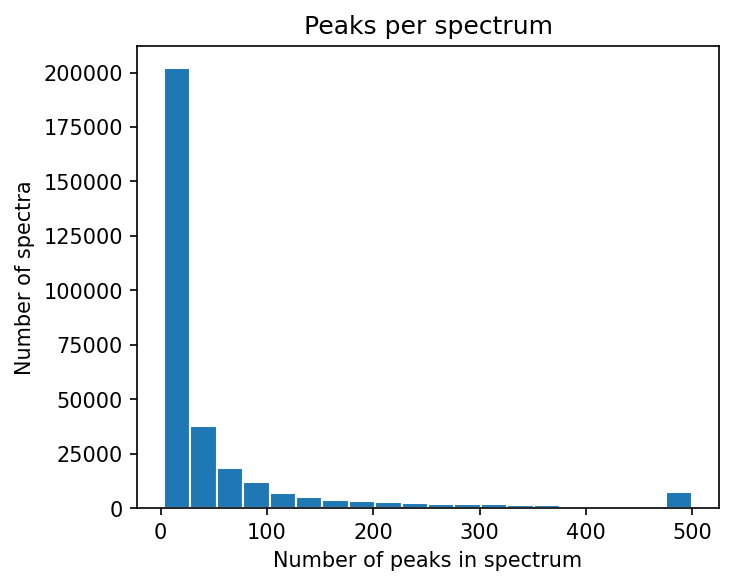

Total Inchis: 314318 -- 24864 unique Inchis
Total Smiles: 314318 -- 32591 unique Smiles
Total Inchikeys: 314318 -- 20889 unique Inchikeys (first 14 characters)


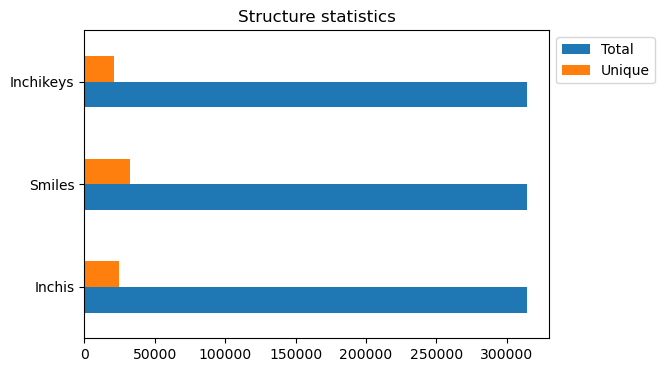

In [9]:
spec = DataExploration(spec_data)
spec.plot_peaks()
spec.count_annotations()

In [10]:
class DataFiltering:
    def __init__(self, spectra):
        self.spectra = spectra
        
        # thresholds for selecting higher quality spectra
        self.intensity_thres = 0.01
        self.n_peaks_required = 10
        self.gnps_spec_quality_measure = 3
    
    def count_higher_peaks(self, index=0,threshold = 0.1):
        spectrum = self.spectra[index]
        return np.sum(spectrum.peaks.intensities/\
                      spectrum.peaks.intensities.max() >= threshold)

    
    def get_ids_for_unique_inchikeys(self): #: List[SpectrumType]
        """Return indices for best chosen spectra for each unique inchikey
        Parameters
        ----------
        spectrums:
            Input spectra
        """
        # collect all inchikeys (first 14 characters)
        inchikey_collection = OrderedDict()
        for i, spec in enumerate(self.spectra):
            inchikey = spec.get("inchikey")
            if inchikey:
                if inchikey[:14] in inchikey_collection:
                    inchikey_collection[inchikey[:14]] += [i]
                else:
                    inchikey_collection[inchikey[:14]] = [i]

        
        ID_picks = []

        inchikey14_unique = [x for x in inchikey_collection.keys()]

        # Loop through all unique inchiques (14 first characters)
        for inchikey14 in inchikey14_unique:
            specIDs = np.array(inchikey_collection[inchikey14])
            if specIDs.size == 1:
                ID_picks.append(specIDs[0])
            else:
                # 1 select spec with sufficient peaks (e.g. 10 with intensity 0.01)
                num_peaks = np.array([self.count_higher_peaks(
                    index=specID, threshold=self.intensity_thres) for
                                      specID in specIDs])
                sufficient_peaks = np.where(num_peaks >= self.n_peaks_required)[0]
                if sufficient_peaks.size == 0:
                    sufficient_peaks = np.where(num_peaks == max(num_peaks))[0]
                step1IDs = specIDs[sufficient_peaks]

                # 2 select best spectrum qualities
                # (according to gnps measure). 1 > 2 > 3
                qualities = np.array(
                    [int(self.spectra[specID].get("library_class",\
                                                  self.gnps_spec_quality_measure))
                     for specID in step1IDs])  # default is 3; worst quality
                step2IDs = step1IDs[np.where(qualities == min(qualities))[0]]

                # 3 Select the ones with most peaks > threshold
                num_peaks = np.array([self.count_higher_peaks(
                    index=specID, threshold=self.intensity_thres) for specID in step2IDs])
                pick = np.argmax(num_peaks)
                ID_picks.append(step2IDs[pick])
        ID_picks.sort()  # ensure order

        return ID_picks
    
    # pick unique spectra using the unique inchikeys
    
    def unique_spectra(self):
        uniq_inchikeys = self.get_ids_for_unique_inchikeys()
        uniq_spec_data = [self.spectra[i] for i in uniq_inchikeys]
        
        return uniq_spec_data
        
    
        

        
    

In [11]:
filtering = DataFiltering(spec_data)
filtering.gnps_spec_quality_measure

unique_spectra = filtering.unique_spectra()
#len(unique_spectra)

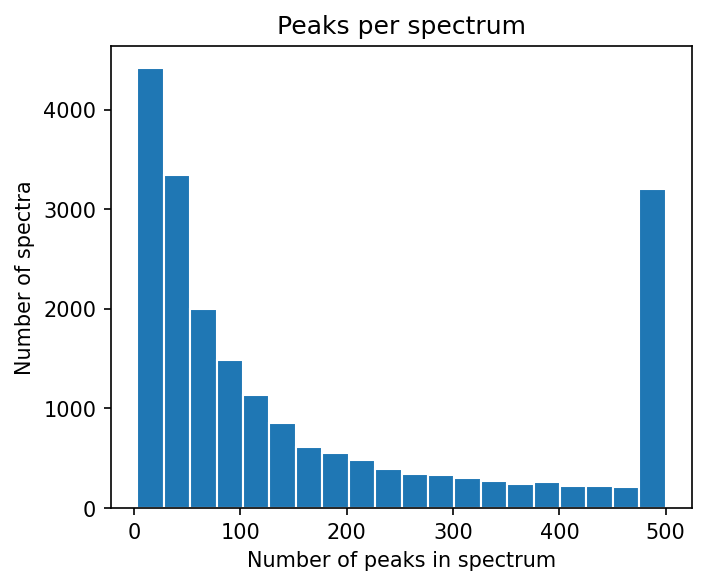

Total Inchis: 20889 -- 20889 unique Inchis
Total Smiles: 20889 -- 20888 unique Smiles
Total Inchikeys: 20889 -- 20889 unique Inchikeys (first 14 characters)


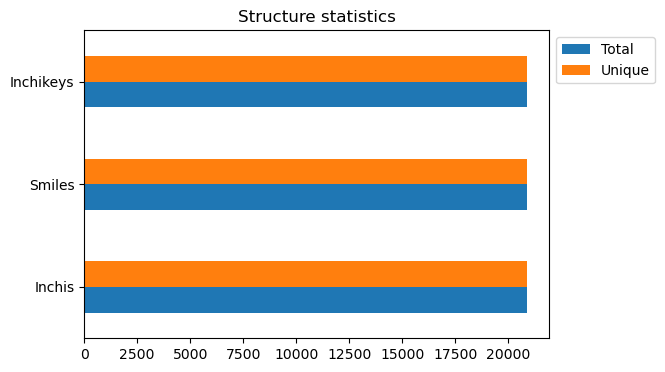

In [12]:
unique_expl = DataExploration(unique_spectra)
unique_expl.plot_peaks()
unique_expl.count_annotations()

In [36]:
print("Number of spectra:", len(spec_data))

Number of spectra: 200


In [10]:
def count_annotations(spectra):
    inchi_lst = []
    smiles_lst = []
    inchikey_lst = []
    for i, spec in enumerate(spectra):
        inchi_lst.append(spec.get("inchi"))
        smiles_lst.append(spec.get("smiles"))
        inchikey = spec.get("inchikey")
        if inchikey is None:
            inchikey = spec.get("inchikey_inchi")
        inchikey_lst.append(inchikey)

    inchi_count = sum([1 for x in inchi_lst if x])
    smiles_count = sum([1 for x in smiles_lst if x])
    inchikey_count = sum([1 for x in inchikey_lst if x])
    print("Total Inchis:", inchi_count, "--", len(set(inchi_lst)), "unique Inchis")
    print("Total Smiles:", smiles_count, "--", len(set(smiles_lst)), "unique Smiles")
    print("Total Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), "unique Inchikeys (first 14 characters)")
    
    
    #Modified to return a df so that we can plot the stats
    totals = [inchi_count,smiles_count,inchikey_count]
    unique = [len(set(inchi_lst)),len(set(smiles_lst)),\
              len(set([x[:14] for x in inchikey_lst if x]))]
   
    #print(unique)
    #print(totals)
    df = pd.DataFrame(list(zip(totals,unique)), \
                      index=['Inchis','Smiles','Inchikeys'],\
                      columns=['Total', 'Unique'])
    
    
    return df

In [12]:
stats_df = count_annotations(spec_data)   

Total Inchis: 314318 -- 24864 unique Inchis
Total Smiles: 314318 -- 32591 unique Smiles
Total Inchikeys: 314318 -- 20889 unique Inchikeys (first 14 characters)


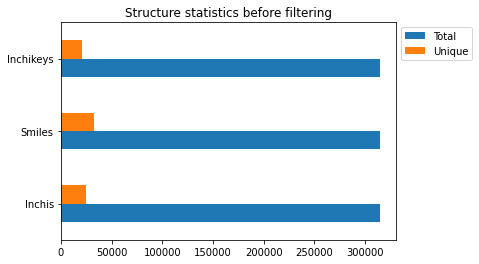

In [14]:
ax=stats_df.plot(kind='barh', title='Structure statistics before filtering', figsize=(6, 4))
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

### Filter Unique inchiKey

Follows [louwenjjr
](https://github.com/louwenjjr/ms2_mass_differences/blob/ffd31aff66fba14502e3c7ec4f1b5eb947687ef1/scripts/mass_differences/processing.py)

In [15]:
def count_higher_peaks(spectrum, threshold = 0.1):
    return np.sum(spectrum.peaks.intensities/spectrum.peaks.intensities.max() >= threshold)


In [43]:
def get_ids_for_unique_inchikeys(spectrums): #: List[SpectrumType]
    """Return indices for best chosen spectra for each unique inchikey
    Parameters
    ----------
    spectrums:
        Input spectra
    """
    # collect all inchikeys (first 14 characters)
    inchikey_collection = OrderedDict()
    for i, spec in enumerate(spectrums):
        inchikey = spec.get("inchikey")
        if inchikey:
            if inchikey[:14] in inchikey_collection:
                inchikey_collection[inchikey[:14]] += [i]
            else:
                inchikey_collection[inchikey[:14]] = [i]

    intensity_thres = 0.01
    n_peaks_required = 10
    ID_picks = []

    inchikey14_unique = [x for x in inchikey_collection.keys()]

    # Loop through all unique inchiques (14 first characters)
    for inchikey14 in inchikey14_unique:
        specIDs = np.array(inchikey_collection[inchikey14])
        if specIDs.size == 1:
            ID_picks.append(specIDs[0])
        else:
            # 1 select spec with sufficient peaks (e.g. 10 with intensity 0.01)
            num_peaks = np.array([count_higher_peaks(
                spectrums[specID], intensity_thres) for
                                  specID in specIDs])
            sufficient_peaks = np.where(num_peaks >= n_peaks_required)[0]
            if sufficient_peaks.size == 0:
                sufficient_peaks = np.where(num_peaks == max(num_peaks))[0]
            step1IDs = specIDs[sufficient_peaks]

            # 2 select best spectrum qualities
            # (according to gnps measure). 1 > 2 > 3
            qualities = np.array(
                [int(spectrums[specID].get("library_class", 3))
                 for specID in step1IDs])  # default worst quality
            step2IDs = step1IDs[np.where(qualities == min(qualities))[0]]

            # 3 Select the ones with most peaks > threshold
            num_peaks = np.array([count_higher_peaks(
                spectrums[specID], intensity_thres) for specID in step2IDs])
            pick = np.argmax(num_peaks)
            ID_picks.append(step2IDs[pick])
    ID_picks.sort()  # ensure order

    return ID_picks

In [89]:
# callthe function 
uniq_inchikeys = get_ids_for_unique_inchikeys(spec_data)

In [90]:
# pick unique spectra using the unique inchikeys
uniq_spec_data = [spec_data[i] for i in uniq_inchikeys]
spectra= uniq_spec_data

In [47]:
# write the unique dataset to file
with open('../raw_data/spectra_unique_GNPS_15_12_2021.pickle', 'wb') as f:
    pickle.dump(spectra, f) 

In [19]:
stats_spectra_df = count_annotations(spectra)   


Total Inchis: 20889 -- 20889 unique Inchis
Total Smiles: 20889 -- 20888 unique Smiles
Total Inchikeys: 20889 -- 20889 unique Inchikeys (first 14 characters)


Text(0, 0.5, 'Number of spectra')

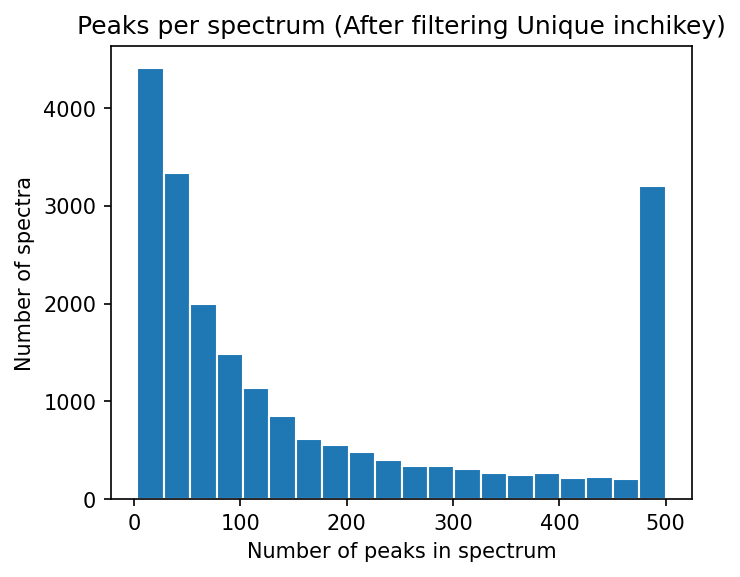

In [49]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectra]
plt.figure(figsize=(5,4), dpi=150)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (After filtering Unique inchikey)") 
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")

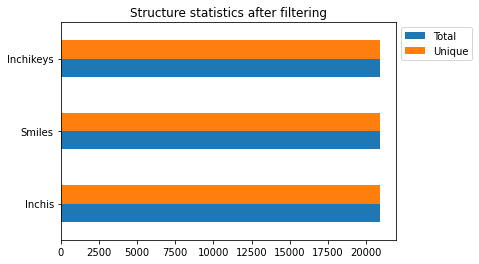

In [20]:
# barplot to visualise 
ax=stats_spectra_df.plot(kind='barh', title='Structure statistics after filtering', figsize=(6, 4))
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

### Train A Spec2Vec Model

start by converting spectra to documents

In [23]:

spectrum_documents = [SpectrumDocument(s, n_decimals=2) for s in spectra]

In [164]:
start=datetime.now()

from spec2vec.model_building import train_new_word2vec_model
model_file = "unique_spectra_model.model"
model = train_new_word2vec_model(spectrum_documents, iterations=[25], filename=model_file,
                                 workers=2, progress_logger=True)

run_time = datetime.now() - start
print(run_time)

  Epoch 1 of 25.Change in loss after epoch 1: 3467647.75
  Epoch 2 of 25.Change in loss after epoch 2: 2574011.25
  Epoch 3 of 25.Change in loss after epoch 3: 2371707.0
  Epoch 4 of 25.Change in loss after epoch 4: 2002245.0
  Epoch 5 of 25.Change in loss after epoch 5: 2040350.0
  Epoch 6 of 25.Change in loss after epoch 6: 1878054.0
  Epoch 7 of 25.Change in loss after epoch 7: 1784922.0
  Epoch 8 of 25.Change in loss after epoch 8: 1622981.0
  Epoch 9 of 25.Change in loss after epoch 9: 1458770.0
  Epoch 10 of 25.Change in loss after epoch 10: 1398334.0
  Epoch 11 of 25.Change in loss after epoch 11: 1340132.0
  Epoch 12 of 25.Change in loss after epoch 12: 1367686.0
  Epoch 13 of 25.Change in loss after epoch 13: 1275606.0
  Epoch 14 of 25.Change in loss after epoch 14: 1169680.0
  Epoch 15 of 25.Change in loss after epoch 15: 1131016.0
  Epoch 16 of 25.Change in loss after epoch 16: 1161482.0
  Epoch 17 of 25.Change in loss after epoch 17: 1156316.0
  Epoch 18 of 25.Change in los

### Load a pretrained Spec2Vec model

In [1]:
import gensim
import IProgress
import ipywidgets

In [25]:
os.listdir()

['.ipynb_checkpoints',
 'compound_0.png',
 'compound_1.png',
 'compound_2.png',
 'compound_3.png',
 'compound_4.png',
 'compound_5.png',
 'compound_6.png',
 'compound_7.png',
 'compound_8.png',
 'compound_9.png',
 'data_exploration.ipynb',
 'from_uncleaned_data.ipynb',
 'iomega-1-mgf_to_cleaned_data.ipynb',
 'unique_spectra_model.model',
 'unique_spectra_model.model.syn1neg.npy',
 'unique_spectra_model.model.wv.vectors.npy']

In [22]:
! jupyter --version

Selected Jupyter core packages...
IPython          : 7.30.1
ipykernel        : 6.6.0
ipywidgets       : 8.0.2
jupyter_client   : 7.1.0
jupyter_core     : 4.9.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.5.9
nbconvert        : 6.3.0
nbformat         : 5.1.3
notebook         : 6.4.6
qtconsole        : 5.3.2
traitlets        : 5.1.1


### Spec2Vec Embeddings

In [26]:
path_model ='../raw_data/spec2vec_model_GNPS_15_12_2021.model'

model = gensim.models.Word2Vec.load(path_model)


In [27]:
model.wv.index_to_key[0]

'peak@91.05'

In [4]:
# extract embedding from the model
intensity_weighting_power = 0.5
allowed_missing_percentage = 50 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing


#initiate the embeddings
spec2vec_embeddings = np.zeros((len(spectrum_documents),\
                                model.vector_size), dtype="float")
for i, doc in enumerate(tqdm(spectrum_documents)):
    spec2vec_embeddings[i, 0:model.vector_size] =\
    calc_vector(model, doc,\
                 intensity_weighting_power,allowed_missing_percentage)
    
    

NameError: name 'spectrum_documents' is not defined

In [29]:
#write embeddings to file
with open('../raw_data/spec2vec_embeddings_unique_GNPS_15_12_2021.pickle', 'wb') as f:
    pickle.dump(spec2vec_embeddings, f) 

In [38]:
spec_embd = pd.read_pickle('../raw_data/spec2vec_embeddings_unique_GNPS_15_12_2021.pickle')

In [39]:
len(spec_embd)

20889

### MS2DeepScore Embeddings

pretrained model was downloaded from [ms2deepscore](https://github.com/matchms/ms2deepscore) github

In [31]:
from ms2deepscore.models import load_model
from ms2deepscore import MS2DeepScore


In [32]:
path = '../raw_data/ms2ds_model_GNPS_15_12_2021.hdf5'
ms2deepscore_model = load_model(path)

# Init MS2DeepScore
ms2deepscore_model_scores = MS2DeepScore(ms2deepscore_model)
ms2deepscore_model_scores.model.spectrum_binner.allowed_missing_percentage = 50



# Generate embeddings from spectra
ms2ds_embeddings = ms2deepscore_model_scores.calculate_vectors(spectra)

Calculating vectors of reference spectrums:   0%|                                            | 0/20889 [00:00<?, ?it/s]

1/1 [==============================] - 0s 346ms/step


Calculating vectors of reference spectrums:   0%|                                  | 1/20889 [00:00<2:29:16,  2.33it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:   0%|                                    | 3/20889 [00:00<53:37,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:   0%|                                    | 5/20889 [00:00<36:57,  9.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                    | 7/20889 [00:00<29:58, 11.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                    | 9/20889 [00:00<25:58, 13.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                   | 11/20889 [00:01<24:10, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 13/20889 [00:01<23:28, 14.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                   | 15/20889 [00:01<22:26, 15.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                   | 17/20889 [00:01<21:57, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 19/20889 [00:01<22:03, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 21/20889 [00:01<22:06, 15.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                   | 23/20889 [00:01<21:44, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 25/20889 [00:01<21:28, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 27/20889 [00:02<22:08, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 29/20889 [00:02<22:11, 15.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                   | 31/20889 [00:02<21:22, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 33/20889 [00:02<21:13, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 35/20889 [00:02<21:06, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 37/20889 [00:02<21:01, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 39/20889 [00:02<20:33, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 41/20889 [00:02<20:38, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 43/20889 [00:02<20:17, 17.13it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:   0%|                                   | 45/20889 [00:03<20:01, 17.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 47/20889 [00:03<20:02, 17.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 49/20889 [00:03<19:49, 17.53it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:   0%|                                   | 51/20889 [00:03<19:53, 17.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 53/20889 [00:03<19:30, 17.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 55/20889 [00:03<19:43, 17.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                   | 57/20889 [00:03<20:03, 17.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                   | 59/20889 [00:03<19:55, 17.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                   | 61/20889 [00:03<19:42, 17.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 63/20889 [00:04<19:49, 17.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 65/20889 [00:04<19:28, 17.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 67/20889 [00:04<19:37, 17.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|                                   | 69/20889 [00:04<19:26, 17.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 71/20889 [00:04<19:38, 17.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|                                   | 73/20889 [00:04<19:34, 17.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 75/20889 [00:04<19:35, 17.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 77/20889 [00:04<19:32, 17.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 79/20889 [00:04<19:55, 17.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 81/20889 [00:05<21:25, 16.19it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 83/20889 [00:05<22:44, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 85/20889 [00:05<22:09, 15.65it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 87/20889 [00:05<21:32, 16.09it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 89/20889 [00:05<21:05, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 91/20889 [00:05<20:35, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 93/20889 [00:05<20:26, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 95/20889 [00:05<20:08, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 97/20889 [00:06<19:47, 17.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|▏                                  | 99/20889 [00:06<19:25, 17.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   0%|▏                                 | 101/20889 [00:06<20:00, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   0%|▏                                 | 103/20889 [00:06<19:42, 17.58it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 105/20889 [00:06<19:45, 17.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 107/20889 [00:06<19:48, 17.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 109/20889 [00:06<19:40, 17.60it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 111/20889 [00:06<21:04, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 113/20889 [00:07<21:20, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 115/20889 [00:07<21:11, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 117/20889 [00:07<21:03, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 119/20889 [00:07<20:33, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 121/20889 [00:07<20:43, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 123/20889 [00:07<19:54, 17.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 125/20889 [00:07<20:10, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 127/20889 [00:07<20:17, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 129/20889 [00:07<20:08, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 131/20889 [00:08<19:43, 17.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 133/20889 [00:08<20:26, 16.92it/s]

1/1 [==============================] - 0s 14ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 135/20889 [00:08<20:56, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 137/20889 [00:08<21:16, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 139/20889 [00:08<21:32, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 141/20889 [00:08<21:04, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 143/20889 [00:08<20:40, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 145/20889 [00:08<20:41, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 147/20889 [00:09<20:17, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 149/20889 [00:09<20:37, 16.75it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 151/20889 [00:09<20:14, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▏                                 | 153/20889 [00:09<19:58, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 155/20889 [00:09<20:11, 17.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 157/20889 [00:09<20:11, 17.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 159/20889 [00:09<20:10, 17.13it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 161/20889 [00:09<21:35, 16.00it/s]

1/1 [==============================] - 0s 34ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 163/20889 [00:10<21:56, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 165/20889 [00:10<21:34, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 167/20889 [00:10<21:18, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 169/20889 [00:10<21:34, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 171/20889 [00:10<21:21, 16.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 173/20889 [00:10<20:45, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 175/20889 [00:10<20:44, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 177/20889 [00:10<24:39, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 179/20889 [00:11<24:43, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 181/20889 [00:11<24:13, 14.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 183/20889 [00:11<24:09, 14.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 185/20889 [00:11<23:47, 14.50it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 187/20889 [00:11<23:32, 14.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 189/20889 [00:11<22:42, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 191/20889 [00:11<22:07, 15.60it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 193/20889 [00:12<26:42, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 195/20889 [00:12<28:14, 12.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 197/20889 [00:12<27:38, 12.48it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 199/20889 [00:12<27:37, 12.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 201/20889 [00:12<27:36, 12.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 203/20889 [00:12<28:12, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 205/20889 [00:13<26:13, 13.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 207/20889 [00:13<26:14, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 209/20889 [00:13<25:33, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 211/20889 [00:13<25:20, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 213/20889 [00:13<23:32, 14.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 215/20889 [00:13<21:59, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 217/20889 [00:13<21:26, 16.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 219/20889 [00:13<20:42, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 221/20889 [00:14<20:21, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 223/20889 [00:14<20:29, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 225/20889 [00:14<20:06, 17.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 227/20889 [00:14<20:18, 16.96it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▎                                 | 229/20889 [00:14<20:32, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 231/20889 [00:14<20:02, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 233/20889 [00:14<19:55, 17.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 235/20889 [00:14<20:08, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 237/20889 [00:14<19:56, 17.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 239/20889 [00:15<19:44, 17.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 241/20889 [00:15<20:09, 17.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 243/20889 [00:15<20:20, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 245/20889 [00:15<20:05, 17.12it/s]

1/1 [==============================] - 0s 12ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 247/20889 [00:15<20:03, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 249/20889 [00:15<20:00, 17.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 251/20889 [00:15<19:59, 17.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 253/20889 [00:15<19:36, 17.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 255/20889 [00:16<19:51, 17.31it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 257/20889 [00:16<21:30, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 259/20889 [00:16<21:15, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 261/20889 [00:16<20:41, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 263/20889 [00:16<20:29, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 265/20889 [00:16<20:39, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 267/20889 [00:16<20:16, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 269/20889 [00:16<20:08, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 271/20889 [00:16<20:41, 16.60it/s]

1/1 [==============================] - 0s 10ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 273/20889 [00:17<20:23, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 275/20889 [00:17<20:26, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 277/20889 [00:17<20:17, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 279/20889 [00:17<20:09, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 281/20889 [00:17<20:11, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 283/20889 [00:17<20:17, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 285/20889 [00:17<20:04, 17.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 287/20889 [00:17<20:05, 17.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 289/20889 [00:18<20:01, 17.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 291/20889 [00:18<20:13, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 293/20889 [00:18<20:53, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 295/20889 [00:18<20:37, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 297/20889 [00:18<20:20, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 299/20889 [00:18<20:12, 16.98it/s]

1/1 [==============================] - 0s 10ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 301/20889 [00:18<20:03, 17.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 303/20889 [00:18<20:07, 17.05it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 305/20889 [00:18<20:03, 17.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   1%|▍                                 | 307/20889 [00:19<20:06, 17.05it/s]

1/1 [==============================] - 0s 10ms/step


Calculating vectors of reference spectrums:   1%|▌                                 | 309/20889 [00:19<20:02, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   1%|▌                                 | 311/20889 [00:19<20:03, 17.10it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:   1%|▌                                 | 313/20889 [00:19<20:01, 17.12it/s]

1/1 [==============================] - 0s 10ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 315/20889 [00:19<19:56, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 317/20889 [00:19<19:50, 17.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 319/20889 [00:19<19:20, 17.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 321/20889 [00:19<19:41, 17.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 323/20889 [00:20<19:54, 17.22it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 325/20889 [00:20<19:47, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 327/20889 [00:20<19:57, 17.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 329/20889 [00:20<20:34, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 331/20889 [00:20<21:23, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 333/20889 [00:20<20:43, 16.54it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 335/20889 [00:20<20:35, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 337/20889 [00:20<20:10, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 339/20889 [00:20<20:17, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 341/20889 [00:21<19:57, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 343/20889 [00:21<20:07, 17.01it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 345/20889 [00:21<20:02, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 347/20889 [00:21<19:23, 17.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 349/20889 [00:21<19:44, 17.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 351/20889 [00:21<19:50, 17.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 353/20889 [00:21<20:03, 17.07it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 355/20889 [00:21<19:48, 17.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 357/20889 [00:22<20:16, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 359/20889 [00:22<20:15, 16.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 361/20889 [00:22<21:01, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 363/20889 [00:22<20:39, 16.56it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 365/20889 [00:22<20:20, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 367/20889 [00:22<19:39, 17.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 369/20889 [00:22<19:52, 17.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 371/20889 [00:22<20:02, 17.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 373/20889 [00:22<20:35, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 375/20889 [00:23<22:18, 15.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 377/20889 [00:23<21:24, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 379/20889 [00:23<20:35, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 381/20889 [00:23<19:34, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▌                                 | 383/20889 [00:23<19:33, 17.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 385/20889 [00:23<19:21, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 387/20889 [00:23<19:34, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 389/20889 [00:23<19:40, 17.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 391/20889 [00:24<19:44, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 393/20889 [00:24<20:02, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 395/20889 [00:24<19:21, 17.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 397/20889 [00:24<19:35, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 399/20889 [00:24<19:45, 17.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 401/20889 [00:24<19:35, 17.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 403/20889 [00:24<19:16, 17.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 405/20889 [00:24<19:28, 17.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 407/20889 [00:24<19:38, 17.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 409/20889 [00:25<19:48, 17.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 411/20889 [00:25<19:36, 17.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 413/20889 [00:25<19:28, 17.53it/s]

1/1 [==============================] - 0s 12ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 415/20889 [00:25<19:35, 17.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 417/20889 [00:25<19:28, 17.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 419/20889 [00:25<19:41, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 421/20889 [00:25<19:20, 17.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 423/20889 [00:25<19:15, 17.70it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 425/20889 [00:25<19:14, 17.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 427/20889 [00:26<19:26, 17.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 429/20889 [00:26<19:20, 17.63it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 431/20889 [00:26<19:11, 17.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 433/20889 [00:26<19:15, 17.71it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 435/20889 [00:26<19:19, 17.63it/s]

1/1 [==============================] - 0s 12ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 437/20889 [00:26<18:42, 18.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 439/20889 [00:26<19:23, 17.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 441/20889 [00:26<19:25, 17.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 443/20889 [00:27<19:24, 17.55it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 445/20889 [00:27<19:26, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 447/20889 [00:27<19:29, 17.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 449/20889 [00:27<19:47, 17.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 451/20889 [00:27<20:33, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 454/20889 [00:27<19:23, 17.56it/s]

1/1 [==============================] - 0s 8ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 456/20889 [00:27<19:31, 17.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 458/20889 [00:27<19:24, 17.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▋                                 | 460/20889 [00:27<19:25, 17.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 462/20889 [00:28<19:26, 17.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 464/20889 [00:28<19:07, 17.80it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 466/20889 [00:28<19:29, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 468/20889 [00:28<19:09, 17.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 470/20889 [00:28<19:26, 17.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 472/20889 [00:28<19:03, 17.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 474/20889 [00:28<19:33, 17.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 476/20889 [00:28<19:47, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 478/20889 [00:29<19:23, 17.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 480/20889 [00:29<19:25, 17.51it/s]

1/1 [==============================] - 0s 8ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 482/20889 [00:29<20:13, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 484/20889 [00:29<19:51, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 486/20889 [00:29<19:55, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 488/20889 [00:29<19:30, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 490/20889 [00:29<19:38, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 492/20889 [00:29<19:35, 17.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 494/20889 [00:29<19:34, 17.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 496/20889 [00:30<19:33, 17.38it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 498/20889 [00:30<19:35, 17.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 500/20889 [00:30<19:25, 17.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 502/20889 [00:30<19:42, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 504/20889 [00:30<19:54, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 506/20889 [00:30<19:38, 17.29it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 508/20889 [00:30<19:27, 17.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 510/20889 [00:30<19:12, 17.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 512/20889 [00:30<19:15, 17.64it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 514/20889 [00:31<19:42, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 516/20889 [00:31<19:45, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 518/20889 [00:31<20:07, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 520/20889 [00:31<19:56, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   2%|▊                                 | 522/20889 [00:31<19:35, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▊                                 | 524/20889 [00:31<19:42, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▊                                 | 526/20889 [00:31<19:39, 17.26it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   3%|▊                                 | 528/20889 [00:31<19:30, 17.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▊                                 | 530/20889 [00:32<19:56, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▊                                 | 532/20889 [00:32<19:40, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▊                                 | 534/20889 [00:32<19:50, 17.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▊                                 | 536/20889 [00:32<19:38, 17.27it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 538/20889 [00:32<20:47, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 540/20889 [00:32<20:14, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 542/20889 [00:32<20:35, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 544/20889 [00:32<20:31, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 546/20889 [00:32<20:23, 16.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 548/20889 [00:33<20:03, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 550/20889 [00:33<19:28, 17.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 552/20889 [00:33<19:42, 17.19it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 554/20889 [00:33<19:14, 17.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 556/20889 [00:33<19:42, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 558/20889 [00:33<19:23, 17.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 560/20889 [00:33<19:44, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 562/20889 [00:33<19:51, 17.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 564/20889 [00:34<19:31, 17.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 566/20889 [00:34<19:36, 17.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 568/20889 [00:34<19:30, 17.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 570/20889 [00:34<19:20, 17.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 572/20889 [00:34<19:43, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 574/20889 [00:34<19:43, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 576/20889 [00:34<19:31, 17.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 578/20889 [00:34<19:22, 17.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 580/20889 [00:34<19:31, 17.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 582/20889 [00:35<19:52, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 584/20889 [00:35<19:54, 17.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 586/20889 [00:35<19:27, 17.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 588/20889 [00:35<19:33, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 590/20889 [00:35<20:58, 16.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 592/20889 [00:35<20:34, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 594/20889 [00:35<20:11, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 596/20889 [00:35<19:39, 17.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 598/20889 [00:36<19:25, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 600/20889 [00:36<19:43, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 602/20889 [00:36<19:33, 17.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 604/20889 [00:36<19:33, 17.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 606/20889 [00:36<19:31, 17.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 608/20889 [00:36<19:27, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 610/20889 [00:36<19:32, 17.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 612/20889 [00:36<19:24, 17.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|▉                                 | 614/20889 [00:36<19:50, 17.04it/s]

1/1 [==============================] - 0s 8ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 616/20889 [00:37<20:01, 16.87it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 618/20889 [00:37<19:58, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 620/20889 [00:37<19:39, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 622/20889 [00:37<19:46, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 624/20889 [00:37<19:26, 17.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 626/20889 [00:37<19:37, 17.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 628/20889 [00:37<19:26, 17.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 630/20889 [00:37<20:29, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 632/20889 [00:38<20:49, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 634/20889 [00:38<20:39, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 636/20889 [00:38<20:31, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 638/20889 [00:38<20:20, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 640/20889 [00:38<20:05, 16.80it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 642/20889 [00:38<19:57, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 644/20889 [00:38<19:38, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 646/20889 [00:38<19:25, 17.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 648/20889 [00:38<19:29, 17.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 650/20889 [00:39<19:28, 17.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 652/20889 [00:39<19:11, 17.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 654/20889 [00:39<18:50, 17.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 656/20889 [00:39<19:05, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 658/20889 [00:39<19:16, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 660/20889 [00:39<19:22, 17.41it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 662/20889 [00:39<19:10, 17.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 664/20889 [00:39<19:06, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 666/20889 [00:39<19:27, 17.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 668/20889 [00:40<19:22, 17.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 670/20889 [00:40<19:28, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 672/20889 [00:40<19:36, 17.19it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 674/20889 [00:40<20:19, 16.57it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 676/20889 [00:40<19:44, 17.06it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 678/20889 [00:40<19:23, 17.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 680/20889 [00:40<19:37, 17.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 682/20889 [00:40<19:47, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 684/20889 [00:41<19:55, 16.91it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 686/20889 [00:41<19:34, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 688/20889 [00:41<19:26, 17.31it/s]

1/1 [==============================] - 0s 10ms/step


Calculating vectors of reference spectrums:   3%|█                                 | 690/20889 [00:41<19:29, 17.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 692/20889 [00:41<19:34, 17.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 694/20889 [00:41<19:32, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 696/20889 [00:41<19:47, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 698/20889 [00:41<19:36, 17.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 700/20889 [00:41<19:27, 17.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 702/20889 [00:42<19:34, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 704/20889 [00:42<19:24, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 706/20889 [00:42<19:41, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 708/20889 [00:42<19:26, 17.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 710/20889 [00:42<19:08, 17.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 712/20889 [00:42<19:14, 17.48it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 714/20889 [00:42<18:59, 17.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 716/20889 [00:42<20:33, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 718/20889 [00:43<20:09, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 720/20889 [00:43<19:36, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 722/20889 [00:43<19:22, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 724/20889 [00:43<19:13, 17.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 726/20889 [00:43<19:32, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 728/20889 [00:43<19:21, 17.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   3%|█▏                                | 730/20889 [00:43<19:22, 17.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 732/20889 [00:43<19:20, 17.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 734/20889 [00:43<19:26, 17.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 736/20889 [00:44<19:12, 17.49it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 738/20889 [00:44<19:11, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 740/20889 [00:44<19:05, 17.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 742/20889 [00:44<19:01, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 744/20889 [00:44<19:12, 17.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 746/20889 [00:44<19:10, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 748/20889 [00:44<19:08, 17.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 750/20889 [00:44<19:18, 17.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 752/20889 [00:44<19:08, 17.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 754/20889 [00:45<19:19, 17.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 756/20889 [00:45<19:00, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 758/20889 [00:45<19:13, 17.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 760/20889 [00:45<19:31, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 762/20889 [00:45<19:02, 17.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 764/20889 [00:45<19:29, 17.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▏                                | 766/20889 [00:45<19:20, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 768/20889 [00:45<19:16, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 770/20889 [00:45<19:19, 17.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 772/20889 [00:46<19:14, 17.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 774/20889 [00:46<19:20, 17.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 776/20889 [00:46<19:09, 17.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 778/20889 [00:46<19:28, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 780/20889 [00:46<19:08, 17.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 782/20889 [00:46<19:18, 17.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 784/20889 [00:46<19:08, 17.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 786/20889 [00:46<19:13, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 788/20889 [00:47<19:12, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 790/20889 [00:47<19:12, 17.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 792/20889 [00:47<19:32, 17.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 794/20889 [00:47<19:24, 17.26it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 796/20889 [00:47<18:59, 17.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 798/20889 [00:47<19:29, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 800/20889 [00:47<19:06, 17.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 802/20889 [00:47<19:39, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 804/20889 [00:47<19:11, 17.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 806/20889 [00:48<19:06, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 808/20889 [00:48<19:21, 17.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 810/20889 [00:48<19:13, 17.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 812/20889 [00:48<21:05, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 814/20889 [00:48<20:46, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 816/20889 [00:48<20:59, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 818/20889 [00:48<21:10, 15.79it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 820/20889 [00:48<20:47, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 822/20889 [00:49<19:53, 16.81it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 824/20889 [00:49<19:56, 16.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 826/20889 [00:49<19:41, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 828/20889 [00:49<19:34, 17.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 830/20889 [00:49<19:31, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 832/20889 [00:49<19:30, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 834/20889 [00:49<19:20, 17.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 836/20889 [00:49<19:28, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 838/20889 [00:49<20:04, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 840/20889 [00:50<20:00, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 842/20889 [00:50<19:44, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▎                                | 844/20889 [00:50<19:32, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 846/20889 [00:50<19:41, 16.96it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 848/20889 [00:50<19:32, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 850/20889 [00:50<19:36, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 852/20889 [00:50<19:37, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 854/20889 [00:50<19:35, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 856/20889 [00:51<19:29, 17.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 858/20889 [00:51<19:29, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 860/20889 [00:51<19:45, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 862/20889 [00:51<19:23, 17.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 864/20889 [00:51<19:24, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 866/20889 [00:51<19:27, 17.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 868/20889 [00:51<19:20, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 870/20889 [00:51<19:36, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 872/20889 [00:51<19:25, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 874/20889 [00:52<19:22, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 876/20889 [00:52<19:21, 17.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 878/20889 [00:52<19:25, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 880/20889 [00:52<19:30, 17.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 882/20889 [00:52<19:31, 17.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 884/20889 [00:52<19:30, 17.09it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 886/20889 [00:52<19:21, 17.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 888/20889 [00:52<19:35, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 890/20889 [00:53<19:38, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 892/20889 [00:53<19:38, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 894/20889 [00:53<19:32, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 896/20889 [00:53<19:30, 17.08it/s]

1/1 [==============================] - 0s 8ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 898/20889 [00:53<20:14, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 900/20889 [00:53<19:47, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 902/20889 [00:53<19:26, 17.13it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 904/20889 [00:53<19:34, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 906/20889 [00:53<19:04, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 908/20889 [00:54<19:12, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 910/20889 [00:54<19:13, 17.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 912/20889 [00:54<19:09, 17.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 914/20889 [00:54<19:10, 17.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 916/20889 [00:54<19:12, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 918/20889 [00:54<19:21, 17.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▍                                | 920/20889 [00:54<19:19, 17.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 922/20889 [00:54<19:14, 17.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 924/20889 [00:55<19:14, 17.29it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 926/20889 [00:55<19:54, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 928/20889 [00:55<19:59, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 930/20889 [00:55<20:00, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 932/20889 [00:55<19:38, 16.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 934/20889 [00:55<19:26, 17.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 936/20889 [00:55<19:33, 17.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 938/20889 [00:55<19:34, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   4%|█▌                                | 940/20889 [00:55<19:25, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 942/20889 [00:56<19:23, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 944/20889 [00:56<18:54, 17.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 946/20889 [00:56<19:31, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 948/20889 [00:56<19:17, 17.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 950/20889 [00:56<19:01, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 952/20889 [00:56<19:10, 17.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 954/20889 [00:56<19:00, 17.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 956/20889 [00:56<19:41, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 958/20889 [00:56<19:12, 17.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 960/20889 [00:57<19:15, 17.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 962/20889 [00:57<19:18, 17.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 964/20889 [00:57<19:01, 17.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 966/20889 [00:57<19:09, 17.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 968/20889 [00:57<18:59, 17.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 970/20889 [00:57<19:14, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 972/20889 [00:57<19:20, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 974/20889 [00:57<19:35, 16.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 976/20889 [00:58<19:41, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 978/20889 [00:58<19:28, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 980/20889 [00:58<19:37, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 982/20889 [00:58<19:19, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 984/20889 [00:58<20:08, 16.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 986/20889 [00:58<19:55, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 988/20889 [00:58<19:29, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 990/20889 [00:58<19:13, 17.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 992/20889 [00:58<19:02, 17.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 994/20889 [00:59<19:17, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 996/20889 [00:59<18:54, 17.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                                | 998/20889 [00:59<19:08, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1000/20889 [00:59<18:46, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1002/20889 [00:59<18:58, 17.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1004/20889 [00:59<19:14, 17.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1006/20889 [00:59<19:10, 17.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1008/20889 [00:59<19:24, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1010/20889 [01:00<19:08, 17.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1012/20889 [01:00<19:12, 17.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1014/20889 [01:00<19:17, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1016/20889 [01:00<19:08, 17.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1018/20889 [01:00<19:07, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1020/20889 [01:00<19:06, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1022/20889 [01:00<19:15, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1024/20889 [01:00<19:03, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1026/20889 [01:00<19:05, 17.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▌                               | 1028/20889 [01:01<19:04, 17.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1030/20889 [01:01<19:17, 17.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1032/20889 [01:01<19:26, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1034/20889 [01:01<19:18, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1036/20889 [01:01<19:28, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1038/20889 [01:01<19:12, 17.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1040/20889 [01:01<19:14, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1042/20889 [01:01<19:32, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1044/20889 [01:02<19:14, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1046/20889 [01:02<19:01, 17.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1048/20889 [01:02<19:05, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1050/20889 [01:02<19:19, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1052/20889 [01:02<19:20, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1054/20889 [01:02<19:24, 17.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1056/20889 [01:02<19:25, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1058/20889 [01:02<19:28, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1060/20889 [01:02<19:07, 17.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1062/20889 [01:03<19:27, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1064/20889 [01:03<19:33, 16.89it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1066/20889 [01:03<20:48, 15.88it/s]

1/1 [==============================] - 0s 8ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1068/20889 [01:03<20:08, 16.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1070/20889 [01:03<19:54, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1072/20889 [01:03<19:12, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1074/20889 [01:03<19:22, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1076/20889 [01:03<19:10, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1078/20889 [01:04<18:59, 17.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1080/20889 [01:04<19:08, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1082/20889 [01:04<18:53, 17.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1084/20889 [01:04<18:46, 17.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1086/20889 [01:04<19:15, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1088/20889 [01:04<18:43, 17.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1090/20889 [01:04<20:04, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1092/20889 [01:04<19:53, 16.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1094/20889 [01:04<19:16, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1096/20889 [01:05<18:58, 17.39it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1098/20889 [01:05<18:46, 17.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1100/20889 [01:05<18:41, 17.64it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1102/20889 [01:05<19:07, 17.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1104/20889 [01:05<18:50, 17.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▋                               | 1106/20889 [01:05<18:33, 17.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1108/20889 [01:05<18:48, 17.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1110/20889 [01:05<19:03, 17.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1112/20889 [01:05<19:01, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1114/20889 [01:06<19:09, 17.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1116/20889 [01:06<19:08, 17.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1118/20889 [01:06<19:19, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1120/20889 [01:06<18:59, 17.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1122/20889 [01:06<19:10, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1124/20889 [01:06<19:13, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1126/20889 [01:06<19:15, 17.10it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1128/20889 [01:06<19:24, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1130/20889 [01:07<19:22, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1132/20889 [01:07<19:07, 17.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1134/20889 [01:07<19:12, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1136/20889 [01:07<19:11, 17.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1138/20889 [01:07<19:21, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1140/20889 [01:07<19:04, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1142/20889 [01:07<19:03, 17.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1144/20889 [01:07<19:04, 17.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1146/20889 [01:07<19:55, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   5%|█▊                               | 1148/20889 [01:08<19:35, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1150/20889 [01:08<18:40, 17.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1152/20889 [01:08<19:03, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1154/20889 [01:08<19:13, 17.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1156/20889 [01:08<19:16, 17.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1158/20889 [01:08<19:25, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1160/20889 [01:08<19:36, 16.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1162/20889 [01:08<19:28, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1164/20889 [01:09<19:09, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1166/20889 [01:09<19:23, 16.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1168/20889 [01:09<18:50, 17.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1170/20889 [01:09<18:58, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1172/20889 [01:09<18:58, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1174/20889 [01:09<19:18, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1176/20889 [01:09<19:36, 16.75it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1178/20889 [01:09<19:38, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1180/20889 [01:09<19:26, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1182/20889 [01:10<19:20, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1184/20889 [01:10<18:53, 17.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▊                               | 1186/20889 [01:10<19:11, 17.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1188/20889 [01:10<19:12, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1190/20889 [01:10<19:12, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1192/20889 [01:10<19:09, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1194/20889 [01:10<18:58, 17.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1196/20889 [01:10<19:14, 17.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1198/20889 [01:11<19:13, 17.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1200/20889 [01:11<19:22, 16.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1202/20889 [01:11<19:04, 17.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1204/20889 [01:11<19:08, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1206/20889 [01:11<19:45, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1208/20889 [01:11<19:40, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1210/20889 [01:11<19:23, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1212/20889 [01:11<19:18, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1214/20889 [01:11<19:27, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1216/20889 [01:12<19:21, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1218/20889 [01:12<19:22, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1220/20889 [01:12<19:02, 17.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1222/20889 [01:12<19:14, 17.03it/s]

1/1 [==============================] - 0s 8ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1224/20889 [01:12<20:07, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1226/20889 [01:12<19:35, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1228/20889 [01:12<18:57, 17.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1230/20889 [01:12<19:00, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1232/20889 [01:13<19:02, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1234/20889 [01:13<19:19, 16.96it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1236/20889 [01:13<19:05, 17.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1238/20889 [01:13<18:50, 17.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1240/20889 [01:13<19:04, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1242/20889 [01:13<19:04, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1244/20889 [01:13<19:13, 17.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1246/20889 [01:13<19:02, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1248/20889 [01:13<19:07, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1250/20889 [01:14<18:52, 17.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1252/20889 [01:14<19:06, 17.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1254/20889 [01:14<19:39, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1256/20889 [01:14<19:38, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1258/20889 [01:14<19:20, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1260/20889 [01:14<19:09, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1262/20889 [01:14<19:33, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|█▉                               | 1264/20889 [01:14<18:56, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1266/20889 [01:14<18:56, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1268/20889 [01:15<18:58, 17.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1270/20889 [01:15<18:48, 17.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1272/20889 [01:15<19:13, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1274/20889 [01:15<18:57, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1276/20889 [01:15<19:14, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1278/20889 [01:15<19:12, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1280/20889 [01:15<18:59, 17.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1282/20889 [01:15<19:32, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1284/20889 [01:16<19:15, 16.97it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1286/20889 [01:16<18:51, 17.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1288/20889 [01:16<18:42, 17.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1290/20889 [01:16<18:56, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1292/20889 [01:16<19:12, 17.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1294/20889 [01:16<19:06, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1296/20889 [01:16<19:05, 17.10it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1298/20889 [01:16<19:01, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1300/20889 [01:16<19:17, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1302/20889 [01:17<19:25, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1304/20889 [01:17<19:05, 17.09it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1306/20889 [01:17<19:01, 17.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1308/20889 [01:17<19:35, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1310/20889 [01:17<19:32, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1312/20889 [01:17<19:42, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1314/20889 [01:17<19:22, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1316/20889 [01:17<19:19, 16.88it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1318/20889 [01:18<19:35, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1320/20889 [01:18<19:35, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1322/20889 [01:18<19:30, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1324/20889 [01:18<19:19, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1326/20889 [01:18<19:23, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1328/20889 [01:18<19:01, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1330/20889 [01:18<19:12, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1332/20889 [01:18<18:55, 17.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1334/20889 [01:19<19:00, 17.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1336/20889 [01:19<19:01, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1338/20889 [01:19<18:58, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1340/20889 [01:19<19:01, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1342/20889 [01:19<19:34, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██                               | 1344/20889 [01:19<19:33, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██▏                              | 1346/20889 [01:19<19:09, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██▏                              | 1348/20889 [01:19<19:24, 16.79it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   6%|██▏                              | 1350/20889 [01:19<19:31, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██▏                              | 1352/20889 [01:20<19:08, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██▏                              | 1354/20889 [01:20<19:04, 17.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   6%|██▏                              | 1356/20889 [01:20<18:49, 17.29it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1358/20889 [01:20<19:54, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1360/20889 [01:20<19:37, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1362/20889 [01:20<19:30, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1364/20889 [01:20<20:06, 16.18it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1366/20889 [01:20<19:36, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1368/20889 [01:21<19:12, 16.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1370/20889 [01:21<18:32, 17.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1372/20889 [01:21<20:01, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1374/20889 [01:21<19:30, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1376/20889 [01:21<19:06, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1378/20889 [01:21<19:17, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1380/20889 [01:21<19:21, 16.80it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1382/20889 [01:21<19:09, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1384/20889 [01:21<19:07, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1386/20889 [01:22<18:57, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1388/20889 [01:22<19:30, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1390/20889 [01:22<18:50, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1392/20889 [01:22<18:55, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1394/20889 [01:22<18:32, 17.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1396/20889 [01:22<19:23, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1398/20889 [01:22<19:06, 17.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1400/20889 [01:22<19:17, 16.83it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1402/20889 [01:23<19:05, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1404/20889 [01:23<19:07, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1406/20889 [01:23<19:10, 16.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1408/20889 [01:23<19:04, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1410/20889 [01:23<18:59, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1412/20889 [01:23<19:02, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1414/20889 [01:23<19:10, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1416/20889 [01:23<19:12, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1418/20889 [01:23<18:53, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1420/20889 [01:24<18:50, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1422/20889 [01:24<19:00, 17.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▏                              | 1424/20889 [01:24<19:02, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1426/20889 [01:24<19:23, 16.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1428/20889 [01:24<19:22, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1430/20889 [01:24<19:18, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1432/20889 [01:24<19:10, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1434/20889 [01:24<19:01, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1436/20889 [01:25<19:08, 16.94it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1438/20889 [01:25<19:09, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1440/20889 [01:25<19:05, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1442/20889 [01:25<20:07, 16.10it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1444/20889 [01:25<19:55, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1446/20889 [01:25<19:56, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1448/20889 [01:25<19:47, 16.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1450/20889 [01:25<20:04, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1452/20889 [01:26<19:07, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1454/20889 [01:26<19:04, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1456/20889 [01:26<19:00, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1458/20889 [01:26<18:55, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1460/20889 [01:26<18:36, 17.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1462/20889 [01:26<18:51, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1464/20889 [01:26<18:56, 17.09it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1466/20889 [01:26<18:56, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1468/20889 [01:26<19:00, 17.02it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1470/20889 [01:27<18:51, 17.17it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1472/20889 [01:27<18:38, 17.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1474/20889 [01:27<19:25, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1476/20889 [01:27<18:53, 17.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1478/20889 [01:27<19:02, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1480/20889 [01:27<19:33, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1482/20889 [01:27<18:59, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1484/20889 [01:27<19:09, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1486/20889 [01:27<18:52, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1488/20889 [01:28<18:45, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1490/20889 [01:28<18:58, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1492/20889 [01:28<18:59, 17.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1494/20889 [01:28<18:58, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1496/20889 [01:28<18:59, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1498/20889 [01:28<18:57, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1500/20889 [01:28<19:05, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▎                              | 1502/20889 [01:28<18:53, 17.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1504/20889 [01:29<18:40, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1506/20889 [01:29<19:17, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1508/20889 [01:29<18:32, 17.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1510/20889 [01:29<18:42, 17.27it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1512/20889 [01:29<19:18, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1514/20889 [01:29<19:42, 16.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1516/20889 [01:29<18:56, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1518/20889 [01:29<19:04, 16.93it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1520/20889 [01:29<18:47, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1522/20889 [01:30<19:00, 16.98it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1524/20889 [01:30<18:53, 17.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1526/20889 [01:30<19:02, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1528/20889 [01:30<19:19, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1530/20889 [01:30<18:46, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1532/20889 [01:30<19:03, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1534/20889 [01:30<18:44, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1536/20889 [01:30<18:55, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1538/20889 [01:31<18:55, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1540/20889 [01:31<19:06, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1542/20889 [01:31<18:50, 17.12it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1544/20889 [01:31<18:30, 17.42it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1546/20889 [01:31<18:34, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1548/20889 [01:31<18:28, 17.45it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1550/20889 [01:31<18:44, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1552/20889 [01:31<18:45, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1554/20889 [01:31<18:46, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1556/20889 [01:32<18:49, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1558/20889 [01:32<18:43, 17.20it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1560/20889 [01:32<18:47, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1562/20889 [01:32<19:04, 16.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1564/20889 [01:32<19:01, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   7%|██▍                              | 1566/20889 [01:32<18:36, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▍                              | 1568/20889 [01:32<18:39, 17.25it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   8%|██▍                              | 1570/20889 [01:32<18:41, 17.22it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   8%|██▍                              | 1572/20889 [01:33<18:43, 17.20it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:   8%|██▍                              | 1574/20889 [01:33<18:44, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▍                              | 1576/20889 [01:33<18:44, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▍                              | 1578/20889 [01:33<18:32, 17.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▍                              | 1580/20889 [01:33<18:48, 17.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▍                              | 1582/20889 [01:33<18:20, 17.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1584/20889 [01:33<18:27, 17.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1586/20889 [01:33<18:09, 17.72it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1588/20889 [01:33<19:17, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1590/20889 [01:34<19:22, 16.60it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1592/20889 [01:34<18:51, 17.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1594/20889 [01:34<18:43, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1596/20889 [01:34<18:32, 17.34it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1598/20889 [01:34<18:53, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1600/20889 [01:34<18:23, 17.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1602/20889 [01:34<18:29, 17.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1604/20889 [01:34<18:10, 17.68it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1606/20889 [01:34<18:23, 17.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1608/20889 [01:35<18:40, 17.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1610/20889 [01:35<18:29, 17.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1612/20889 [01:35<19:06, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1614/20889 [01:35<19:11, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1616/20889 [01:35<18:49, 17.06it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1618/20889 [01:35<19:06, 16.81it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1620/20889 [01:35<18:54, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1622/20889 [01:35<18:42, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1624/20889 [01:36<18:56, 16.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1626/20889 [01:36<18:19, 17.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1628/20889 [01:36<18:31, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1630/20889 [01:36<18:34, 17.28it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1632/20889 [01:36<18:17, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1634/20889 [01:36<18:24, 17.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1636/20889 [01:36<18:24, 17.43it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1638/20889 [01:36<18:35, 17.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1640/20889 [01:36<18:35, 17.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1642/20889 [01:37<18:37, 17.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1644/20889 [01:37<18:28, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1646/20889 [01:37<18:45, 17.10it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1648/20889 [01:37<18:16, 17.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1650/20889 [01:37<18:33, 17.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1652/20889 [01:37<18:49, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1654/20889 [01:37<18:47, 17.06it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1656/20889 [01:37<18:50, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1658/20889 [01:38<18:39, 17.18it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   8%|██▌                              | 1660/20889 [01:38<19:43, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1662/20889 [01:38<19:11, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1664/20889 [01:38<19:04, 16.80it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1666/20889 [01:38<19:01, 16.83it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1668/20889 [01:38<18:55, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1670/20889 [01:38<19:00, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1672/20889 [01:38<18:55, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1674/20889 [01:38<18:37, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1676/20889 [01:39<18:58, 16.88it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1678/20889 [01:39<18:35, 17.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1680/20889 [01:39<18:32, 17.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1682/20889 [01:39<18:44, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1684/20889 [01:39<18:53, 16.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1686/20889 [01:39<18:58, 16.86it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1688/20889 [01:39<18:51, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1690/20889 [01:39<18:57, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1692/20889 [01:40<18:39, 17.15it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1694/20889 [01:40<19:34, 16.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1696/20889 [01:40<19:27, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1698/20889 [01:40<18:59, 16.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1700/20889 [01:40<19:13, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1702/20889 [01:40<19:35, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1704/20889 [01:40<20:14, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1706/20889 [01:40<19:56, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1708/20889 [01:41<19:42, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1710/20889 [01:41<19:09, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1712/20889 [01:41<18:47, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1714/20889 [01:41<19:17, 16.56it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1716/20889 [01:41<19:16, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1718/20889 [01:41<19:22, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1720/20889 [01:41<19:18, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1722/20889 [01:41<19:39, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1724/20889 [01:41<19:30, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1726/20889 [01:42<19:26, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1728/20889 [01:42<19:46, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1730/20889 [01:42<18:53, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1732/20889 [01:42<18:59, 16.81it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1734/20889 [01:42<19:01, 16.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1736/20889 [01:42<18:39, 17.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1738/20889 [01:42<18:39, 17.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▋                              | 1740/20889 [01:42<18:49, 16.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1742/20889 [01:43<19:02, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1744/20889 [01:43<18:42, 17.06it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1746/20889 [01:43<18:05, 17.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1748/20889 [01:43<18:34, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1750/20889 [01:43<18:05, 17.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1752/20889 [01:43<18:19, 17.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1754/20889 [01:43<18:10, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1756/20889 [01:43<18:31, 17.22it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1758/20889 [01:43<19:06, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1760/20889 [01:44<19:03, 16.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1762/20889 [01:44<19:04, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1764/20889 [01:44<18:31, 17.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1766/20889 [01:44<18:31, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1768/20889 [01:44<18:32, 17.18it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1770/20889 [01:44<18:31, 17.21it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1772/20889 [01:44<18:15, 17.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   8%|██▊                              | 1774/20889 [01:44<19:17, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1776/20889 [01:45<19:51, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1778/20889 [01:45<19:15, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1780/20889 [01:45<18:50, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1782/20889 [01:45<18:55, 16.82it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1784/20889 [01:45<19:46, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1786/20889 [01:45<19:57, 15.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1788/20889 [01:45<19:05, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1790/20889 [01:45<19:07, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1792/20889 [01:46<19:12, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1794/20889 [01:46<20:23, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1796/20889 [01:46<20:22, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1798/20889 [01:46<19:49, 16.05it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1800/20889 [01:46<19:20, 16.45it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1802/20889 [01:46<19:14, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1804/20889 [01:46<19:04, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1806/20889 [01:46<18:43, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1808/20889 [01:46<18:40, 17.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1810/20889 [01:47<19:10, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1812/20889 [01:47<20:16, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1814/20889 [01:47<19:55, 15.95it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1816/20889 [01:47<19:40, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▊                              | 1818/20889 [01:47<19:52, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1820/20889 [01:47<19:38, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1822/20889 [01:47<19:04, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1824/20889 [01:47<19:05, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1826/20889 [01:48<19:28, 16.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1828/20889 [01:48<19:23, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1830/20889 [01:48<19:39, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1832/20889 [01:48<19:28, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1834/20889 [01:48<21:45, 14.60it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1836/20889 [01:48<20:47, 15.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1838/20889 [01:48<20:26, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1840/20889 [01:49<19:44, 16.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1842/20889 [01:49<20:02, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1844/20889 [01:49<20:07, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1846/20889 [01:49<19:24, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1848/20889 [01:49<19:44, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1850/20889 [01:49<19:31, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1852/20889 [01:49<19:01, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1854/20889 [01:49<19:01, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1856/20889 [01:49<19:01, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1858/20889 [01:50<19:25, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1860/20889 [01:50<19:07, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1862/20889 [01:50<19:48, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1864/20889 [01:50<19:34, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1866/20889 [01:50<19:01, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1868/20889 [01:50<18:54, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1870/20889 [01:50<18:48, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1872/20889 [01:50<18:29, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1874/20889 [01:51<18:12, 17.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1876/20889 [01:51<18:18, 17.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1878/20889 [01:51<18:51, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1880/20889 [01:51<19:17, 16.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1882/20889 [01:51<18:49, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1884/20889 [01:51<18:37, 17.01it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1886/20889 [01:51<18:16, 17.32it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1888/20889 [01:51<18:20, 17.27it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1890/20889 [01:51<18:18, 17.30it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1892/20889 [01:52<18:25, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1894/20889 [01:52<18:26, 17.17it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1896/20889 [01:52<18:26, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|██▉                              | 1898/20889 [01:52<18:26, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1900/20889 [01:52<18:26, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1902/20889 [01:52<18:15, 17.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1904/20889 [01:52<18:30, 17.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1906/20889 [01:52<18:29, 17.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1908/20889 [01:53<18:24, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1910/20889 [01:53<18:24, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1912/20889 [01:53<18:25, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1914/20889 [01:53<18:15, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1916/20889 [01:53<18:50, 16.78it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1918/20889 [01:53<18:25, 17.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1920/20889 [01:53<18:26, 17.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1922/20889 [01:53<18:25, 17.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1924/20889 [01:53<18:07, 17.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1926/20889 [01:54<18:44, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1928/20889 [01:54<18:39, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1930/20889 [01:54<18:45, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1932/20889 [01:54<19:46, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1934/20889 [01:54<19:21, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1936/20889 [01:54<18:41, 16.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1938/20889 [01:54<18:34, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1940/20889 [01:54<18:26, 17.13it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1942/20889 [01:55<18:13, 17.33it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1944/20889 [01:55<18:17, 17.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1946/20889 [01:56<58:12,  5.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1948/20889 [01:56<46:05,  6.85it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1950/20889 [01:56<37:31,  8.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1952/20889 [01:56<31:47,  9.93it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1954/20889 [01:56<27:46, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1956/20889 [01:56<25:17, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1958/20889 [01:56<23:12, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1960/20889 [01:56<21:46, 14.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1962/20889 [01:57<20:42, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1964/20889 [01:57<20:26, 15.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1966/20889 [01:57<19:54, 15.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1968/20889 [01:57<19:38, 16.05it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1970/20889 [01:57<19:04, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1972/20889 [01:57<19:09, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1974/20889 [01:57<19:04, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1976/20889 [01:57<18:39, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███                              | 1978/20889 [01:58<18:43, 16.83it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:   9%|███▏                             | 1980/20889 [01:58<18:14, 17.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:   9%|███▏                             | 1982/20889 [01:58<18:36, 16.94it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:   9%|███▏                             | 1984/20889 [01:58<18:42, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 1986/20889 [01:58<18:45, 16.79it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 1988/20889 [01:58<18:46, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 1990/20889 [01:58<18:39, 16.88it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 1992/20889 [01:58<18:34, 16.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 1994/20889 [01:58<18:45, 16.79it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 1996/20889 [01:59<18:23, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 1998/20889 [01:59<18:32, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2000/20889 [01:59<18:31, 16.99it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2002/20889 [01:59<19:23, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2004/20889 [01:59<19:04, 16.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2006/20889 [01:59<18:50, 16.70it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2008/20889 [01:59<18:23, 17.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2010/20889 [01:59<18:32, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2012/20889 [02:00<18:53, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2014/20889 [02:00<18:53, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2016/20889 [02:00<18:52, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2018/20889 [02:00<18:52, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2020/20889 [02:00<19:15, 16.34it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2022/20889 [02:00<18:57, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2024/20889 [02:00<18:58, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2026/20889 [02:00<18:56, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2028/20889 [02:00<19:17, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2030/20889 [02:01<19:28, 16.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2032/20889 [02:01<19:40, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2034/20889 [02:01<19:49, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2036/20889 [02:01<19:54, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2038/20889 [02:01<20:22, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2040/20889 [02:01<20:15, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2042/20889 [02:01<19:28, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2044/20889 [02:02<19:18, 16.27it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2046/20889 [02:02<18:59, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2048/20889 [02:02<19:17, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2050/20889 [02:02<18:49, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2052/20889 [02:02<18:31, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2054/20889 [02:02<18:59, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▏                             | 2056/20889 [02:02<19:19, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2058/20889 [02:02<19:03, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2060/20889 [02:02<18:59, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2062/20889 [02:03<19:18, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2064/20889 [02:03<20:00, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2066/20889 [02:03<19:40, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2068/20889 [02:03<19:24, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2070/20889 [02:03<19:23, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2072/20889 [02:03<18:50, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2074/20889 [02:03<18:34, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2076/20889 [02:03<18:38, 16.82it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2078/20889 [02:04<18:43, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2080/20889 [02:04<19:07, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2082/20889 [02:04<18:39, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2084/20889 [02:04<18:42, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2086/20889 [02:04<18:46, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2088/20889 [02:04<18:47, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2090/20889 [02:04<18:40, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2092/20889 [02:04<18:42, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2094/20889 [02:05<19:06, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2096/20889 [02:05<19:45, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2098/20889 [02:05<19:28, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2100/20889 [02:05<19:38, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2102/20889 [02:05<19:22, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2104/20889 [02:05<19:34, 15.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2106/20889 [02:05<19:44, 15.86it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2108/20889 [02:05<19:26, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2110/20889 [02:06<19:14, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2112/20889 [02:06<19:07, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2114/20889 [02:06<19:00, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2116/20889 [02:06<19:19, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2118/20889 [02:06<19:09, 16.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2120/20889 [02:06<19:02, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2122/20889 [02:06<18:57, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2124/20889 [02:06<18:54, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2126/20889 [02:07<18:51, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2128/20889 [02:07<19:13, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2130/20889 [02:07<19:51, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2132/20889 [02:07<19:54, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2134/20889 [02:07<19:33, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▎                             | 2136/20889 [02:07<19:18, 16.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2138/20889 [02:07<19:08, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2140/20889 [02:07<19:01, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2142/20889 [02:07<18:56, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2144/20889 [02:08<18:52, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2146/20889 [02:08<18:50, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2148/20889 [02:08<18:48, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2150/20889 [02:08<19:11, 16.27it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2152/20889 [02:08<19:05, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2154/20889 [02:08<19:21, 16.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2156/20889 [02:08<19:10, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2158/20889 [02:08<19:29, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2160/20889 [02:09<19:11, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2162/20889 [02:09<19:26, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2164/20889 [02:09<19:13, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2166/20889 [02:09<19:04, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2168/20889 [02:09<18:59, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2170/20889 [02:09<19:16, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2172/20889 [02:09<19:07, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2174/20889 [02:09<19:01, 16.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2176/20889 [02:10<19:12, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2178/20889 [02:10<19:48, 15.75it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2180/20889 [02:10<19:29, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2182/20889 [02:10<19:14, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2184/20889 [02:10<18:50, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2186/20889 [02:10<18:33, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2188/20889 [02:10<18:58, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2190/20889 [02:10<18:56, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  10%|███▍                             | 2192/20889 [02:11<18:51, 16.52it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2194/20889 [02:11<19:21, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2196/20889 [02:11<19:19, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2198/20889 [02:11<18:58, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2200/20889 [02:11<18:53, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2202/20889 [02:11<18:39, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2204/20889 [02:11<18:39, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2206/20889 [02:11<18:39, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2208/20889 [02:12<18:40, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2210/20889 [02:12<18:40, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2212/20889 [02:12<18:39, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▍                             | 2214/20889 [02:12<18:39, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2216/20889 [02:12<18:25, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2218/20889 [02:12<18:30, 16.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2220/20889 [02:12<18:10, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2222/20889 [02:12<18:31, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2224/20889 [02:12<18:33, 16.76it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2226/20889 [02:13<18:13, 17.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2228/20889 [02:13<18:20, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2230/20889 [02:13<18:36, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2232/20889 [02:13<18:59, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2234/20889 [02:13<18:53, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2236/20889 [02:13<18:37, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2238/20889 [02:13<18:16, 17.01it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2240/20889 [02:13<19:56, 15.59it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2242/20889 [02:14<19:32, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2244/20889 [02:14<19:38, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2246/20889 [02:14<18:59, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2248/20889 [02:14<18:41, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2250/20889 [02:14<19:02, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2252/20889 [02:14<18:55, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2254/20889 [02:14<18:27, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2256/20889 [02:14<18:30, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2258/20889 [02:15<18:10, 17.09it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2260/20889 [02:15<18:18, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2262/20889 [02:15<18:48, 16.51it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2264/20889 [02:15<19:10, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2266/20889 [02:15<18:38, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2268/20889 [02:15<18:37, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2270/20889 [02:15<19:07, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2272/20889 [02:15<18:58, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2274/20889 [02:16<19:15, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2276/20889 [02:16<18:41, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2278/20889 [02:16<19:02, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2280/20889 [02:16<18:31, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2282/20889 [02:16<18:24, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2284/20889 [02:16<18:28, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2286/20889 [02:16<18:30, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2288/20889 [02:16<18:54, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2290/20889 [02:16<18:26, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2292/20889 [02:17<18:29, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▌                             | 2294/20889 [02:17<18:54, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2296/20889 [02:17<18:26, 16.81it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2298/20889 [02:17<18:52, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2300/20889 [02:17<18:55, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2302/20889 [02:17<18:49, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2304/20889 [02:17<18:44, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2306/20889 [02:17<18:20, 16.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2308/20889 [02:18<18:46, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2310/20889 [02:18<18:43, 16.54it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2312/20889 [02:18<18:33, 16.68it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2314/20889 [02:18<19:02, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2316/20889 [02:18<18:44, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2318/20889 [02:18<18:43, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2320/20889 [02:18<18:40, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2322/20889 [02:18<18:39, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2324/20889 [02:19<18:37, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2326/20889 [02:19<20:06, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2328/20889 [02:19<19:15, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2330/20889 [02:19<18:48, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2332/20889 [02:19<18:56, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2334/20889 [02:19<18:27, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2336/20889 [02:19<18:43, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2338/20889 [02:19<18:40, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2340/20889 [02:19<18:15, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2342/20889 [02:20<18:43, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2344/20889 [02:20<18:39, 16.56it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2346/20889 [02:20<18:48, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2348/20889 [02:20<18:43, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2350/20889 [02:20<18:40, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2352/20889 [02:20<18:37, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2354/20889 [02:20<18:23, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2356/20889 [02:20<18:48, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2358/20889 [02:21<18:20, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2360/20889 [02:21<18:24, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2362/20889 [02:21<18:34, 16.62it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2364/20889 [02:21<18:36, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2366/20889 [02:21<18:35, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2368/20889 [02:21<18:56, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2370/20889 [02:21<18:50, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▋                             | 2372/20889 [02:21<18:45, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2374/20889 [02:22<18:41, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2376/20889 [02:22<18:41, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2378/20889 [02:22<19:00, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2380/20889 [02:22<18:30, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2382/20889 [02:22<18:30, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2384/20889 [02:22<18:56, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2386/20889 [02:22<19:11, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2388/20889 [02:22<18:40, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2390/20889 [02:23<18:35, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2392/20889 [02:23<18:55, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2394/20889 [02:23<19:08, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2396/20889 [02:23<19:20, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2398/20889 [02:23<18:46, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2400/20889 [02:23<18:40, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  11%|███▊                             | 2402/20889 [02:23<18:14, 16.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2404/20889 [02:23<18:21, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2406/20889 [02:24<18:23, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2408/20889 [02:24<18:25, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2410/20889 [02:24<18:48, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2412/20889 [02:24<18:21, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2414/20889 [02:24<18:23, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2416/20889 [02:24<18:24, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2418/20889 [02:24<18:25, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2420/20889 [02:24<18:14, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2422/20889 [02:24<18:18, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2424/20889 [02:25<18:44, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2426/20889 [02:25<18:39, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2428/20889 [02:25<18:14, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2430/20889 [02:25<18:15, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2432/20889 [02:25<18:41, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2434/20889 [02:25<18:36, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2436/20889 [02:25<20:09, 15.26it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2438/20889 [02:25<19:21, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2440/20889 [02:26<19:05, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2442/20889 [02:26<19:33, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2444/20889 [02:26<19:08, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2446/20889 [02:26<18:56, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2448/20889 [02:26<18:47, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2450/20889 [02:26<18:18, 16.78it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  12%|███▊                             | 2452/20889 [02:26<18:43, 16.42it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2454/20889 [02:26<18:37, 16.49it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2456/20889 [02:27<18:56, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2458/20889 [02:27<19:09, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2460/20889 [02:27<18:35, 16.53it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2462/20889 [02:27<20:39, 14.87it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2464/20889 [02:27<20:23, 15.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2466/20889 [02:27<20:09, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2468/20889 [02:27<20:22, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2470/20889 [02:27<20:09, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2472/20889 [02:28<19:37, 15.63it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2474/20889 [02:28<19:38, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2476/20889 [02:28<19:38, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2478/20889 [02:28<19:15, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2480/20889 [02:28<19:03, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2482/20889 [02:28<18:39, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2484/20889 [02:28<18:34, 16.51it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2486/20889 [02:28<18:32, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2488/20889 [02:29<18:52, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2490/20889 [02:29<19:05, 16.06it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2492/20889 [02:29<18:53, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2494/20889 [02:29<19:06, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2496/20889 [02:29<18:31, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2498/20889 [02:29<19:24, 15.79it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2500/20889 [02:29<19:54, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2502/20889 [02:29<19:26, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2504/20889 [02:30<19:29, 15.71it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2506/20889 [02:30<19:09, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2508/20889 [02:30<18:56, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2510/20889 [02:30<18:46, 16.31it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2512/20889 [02:30<18:06, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2514/20889 [02:30<18:25, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2516/20889 [02:30<18:06, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2518/20889 [02:30<18:51, 16.24it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2520/20889 [02:31<19:00, 16.10it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2522/20889 [02:31<19:25, 15.76it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2524/20889 [02:31<18:57, 16.15it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2526/20889 [02:31<19:01, 16.09it/s]

1/1 [==============================] - 0s 42ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2528/20889 [02:31<20:11, 15.16it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  12%|███▉                             | 2530/20889 [02:31<19:29, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2532/20889 [02:31<19:16, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2534/20889 [02:31<19:23, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2536/20889 [02:32<18:45, 16.31it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2538/20889 [02:32<18:57, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2540/20889 [02:32<19:09, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2542/20889 [02:32<18:33, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2544/20889 [02:32<18:29, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2546/20889 [02:32<18:30, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2548/20889 [02:32<18:19, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2550/20889 [02:32<18:27, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2552/20889 [02:33<18:47, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2554/20889 [02:33<19:04, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2556/20889 [02:33<18:29, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2558/20889 [02:33<18:37, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2560/20889 [02:33<18:54, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2562/20889 [02:33<18:43, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2564/20889 [02:33<18:36, 16.41it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2566/20889 [02:33<19:06, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2568/20889 [02:34<19:14, 15.87it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2570/20889 [02:34<19:03, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2572/20889 [02:34<18:55, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2574/20889 [02:34<18:56, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2576/20889 [02:34<19:56, 15.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2578/20889 [02:34<19:48, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2580/20889 [02:34<19:01, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2582/20889 [02:34<18:48, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2584/20889 [02:35<17:57, 17.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2586/20889 [02:35<18:25, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2588/20889 [02:35<18:23, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2590/20889 [02:35<17:59, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2592/20889 [02:35<18:04, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2594/20889 [02:35<18:09, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2596/20889 [02:35<17:50, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2598/20889 [02:35<17:58, 16.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2600/20889 [02:35<17:49, 17.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2602/20889 [02:36<17:35, 17.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2604/20889 [02:36<17:47, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2606/20889 [02:36<18:14, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2608/20889 [02:36<17:54, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  12%|████                             | 2610/20889 [02:36<17:45, 17.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2612/20889 [02:36<18:16, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2614/20889 [02:36<18:39, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2616/20889 [02:36<18:10, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2618/20889 [02:37<18:12, 16.73it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2620/20889 [02:37<18:17, 16.64it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2622/20889 [02:37<18:40, 16.30it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2624/20889 [02:37<19:26, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2626/20889 [02:37<18:37, 16.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2628/20889 [02:37<18:11, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2630/20889 [02:37<17:32, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2632/20889 [02:37<18:07, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2634/20889 [02:38<19:38, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2636/20889 [02:38<19:13, 15.83it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2638/20889 [02:38<18:56, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2640/20889 [02:38<18:22, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2642/20889 [02:38<18:20, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2644/20889 [02:38<18:50, 16.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2646/20889 [02:38<18:49, 16.15it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2648/20889 [02:38<18:45, 16.20it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2650/20889 [02:39<18:37, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2652/20889 [02:39<18:55, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2654/20889 [02:39<18:42, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2656/20889 [02:39<18:33, 16.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2658/20889 [02:39<19:41, 15.43it/s]

1/1 [==============================] - 0s 58ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2660/20889 [02:39<21:48, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2662/20889 [02:39<23:41, 12.82it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2664/20889 [02:40<23:09, 13.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2666/20889 [02:40<23:31, 12.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2668/20889 [02:40<24:28, 12.40it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2670/20889 [02:40<25:15, 12.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2672/20889 [02:40<24:58, 12.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2674/20889 [02:40<22:36, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2676/20889 [02:40<21:17, 14.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2678/20889 [02:41<20:21, 14.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2680/20889 [02:41<19:43, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2682/20889 [02:41<19:37, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2684/20889 [02:41<19:12, 15.79it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2686/20889 [02:41<19:16, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2688/20889 [02:41<19:18, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▏                            | 2690/20889 [02:41<18:58, 15.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2692/20889 [02:41<18:44, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2694/20889 [02:42<20:04, 15.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2696/20889 [02:42<19:31, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2698/20889 [02:42<19:07, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2700/20889 [02:42<18:29, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2702/20889 [02:42<18:45, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2704/20889 [02:42<18:35, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2706/20889 [02:42<18:27, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2708/20889 [02:42<18:22, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2710/20889 [02:43<18:40, 16.22it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2712/20889 [02:43<18:55, 16.00it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2714/20889 [02:43<19:09, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2716/20889 [02:43<18:45, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2718/20889 [02:43<18:36, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2720/20889 [02:43<18:29, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2722/20889 [02:43<18:24, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2724/20889 [02:43<17:58, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2726/20889 [02:44<18:01, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2728/20889 [02:44<18:04, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2730/20889 [02:44<18:54, 16.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2732/20889 [02:44<19:46, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2734/20889 [02:44<19:39, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2736/20889 [02:44<18:50, 16.06it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2738/20889 [02:44<18:39, 16.21it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2740/20889 [02:44<18:29, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2742/20889 [02:45<18:23, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2744/20889 [02:45<18:18, 16.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2746/20889 [02:45<19:42, 15.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2748/20889 [02:45<19:15, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2750/20889 [02:45<19:17, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2752/20889 [02:45<18:36, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2754/20889 [02:45<19:32, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2756/20889 [02:45<18:45, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2758/20889 [02:46<18:56, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2760/20889 [02:46<18:41, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2762/20889 [02:46<18:08, 16.65it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2764/20889 [02:46<18:10, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2766/20889 [02:46<18:09, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▎                            | 2768/20889 [02:46<18:23, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2770/20889 [02:46<17:57, 16.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2772/20889 [02:46<18:00, 16.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2774/20889 [02:46<18:01, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2776/20889 [02:47<17:41, 17.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2778/20889 [02:47<17:49, 16.94it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2780/20889 [02:47<17:43, 17.03it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2782/20889 [02:47<17:54, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2784/20889 [02:47<18:16, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2786/20889 [02:47<17:51, 16.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2788/20889 [02:47<18:06, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2790/20889 [02:47<17:45, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2792/20889 [02:48<17:31, 17.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2794/20889 [02:48<17:41, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2796/20889 [02:48<17:49, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2798/20889 [02:48<17:53, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2800/20889 [02:48<18:01, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2802/20889 [02:48<18:02, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2804/20889 [02:48<18:03, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2806/20889 [02:48<17:42, 17.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2808/20889 [02:48<17:41, 17.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2810/20889 [02:49<17:48, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2812/20889 [02:49<17:53, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2814/20889 [02:49<17:34, 17.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2816/20889 [02:49<17:45, 16.97it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2818/20889 [02:49<17:50, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  13%|████▍                            | 2820/20889 [02:49<17:55, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2822/20889 [02:49<17:38, 17.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2824/20889 [02:49<17:25, 17.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2826/20889 [02:50<17:37, 17.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2828/20889 [02:50<20:47, 14.48it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2830/20889 [02:50<22:51, 13.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2832/20889 [02:50<25:24, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2834/20889 [02:50<25:00, 12.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2836/20889 [02:50<24:43, 12.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2838/20889 [02:51<23:27, 12.82it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2840/20889 [02:51<22:55, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2842/20889 [02:51<22:32, 13.34it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2844/20889 [02:51<23:01, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2846/20889 [02:51<22:37, 13.30it/s]

1/1 [==============================] - 0s 37ms/step


Calculating vectors of reference spectrums:  14%|████▍                            | 2848/20889 [02:51<22:21, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2850/20889 [02:51<22:30, 13.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2852/20889 [02:52<23:20, 12.88it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2854/20889 [02:52<24:38, 12.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2856/20889 [02:52<23:44, 12.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2858/20889 [02:52<23:06, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2860/20889 [02:52<23:01, 13.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2862/20889 [02:52<21:52, 13.73it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2864/20889 [02:53<21:07, 14.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2866/20889 [02:53<20:11, 14.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2868/20889 [02:53<19:32, 15.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2870/20889 [02:53<20:31, 14.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2872/20889 [02:53<20:29, 14.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2874/20889 [02:53<20:28, 14.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2876/20889 [02:53<19:32, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2878/20889 [02:53<18:56, 15.85it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2880/20889 [02:54<19:00, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2882/20889 [02:54<19:23, 15.48it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2884/20889 [02:54<20:50, 14.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2886/20889 [02:54<19:59, 15.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2888/20889 [02:54<19:25, 15.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2890/20889 [02:54<19:00, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2892/20889 [02:54<18:24, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2894/20889 [02:54<18:39, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2896/20889 [02:55<18:27, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2898/20889 [02:55<18:40, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2900/20889 [02:55<18:28, 16.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2902/20889 [02:55<18:40, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2904/20889 [02:55<18:06, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2906/20889 [02:55<18:04, 16.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2908/20889 [02:55<17:41, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2910/20889 [02:55<17:46, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2912/20889 [02:56<18:11, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2914/20889 [02:56<18:07, 16.53it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2916/20889 [02:56<18:08, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2918/20889 [02:56<18:06, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2920/20889 [02:56<18:04, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2922/20889 [02:56<18:47, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2924/20889 [02:56<18:32, 16.15it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  14%|████▌                            | 2926/20889 [02:56<18:22, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2928/20889 [02:57<18:36, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2930/20889 [02:57<18:03, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2932/20889 [02:57<18:01, 16.61it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2934/20889 [02:57<18:44, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2936/20889 [02:57<19:13, 15.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2938/20889 [02:57<18:51, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2940/20889 [02:57<18:34, 16.10it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2942/20889 [02:57<18:45, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2944/20889 [02:58<18:30, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2946/20889 [02:58<18:20, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2948/20889 [02:58<18:13, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2950/20889 [02:58<18:30, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2952/20889 [02:58<18:20, 16.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2954/20889 [02:58<18:12, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2956/20889 [02:58<17:46, 16.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2958/20889 [02:58<17:50, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2960/20889 [02:58<18:14, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2962/20889 [02:59<18:08, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2964/20889 [02:59<18:04, 16.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2966/20889 [02:59<18:01, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2968/20889 [02:59<17:59, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2970/20889 [02:59<17:58, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2972/20889 [02:59<17:57, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2974/20889 [02:59<17:56, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2976/20889 [02:59<17:35, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2978/20889 [03:00<17:41, 16.87it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2980/20889 [03:00<18:07, 16.46it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2982/20889 [03:00<17:53, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2984/20889 [03:00<18:04, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2986/20889 [03:00<18:02, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2988/20889 [03:00<18:21, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2990/20889 [03:00<17:51, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2992/20889 [03:00<17:52, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2994/20889 [03:01<18:13, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2996/20889 [03:01<17:46, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 2998/20889 [03:01<18:09, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 3000/20889 [03:01<19:09, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 3002/20889 [03:01<18:46, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 3004/20889 [03:01<18:08, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▋                            | 3006/20889 [03:01<18:05, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3008/20889 [03:01<18:01, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3010/20889 [03:02<17:59, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3012/20889 [03:02<17:56, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3014/20889 [03:02<17:55, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3016/20889 [03:02<17:33, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3018/20889 [03:02<18:00, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3020/20889 [03:02<17:58, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3022/20889 [03:02<18:18, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3024/20889 [03:02<17:49, 16.71it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3026/20889 [03:02<17:50, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  14%|████▊                            | 3028/20889 [03:03<17:51, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3030/20889 [03:03<17:51, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3032/20889 [03:03<17:51, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3034/20889 [03:03<17:51, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3036/20889 [03:03<17:51, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3038/20889 [03:03<18:55, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3040/20889 [03:03<19:19, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3042/20889 [03:03<18:33, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3044/20889 [03:04<18:21, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3046/20889 [03:04<18:33, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3048/20889 [03:04<17:59, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3050/20889 [03:04<17:56, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3052/20889 [03:04<17:54, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3054/20889 [03:04<17:31, 16.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3056/20889 [03:04<17:58, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3058/20889 [03:04<17:55, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3060/20889 [03:05<17:32, 16.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3062/20889 [03:05<17:58, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3064/20889 [03:05<17:34, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3066/20889 [03:05<18:00, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3068/20889 [03:05<17:56, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3070/20889 [03:05<17:55, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3072/20889 [03:05<17:33, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3074/20889 [03:05<17:37, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3076/20889 [03:06<18:02, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3078/20889 [03:06<17:58, 16.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3080/20889 [03:06<17:55, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3082/20889 [03:06<17:53, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▊                            | 3084/20889 [03:06<17:30, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3086/20889 [03:06<17:56, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3088/20889 [03:06<17:54, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3090/20889 [03:06<17:32, 16.91it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3092/20889 [03:06<17:39, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3094/20889 [03:07<18:03, 16.43it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3096/20889 [03:07<17:59, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3098/20889 [03:07<18:38, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3100/20889 [03:07<18:01, 16.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3102/20889 [03:07<17:35, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3104/20889 [03:07<18:00, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3106/20889 [03:07<17:57, 16.51it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3108/20889 [03:07<18:37, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3110/20889 [03:08<18:43, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3112/20889 [03:08<18:05, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3114/20889 [03:08<19:24, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3116/20889 [03:08<18:35, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3118/20889 [03:08<18:43, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3120/20889 [03:08<18:26, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3122/20889 [03:08<18:14, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3124/20889 [03:08<17:44, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3126/20889 [03:09<17:44, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3128/20889 [03:09<17:23, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3130/20889 [03:09<17:30, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3132/20889 [03:09<17:13, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3134/20889 [03:09<17:44, 16.68it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3136/20889 [03:09<17:47, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3138/20889 [03:09<17:46, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3140/20889 [03:09<17:26, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3142/20889 [03:10<17:52, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3144/20889 [03:10<17:29, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3146/20889 [03:10<17:34, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3148/20889 [03:10<17:37, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3150/20889 [03:10<17:39, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3152/20889 [03:10<17:40, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3154/20889 [03:10<17:41, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3156/20889 [03:10<17:42, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3158/20889 [03:10<17:42, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3160/20889 [03:11<17:42, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3162/20889 [03:11<17:42, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|████▉                            | 3164/20889 [03:11<17:42, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3166/20889 [03:11<17:42, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3168/20889 [03:11<17:43, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3170/20889 [03:11<17:43, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3172/20889 [03:11<17:42, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3174/20889 [03:11<18:04, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3176/20889 [03:12<17:36, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3178/20889 [03:12<17:38, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3180/20889 [03:12<17:39, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3182/20889 [03:12<17:40, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3184/20889 [03:12<17:40, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3186/20889 [03:12<17:42, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3188/20889 [03:12<17:41, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3190/20889 [03:12<17:42, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3192/20889 [03:13<18:03, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3194/20889 [03:13<17:35, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3196/20889 [03:13<17:37, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3198/20889 [03:13<17:39, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3200/20889 [03:13<17:39, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3202/20889 [03:13<17:40, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3204/20889 [03:13<17:40, 16.68it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3206/20889 [03:13<17:40, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3208/20889 [03:13<17:21, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3210/20889 [03:14<17:48, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3212/20889 [03:14<17:46, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3214/20889 [03:14<17:24, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3216/20889 [03:14<17:30, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3218/20889 [03:14<17:33, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3220/20889 [03:14<17:35, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3222/20889 [03:14<18:18, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3224/20889 [03:14<18:28, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3226/20889 [03:15<17:52, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3228/20889 [03:15<17:48, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3230/20889 [03:15<17:46, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3232/20889 [03:15<17:44, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3234/20889 [03:15<17:42, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  15%|█████                            | 3236/20889 [03:15<17:41, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████                            | 3238/20889 [03:15<17:40, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████                            | 3240/20889 [03:15<17:40, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████                            | 3242/20889 [03:16<17:39, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████                            | 3244/20889 [03:16<17:39, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3246/20889 [03:16<17:17, 17.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3248/20889 [03:16<17:23, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3250/20889 [03:16<17:28, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3252/20889 [03:16<17:31, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3254/20889 [03:16<17:33, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3256/20889 [03:16<17:34, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3258/20889 [03:16<17:35, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3260/20889 [03:17<17:36, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3262/20889 [03:17<17:15, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3264/20889 [03:17<17:43, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3266/20889 [03:17<17:41, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3268/20889 [03:17<17:18, 16.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3270/20889 [03:17<17:24, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3272/20889 [03:17<17:28, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3274/20889 [03:17<17:30, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3276/20889 [03:18<17:32, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3278/20889 [03:18<17:33, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3280/20889 [03:18<17:34, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3282/20889 [03:18<17:35, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3284/20889 [03:18<17:35, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3286/20889 [03:18<17:35, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3288/20889 [03:18<17:35, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3290/20889 [03:18<17:35, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3292/20889 [03:19<17:35, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3294/20889 [03:19<17:35, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3296/20889 [03:19<17:56, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3298/20889 [03:19<17:49, 16.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3300/20889 [03:19<17:47, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3302/20889 [03:19<17:43, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3304/20889 [03:19<17:40, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3306/20889 [03:19<18:01, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3308/20889 [03:19<17:32, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3310/20889 [03:20<17:33, 16.69it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3312/20889 [03:20<18:15, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3314/20889 [03:20<18:03, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3316/20889 [03:20<17:55, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3318/20889 [03:20<17:49, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3320/20889 [03:20<17:45, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▏                           | 3322/20889 [03:20<17:41, 16.55it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3324/20889 [03:20<18:01, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3326/20889 [03:21<17:52, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3328/20889 [03:21<17:25, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3330/20889 [03:21<17:28, 16.75it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3332/20889 [03:21<17:10, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3334/20889 [03:21<17:18, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3336/20889 [03:21<17:22, 16.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3338/20889 [03:21<17:25, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3340/20889 [03:21<17:27, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3342/20889 [03:22<17:08, 17.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3344/20889 [03:22<17:36, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3346/20889 [03:22<17:35, 16.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3348/20889 [03:22<17:34, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3350/20889 [03:22<17:33, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3352/20889 [03:22<17:34, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3354/20889 [03:22<17:54, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3356/20889 [03:22<17:27, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3358/20889 [03:22<17:30, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3360/20889 [03:23<17:30, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3362/20889 [03:23<17:30, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3364/20889 [03:23<17:51, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3366/20889 [03:23<17:45, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3368/20889 [03:23<17:42, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3370/20889 [03:23<18:00, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3372/20889 [03:23<17:30, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3374/20889 [03:23<17:09, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3376/20889 [03:24<17:36, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3378/20889 [03:24<17:13, 16.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3380/20889 [03:24<17:18, 16.85it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3382/20889 [03:24<17:43, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3384/20889 [03:24<17:39, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3386/20889 [03:24<17:36, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3388/20889 [03:24<17:37, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3390/20889 [03:24<17:34, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3392/20889 [03:25<17:33, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3394/20889 [03:25<17:32, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3396/20889 [03:25<17:31, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3398/20889 [03:25<17:51, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3400/20889 [03:25<17:23, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▎                           | 3402/20889 [03:25<17:45, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3404/20889 [03:25<17:19, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3406/20889 [03:25<17:43, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3408/20889 [03:26<17:39, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3410/20889 [03:26<17:14, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3412/20889 [03:26<17:39, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3414/20889 [03:26<17:36, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3416/20889 [03:26<17:12, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3418/20889 [03:26<17:17, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3420/20889 [03:26<17:20, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3422/20889 [03:26<17:43, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3424/20889 [03:26<17:38, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3426/20889 [03:27<17:35, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3428/20889 [03:27<18:56, 15.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3430/20889 [03:27<18:50, 15.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3432/20889 [03:27<18:25, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3434/20889 [03:27<18:08, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3436/20889 [03:27<17:56, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3438/20889 [03:27<18:08, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3440/20889 [03:27<17:57, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3442/20889 [03:28<17:27, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3444/20889 [03:28<17:26, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  16%|█████▍                           | 3446/20889 [03:28<17:48, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3448/20889 [03:28<17:41, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3450/20889 [03:28<17:58, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3452/20889 [03:28<17:27, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3454/20889 [03:28<17:26, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3456/20889 [03:28<17:26, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3458/20889 [03:29<17:26, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3460/20889 [03:29<17:26, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3462/20889 [03:29<17:26, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3464/20889 [03:29<17:25, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3466/20889 [03:29<17:26, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3468/20889 [03:29<17:27, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3470/20889 [03:29<17:26, 16.64it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3472/20889 [03:29<17:26, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3474/20889 [03:30<17:25, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3476/20889 [03:30<17:46, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3478/20889 [03:30<17:39, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▍                           | 3480/20889 [03:30<17:35, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3482/20889 [03:30<17:52, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3484/20889 [03:30<17:23, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3486/20889 [03:30<17:24, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3488/20889 [03:30<17:45, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3490/20889 [03:30<17:39, 16.43it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3492/20889 [03:31<17:38, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3494/20889 [03:31<17:33, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3496/20889 [03:31<17:30, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3498/20889 [03:31<17:49, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3500/20889 [03:31<17:42, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3502/20889 [03:31<17:38, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3504/20889 [03:31<17:33, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3506/20889 [03:31<17:30, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3508/20889 [03:32<17:48, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3510/20889 [03:32<17:40, 16.38it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3512/20889 [03:32<17:35, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3514/20889 [03:32<18:33, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3516/20889 [03:32<18:12, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3518/20889 [03:32<17:57, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3520/20889 [03:32<18:08, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3522/20889 [03:32<17:56, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3524/20889 [03:33<17:26, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3526/20889 [03:33<17:45, 16.29it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3528/20889 [03:33<17:33, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3530/20889 [03:33<17:35, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3532/20889 [03:33<17:31, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3534/20889 [03:33<17:09, 16.86it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3536/20889 [03:33<17:33, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3538/20889 [03:33<17:29, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3540/20889 [03:34<17:06, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3542/20889 [03:34<17:10, 16.83it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3544/20889 [03:34<17:13, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3546/20889 [03:34<17:17, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3548/20889 [03:34<17:17, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3550/20889 [03:34<17:21, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3552/20889 [03:34<17:00, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3554/20889 [03:34<17:06, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3556/20889 [03:34<17:30, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3558/20889 [03:35<17:27, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▌                           | 3560/20889 [03:35<17:25, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3562/20889 [03:35<17:23, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3564/20889 [03:35<17:01, 16.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3566/20889 [03:35<17:27, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3568/20889 [03:35<17:26, 16.54it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3570/20889 [03:35<17:26, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3572/20889 [03:35<17:24, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3574/20889 [03:36<17:43, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3576/20889 [03:36<17:15, 16.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3578/20889 [03:36<17:16, 16.71it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3580/20889 [03:36<17:16, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3582/20889 [03:36<17:17, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3584/20889 [03:36<17:17, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3586/20889 [03:36<17:17, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3588/20889 [03:36<17:17, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3590/20889 [03:37<17:18, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3592/20889 [03:37<17:18, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3594/20889 [03:37<17:18, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3596/20889 [03:37<17:18, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3598/20889 [03:37<17:17, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3600/20889 [03:37<17:17, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3602/20889 [03:37<16:56, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3604/20889 [03:37<17:23, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3606/20889 [03:37<17:01, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3608/20889 [03:38<17:05, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3610/20889 [03:38<17:08, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3612/20889 [03:38<17:24, 16.55it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3614/20889 [03:38<17:31, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3616/20889 [03:38<17:06, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3618/20889 [03:38<17:51, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3620/20889 [03:38<17:40, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3622/20889 [03:38<17:33, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3624/20889 [03:39<17:27, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3626/20889 [03:39<17:03, 16.87it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3628/20889 [03:39<17:07, 16.81it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3630/20889 [03:39<17:11, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3632/20889 [03:39<17:14, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3634/20889 [03:39<17:35, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3636/20889 [03:39<17:29, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▋                           | 3638/20889 [03:39<17:26, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▊                           | 3640/20889 [03:40<18:04, 15.91it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  17%|█████▊                           | 3642/20889 [03:40<18:31, 15.52it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  17%|█████▊                           | 3644/20889 [03:40<18:48, 15.28it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  17%|█████▊                           | 3646/20889 [03:40<19:22, 14.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▊                           | 3648/20889 [03:40<19:47, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  17%|█████▊                           | 3650/20889 [03:40<18:36, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  17%|█████▊                           | 3652/20889 [03:40<18:38, 15.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  17%|█████▊                           | 3654/20889 [03:40<18:13, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3656/20889 [03:41<17:35, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3658/20889 [03:41<17:29, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3660/20889 [03:41<17:24, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3662/20889 [03:41<17:42, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3664/20889 [03:41<17:34, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3666/20889 [03:41<17:28, 16.43it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3668/20889 [03:41<18:25, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3670/20889 [03:41<18:25, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3672/20889 [03:42<17:44, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3674/20889 [03:42<17:35, 16.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3676/20889 [03:42<17:28, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3678/20889 [03:42<17:25, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3680/20889 [03:42<18:03, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3682/20889 [03:42<17:47, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3684/20889 [03:42<17:37, 16.27it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3686/20889 [03:42<17:29, 16.40it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3688/20889 [03:43<17:05, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3690/20889 [03:43<17:26, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3692/20889 [03:43<17:01, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3694/20889 [03:43<17:25, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3696/20889 [03:43<17:21, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3698/20889 [03:43<16:58, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3700/20889 [03:43<17:01, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3702/20889 [03:43<17:05, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3704/20889 [03:44<16:48, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3706/20889 [03:44<16:54, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3708/20889 [03:44<16:59, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3710/20889 [03:44<17:23, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3712/20889 [03:44<18:21, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3714/20889 [03:44<18:00, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3716/20889 [03:44<17:45, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▊                           | 3718/20889 [03:44<17:34, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3720/20889 [03:45<17:27, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3722/20889 [03:45<17:43, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3724/20889 [03:45<17:35, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3726/20889 [03:45<17:28, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3728/20889 [03:45<18:46, 15.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3730/20889 [03:45<18:18, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3732/20889 [03:45<17:57, 15.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3734/20889 [03:45<17:42, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3736/20889 [03:46<17:32, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3738/20889 [03:46<17:46, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3740/20889 [03:46<17:57, 15.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3742/20889 [03:46<17:23, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3744/20889 [03:46<17:18, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3746/20889 [03:46<17:17, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3748/20889 [03:46<17:36, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3750/20889 [03:46<17:27, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3752/20889 [03:46<17:21, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3754/20889 [03:47<16:58, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3756/20889 [03:47<17:01, 16.78it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3758/20889 [03:47<17:23, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3760/20889 [03:47<17:18, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3762/20889 [03:47<17:15, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3764/20889 [03:47<17:12, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3766/20889 [03:47<17:11, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3768/20889 [03:47<17:10, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3770/20889 [03:48<17:30, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3772/20889 [03:48<17:38, 16.17it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3774/20889 [03:48<17:13, 16.56it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3776/20889 [03:48<17:16, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3778/20889 [03:48<17:13, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3780/20889 [03:48<17:11, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3782/20889 [03:48<17:09, 16.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3784/20889 [03:48<17:08, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3786/20889 [03:49<17:29, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3788/20889 [03:49<17:42, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3790/20889 [03:49<17:30, 16.27it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3792/20889 [03:49<17:47, 16.01it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3794/20889 [03:49<17:37, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|█████▉                           | 3796/20889 [03:49<17:30, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3798/20889 [03:49<17:02, 16.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3800/20889 [03:49<17:23, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3802/20889 [03:50<17:44, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3804/20889 [03:50<17:34, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3806/20889 [03:50<17:46, 16.01it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3808/20889 [03:50<19:37, 14.51it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3810/20889 [03:50<19:10, 14.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3812/20889 [03:50<18:54, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3814/20889 [03:50<18:02, 15.77it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3816/20889 [03:50<17:46, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3818/20889 [03:51<17:33, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3820/20889 [03:51<17:27, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3822/20889 [03:51<17:40, 16.09it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3824/20889 [03:51<18:10, 15.65it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3826/20889 [03:51<17:51, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3828/20889 [03:51<17:17, 16.45it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3830/20889 [03:51<17:15, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3832/20889 [03:51<17:30, 16.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3834/20889 [03:52<17:23, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3836/20889 [03:52<17:17, 16.44it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3838/20889 [03:52<17:13, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3840/20889 [03:52<17:09, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3842/20889 [03:52<16:47, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3844/20889 [03:52<16:51, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3846/20889 [03:52<16:55, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3848/20889 [03:52<16:59, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3850/20889 [03:53<17:00, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3852/20889 [03:53<17:01, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3854/20889 [03:53<17:21, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3856/20889 [03:53<17:16, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3858/20889 [03:53<17:33, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3860/20889 [03:53<17:04, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3862/20889 [03:53<17:02, 16.65it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  18%|██████                           | 3864/20889 [03:53<17:04, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████                           | 3866/20889 [03:53<17:04, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████                           | 3868/20889 [03:54<17:05, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████                           | 3870/20889 [03:54<17:03, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████                           | 3872/20889 [03:54<17:02, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  19%|██████                           | 3874/20889 [03:54<17:02, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████                           | 3876/20889 [03:54<17:01, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3878/20889 [03:54<17:23, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3880/20889 [03:54<17:16, 16.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3882/20889 [03:54<17:33, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3884/20889 [03:55<17:43, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3886/20889 [03:55<17:30, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3888/20889 [03:55<18:02, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3890/20889 [03:55<17:24, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3892/20889 [03:55<17:15, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3894/20889 [03:55<17:31, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3896/20889 [03:55<17:21, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3898/20889 [03:55<17:14, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3900/20889 [03:56<17:10, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3902/20889 [03:56<17:29, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3904/20889 [03:56<16:58, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3906/20889 [03:56<17:18, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3908/20889 [03:56<16:52, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3910/20889 [03:56<17:14, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3912/20889 [03:56<17:30, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3914/20889 [03:56<17:20, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3916/20889 [03:57<17:14, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3918/20889 [03:57<17:08, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3920/20889 [03:57<17:46, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3922/20889 [03:57<17:31, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3924/20889 [03:57<17:22, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3926/20889 [03:57<17:17, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3928/20889 [03:57<17:11, 16.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3930/20889 [03:57<17:30, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3932/20889 [03:58<17:28, 16.17it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3934/20889 [03:58<17:45, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3936/20889 [03:58<17:46, 15.90it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3938/20889 [03:58<18:54, 14.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3940/20889 [03:58<18:19, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3942/20889 [03:58<17:54, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3944/20889 [03:58<17:56, 15.73it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3946/20889 [03:58<18:02, 15.65it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3948/20889 [03:59<17:43, 15.92it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3950/20889 [03:59<17:36, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3952/20889 [03:59<17:24, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3954/20889 [03:59<17:15, 16.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  19%|██████▏                          | 3956/20889 [03:59<17:09, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3958/20889 [03:59<17:25, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3960/20889 [03:59<17:16, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3962/20889 [03:59<17:11, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3964/20889 [04:00<17:06, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3966/20889 [04:00<16:42, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3968/20889 [04:00<17:27, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3970/20889 [04:00<17:17, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3972/20889 [04:00<17:30, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3974/20889 [04:00<17:20, 16.26it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3976/20889 [04:00<17:35, 16.02it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3978/20889 [04:00<18:25, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3980/20889 [04:01<18:59, 14.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3982/20889 [04:01<19:02, 14.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3984/20889 [04:01<19:04, 14.77it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3986/20889 [04:01<19:30, 14.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3988/20889 [04:01<18:44, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3990/20889 [04:01<18:11, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3992/20889 [04:01<17:47, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3994/20889 [04:01<17:11, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3996/20889 [04:02<17:26, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 3998/20889 [04:02<17:16, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4000/20889 [04:02<17:09, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4002/20889 [04:02<17:04, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4004/20889 [04:02<17:00, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4006/20889 [04:02<17:18, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4008/20889 [04:02<17:10, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4010/20889 [04:02<17:27, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4012/20889 [04:03<17:18, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4014/20889 [04:03<17:31, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4016/20889 [04:03<18:06, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4018/20889 [04:03<17:18, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4020/20889 [04:03<17:10, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4022/20889 [04:03<17:24, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4024/20889 [04:03<17:35, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4026/20889 [04:03<17:42, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4028/20889 [04:04<17:06, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4030/20889 [04:04<17:22, 16.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4032/20889 [04:04<17:33, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▎                          | 4034/20889 [04:04<17:20, 16.19it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4036/20889 [04:04<17:54, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4038/20889 [04:04<17:59, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4040/20889 [04:04<17:37, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4042/20889 [04:04<17:43, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4044/20889 [04:05<17:27, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4046/20889 [04:05<17:16, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4048/20889 [04:05<17:08, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4050/20889 [04:05<17:23, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4052/20889 [04:05<17:53, 15.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4054/20889 [04:05<17:54, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4056/20889 [04:05<17:35, 15.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4058/20889 [04:05<17:21, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4060/20889 [04:06<17:11, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4062/20889 [04:06<17:05, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4064/20889 [04:06<17:20, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4066/20889 [04:06<17:11, 16.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4068/20889 [04:06<17:04, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4070/20889 [04:06<16:59, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  19%|██████▍                          | 4072/20889 [04:06<16:36, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4074/20889 [04:06<17:00, 16.48it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4076/20889 [04:07<16:58, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4078/20889 [04:07<16:58, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4080/20889 [04:07<16:57, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4082/20889 [04:07<17:16, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4084/20889 [04:07<17:28, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4086/20889 [04:07<16:55, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4088/20889 [04:07<16:53, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4090/20889 [04:07<16:51, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4092/20889 [04:07<17:11, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4094/20889 [04:08<17:05, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4096/20889 [04:08<17:00, 16.46it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4098/20889 [04:08<16:58, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4100/20889 [04:08<17:15, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4102/20889 [04:08<17:06, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4104/20889 [04:08<17:20, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4106/20889 [04:08<17:10, 16.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4108/20889 [04:08<17:03, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4110/20889 [04:09<17:18, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4112/20889 [04:09<17:28, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▍                          | 4114/20889 [04:09<17:16, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4116/20889 [04:09<17:27, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4118/20889 [04:09<17:14, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4120/20889 [04:09<17:16, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4122/20889 [04:09<17:17, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4124/20889 [04:09<17:09, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4126/20889 [04:10<17:04, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4128/20889 [04:10<16:58, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4130/20889 [04:10<17:14, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4132/20889 [04:10<17:25, 16.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4134/20889 [04:10<17:14, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4136/20889 [04:10<17:40, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4138/20889 [04:10<17:53, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4140/20889 [04:10<17:54, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4142/20889 [04:11<19:35, 14.25it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4144/20889 [04:11<19:24, 14.38it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4146/20889 [04:11<18:58, 14.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4148/20889 [04:11<18:18, 15.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4150/20889 [04:11<18:11, 15.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4152/20889 [04:11<18:06, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4154/20889 [04:11<17:41, 15.76it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4156/20889 [04:12<18:05, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4158/20889 [04:12<17:43, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4160/20889 [04:12<17:46, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4162/20889 [04:12<17:48, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4164/20889 [04:12<18:50, 14.80it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4166/20889 [04:12<18:32, 15.04it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4168/20889 [04:12<17:59, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4170/20889 [04:12<17:36, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4172/20889 [04:13<16:41, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4174/20889 [04:13<16:41, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4176/20889 [04:13<16:02, 17.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4178/20889 [04:13<16:14, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4180/20889 [04:13<16:43, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4182/20889 [04:13<16:43, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4184/20889 [04:13<16:43, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4186/20889 [04:13<16:42, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4188/20889 [04:14<17:04, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4190/20889 [04:14<16:58, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▌                          | 4192/20889 [04:14<16:52, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4194/20889 [04:14<16:49, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4196/20889 [04:14<16:26, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4198/20889 [04:14<16:51, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4200/20889 [04:14<16:48, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4202/20889 [04:14<16:45, 16.59it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4204/20889 [04:14<17:04, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4206/20889 [04:15<17:20, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4208/20889 [04:15<17:28, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4210/20889 [04:15<17:13, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4212/20889 [04:15<17:05, 16.26it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4214/20889 [04:15<17:21, 16.02it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4216/20889 [04:15<17:08, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4218/20889 [04:15<16:39, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4220/20889 [04:15<16:39, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4222/20889 [04:16<16:40, 16.67it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4224/20889 [04:16<16:39, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4226/20889 [04:16<16:39, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4228/20889 [04:16<16:59, 16.34it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4230/20889 [04:16<17:10, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4232/20889 [04:16<16:47, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4234/20889 [04:16<17:44, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4236/20889 [04:16<17:24, 15.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4238/20889 [04:17<17:11, 16.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4240/20889 [04:17<17:01, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4242/20889 [04:17<16:54, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4244/20889 [04:17<16:49, 16.49it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4246/20889 [04:17<17:06, 16.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4248/20889 [04:17<16:57, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4250/20889 [04:17<16:51, 16.44it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4252/20889 [04:17<16:49, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4254/20889 [04:18<16:47, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4256/20889 [04:18<16:44, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4258/20889 [04:18<16:43, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4260/20889 [04:18<16:42, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4262/20889 [04:18<16:40, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4264/20889 [04:18<16:21, 16.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4266/20889 [04:18<16:45, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4268/20889 [04:18<16:43, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4270/20889 [04:19<17:01, 16.27it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  20%|██████▋                          | 4272/20889 [04:19<16:33, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  20%|██████▊                          | 4274/20889 [04:19<16:34, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▊                          | 4276/20889 [04:19<16:55, 16.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  20%|██████▊                          | 4278/20889 [04:19<17:29, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▊                          | 4280/20889 [04:19<17:33, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  20%|██████▊                          | 4282/20889 [04:19<17:36, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4284/20889 [04:19<17:18, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4286/20889 [04:19<17:05, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4288/20889 [04:20<16:56, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4290/20889 [04:20<16:50, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4292/20889 [04:20<16:45, 16.50it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4294/20889 [04:20<17:03, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4296/20889 [04:20<16:43, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4298/20889 [04:20<16:40, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4300/20889 [04:20<17:01, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4302/20889 [04:20<16:57, 16.30it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4304/20889 [04:21<17:13, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4306/20889 [04:21<17:01, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4308/20889 [04:21<16:53, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4310/20889 [04:21<17:07, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4312/20889 [04:21<16:57, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4314/20889 [04:21<17:10, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4316/20889 [04:21<16:39, 16.58it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4318/20889 [04:21<16:39, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4320/20889 [04:22<16:57, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4322/20889 [04:22<16:52, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4324/20889 [04:22<16:47, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4326/20889 [04:22<16:43, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4328/20889 [04:22<16:40, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4330/20889 [04:22<16:38, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4332/20889 [04:22<16:36, 16.61it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4334/20889 [04:22<16:56, 16.29it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4336/20889 [04:23<16:51, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4338/20889 [04:23<17:05, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4340/20889 [04:23<16:35, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4342/20889 [04:23<16:55, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4344/20889 [04:23<17:08, 16.09it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4346/20889 [04:23<17:17, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4348/20889 [04:23<17:03, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▊                          | 4350/20889 [04:23<16:54, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4352/20889 [04:24<17:30, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4354/20889 [04:24<16:52, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4356/20889 [04:24<16:46, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4358/20889 [04:24<16:41, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4360/20889 [04:24<16:58, 16.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4362/20889 [04:24<17:10, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4364/20889 [04:24<16:58, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4366/20889 [04:24<17:10, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4368/20889 [04:25<16:39, 16.53it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4370/20889 [04:25<17:14, 15.96it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4372/20889 [04:25<16:46, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4374/20889 [04:25<16:41, 16.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4376/20889 [04:25<16:38, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4378/20889 [04:25<16:36, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4380/20889 [04:25<16:34, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4382/20889 [04:25<17:14, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4384/20889 [04:26<17:01, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4386/20889 [04:26<16:53, 16.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4388/20889 [04:26<17:19, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4390/20889 [04:26<17:13, 15.97it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4392/20889 [04:26<17:21, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4394/20889 [04:26<16:45, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4396/20889 [04:26<17:20, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4398/20889 [04:26<17:04, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4400/20889 [04:26<16:54, 16.26it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4402/20889 [04:27<17:08, 16.02it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4404/20889 [04:27<17:40, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4406/20889 [04:27<17:00, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4408/20889 [04:27<17:10, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4410/20889 [04:27<16:57, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4412/20889 [04:27<16:49, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4414/20889 [04:27<16:44, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4416/20889 [04:27<16:21, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4418/20889 [04:28<16:06, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4420/20889 [04:28<16:12, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4422/20889 [04:28<16:18, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4424/20889 [04:28<16:21, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4426/20889 [04:28<16:03, 17.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4428/20889 [04:28<16:12, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|██████▉                          | 4430/20889 [04:28<16:36, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4432/20889 [04:28<16:35, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4434/20889 [04:29<16:13, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4436/20889 [04:29<16:17, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4438/20889 [04:29<16:20, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4440/20889 [04:29<16:22, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4442/20889 [04:29<16:24, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4444/20889 [04:29<16:25, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4446/20889 [04:29<16:25, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4448/20889 [04:29<16:25, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4450/20889 [04:30<16:25, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4452/20889 [04:30<16:06, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4454/20889 [04:30<16:14, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4456/20889 [04:30<16:18, 16.80it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4458/20889 [04:30<17:19, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4460/20889 [04:30<19:03, 14.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4462/20889 [04:30<18:35, 14.73it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4464/20889 [04:30<17:58, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4466/20889 [04:31<17:12, 15.90it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4468/20889 [04:31<17:01, 16.07it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4470/20889 [04:31<16:54, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4472/20889 [04:31<16:26, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4474/20889 [04:31<16:25, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4476/20889 [04:31<16:45, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4478/20889 [04:31<16:58, 16.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4480/20889 [04:31<16:28, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4482/20889 [04:31<16:27, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4484/20889 [04:32<16:06, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4486/20889 [04:32<16:31, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4488/20889 [04:32<16:48, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  21%|███████                          | 4490/20889 [04:32<16:24, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4492/20889 [04:32<16:25, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4494/20889 [04:32<16:24, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4496/20889 [04:32<16:44, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4498/20889 [04:32<16:20, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4500/20889 [04:33<16:41, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4502/20889 [04:33<16:35, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4504/20889 [04:33<16:13, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4506/20889 [04:33<16:35, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4508/20889 [04:33<16:12, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  22%|███████                          | 4510/20889 [04:33<16:16, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4512/20889 [04:33<16:17, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4514/20889 [04:33<16:19, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4516/20889 [04:34<17:18, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4518/20889 [04:34<17:22, 15.70it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4520/20889 [04:34<16:44, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4522/20889 [04:34<16:37, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4524/20889 [04:34<16:32, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4526/20889 [04:34<16:29, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4528/20889 [04:34<16:07, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4530/20889 [04:34<16:12, 16.82it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4532/20889 [04:35<16:14, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4534/20889 [04:35<16:35, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4536/20889 [04:35<16:31, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4538/20889 [04:35<16:28, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4540/20889 [04:35<16:25, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4542/20889 [04:35<16:24, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4544/20889 [04:35<16:23, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4546/20889 [04:35<16:22, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4548/20889 [04:35<16:21, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4550/20889 [04:36<16:21, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4552/20889 [04:36<16:20, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4554/20889 [04:36<16:20, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4556/20889 [04:36<16:20, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4558/20889 [04:36<16:20, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4560/20889 [04:36<16:21, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4562/20889 [04:36<16:22, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4564/20889 [04:36<16:40, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4566/20889 [04:37<16:53, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4568/20889 [04:37<16:43, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4570/20889 [04:37<16:36, 16.38it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4572/20889 [04:37<16:50, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4574/20889 [04:37<17:00, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4576/20889 [04:37<16:48, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4578/20889 [04:37<16:39, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4580/20889 [04:37<16:33, 16.42it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4582/20889 [04:38<16:50, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4584/20889 [04:38<16:41, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4586/20889 [04:38<16:35, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▏                         | 4588/20889 [04:38<16:48, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4590/20889 [04:38<16:59, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4592/20889 [04:38<16:46, 16.19it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4594/20889 [04:38<16:57, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4596/20889 [04:38<16:45, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4598/20889 [04:39<16:36, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4600/20889 [04:39<16:50, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4602/20889 [04:39<17:00, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4604/20889 [04:39<16:47, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4606/20889 [04:39<16:57, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4608/20889 [04:39<16:45, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4610/20889 [04:39<16:55, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4612/20889 [04:39<17:03, 15.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4614/20889 [04:40<16:49, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4616/20889 [04:40<16:58, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4618/20889 [04:40<16:46, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4620/20889 [04:40<17:16, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4622/20889 [04:40<16:57, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4624/20889 [04:40<17:05, 15.85it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4626/20889 [04:40<17:10, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4628/20889 [04:40<16:57, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4630/20889 [04:41<17:23, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4632/20889 [04:41<17:03, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4634/20889 [04:41<17:08, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4636/20889 [04:41<17:11, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4638/20889 [04:41<17:33, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4640/20889 [04:41<17:29, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4642/20889 [04:41<16:48, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4644/20889 [04:41<16:39, 16.25it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4646/20889 [04:42<16:52, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4648/20889 [04:42<16:22, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4650/20889 [04:42<16:39, 16.25it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4652/20889 [04:42<16:51, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4654/20889 [04:42<16:40, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4656/20889 [04:42<16:32, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4658/20889 [04:42<16:07, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4660/20889 [04:42<16:30, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4662/20889 [04:43<16:25, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4664/20889 [04:43<16:21, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4666/20889 [04:43<16:19, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▎                         | 4668/20889 [04:43<16:19, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4670/20889 [04:43<16:37, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4672/20889 [04:43<16:29, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4674/20889 [04:43<16:24, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4676/20889 [04:43<16:21, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4678/20889 [04:44<16:18, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4680/20889 [04:44<16:16, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4682/20889 [04:44<16:15, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4684/20889 [04:44<16:14, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4686/20889 [04:44<16:13, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4688/20889 [04:44<16:32, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4690/20889 [04:44<16:26, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4692/20889 [04:44<16:21, 16.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4694/20889 [04:44<16:18, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4696/20889 [04:45<16:17, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4698/20889 [04:45<16:35, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  22%|███████▍                         | 4700/20889 [04:45<16:28, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4702/20889 [04:45<16:23, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4704/20889 [04:45<16:19, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4706/20889 [04:45<15:57, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4708/20889 [04:45<16:40, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4710/20889 [04:45<16:31, 16.32it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4712/20889 [04:46<16:07, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4714/20889 [04:46<16:27, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4716/20889 [04:46<16:22, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4718/20889 [04:46<16:18, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4720/20889 [04:46<16:15, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4722/20889 [04:46<15:56, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4724/20889 [04:46<15:59, 16.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4726/20889 [04:46<16:02, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4728/20889 [04:47<16:04, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4730/20889 [04:47<16:06, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4732/20889 [04:47<15:47, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4734/20889 [04:47<16:13, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4736/20889 [04:47<16:12, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4738/20889 [04:47<16:11, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4740/20889 [04:47<16:10, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4742/20889 [04:47<16:10, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4744/20889 [04:47<16:09, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▍                         | 4746/20889 [04:48<16:08, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4748/20889 [04:48<16:08, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4750/20889 [04:48<16:10, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4752/20889 [04:48<16:09, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4754/20889 [04:48<17:08, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4756/20889 [04:48<17:10, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4758/20889 [04:48<16:51, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4760/20889 [04:48<16:38, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4762/20889 [04:49<16:09, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4764/20889 [04:49<16:09, 16.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4766/20889 [04:49<16:28, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4768/20889 [04:49<16:21, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4770/20889 [04:49<16:17, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4772/20889 [04:49<16:14, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4774/20889 [04:49<16:31, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4776/20889 [04:49<16:23, 16.38it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4778/20889 [04:50<16:18, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4780/20889 [04:50<16:14, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4782/20889 [04:50<15:52, 16.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4784/20889 [04:50<17:14, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4786/20889 [04:50<17:32, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4788/20889 [04:50<16:27, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4790/20889 [04:50<16:21, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4792/20889 [04:50<16:16, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4794/20889 [04:51<16:32, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4796/20889 [04:51<16:07, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4798/20889 [04:51<16:06, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4800/20889 [04:51<16:06, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4802/20889 [04:51<16:25, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4804/20889 [04:51<16:40, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4806/20889 [04:51<16:10, 16.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4808/20889 [04:51<16:08, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4810/20889 [04:52<16:07, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4812/20889 [04:52<16:06, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4814/20889 [04:52<16:25, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4816/20889 [04:52<16:18, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4818/20889 [04:52<16:14, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4820/20889 [04:52<16:12, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4822/20889 [04:52<16:28, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4824/20889 [04:52<16:02, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▌                         | 4826/20889 [04:52<16:21, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4828/20889 [04:53<16:16, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4830/20889 [04:53<16:12, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4832/20889 [04:53<16:48, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4834/20889 [04:53<16:36, 16.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4836/20889 [04:53<17:06, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4838/20889 [04:53<17:07, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4840/20889 [04:53<16:31, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4842/20889 [04:53<16:06, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4844/20889 [04:54<16:05, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4846/20889 [04:54<16:23, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4848/20889 [04:54<15:57, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4850/20889 [04:54<16:18, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4852/20889 [04:54<16:32, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4854/20889 [04:54<16:04, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4856/20889 [04:54<16:22, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4858/20889 [04:54<15:57, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4860/20889 [04:55<16:17, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4862/20889 [04:55<16:12, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4864/20889 [04:55<16:09, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4866/20889 [04:55<17:04, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4868/20889 [04:55<16:45, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4870/20889 [04:55<16:51, 15.84it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4872/20889 [04:55<16:36, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4874/20889 [04:55<16:25, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4876/20889 [04:56<16:37, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4878/20889 [04:56<16:26, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4880/20889 [04:56<16:37, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4882/20889 [04:56<16:26, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4884/20889 [04:56<16:18, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4886/20889 [04:56<16:32, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4888/20889 [04:56<16:03, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4890/20889 [04:56<16:21, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4892/20889 [04:57<16:14, 16.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4894/20889 [04:57<16:11, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4896/20889 [04:57<16:10, 16.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4898/20889 [04:57<16:06, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4900/20889 [04:57<16:05, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4902/20889 [04:57<16:02, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▋                         | 4904/20889 [04:57<16:01, 16.63it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  23%|███████▊                         | 4906/20889 [04:57<16:00, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  23%|███████▊                         | 4908/20889 [04:58<15:59, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4910/20889 [04:58<16:18, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4912/20889 [04:58<16:12, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4914/20889 [04:58<16:10, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4916/20889 [04:58<16:06, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4918/20889 [04:58<16:24, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4920/20889 [04:58<16:16, 16.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4922/20889 [04:58<16:11, 16.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4924/20889 [04:58<16:07, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4926/20889 [04:59<16:04, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4928/20889 [04:59<16:02, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4930/20889 [04:59<16:20, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4932/20889 [04:59<16:13, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4934/20889 [04:59<16:08, 16.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4936/20889 [04:59<16:04, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4938/20889 [04:59<16:21, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4940/20889 [04:59<16:14, 16.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4942/20889 [05:00<16:08, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4944/20889 [05:00<16:05, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4946/20889 [05:00<16:21, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4948/20889 [05:00<16:53, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4950/20889 [05:00<16:36, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4952/20889 [05:00<16:07, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4954/20889 [05:00<15:44, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4956/20889 [05:00<15:30, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4958/20889 [05:01<15:38, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4960/20889 [05:01<15:24, 17.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4962/20889 [05:01<15:14, 17.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4964/20889 [05:01<15:07, 17.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4966/20889 [05:01<15:02, 17.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4968/20889 [05:01<14:59, 17.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4970/20889 [05:01<14:58, 17.71it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4972/20889 [05:01<14:56, 17.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4974/20889 [05:01<14:35, 18.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4976/20889 [05:02<14:59, 17.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4978/20889 [05:02<14:57, 17.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4980/20889 [05:02<14:55, 17.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4982/20889 [05:02<14:54, 17.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▊                         | 4984/20889 [05:02<14:53, 17.80it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 4986/20889 [05:02<16:09, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 4988/20889 [05:02<16:23, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 4990/20889 [05:02<16:34, 15.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 4992/20889 [05:03<16:22, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 4994/20889 [05:03<16:14, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 4996/20889 [05:03<16:26, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 4998/20889 [05:03<16:17, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5000/20889 [05:03<16:10, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5002/20889 [05:03<16:05, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5004/20889 [05:03<16:02, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5006/20889 [05:03<16:19, 16.22it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5008/20889 [05:04<16:10, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5010/20889 [05:04<16:05, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5012/20889 [05:04<15:42, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5014/20889 [05:04<16:06, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5016/20889 [05:04<16:22, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5018/20889 [05:04<16:14, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5020/20889 [05:04<16:07, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5022/20889 [05:04<16:40, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5024/20889 [05:05<16:45, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5026/20889 [05:05<16:48, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5028/20889 [05:05<16:33, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5030/20889 [05:05<16:20, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5032/20889 [05:05<16:30, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5034/20889 [05:05<16:18, 16.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5036/20889 [05:05<16:10, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5038/20889 [05:05<16:05, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5040/20889 [05:05<16:01, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5042/20889 [05:06<15:57, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5044/20889 [05:06<15:55, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5046/20889 [05:06<15:54, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5048/20889 [05:06<15:52, 16.62it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5050/20889 [05:06<15:52, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5052/20889 [05:06<15:51, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5054/20889 [05:06<16:09, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5056/20889 [05:06<15:44, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5058/20889 [05:07<16:05, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5060/20889 [05:07<15:42, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|███████▉                         | 5062/20889 [05:07<16:02, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5064/20889 [05:07<15:39, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5066/20889 [05:07<15:42, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5068/20889 [05:07<15:44, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5070/20889 [05:07<15:45, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5072/20889 [05:07<16:05, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5074/20889 [05:08<15:41, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5076/20889 [05:08<16:02, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5078/20889 [05:08<15:58, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5080/20889 [05:08<15:56, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5082/20889 [05:08<15:54, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5084/20889 [05:08<15:52, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5086/20889 [05:08<15:54, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5088/20889 [05:08<15:51, 16.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5090/20889 [05:08<15:50, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5092/20889 [05:09<16:08, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5094/20889 [05:09<16:02, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5096/20889 [05:09<15:57, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5098/20889 [05:09<15:54, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5100/20889 [05:09<15:52, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5102/20889 [05:09<16:09, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5104/20889 [05:09<15:43, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5106/20889 [05:09<16:03, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5108/20889 [05:10<15:58, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5110/20889 [05:10<15:54, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5112/20889 [05:10<15:52, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5114/20889 [05:10<16:09, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  24%|████████                         | 5116/20889 [05:10<15:43, 16.72it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5118/20889 [05:10<15:45, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5120/20889 [05:10<16:03, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5122/20889 [05:10<15:58, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5124/20889 [05:11<16:13, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5126/20889 [05:11<16:04, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5128/20889 [05:11<15:59, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5130/20889 [05:11<16:13, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5132/20889 [05:11<16:05, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5134/20889 [05:11<15:59, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5136/20889 [05:11<15:55, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5138/20889 [05:11<15:33, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5140/20889 [05:12<16:18, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████                         | 5142/20889 [05:12<15:50, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5144/20889 [05:12<15:49, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5146/20889 [05:12<15:47, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5148/20889 [05:12<15:46, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5150/20889 [05:12<16:04, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5152/20889 [05:12<16:55, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5154/20889 [05:12<16:52, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5156/20889 [05:13<16:32, 15.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5158/20889 [05:13<16:17, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5160/20889 [05:13<16:07, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5162/20889 [05:13<16:01, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5164/20889 [05:13<15:56, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5166/20889 [05:13<15:52, 16.51it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5168/20889 [05:13<16:10, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5170/20889 [05:13<16:02, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5172/20889 [05:14<15:56, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5174/20889 [05:14<15:52, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5176/20889 [05:14<15:49, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5178/20889 [05:14<15:47, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5180/20889 [05:14<15:45, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5182/20889 [05:14<15:44, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5184/20889 [05:14<15:44, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5186/20889 [05:14<15:43, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5188/20889 [05:14<16:20, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5190/20889 [05:15<16:09, 16.19it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5192/20889 [05:15<16:20, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5194/20889 [05:15<16:46, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5196/20889 [05:15<16:09, 16.19it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5198/20889 [05:15<16:02, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5200/20889 [05:15<15:57, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5202/20889 [05:15<15:53, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5204/20889 [05:15<15:49, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5206/20889 [05:16<16:05, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5208/20889 [05:16<15:58, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5210/20889 [05:16<15:53, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5212/20889 [05:16<16:09, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5214/20889 [05:16<15:42, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5216/20889 [05:16<16:00, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5218/20889 [05:16<15:36, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5220/20889 [05:16<15:37, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▏                        | 5222/20889 [05:17<15:57, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5224/20889 [05:17<15:51, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5226/20889 [05:17<15:48, 16.52it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5228/20889 [05:17<16:03, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5230/20889 [05:17<15:56, 16.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5232/20889 [05:17<15:51, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5234/20889 [05:17<15:47, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5236/20889 [05:17<16:03, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5238/20889 [05:18<15:57, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5240/20889 [05:18<15:51, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5242/20889 [05:18<15:47, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5244/20889 [05:18<15:45, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5246/20889 [05:18<16:23, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5248/20889 [05:18<16:28, 15.82it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5250/20889 [05:18<16:14, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5252/20889 [05:18<16:03, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5254/20889 [05:19<16:14, 16.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5256/20889 [05:19<16:03, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5258/20889 [05:19<15:55, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5260/20889 [05:19<16:12, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5262/20889 [05:19<16:01, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5264/20889 [05:19<16:13, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5266/20889 [05:19<16:04, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5268/20889 [05:19<15:56, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5270/20889 [05:20<15:50, 16.43it/s]

1/1 [==============================] - 0s 56ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5272/20889 [05:20<17:58, 14.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5274/20889 [05:20<17:34, 14.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5276/20889 [05:20<16:59, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5278/20889 [05:20<16:34, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5280/20889 [05:20<16:17, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5282/20889 [05:20<16:05, 16.16it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5284/20889 [05:20<16:54, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5286/20889 [05:21<16:32, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5288/20889 [05:21<15:56, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5290/20889 [05:21<15:50, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5292/20889 [05:21<15:46, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5294/20889 [05:22<56:21,  4.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5296/20889 [05:22<44:26,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5298/20889 [05:22<35:47,  7.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▎                        | 5300/20889 [05:22<29:42,  8.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5302/20889 [05:23<25:28, 10.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5304/20889 [05:23<22:30, 11.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5306/20889 [05:23<20:44, 12.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5308/20889 [05:23<19:12, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5310/20889 [05:23<18:08, 14.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5312/20889 [05:23<17:41, 14.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5314/20889 [05:23<16:44, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5316/20889 [05:23<16:23, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5318/20889 [05:24<16:08, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5320/20889 [05:24<15:58, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5322/20889 [05:24<16:09, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5324/20889 [05:24<15:58, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  25%|████████▍                        | 5326/20889 [05:24<15:51, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5328/20889 [05:24<16:04, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5330/20889 [05:24<16:13, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5332/20889 [05:24<16:02, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5334/20889 [05:25<15:34, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5336/20889 [05:25<15:34, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5338/20889 [05:25<15:34, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5340/20889 [05:25<15:52, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5342/20889 [05:25<15:46, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5344/20889 [05:25<15:42, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5346/20889 [05:25<15:39, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5348/20889 [05:25<15:55, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5350/20889 [05:25<16:07, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5352/20889 [05:26<15:57, 16.22it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5354/20889 [05:26<15:51, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5356/20889 [05:26<15:45, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5358/20889 [05:26<15:22, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5360/20889 [05:26<16:02, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5362/20889 [05:26<15:53, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5364/20889 [05:26<15:46, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5366/20889 [05:26<15:41, 16.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5368/20889 [05:27<15:38, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5370/20889 [05:27<15:36, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5372/20889 [05:27<15:53, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5374/20889 [05:27<15:46, 16.39it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5376/20889 [05:27<15:44, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5378/20889 [05:27<15:58, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▍                        | 5380/20889 [05:27<16:27, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5382/20889 [05:27<16:09, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5384/20889 [05:28<15:57, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5386/20889 [05:28<15:49, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5388/20889 [05:28<16:02, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5390/20889 [05:28<15:53, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5392/20889 [05:28<15:46, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5394/20889 [05:28<16:00, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5396/20889 [05:28<15:50, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5398/20889 [05:28<15:44, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5400/20889 [05:29<15:41, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5402/20889 [05:29<15:37, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5404/20889 [05:29<15:34, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5406/20889 [05:29<15:33, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5408/20889 [05:29<15:50, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5410/20889 [05:29<16:02, 16.09it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5412/20889 [05:29<16:31, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5414/20889 [05:29<16:30, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5416/20889 [05:30<16:30, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5418/20889 [05:30<16:11, 15.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5420/20889 [05:30<16:01, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5422/20889 [05:30<15:50, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5424/20889 [05:30<16:04, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5426/20889 [05:30<16:50, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5428/20889 [05:30<16:41, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5430/20889 [05:30<16:01, 16.07it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5432/20889 [05:31<16:10, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5434/20889 [05:31<15:42, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5436/20889 [05:31<15:56, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5438/20889 [05:31<16:06, 15.99it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5440/20889 [05:31<15:55, 16.16it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5442/20889 [05:31<15:47, 16.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5444/20889 [05:31<16:55, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5446/20889 [05:31<17:10, 14.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5448/20889 [05:32<16:37, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5450/20889 [05:32<16:15, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5452/20889 [05:32<16:02, 16.03it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5454/20889 [05:32<15:51, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5456/20889 [05:32<15:44, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▌                        | 5458/20889 [05:32<15:38, 16.44it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5460/20889 [05:32<16:07, 15.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5462/20889 [05:32<15:42, 16.37it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5464/20889 [05:33<15:39, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5466/20889 [05:33<15:53, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5468/20889 [05:33<15:46, 16.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5470/20889 [05:33<15:40, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5472/20889 [05:33<15:35, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5474/20889 [05:33<15:51, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5476/20889 [05:33<16:03, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5478/20889 [05:33<15:52, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5480/20889 [05:34<15:44, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5482/20889 [05:34<15:38, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5484/20889 [05:34<15:52, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5486/20889 [05:34<15:43, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5488/20889 [05:34<15:56, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5490/20889 [05:34<15:46, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5492/20889 [05:34<15:39, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5494/20889 [05:34<16:11, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5496/20889 [05:35<15:57, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5498/20889 [05:35<16:05, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5500/20889 [05:35<15:52, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5502/20889 [05:35<15:43, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5504/20889 [05:35<15:55, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5506/20889 [05:35<15:45, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5508/20889 [05:35<15:57, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5510/20889 [05:35<15:46, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5512/20889 [05:36<15:57, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5514/20889 [05:36<15:47, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5516/20889 [05:36<15:58, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5518/20889 [05:36<16:08, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5520/20889 [05:36<15:55, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5522/20889 [05:36<16:03, 15.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5524/20889 [05:36<15:50, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5526/20889 [05:36<16:00, 15.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5528/20889 [05:37<15:48, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5530/20889 [05:37<15:40, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5532/20889 [05:37<15:54, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  26%|████████▋                        | 5534/20889 [05:37<16:01, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▋                        | 5536/20889 [05:37<15:49, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▋                        | 5538/20889 [05:37<15:40, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5540/20889 [05:37<15:18, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5542/20889 [05:37<15:38, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5544/20889 [05:37<15:50, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5546/20889 [05:38<15:41, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5548/20889 [05:38<15:35, 16.40it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5550/20889 [05:38<15:14, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5552/20889 [05:38<15:34, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5554/20889 [05:38<15:48, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5556/20889 [05:38<15:41, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5558/20889 [05:38<15:36, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5560/20889 [05:38<15:49, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5562/20889 [05:39<15:40, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5564/20889 [05:39<15:34, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5566/20889 [05:39<15:29, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5568/20889 [05:39<15:44, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5570/20889 [05:39<15:37, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5572/20889 [05:39<15:49, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5574/20889 [05:39<15:41, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5576/20889 [05:39<15:33, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5578/20889 [05:40<15:29, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5580/20889 [05:40<15:44, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5582/20889 [05:40<15:18, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5584/20889 [05:40<15:18, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5586/20889 [05:40<15:18, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5588/20889 [05:40<15:17, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5590/20889 [05:40<15:17, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5592/20889 [05:40<15:17, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5594/20889 [05:41<15:36, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5596/20889 [05:41<15:12, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5598/20889 [05:41<15:13, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5600/20889 [05:41<15:32, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5602/20889 [05:41<15:28, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5604/20889 [05:41<15:43, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5606/20889 [05:41<15:36, 16.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5608/20889 [05:41<15:48, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5610/20889 [05:42<15:38, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5612/20889 [05:42<15:50, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5614/20889 [05:42<15:41, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▊                        | 5616/20889 [05:42<15:33, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5618/20889 [05:42<15:46, 16.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5620/20889 [05:42<15:37, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5622/20889 [05:42<15:30, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5624/20889 [05:42<15:26, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5626/20889 [05:42<15:23, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5628/20889 [05:43<15:20, 16.57it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5630/20889 [05:43<15:37, 16.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5632/20889 [05:43<15:49, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5634/20889 [05:43<15:39, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5636/20889 [05:43<15:32, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5638/20889 [05:43<15:47, 16.09it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5640/20889 [05:43<15:39, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5642/20889 [05:43<15:31, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5644/20889 [05:44<15:27, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5646/20889 [05:44<15:23, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5648/20889 [05:44<15:39, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5650/20889 [05:44<15:31, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5652/20889 [05:44<15:26, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5654/20889 [05:44<15:22, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5656/20889 [05:44<15:19, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5658/20889 [05:44<15:18, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5660/20889 [05:45<15:34, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5662/20889 [05:45<15:28, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5664/20889 [05:45<15:08, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5666/20889 [05:45<15:27, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5668/20889 [05:45<15:41, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5670/20889 [05:45<15:52, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5672/20889 [05:45<15:40, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5674/20889 [05:45<15:13, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5676/20889 [05:46<15:31, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5678/20889 [05:46<15:44, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5680/20889 [05:46<15:34, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5682/20889 [05:46<15:27, 16.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5684/20889 [05:46<15:23, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5686/20889 [05:46<15:37, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5688/20889 [05:46<15:30, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5690/20889 [05:46<15:06, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5692/20889 [05:47<15:07, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5694/20889 [05:47<15:08, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|████████▉                        | 5696/20889 [05:47<15:46, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5698/20889 [05:47<15:35, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5700/20889 [05:47<15:28, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5702/20889 [05:47<15:23, 16.45it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5704/20889 [05:47<15:37, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5706/20889 [05:47<15:29, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5708/20889 [05:48<15:23, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5710/20889 [05:48<15:19, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5712/20889 [05:48<15:35, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5714/20889 [05:48<15:28, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5716/20889 [05:48<15:23, 16.43it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5718/20889 [05:48<15:37, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5720/20889 [05:48<15:12, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5722/20889 [05:48<15:32, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5724/20889 [05:48<15:43, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5726/20889 [05:49<15:33, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5728/20889 [05:49<15:26, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5730/20889 [05:49<15:22, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5732/20889 [05:49<15:20, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5734/20889 [05:49<15:35, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5736/20889 [05:49<15:27, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5738/20889 [05:49<15:22, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5740/20889 [05:49<15:19, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5742/20889 [05:50<15:16, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  27%|█████████                        | 5744/20889 [05:50<15:13, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5746/20889 [05:50<15:13, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5748/20889 [05:50<15:28, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5750/20889 [05:50<15:04, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5752/20889 [05:50<15:25, 16.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5754/20889 [05:50<15:21, 16.42it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5756/20889 [05:50<15:37, 16.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5758/20889 [05:51<16:00, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5760/20889 [05:51<17:06, 14.74it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5762/20889 [05:51<16:50, 14.96it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5764/20889 [05:51<16:02, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5766/20889 [05:51<16:17, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5768/20889 [05:51<16:00, 15.75it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5770/20889 [05:51<15:45, 15.99it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5772/20889 [05:52<17:05, 14.74it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5774/20889 [05:52<16:49, 14.97it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  28%|█████████                        | 5776/20889 [05:52<16:23, 15.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5778/20889 [05:52<16:02, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5780/20889 [05:52<15:44, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5782/20889 [05:52<15:51, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5784/20889 [05:52<15:37, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5786/20889 [05:52<15:10, 16.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5788/20889 [05:52<15:08, 16.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5790/20889 [05:53<15:07, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5792/20889 [05:53<15:44, 15.98it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5794/20889 [05:53<15:34, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5796/20889 [05:53<15:26, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5798/20889 [05:53<15:04, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5800/20889 [05:53<15:05, 16.66it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5802/20889 [05:53<15:09, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5804/20889 [05:53<15:09, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5806/20889 [05:54<15:08, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5808/20889 [05:54<15:07, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5810/20889 [05:54<15:24, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5812/20889 [05:54<15:00, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5814/20889 [05:54<15:19, 16.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5816/20889 [05:54<14:56, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5818/20889 [05:54<14:59, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5820/20889 [05:54<15:01, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5822/20889 [05:55<15:02, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5824/20889 [05:55<15:02, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5826/20889 [05:55<14:44, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5828/20889 [05:55<14:50, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5830/20889 [05:55<14:54, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5832/20889 [05:55<14:56, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5834/20889 [05:55<14:58, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5836/20889 [05:55<15:00, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5838/20889 [05:55<15:00, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5840/20889 [05:56<15:19, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5842/20889 [05:56<14:56, 16.79it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5844/20889 [05:56<15:16, 16.41it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5846/20889 [05:56<15:35, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5848/20889 [05:56<15:26, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5850/20889 [05:56<15:19, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5852/20889 [05:56<15:15, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▏                       | 5854/20889 [05:56<14:53, 16.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5856/20889 [05:57<14:55, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5858/20889 [05:57<15:15, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5860/20889 [05:57<15:11, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5862/20889 [05:57<15:26, 16.22it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5864/20889 [05:57<15:54, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5866/20889 [05:57<15:38, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5868/20889 [05:57<15:45, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5870/20889 [05:57<15:32, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5872/20889 [05:58<15:04, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5874/20889 [05:58<15:03, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5876/20889 [05:58<15:02, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5878/20889 [05:58<15:04, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5880/20889 [05:58<15:02, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5882/20889 [05:58<15:02, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5884/20889 [05:58<14:44, 16.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5886/20889 [05:58<14:49, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5888/20889 [05:59<14:52, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5890/20889 [05:59<14:54, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5892/20889 [05:59<15:14, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5894/20889 [05:59<14:51, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5896/20889 [05:59<15:12, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5898/20889 [05:59<15:08, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5900/20889 [05:59<15:23, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5902/20889 [05:59<15:17, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5904/20889 [05:59<15:12, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5906/20889 [06:00<15:26, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5908/20889 [06:00<14:59, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5910/20889 [06:00<14:59, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5912/20889 [06:00<14:59, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5914/20889 [06:00<14:58, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5916/20889 [06:00<15:16, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5918/20889 [06:00<15:11, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5920/20889 [06:00<15:07, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5922/20889 [06:01<15:23, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5924/20889 [06:01<15:15, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5926/20889 [06:01<15:28, 16.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5928/20889 [06:01<15:55, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5930/20889 [06:01<15:38, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5932/20889 [06:01<15:44, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▎                       | 5934/20889 [06:01<15:30, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▍                       | 5936/20889 [06:01<15:20, 16.25it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  28%|█████████▍                       | 5938/20889 [06:02<15:13, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▍                       | 5940/20889 [06:02<14:50, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▍                       | 5942/20889 [06:02<14:52, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▍                       | 5944/20889 [06:02<15:11, 16.40it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  28%|█████████▍                       | 5946/20889 [06:02<15:26, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▍                       | 5948/20889 [06:02<15:37, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▍                       | 5950/20889 [06:02<15:26, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  28%|█████████▍                       | 5952/20889 [06:02<15:17, 16.29it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5954/20889 [06:03<15:46, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5956/20889 [06:03<15:51, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5958/20889 [06:03<15:35, 15.97it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5960/20889 [06:03<15:06, 16.47it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5962/20889 [06:03<15:16, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5964/20889 [06:03<15:15, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5966/20889 [06:03<15:10, 16.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5968/20889 [06:03<15:07, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5970/20889 [06:04<15:21, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5972/20889 [06:04<15:16, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5974/20889 [06:04<15:41, 15.84it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5976/20889 [06:04<15:28, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5978/20889 [06:04<15:10, 16.38it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5980/20889 [06:04<15:25, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5982/20889 [06:04<15:34, 15.96it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5984/20889 [06:04<15:59, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5986/20889 [06:05<15:44, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5988/20889 [06:05<15:31, 16.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5990/20889 [06:05<15:35, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5992/20889 [06:05<16:03, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5994/20889 [06:05<15:42, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5996/20889 [06:05<15:28, 16.05it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 5998/20889 [06:05<15:36, 15.90it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 6000/20889 [06:05<15:09, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 6002/20889 [06:06<15:04, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 6004/20889 [06:06<15:01, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 6006/20889 [06:06<14:58, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 6008/20889 [06:06<15:14, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 6010/20889 [06:06<14:50, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▍                       | 6012/20889 [06:06<15:08, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6014/20889 [06:06<15:03, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6016/20889 [06:06<15:18, 16.20it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6018/20889 [06:07<15:10, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6020/20889 [06:07<15:05, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6022/20889 [06:07<15:18, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6024/20889 [06:07<15:10, 16.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6026/20889 [06:07<15:04, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6028/20889 [06:07<15:00, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6030/20889 [06:07<14:57, 16.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6032/20889 [06:07<14:55, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6034/20889 [06:08<14:54, 16.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6036/20889 [06:08<14:54, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6038/20889 [06:08<14:52, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6040/20889 [06:08<15:11, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6042/20889 [06:08<15:04, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6044/20889 [06:08<15:01, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6046/20889 [06:08<15:00, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6048/20889 [06:08<14:57, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6050/20889 [06:08<14:55, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6052/20889 [06:09<14:54, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6054/20889 [06:09<14:52, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6056/20889 [06:09<14:51, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6058/20889 [06:09<14:33, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6060/20889 [06:09<15:14, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6062/20889 [06:09<14:49, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6064/20889 [06:09<14:49, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6066/20889 [06:09<14:49, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6068/20889 [06:10<14:31, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6070/20889 [06:10<14:36, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6072/20889 [06:10<14:57, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6074/20889 [06:10<14:37, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6076/20889 [06:10<14:41, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6078/20889 [06:10<15:03, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6080/20889 [06:10<14:58, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6082/20889 [06:10<14:55, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6084/20889 [06:11<15:10, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6086/20889 [06:11<15:04, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6088/20889 [06:11<15:16, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6090/20889 [06:11<14:50, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▌                       | 6092/20889 [06:11<14:49, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6094/20889 [06:11<15:43, 15.69it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6096/20889 [06:11<15:27, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6098/20889 [06:11<15:32, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6100/20889 [06:12<15:19, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6102/20889 [06:12<15:28, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6104/20889 [06:12<15:00, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6106/20889 [06:12<14:56, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6108/20889 [06:12<14:53, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6110/20889 [06:12<14:51, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6112/20889 [06:12<14:49, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6114/20889 [06:12<15:06, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6116/20889 [06:12<14:42, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6118/20889 [06:13<15:01, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6120/20889 [06:13<14:56, 16.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6122/20889 [06:13<14:52, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6124/20889 [06:13<14:50, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6126/20889 [06:13<14:49, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6128/20889 [06:13<14:47, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6130/20889 [06:13<14:47, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6132/20889 [06:13<14:46, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6134/20889 [06:14<15:03, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6136/20889 [06:14<14:58, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6138/20889 [06:14<14:54, 16.50it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6140/20889 [06:14<14:51, 16.55it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6142/20889 [06:14<14:51, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6144/20889 [06:14<14:31, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6146/20889 [06:14<14:53, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6148/20889 [06:14<14:52, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6150/20889 [06:15<14:32, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6152/20889 [06:15<14:53, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6154/20889 [06:15<14:50, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6156/20889 [06:15<14:48, 16.58it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6158/20889 [06:15<15:04, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6160/20889 [06:15<15:00, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  29%|█████████▋                       | 6162/20889 [06:15<14:54, 16.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  30%|█████████▋                       | 6164/20889 [06:15<14:51, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▋                       | 6166/20889 [06:16<15:06, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▋                       | 6168/20889 [06:16<14:59, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▋                       | 6170/20889 [06:16<14:36, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6172/20889 [06:16<14:56, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6174/20889 [06:16<14:52, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6176/20889 [06:16<14:49, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6178/20889 [06:16<14:47, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6180/20889 [06:16<14:45, 16.61it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6182/20889 [06:16<14:45, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6184/20889 [06:17<15:54, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6186/20889 [06:17<15:14, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6188/20889 [06:17<15:05, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6190/20889 [06:17<14:57, 16.37it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6192/20889 [06:17<15:45, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6194/20889 [06:17<16:01, 15.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6196/20889 [06:17<15:55, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6198/20889 [06:18<15:33, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6200/20889 [06:18<15:17, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6202/20889 [06:18<15:06, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6204/20889 [06:18<15:00, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6206/20889 [06:18<15:06, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6208/20889 [06:18<15:06, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6210/20889 [06:18<14:41, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6212/20889 [06:18<14:58, 16.33it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6214/20889 [06:18<15:14, 16.05it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6216/20889 [06:19<15:07, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6218/20889 [06:19<15:54, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6220/20889 [06:19<15:14, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6222/20889 [06:19<15:04, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6224/20889 [06:19<15:14, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6226/20889 [06:19<15:05, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6228/20889 [06:19<14:58, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6230/20889 [06:19<14:52, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6232/20889 [06:20<15:06, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6234/20889 [06:20<14:40, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6236/20889 [06:20<14:39, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6238/20889 [06:20<14:39, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6240/20889 [06:20<14:39, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6242/20889 [06:20<14:39, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6244/20889 [06:20<14:56, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6246/20889 [06:20<14:51, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6248/20889 [06:21<14:29, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▊                       | 6250/20889 [06:21<14:32, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6252/20889 [06:21<14:51, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6254/20889 [06:21<14:47, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6256/20889 [06:21<14:44, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6258/20889 [06:21<14:24, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6260/20889 [06:21<14:29, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6262/20889 [06:21<14:48, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6264/20889 [06:22<14:45, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6266/20889 [06:22<14:43, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6268/20889 [06:22<14:24, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6270/20889 [06:22<14:29, 16.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6272/20889 [06:22<14:50, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6274/20889 [06:22<14:30, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6276/20889 [06:22<14:32, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6278/20889 [06:22<14:33, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6280/20889 [06:22<14:34, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6282/20889 [06:23<14:34, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6284/20889 [06:23<14:52, 16.36it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6286/20889 [06:23<14:47, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6288/20889 [06:23<14:44, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6290/20889 [06:23<15:01, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6292/20889 [06:23<14:37, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6294/20889 [06:23<14:35, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6296/20889 [06:23<14:36, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6298/20889 [06:24<14:35, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6300/20889 [06:24<14:53, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6302/20889 [06:24<15:05, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6304/20889 [06:24<14:56, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6306/20889 [06:24<14:49, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6308/20889 [06:24<14:45, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6310/20889 [06:24<14:59, 16.21it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6312/20889 [06:24<14:53, 16.31it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6314/20889 [06:25<14:47, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6316/20889 [06:25<14:43, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6318/20889 [06:25<14:40, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6320/20889 [06:25<14:56, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6322/20889 [06:25<14:49, 16.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6324/20889 [06:25<14:44, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6326/20889 [06:25<14:41, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|█████████▉                       | 6328/20889 [06:25<14:56, 16.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6330/20889 [06:26<14:49, 16.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6332/20889 [06:26<14:45, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6334/20889 [06:26<14:42, 16.50it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6336/20889 [06:26<14:39, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6338/20889 [06:26<14:54, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6340/20889 [06:26<14:48, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6342/20889 [06:26<14:43, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6344/20889 [06:26<14:22, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6346/20889 [06:26<14:25, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6348/20889 [06:27<15:37, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6350/20889 [06:27<15:35, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6352/20889 [06:27<14:58, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6354/20889 [06:27<14:50, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6356/20889 [06:27<15:03, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6358/20889 [06:27<14:54, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6360/20889 [06:27<14:47, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6362/20889 [06:27<14:59, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6364/20889 [06:28<14:33, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6366/20889 [06:28<14:33, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6368/20889 [06:28<14:50, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  30%|██████████                       | 6370/20889 [06:28<14:44, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6372/20889 [06:28<14:40, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6374/20889 [06:28<14:37, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6376/20889 [06:28<14:36, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6378/20889 [06:28<14:34, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6380/20889 [06:29<14:34, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6382/20889 [06:29<14:33, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6384/20889 [06:29<14:32, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6386/20889 [06:29<14:31, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6388/20889 [06:29<14:31, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6390/20889 [06:29<14:30, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6392/20889 [06:29<14:30, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6394/20889 [06:29<14:30, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6396/20889 [06:30<14:29, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6398/20889 [06:30<14:29, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6400/20889 [06:30<14:30, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6402/20889 [06:30<14:32, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6404/20889 [06:30<14:48, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6406/20889 [06:30<15:01, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████                       | 6408/20889 [06:30<14:52, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6410/20889 [06:30<14:45, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6412/20889 [06:31<14:40, 16.45it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6414/20889 [06:31<14:40, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6416/20889 [06:31<14:54, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6418/20889 [06:31<14:46, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6420/20889 [06:31<14:40, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6422/20889 [06:31<14:36, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6424/20889 [06:31<14:35, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6426/20889 [06:31<14:50, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6428/20889 [06:31<14:43, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6430/20889 [06:32<14:55, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6432/20889 [06:32<14:47, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6434/20889 [06:32<15:15, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6436/20889 [06:32<15:01, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6438/20889 [06:32<14:50, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6440/20889 [06:32<14:43, 16.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6442/20889 [06:32<14:38, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6444/20889 [06:32<14:52, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6446/20889 [06:33<15:03, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6448/20889 [06:33<14:52, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6450/20889 [06:33<14:45, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6452/20889 [06:33<14:22, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6454/20889 [06:33<14:40, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6456/20889 [06:33<14:36, 16.47it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6458/20889 [06:33<14:34, 16.50it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6460/20889 [06:33<14:15, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6462/20889 [06:34<14:18, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6464/20889 [06:34<14:20, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6466/20889 [06:34<14:23, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6468/20889 [06:34<14:43, 16.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6470/20889 [06:34<14:21, 16.74it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6472/20889 [06:34<15:14, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6474/20889 [06:34<14:42, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6476/20889 [06:34<14:37, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6478/20889 [06:35<14:33, 16.50it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6480/20889 [06:35<14:30, 16.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6482/20889 [06:35<14:28, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6484/20889 [06:35<14:27, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6486/20889 [06:35<14:26, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▏                      | 6488/20889 [06:35<14:26, 16.63it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6490/20889 [06:35<14:09, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6492/20889 [06:35<14:30, 16.53it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6494/20889 [06:36<14:28, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6496/20889 [06:36<14:27, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6498/20889 [06:36<14:25, 16.62it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6500/20889 [06:36<14:24, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6502/20889 [06:36<14:42, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6504/20889 [06:36<14:36, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6506/20889 [06:36<14:31, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6508/20889 [06:36<14:28, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6510/20889 [06:36<14:27, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6512/20889 [06:37<14:43, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6514/20889 [06:37<14:21, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6516/20889 [06:37<14:22, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6518/20889 [06:37<14:21, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6520/20889 [06:37<14:39, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6522/20889 [06:37<14:34, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6524/20889 [06:37<14:47, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6526/20889 [06:37<14:39, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6528/20889 [06:38<14:16, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6530/20889 [06:38<14:35, 16.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6532/20889 [06:38<14:37, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6534/20889 [06:38<14:27, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6536/20889 [06:38<14:26, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6538/20889 [06:38<14:24, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6540/20889 [06:38<14:23, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6542/20889 [06:38<14:42, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6544/20889 [06:39<14:20, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6546/20889 [06:39<14:20, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6548/20889 [06:39<14:20, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6550/20889 [06:39<14:37, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6552/20889 [06:39<14:33, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6554/20889 [06:39<14:29, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6556/20889 [06:39<14:27, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6558/20889 [06:39<14:26, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6560/20889 [06:40<14:24, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6562/20889 [06:40<14:22, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6564/20889 [06:40<14:21, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▎                      | 6566/20889 [06:40<14:05, 16.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▍                      | 6568/20889 [06:40<14:26, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▍                      | 6570/20889 [06:40<14:24, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▍                      | 6572/20889 [06:40<14:05, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▍                      | 6574/20889 [06:40<14:26, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▍                      | 6576/20889 [06:40<14:06, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  31%|██████████▍                      | 6578/20889 [06:41<14:27, 16.49it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  31%|██████████▍                      | 6580/20889 [06:41<14:26, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6582/20889 [06:41<14:25, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6584/20889 [06:41<14:23, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6586/20889 [06:41<14:22, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6588/20889 [06:41<14:21, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6590/20889 [06:41<14:20, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6592/20889 [06:41<14:19, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6594/20889 [06:42<14:19, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6596/20889 [06:42<14:19, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6598/20889 [06:42<14:36, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6600/20889 [06:42<14:13, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6602/20889 [06:42<15:06, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6604/20889 [06:42<16:01, 14.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6606/20889 [06:42<15:49, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6608/20889 [06:42<15:21, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6610/20889 [06:43<15:01, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6612/20889 [06:43<14:48, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6614/20889 [06:43<14:39, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6616/20889 [06:43<15:05, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6618/20889 [06:43<14:33, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6620/20889 [06:43<14:28, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6622/20889 [06:43<14:24, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6624/20889 [06:43<14:21, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6626/20889 [06:44<14:54, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6628/20889 [06:44<15:00, 15.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6630/20889 [06:44<14:46, 16.08it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6632/20889 [06:44<14:37, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6634/20889 [06:44<14:31, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6636/20889 [06:44<14:44, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6638/20889 [06:44<14:35, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6640/20889 [06:44<14:46, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6642/20889 [06:45<14:36, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6644/20889 [06:45<14:30, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▍                      | 6646/20889 [06:45<14:25, 16.46it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6648/20889 [06:45<14:39, 16.20it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6650/20889 [06:45<14:33, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6652/20889 [06:45<14:44, 16.10it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6654/20889 [06:45<14:35, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6656/20889 [06:45<14:28, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6658/20889 [06:46<14:41, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6660/20889 [06:46<14:42, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6662/20889 [06:46<14:41, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6664/20889 [06:46<14:33, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6666/20889 [06:46<14:10, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6668/20889 [06:46<14:29, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6670/20889 [06:46<14:24, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6672/20889 [06:46<14:20, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6674/20889 [06:46<14:20, 16.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6676/20889 [06:47<14:17, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6678/20889 [06:47<14:15, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6680/20889 [06:47<14:14, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6682/20889 [06:47<14:13, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6684/20889 [06:47<14:14, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6686/20889 [06:47<14:14, 16.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6688/20889 [06:47<14:14, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6690/20889 [06:47<14:13, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6692/20889 [06:48<14:12, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6694/20889 [06:48<14:29, 16.33it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6696/20889 [06:48<14:24, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6698/20889 [06:48<14:20, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6700/20889 [06:48<14:17, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6702/20889 [06:48<14:15, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6704/20889 [06:48<14:31, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6706/20889 [06:48<14:25, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6708/20889 [06:49<14:39, 16.13it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6710/20889 [06:49<14:14, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6712/20889 [06:49<14:13, 16.61it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6714/20889 [06:49<14:16, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6716/20889 [06:49<14:31, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6718/20889 [06:49<14:08, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6720/20889 [06:49<14:25, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6722/20889 [06:49<14:21, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▌                      | 6724/20889 [06:50<14:18, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6726/20889 [06:50<14:34, 16.19it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6728/20889 [06:50<14:40, 16.09it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6730/20889 [06:50<14:27, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6732/20889 [06:50<14:23, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6734/20889 [06:50<14:20, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6736/20889 [06:50<15:07, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6738/20889 [06:50<14:33, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6740/20889 [06:51<14:25, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6742/20889 [06:51<14:55, 15.81it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6744/20889 [06:51<14:43, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6746/20889 [06:51<14:50, 15.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6748/20889 [06:51<14:37, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6750/20889 [06:51<14:28, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6752/20889 [06:51<16:04, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6754/20889 [06:51<15:29, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6756/20889 [06:52<15:04, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6758/20889 [06:52<14:47, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6760/20889 [06:52<14:35, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6762/20889 [06:52<15:17, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6764/20889 [06:52<14:57, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6766/20889 [06:52<14:42, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6768/20889 [06:52<14:31, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6770/20889 [06:52<14:41, 16.01it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6772/20889 [06:53<14:30, 16.21it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6774/20889 [06:53<14:25, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6776/20889 [06:53<14:19, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6778/20889 [06:53<14:15, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6780/20889 [06:53<14:46, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6782/20889 [06:53<14:34, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6784/20889 [06:53<14:26, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6786/20889 [06:53<14:20, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  32%|██████████▋                      | 6788/20889 [06:54<14:16, 16.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  33%|██████████▋                      | 6790/20889 [06:54<14:13, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▋                      | 6792/20889 [06:54<14:10, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  33%|██████████▋                      | 6794/20889 [06:54<14:09, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▋                      | 6796/20889 [06:54<14:08, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▋                      | 6798/20889 [06:54<14:07, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▋                      | 6800/20889 [06:54<14:23, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▋                      | 6802/20889 [06:54<14:18, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▋                      | 6804/20889 [06:54<14:14, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6806/20889 [06:55<14:28, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6808/20889 [06:55<14:37, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6810/20889 [06:55<14:27, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6812/20889 [06:55<14:03, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6814/20889 [06:55<14:20, 16.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6816/20889 [06:55<14:15, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6818/20889 [06:55<14:29, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6820/20889 [06:55<14:34, 16.08it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6822/20889 [06:56<14:30, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6824/20889 [06:56<14:24, 16.27it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6826/20889 [06:56<14:19, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6828/20889 [06:56<14:31, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6830/20889 [06:56<14:07, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6832/20889 [06:56<14:06, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6834/20889 [06:56<14:05, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6836/20889 [06:56<14:04, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6838/20889 [06:57<14:37, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6840/20889 [06:57<14:44, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6842/20889 [06:57<14:31, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6844/20889 [06:57<14:39, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6846/20889 [06:57<14:45, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6848/20889 [06:57<14:32, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6850/20889 [06:57<14:23, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6852/20889 [06:57<14:16, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6854/20889 [06:58<14:12, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6856/20889 [06:58<14:09, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6858/20889 [06:58<14:06, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6860/20889 [06:58<14:06, 16.58it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6862/20889 [06:58<14:06, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6864/20889 [06:58<14:03, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6866/20889 [06:58<14:03, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6868/20889 [06:58<14:03, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6870/20889 [06:59<13:46, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6872/20889 [06:59<13:50, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6874/20889 [06:59<14:10, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6876/20889 [06:59<14:07, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6878/20889 [06:59<14:57, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6880/20889 [06:59<14:23, 16.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  33%|██████████▊                      | 6882/20889 [06:59<14:16, 16.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6884/20889 [06:59<14:28, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6886/20889 [07:00<14:36, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6888/20889 [07:00<14:08, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6890/20889 [07:00<14:06, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6892/20889 [07:00<14:04, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6894/20889 [07:00<14:19, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6896/20889 [07:00<14:13, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6898/20889 [07:00<14:42, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6900/20889 [07:00<15:04, 15.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6902/20889 [07:01<14:44, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6904/20889 [07:01<14:47, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6906/20889 [07:01<14:16, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6908/20889 [07:01<14:10, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6910/20889 [07:01<14:24, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6912/20889 [07:01<14:33, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6914/20889 [07:01<14:24, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6916/20889 [07:01<14:33, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6918/20889 [07:02<14:39, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6920/20889 [07:02<14:43, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6922/20889 [07:02<14:13, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6924/20889 [07:02<14:08, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6926/20889 [07:02<14:21, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6928/20889 [07:02<14:48, 15.71it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6930/20889 [07:02<15:16, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6932/20889 [07:02<15:00, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6934/20889 [07:03<14:58, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6936/20889 [07:03<14:40, 15.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6938/20889 [07:03<14:27, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6940/20889 [07:03<14:18, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6942/20889 [07:03<13:54, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6944/20889 [07:03<14:12, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6946/20889 [07:03<13:50, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6948/20889 [07:03<13:52, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6950/20889 [07:03<13:57, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6952/20889 [07:04<14:47, 15.71it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6954/20889 [07:04<14:50, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6956/20889 [07:04<14:34, 15.94it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6958/20889 [07:04<14:41, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6960/20889 [07:04<14:46, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|██████████▉                      | 6962/20889 [07:04<14:31, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6964/20889 [07:04<14:20, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6966/20889 [07:04<13:56, 16.65it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6968/20889 [07:05<13:59, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6970/20889 [07:05<14:14, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6972/20889 [07:05<14:25, 16.09it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6974/20889 [07:05<14:25, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6976/20889 [07:05<14:25, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6978/20889 [07:05<14:17, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6980/20889 [07:05<14:12, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6982/20889 [07:05<14:07, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6984/20889 [07:06<14:03, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6986/20889 [07:06<14:00, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6988/20889 [07:06<14:15, 16.25it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6990/20889 [07:06<14:25, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6992/20889 [07:06<14:32, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6994/20889 [07:06<14:38, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  33%|███████████                      | 6996/20889 [07:06<14:24, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 6998/20889 [07:06<14:15, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7000/20889 [07:07<14:42, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7002/20889 [07:07<14:28, 15.99it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7004/20889 [07:07<14:35, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7006/20889 [07:07<14:22, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7008/20889 [07:07<14:16, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7010/20889 [07:07<14:27, 16.00it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7012/20889 [07:07<14:50, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7014/20889 [07:07<14:50, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7016/20889 [07:08<14:33, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7018/20889 [07:08<14:37, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7020/20889 [07:08<14:40, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7022/20889 [07:08<14:26, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7024/20889 [07:08<15:22, 15.03it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7026/20889 [07:08<14:57, 15.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7028/20889 [07:08<15:10, 15.22it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7030/20889 [07:09<14:49, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7032/20889 [07:09<14:30, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7034/20889 [07:09<14:18, 16.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7036/20889 [07:09<14:27, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7038/20889 [07:09<14:32, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7040/20889 [07:09<14:36, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████                      | 7042/20889 [07:09<14:22, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7044/20889 [07:09<14:13, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7046/20889 [07:09<14:06, 16.36it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7048/20889 [07:10<15:07, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7050/20889 [07:10<15:01, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7052/20889 [07:10<14:56, 15.44it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7054/20889 [07:10<15:10, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7056/20889 [07:10<14:29, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7058/20889 [07:10<14:17, 16.13it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7060/20889 [07:10<13:38, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7062/20889 [07:10<13:25, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7064/20889 [07:11<13:16, 17.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7066/20889 [07:11<13:09, 17.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7068/20889 [07:11<13:23, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7070/20889 [07:11<12:58, 17.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7072/20889 [07:11<13:13, 17.42it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7074/20889 [07:11<13:08, 17.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7076/20889 [07:11<13:20, 17.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7078/20889 [07:11<13:12, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7080/20889 [07:12<13:06, 17.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7082/20889 [07:12<13:02, 17.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7084/20889 [07:12<13:02, 17.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7086/20889 [07:12<12:59, 17.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7088/20889 [07:12<13:14, 17.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7090/20889 [07:12<13:07, 17.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7092/20889 [07:12<13:03, 17.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7094/20889 [07:12<12:44, 18.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7096/20889 [07:12<12:46, 17.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7098/20889 [07:13<12:50, 17.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7100/20889 [07:13<13:07, 17.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7102/20889 [07:13<12:46, 18.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7104/20889 [07:13<12:48, 17.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7106/20889 [07:13<13:38, 16.83it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7108/20889 [07:13<14:30, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7110/20889 [07:13<14:33, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7112/20889 [07:13<14:36, 15.72it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7114/20889 [07:14<14:40, 15.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7116/20889 [07:14<14:39, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7118/20889 [07:14<14:23, 15.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  34%|███████████▏                     | 7120/20889 [07:14<14:12, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7122/20889 [07:14<14:04, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7124/20889 [07:14<13:58, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7126/20889 [07:14<14:11, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7128/20889 [07:14<14:19, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7130/20889 [07:15<14:09, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7132/20889 [07:15<13:45, 16.66it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7134/20889 [07:15<14:02, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7136/20889 [07:15<14:30, 15.81it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7138/20889 [07:15<14:58, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7140/20889 [07:15<14:42, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7142/20889 [07:15<14:58, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7144/20889 [07:15<14:52, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7146/20889 [07:16<14:32, 15.76it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7148/20889 [07:16<14:50, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7150/20889 [07:16<14:47, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7152/20889 [07:16<14:28, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7154/20889 [07:16<14:47, 15.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7156/20889 [07:16<14:28, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7158/20889 [07:16<14:15, 16.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7160/20889 [07:16<14:22, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7162/20889 [07:17<14:10, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7164/20889 [07:17<14:18, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7166/20889 [07:17<14:08, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7168/20889 [07:17<14:00, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7170/20889 [07:17<14:11, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7172/20889 [07:17<14:19, 15.96it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7174/20889 [07:17<14:24, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7176/20889 [07:17<14:12, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7178/20889 [07:18<14:19, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7180/20889 [07:18<14:08, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7182/20889 [07:18<14:17, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7184/20889 [07:18<14:23, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7186/20889 [07:18<14:27, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7188/20889 [07:18<14:13, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7190/20889 [07:18<14:20, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7192/20889 [07:18<14:08, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7194/20889 [07:19<14:19, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7196/20889 [07:19<13:52, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7198/20889 [07:19<13:48, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▎                     | 7200/20889 [07:19<13:46, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▍                     | 7202/20889 [07:19<14:01, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▍                     | 7204/20889 [07:19<14:11, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  34%|███████████▍                     | 7206/20889 [07:19<14:02, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7208/20889 [07:19<13:55, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7210/20889 [07:20<14:07, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7212/20889 [07:20<14:15, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7214/20889 [07:20<14:05, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7216/20889 [07:20<14:14, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7218/20889 [07:20<14:20, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7220/20889 [07:20<14:24, 15.81it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7222/20889 [07:20<14:27, 15.75it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7224/20889 [07:20<14:29, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7226/20889 [07:21<15:03, 15.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7228/20889 [07:21<14:55, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7230/20889 [07:21<14:16, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7232/20889 [07:21<14:21, 15.85it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7234/20889 [07:21<14:25, 15.79it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7236/20889 [07:21<14:11, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7238/20889 [07:21<14:17, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7240/20889 [07:21<14:22, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7242/20889 [07:22<14:09, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7244/20889 [07:22<14:17, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7246/20889 [07:22<14:05, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7248/20889 [07:22<14:13, 15.98it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7250/20889 [07:22<14:20, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7252/20889 [07:22<14:07, 16.09it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7254/20889 [07:22<13:58, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7256/20889 [07:22<13:54, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7258/20889 [07:23<13:49, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7260/20889 [07:23<13:45, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7262/20889 [07:23<13:43, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7264/20889 [07:23<13:57, 16.28it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7266/20889 [07:23<13:52, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7268/20889 [07:23<14:04, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7270/20889 [07:23<14:12, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7272/20889 [07:23<14:02, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7274/20889 [07:24<13:56, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7276/20889 [07:24<14:08, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▍                     | 7278/20889 [07:24<13:58, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7280/20889 [07:24<13:52, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7282/20889 [07:24<14:03, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7284/20889 [07:24<13:39, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7286/20889 [07:24<13:54, 16.30it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7288/20889 [07:24<14:05, 16.08it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7290/20889 [07:24<13:56, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7292/20889 [07:25<14:23, 15.75it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7294/20889 [07:25<14:57, 15.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7296/20889 [07:25<14:32, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7298/20889 [07:25<14:15, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7300/20889 [07:25<14:36, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7302/20889 [07:25<14:17, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7304/20889 [07:25<14:21, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7306/20889 [07:26<13:50, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7308/20889 [07:26<14:03, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7310/20889 [07:26<13:55, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7312/20889 [07:26<13:49, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7314/20889 [07:26<13:44, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7316/20889 [07:26<13:41, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7318/20889 [07:26<13:55, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7320/20889 [07:26<13:49, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7322/20889 [07:26<13:44, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7324/20889 [07:27<13:24, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7326/20889 [07:27<13:28, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7328/20889 [07:27<13:46, 16.42it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7330/20889 [07:27<13:43, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7332/20889 [07:27<13:40, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7334/20889 [07:27<13:37, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7336/20889 [07:27<13:52, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7338/20889 [07:27<13:46, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7340/20889 [07:28<13:43, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7342/20889 [07:28<13:40, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7344/20889 [07:28<13:51, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7346/20889 [07:28<13:48, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7348/20889 [07:28<13:43, 16.44it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7350/20889 [07:28<13:40, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7352/20889 [07:28<13:37, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7354/20889 [07:28<13:35, 16.59it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7356/20889 [07:29<13:52, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▌                     | 7358/20889 [07:29<14:18, 15.75it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7360/20889 [07:29<14:22, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7362/20889 [07:29<14:39, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7364/20889 [07:29<14:20, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7366/20889 [07:29<14:05, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7368/20889 [07:29<14:12, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7370/20889 [07:29<14:16, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7372/20889 [07:30<14:02, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7374/20889 [07:30<13:52, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7376/20889 [07:30<13:47, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7378/20889 [07:30<13:42, 16.42it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7380/20889 [07:30<13:55, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7382/20889 [07:30<13:49, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7384/20889 [07:30<14:00, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7386/20889 [07:30<13:34, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7388/20889 [07:31<13:35, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7390/20889 [07:31<13:38, 16.49it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7392/20889 [07:31<13:35, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7394/20889 [07:31<13:50, 16.26it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7396/20889 [07:31<13:59, 16.06it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7398/20889 [07:31<14:10, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7400/20889 [07:31<13:44, 16.37it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7402/20889 [07:31<13:56, 16.13it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7404/20889 [07:32<14:09, 15.87it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7406/20889 [07:32<13:57, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7408/20889 [07:32<13:50, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7410/20889 [07:32<13:27, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7412/20889 [07:32<13:27, 16.69it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  35%|███████████▋                     | 7414/20889 [07:32<14:02, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7416/20889 [07:32<13:53, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7418/20889 [07:32<13:29, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7420/20889 [07:33<13:28, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7422/20889 [07:33<13:28, 16.65it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7424/20889 [07:33<13:32, 16.56it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7426/20889 [07:33<13:49, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7428/20889 [07:33<13:46, 16.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7430/20889 [07:33<13:41, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7432/20889 [07:33<13:53, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7434/20889 [07:33<14:17, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▋                     | 7436/20889 [07:34<14:11, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7438/20889 [07:34<13:42, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7440/20889 [07:34<13:54, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7442/20889 [07:34<13:30, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7444/20889 [07:34<13:45, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7446/20889 [07:34<13:23, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7448/20889 [07:34<13:40, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7450/20889 [07:34<13:36, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7452/20889 [07:34<13:48, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7454/20889 [07:35<13:58, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7456/20889 [07:35<14:06, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7458/20889 [07:35<13:38, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7460/20889 [07:35<13:34, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7462/20889 [07:35<13:47, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7464/20889 [07:35<13:57, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7466/20889 [07:35<13:47, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7468/20889 [07:35<13:40, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7470/20889 [07:36<13:37, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7472/20889 [07:36<13:51, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7474/20889 [07:36<13:43, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7476/20889 [07:36<13:37, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7478/20889 [07:36<13:33, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7480/20889 [07:36<13:47, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7482/20889 [07:36<13:39, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7484/20889 [07:36<14:07, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7486/20889 [07:37<13:55, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7488/20889 [07:37<13:29, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7490/20889 [07:37<13:28, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7492/20889 [07:37<13:26, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7494/20889 [07:37<13:41, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7496/20889 [07:37<13:36, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7498/20889 [07:37<13:31, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7500/20889 [07:37<13:46, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7502/20889 [07:38<13:39, 16.34it/s]

1/1 [==============================] - 0s 64ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7504/20889 [07:38<14:54, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7506/20889 [07:38<13:55, 16.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7508/20889 [07:38<14:02, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7510/20889 [07:38<13:51, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7512/20889 [07:38<13:58, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7514/20889 [07:38<13:47, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  36%|███████████▊                     | 7516/20889 [07:38<13:39, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7518/20889 [07:39<13:34, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7520/20889 [07:39<13:46, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7522/20889 [07:39<13:39, 16.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7524/20889 [07:39<13:33, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7526/20889 [07:39<13:30, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7528/20889 [07:39<13:43, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7530/20889 [07:39<13:52, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7532/20889 [07:39<13:44, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7534/20889 [07:40<13:37, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7536/20889 [07:40<13:32, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7538/20889 [07:40<13:28, 16.51it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7540/20889 [07:40<13:26, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7542/20889 [07:40<13:24, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7544/20889 [07:40<13:23, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7546/20889 [07:40<13:22, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7548/20889 [07:40<13:37, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7550/20889 [07:40<13:32, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7552/20889 [07:41<13:28, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7554/20889 [07:41<13:26, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7556/20889 [07:41<13:40, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7558/20889 [07:41<13:33, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7560/20889 [07:41<14:04, 15.78it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7562/20889 [07:41<14:10, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7564/20889 [07:41<14:11, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7566/20889 [07:41<13:41, 16.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7568/20889 [07:42<13:50, 16.04it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7570/20889 [07:42<13:41, 16.22it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7572/20889 [07:42<14:42, 15.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7574/20889 [07:42<14:13, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7576/20889 [07:42<13:57, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7578/20889 [07:42<13:45, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7580/20889 [07:42<13:55, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7582/20889 [07:43<14:00, 15.82it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7584/20889 [07:43<13:32, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7586/20889 [07:43<13:43, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7588/20889 [07:43<13:37, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7590/20889 [07:43<13:31, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7592/20889 [07:43<13:27, 16.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  36%|███████████▉                     | 7594/20889 [07:43<13:40, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7596/20889 [07:43<13:50, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7598/20889 [07:43<13:26, 16.49it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7600/20889 [07:44<13:40, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7602/20889 [07:44<13:17, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7604/20889 [07:44<13:17, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7606/20889 [07:44<13:17, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7608/20889 [07:44<13:32, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7610/20889 [07:44<13:27, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7612/20889 [07:44<13:24, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7614/20889 [07:44<13:06, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7616/20889 [07:45<13:25, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7618/20889 [07:45<13:22, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7620/20889 [07:45<13:20, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7622/20889 [07:45<13:34, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  36%|████████████                     | 7624/20889 [07:45<14:00, 15.78it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7626/20889 [07:45<13:48, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7628/20889 [07:45<13:24, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7630/20889 [07:45<13:21, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7632/20889 [07:46<13:19, 16.58it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7634/20889 [07:46<13:36, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7636/20889 [07:46<13:29, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7638/20889 [07:46<13:25, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7640/20889 [07:46<13:22, 16.52it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7642/20889 [07:46<13:20, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7644/20889 [07:46<13:34, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7646/20889 [07:46<13:12, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7648/20889 [07:47<13:28, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7650/20889 [07:47<13:24, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7652/20889 [07:47<13:21, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7654/20889 [07:47<13:21, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7656/20889 [07:47<13:35, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7658/20889 [07:47<13:12, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7660/20889 [07:47<13:12, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7662/20889 [07:47<13:13, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7664/20889 [07:47<13:28, 16.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7666/20889 [07:48<13:25, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7668/20889 [07:48<13:21, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7670/20889 [07:48<13:36, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7672/20889 [07:48<13:34, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████                     | 7674/20889 [07:48<13:27, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7676/20889 [07:48<13:23, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7678/20889 [07:48<13:20, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7680/20889 [07:48<13:17, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7682/20889 [07:49<13:16, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7684/20889 [07:49<13:15, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7686/20889 [07:49<13:14, 16.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7688/20889 [07:49<13:13, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7690/20889 [07:49<13:13, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7692/20889 [07:49<13:13, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7694/20889 [07:49<13:13, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7696/20889 [07:49<13:12, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7698/20889 [07:50<12:56, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7700/20889 [07:50<13:16, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7702/20889 [07:50<13:14, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7704/20889 [07:50<13:13, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7706/20889 [07:50<13:12, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7708/20889 [07:50<13:13, 16.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7710/20889 [07:50<13:11, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7712/20889 [07:50<13:27, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7714/20889 [07:51<13:54, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7716/20889 [07:51<13:40, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7718/20889 [07:51<13:47, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7720/20889 [07:51<14:07, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7722/20889 [07:51<13:34, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7724/20889 [07:51<13:42, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7726/20889 [07:51<13:17, 16.51it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7728/20889 [07:51<13:14, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7730/20889 [07:52<13:28, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7732/20889 [07:52<13:23, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7734/20889 [07:52<13:20, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7736/20889 [07:52<13:33, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7738/20889 [07:52<13:26, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7740/20889 [07:52<13:36, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7742/20889 [07:52<13:28, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7744/20889 [07:52<13:22, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7746/20889 [07:52<13:18, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7748/20889 [07:53<13:15, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7750/20889 [07:53<13:13, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7752/20889 [07:53<13:13, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▏                    | 7754/20889 [07:53<13:11, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7756/20889 [07:53<13:10, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7758/20889 [07:53<13:09, 16.63it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7760/20889 [07:53<13:26, 16.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7762/20889 [07:53<13:20, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7764/20889 [07:54<13:18, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7766/20889 [07:54<13:15, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7768/20889 [07:54<13:12, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7770/20889 [07:54<13:10, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7772/20889 [07:54<13:09, 16.61it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7774/20889 [07:54<13:09, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7776/20889 [07:54<12:53, 16.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7778/20889 [07:54<13:14, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7780/20889 [07:55<13:27, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7782/20889 [07:55<13:05, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7784/20889 [07:55<13:05, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7786/20889 [07:55<13:05, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7788/20889 [07:55<13:22, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7790/20889 [07:55<13:18, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7792/20889 [07:55<13:14, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7794/20889 [07:55<13:11, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7796/20889 [07:56<13:09, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7798/20889 [07:56<13:24, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7800/20889 [07:56<13:19, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7802/20889 [07:56<13:15, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7804/20889 [07:56<13:13, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7806/20889 [07:56<13:11, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7808/20889 [07:56<13:09, 16.57it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7810/20889 [07:56<13:09, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7812/20889 [07:56<13:08, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7814/20889 [07:57<13:06, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7816/20889 [07:57<13:21, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7818/20889 [07:57<13:17, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7820/20889 [07:57<13:13, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7822/20889 [07:57<13:11, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7824/20889 [07:57<13:08, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7826/20889 [07:57<13:22, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7828/20889 [07:57<13:17, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7830/20889 [07:58<13:12, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  37%|████████████▎                    | 7832/20889 [07:58<13:10, 16.53it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7834/20889 [07:58<13:09, 16.53it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7836/20889 [07:58<13:23, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7838/20889 [07:58<13:17, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7840/20889 [07:58<12:57, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7842/20889 [07:58<12:58, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7844/20889 [07:58<13:00, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7846/20889 [07:59<13:16, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7848/20889 [07:59<13:11, 16.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7850/20889 [07:59<13:10, 16.48it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7852/20889 [07:59<13:40, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7854/20889 [07:59<13:29, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7856/20889 [07:59<13:20, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7858/20889 [07:59<13:15, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7860/20889 [07:59<13:11, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7862/20889 [08:00<13:08, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7864/20889 [08:00<13:06, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7866/20889 [08:00<13:04, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7868/20889 [08:00<13:03, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7870/20889 [08:00<13:03, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7872/20889 [08:00<13:17, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7874/20889 [08:00<13:12, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7876/20889 [08:00<13:55, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7878/20889 [08:01<13:54, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7880/20889 [08:01<13:40, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7882/20889 [08:01<13:28, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7884/20889 [08:01<13:35, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7886/20889 [08:01<13:24, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7888/20889 [08:01<13:17, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7890/20889 [08:01<13:27, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7892/20889 [08:01<13:20, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7894/20889 [08:02<13:29, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7896/20889 [08:02<13:20, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7898/20889 [08:02<13:14, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7900/20889 [08:02<13:09, 16.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7902/20889 [08:02<12:50, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7904/20889 [08:02<12:53, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7906/20889 [08:02<13:10, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7908/20889 [08:02<13:06, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7910/20889 [08:02<13:04, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▍                    | 7912/20889 [08:03<13:18, 16.26it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7914/20889 [08:03<13:27, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7916/20889 [08:03<13:50, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7918/20889 [08:03<13:35, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7920/20889 [08:03<13:09, 16.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7922/20889 [08:03<13:21, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7924/20889 [08:03<13:14, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7926/20889 [08:03<13:09, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7928/20889 [08:04<13:05, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7930/20889 [08:04<13:03, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7932/20889 [08:04<13:17, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7934/20889 [08:04<12:56, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7936/20889 [08:04<12:56, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7938/20889 [08:04<12:56, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7940/20889 [08:04<12:57, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7942/20889 [08:04<13:11, 16.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7944/20889 [08:05<13:07, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7946/20889 [08:05<13:03, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7948/20889 [08:05<13:01, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7950/20889 [08:05<12:59, 16.59it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7952/20889 [08:05<13:14, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7954/20889 [08:05<13:08, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7956/20889 [08:05<13:04, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7958/20889 [08:05<12:46, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7960/20889 [08:06<13:20, 16.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7962/20889 [08:06<14:29, 14.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7964/20889 [08:06<14:02, 15.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7966/20889 [08:06<13:42, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7968/20889 [08:06<13:28, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7970/20889 [08:06<13:18, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7972/20889 [08:06<12:55, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7974/20889 [08:06<12:55, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7976/20889 [08:07<12:55, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7978/20889 [08:07<12:54, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7980/20889 [08:07<13:10, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7982/20889 [08:07<13:05, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7984/20889 [08:07<13:01, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7986/20889 [08:07<12:59, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7988/20889 [08:07<13:13, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▌                    | 7990/20889 [08:07<13:07, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 7992/20889 [08:08<13:18, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 7994/20889 [08:08<13:11, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 7996/20889 [08:08<13:05, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 7998/20889 [08:08<14:03, 15.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8000/20889 [08:08<13:42, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8002/20889 [08:08<13:27, 15.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8004/20889 [08:08<13:32, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8006/20889 [08:08<13:52, 15.48it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8008/20889 [08:09<13:51, 15.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8010/20889 [08:09<13:37, 15.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8012/20889 [08:09<13:23, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8014/20889 [08:09<13:14, 16.21it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8016/20889 [08:09<13:08, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8018/20889 [08:09<13:20, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8020/20889 [08:09<13:32, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8022/20889 [08:09<13:06, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8024/20889 [08:10<13:01, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8026/20889 [08:10<12:58, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8028/20889 [08:10<13:27, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8030/20889 [08:10<13:16, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8032/20889 [08:10<13:09, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8034/20889 [08:10<13:03, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8036/20889 [08:10<12:59, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8038/20889 [08:10<12:56, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8040/20889 [08:10<13:10, 16.25it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  38%|████████████▋                    | 8042/20889 [08:11<13:19, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8044/20889 [08:11<13:27, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8046/20889 [08:11<13:01, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8048/20889 [08:11<13:28, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8050/20889 [08:11<13:17, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8052/20889 [08:11<13:24, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8054/20889 [08:11<13:29, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8056/20889 [08:11<13:32, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8058/20889 [08:12<13:19, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8060/20889 [08:12<13:11, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8062/20889 [08:12<13:21, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8064/20889 [08:12<13:13, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8066/20889 [08:12<13:21, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8068/20889 [08:12<12:56, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▋                    | 8070/20889 [08:12<12:54, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8072/20889 [08:12<12:37, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8074/20889 [08:13<12:55, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8076/20889 [08:13<13:09, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8078/20889 [08:13<12:48, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8080/20889 [08:13<12:48, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8082/20889 [08:13<12:48, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8084/20889 [08:13<13:03, 16.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8086/20889 [08:13<12:58, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8088/20889 [08:13<12:55, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8090/20889 [08:14<12:53, 16.55it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8092/20889 [08:14<12:52, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8094/20889 [08:14<12:51, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8096/20889 [08:14<12:49, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8098/20889 [08:14<12:49, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8100/20889 [08:14<12:48, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8102/20889 [08:14<12:48, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8104/20889 [08:14<13:03, 16.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8106/20889 [08:15<12:58, 16.43it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8108/20889 [08:15<12:54, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8110/20889 [08:15<12:52, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8112/20889 [08:15<12:50, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8114/20889 [08:15<13:04, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8116/20889 [08:15<13:00, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8118/20889 [08:15<12:55, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8120/20889 [08:15<13:07, 16.22it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8122/20889 [08:16<13:01, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8124/20889 [08:16<13:12, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8126/20889 [08:16<13:04, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8128/20889 [08:16<12:43, 16.72it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8130/20889 [08:16<12:48, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8132/20889 [08:16<12:59, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8134/20889 [08:16<12:55, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8136/20889 [08:16<12:37, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8138/20889 [08:17<13:55, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8140/20889 [08:17<13:49, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8142/20889 [08:17<13:30, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8144/20889 [08:17<13:46, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8146/20889 [08:17<13:28, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▊                    | 8148/20889 [08:17<13:15, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8150/20889 [08:17<13:06, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8152/20889 [08:17<13:14, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8154/20889 [08:17<12:49, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8156/20889 [08:18<12:47, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8158/20889 [08:18<12:47, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8160/20889 [08:18<12:45, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8162/20889 [08:18<13:00, 16.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8164/20889 [08:18<12:55, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8166/20889 [08:18<12:51, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8168/20889 [08:18<12:48, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8170/20889 [08:18<12:47, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8172/20889 [08:19<12:45, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8174/20889 [08:19<12:46, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8176/20889 [08:19<12:45, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8178/20889 [08:19<12:59, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8180/20889 [08:19<12:54, 16.41it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8182/20889 [08:19<13:05, 16.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8184/20889 [08:19<12:58, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8186/20889 [08:19<13:08, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8188/20889 [08:20<12:45, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8190/20889 [08:20<13:14, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8192/20889 [08:20<13:20, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8194/20889 [08:20<13:08, 16.10it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8196/20889 [08:20<12:45, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8198/20889 [08:20<13:14, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8200/20889 [08:20<13:36, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8202/20889 [08:20<13:19, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8204/20889 [08:21<13:07, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8206/20889 [08:21<12:59, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8208/20889 [08:21<12:55, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8210/20889 [08:21<12:50, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8212/20889 [08:21<12:47, 16.51it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8214/20889 [08:21<12:46, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8216/20889 [08:21<13:00, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8218/20889 [08:21<12:54, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8220/20889 [08:22<12:50, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8222/20889 [08:22<13:02, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8224/20889 [08:22<12:56, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8226/20889 [08:22<13:06, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|████████████▉                    | 8228/20889 [08:22<12:43, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8230/20889 [08:22<12:57, 16.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8232/20889 [08:22<12:51, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8234/20889 [08:22<13:03, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8236/20889 [08:23<14:42, 14.34it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8238/20889 [08:23<14:20, 14.70it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8240/20889 [08:23<14:06, 14.94it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8242/20889 [08:23<14:15, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8244/20889 [08:23<14:32, 14.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8246/20889 [08:23<13:57, 15.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8248/20889 [08:23<14:35, 14.43it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  39%|█████████████                    | 8250/20889 [08:24<14:14, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8252/20889 [08:24<14:31, 14.51it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8254/20889 [08:24<14:58, 14.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8256/20889 [08:24<15:01, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8258/20889 [08:24<15:03, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8260/20889 [08:24<14:37, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8262/20889 [08:24<14:31, 14.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8264/20889 [08:25<14:43, 14.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8266/20889 [08:25<15:06, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8268/20889 [08:25<15:52, 13.24it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8270/20889 [08:25<15:54, 13.22it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8272/20889 [08:25<16:10, 12.99it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8274/20889 [08:25<15:52, 13.25it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8276/20889 [08:25<16:09, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8278/20889 [08:26<15:50, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8280/20889 [08:26<15:08, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8282/20889 [08:26<14:38, 14.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8284/20889 [08:26<14:32, 14.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8286/20889 [08:26<13:57, 15.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8288/20889 [08:26<14:04, 14.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8290/20889 [08:26<14:07, 14.87it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8292/20889 [08:27<14:09, 14.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8294/20889 [08:27<14:11, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8296/20889 [08:27<13:28, 15.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8298/20889 [08:27<13:57, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8300/20889 [08:27<14:20, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8302/20889 [08:27<14:04, 14.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8304/20889 [08:27<13:52, 15.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8306/20889 [08:27<13:44, 15.27it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  40%|█████████████                    | 8308/20889 [08:28<13:09, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8310/20889 [08:28<12:57, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8312/20889 [08:28<12:50, 16.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8314/20889 [08:28<13:17, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8316/20889 [08:28<13:34, 15.44it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8318/20889 [08:28<13:24, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8320/20889 [08:28<13:03, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8322/20889 [08:28<12:39, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8324/20889 [08:29<12:23, 16.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8326/20889 [08:29<12:42, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8328/20889 [08:29<12:39, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8330/20889 [08:29<12:53, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8332/20889 [08:29<13:03, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8334/20889 [08:29<12:53, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8336/20889 [08:29<12:47, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8338/20889 [08:29<12:42, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8340/20889 [08:30<12:40, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8342/20889 [08:30<12:52, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8344/20889 [08:30<12:47, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8346/20889 [08:30<12:44, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8348/20889 [08:30<12:40, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8350/20889 [08:30<12:39, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8352/20889 [08:30<12:38, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8354/20889 [08:30<12:52, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8356/20889 [08:30<12:47, 16.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8358/20889 [08:31<12:42, 16.43it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8360/20889 [08:31<12:56, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8362/20889 [08:31<12:49, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8364/20889 [08:31<12:59, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8366/20889 [08:31<12:51, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8368/20889 [08:31<12:30, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8370/20889 [08:31<12:30, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8372/20889 [08:31<12:30, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8374/20889 [08:32<12:30, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8376/20889 [08:32<12:30, 16.67it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8378/20889 [08:32<12:31, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8380/20889 [08:32<12:31, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8382/20889 [08:32<12:16, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8384/20889 [08:32<12:36, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▏                   | 8386/20889 [08:32<12:22, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8388/20889 [08:32<12:40, 16.44it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8390/20889 [08:33<12:37, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8392/20889 [08:33<13:04, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8394/20889 [08:33<12:38, 16.46it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8396/20889 [08:33<12:38, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8398/20889 [08:33<12:35, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8400/20889 [08:33<12:18, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8402/20889 [08:33<12:21, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8404/20889 [08:33<12:08, 17.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8406/20889 [08:33<12:14, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8408/20889 [08:34<12:19, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8410/20889 [08:34<12:22, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8412/20889 [08:34<12:25, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8414/20889 [08:34<12:27, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8416/20889 [08:34<12:27, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8418/20889 [08:34<12:28, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8420/20889 [08:34<12:27, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8422/20889 [08:34<12:42, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8424/20889 [08:35<12:38, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8426/20889 [08:35<12:34, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8428/20889 [08:35<12:32, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8430/20889 [08:35<12:31, 16.59it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8432/20889 [08:35<12:44, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8434/20889 [08:35<12:39, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8436/20889 [08:35<12:52, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8438/20889 [08:35<12:29, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8440/20889 [08:36<12:43, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8442/20889 [08:36<12:41, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8444/20889 [08:36<13:07, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8446/20889 [08:36<12:55, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8448/20889 [08:36<12:46, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8450/20889 [08:36<13:10, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8452/20889 [08:36<12:57, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8454/20889 [08:36<12:47, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8456/20889 [08:37<12:42, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8458/20889 [08:37<12:38, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  40%|█████████████▎                   | 8460/20889 [08:37<12:49, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▎                   | 8462/20889 [08:37<12:57, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▎                   | 8464/20889 [08:37<12:47, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  41%|█████████████▎                   | 8466/20889 [08:37<12:41, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8468/20889 [08:37<12:37, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8470/20889 [08:37<12:48, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8472/20889 [08:38<12:41, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8474/20889 [08:38<13:21, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8476/20889 [08:38<12:50, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8478/20889 [08:38<12:42, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8480/20889 [08:38<12:40, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8482/20889 [08:38<12:50, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8484/20889 [08:38<12:42, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8486/20889 [08:38<12:36, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8488/20889 [08:39<12:33, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8490/20889 [08:39<12:30, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8492/20889 [08:39<12:30, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8494/20889 [08:39<12:28, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8496/20889 [08:39<12:26, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8498/20889 [08:39<12:25, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8500/20889 [08:39<12:39, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8502/20889 [08:39<12:35, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8504/20889 [08:39<12:31, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8506/20889 [08:40<12:14, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8508/20889 [08:40<12:31, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8510/20889 [08:40<12:28, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8512/20889 [08:40<12:41, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8514/20889 [08:40<12:35, 16.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8516/20889 [08:40<12:31, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8518/20889 [08:40<12:43, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8520/20889 [08:40<12:51, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8522/20889 [08:41<12:42, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8524/20889 [08:41<12:23, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8526/20889 [08:41<12:37, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8528/20889 [08:41<12:47, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8530/20889 [08:41<12:25, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8532/20889 [08:41<12:39, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8534/20889 [08:41<12:34, 16.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8536/20889 [08:41<12:30, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8538/20889 [08:42<12:27, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8540/20889 [08:42<12:26, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8542/20889 [08:42<12:10, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▍                   | 8544/20889 [08:42<12:13, 16.83it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8546/20889 [08:42<12:31, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8548/20889 [08:42<12:27, 16.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8550/20889 [08:42<12:25, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8552/20889 [08:42<12:23, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8554/20889 [08:43<12:23, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8556/20889 [08:43<12:37, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8558/20889 [08:43<12:32, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8560/20889 [08:43<12:29, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8562/20889 [08:43<12:26, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8564/20889 [08:43<12:24, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8566/20889 [08:43<12:37, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8568/20889 [08:43<12:18, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8570/20889 [08:44<12:19, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8572/20889 [08:44<12:19, 16.67it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8574/20889 [08:44<12:21, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8576/20889 [08:44<12:34, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8578/20889 [08:44<12:29, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8580/20889 [08:44<13:26, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8582/20889 [08:44<13:06, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8584/20889 [08:44<13:06, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8586/20889 [08:45<13:06, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8588/20889 [08:45<13:08, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8590/20889 [08:45<12:39, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8592/20889 [08:45<12:33, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8594/20889 [08:45<12:43, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8596/20889 [08:45<12:35, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8598/20889 [08:45<12:30, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8600/20889 [08:45<12:26, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8602/20889 [08:45<12:23, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8604/20889 [08:46<12:36, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8606/20889 [08:46<12:30, 16.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8608/20889 [08:46<12:26, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8610/20889 [08:46<12:23, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8612/20889 [08:46<12:36, 16.23it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8614/20889 [08:46<12:48, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8616/20889 [08:46<12:38, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8618/20889 [08:46<12:46, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8620/20889 [08:47<12:37, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8622/20889 [08:47<12:16, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▌                   | 8624/20889 [08:47<12:30, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8626/20889 [08:47<12:26, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8628/20889 [08:47<12:08, 16.84it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8630/20889 [08:47<12:10, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8632/20889 [08:47<12:26, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8634/20889 [08:47<12:08, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8636/20889 [08:48<12:10, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8638/20889 [08:48<12:12, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8640/20889 [08:48<12:12, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8642/20889 [08:48<12:29, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8644/20889 [08:48<12:24, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8646/20889 [08:48<12:22, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8648/20889 [08:48<12:05, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8650/20889 [08:48<12:07, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8652/20889 [08:50<43:32,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8654/20889 [08:50<34:09,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8656/20889 [08:50<27:34,  7.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8658/20889 [08:50<22:58,  8.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8660/20889 [08:50<19:59, 10.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8662/20889 [08:50<17:55, 11.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8664/20889 [08:50<15:58, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8666/20889 [08:50<14:50, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  41%|█████████████▋                   | 8668/20889 [08:51<14:04, 14.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8670/20889 [08:51<13:30, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8672/20889 [08:51<13:07, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8674/20889 [08:51<12:50, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8676/20889 [08:51<12:39, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8678/20889 [08:51<12:45, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8680/20889 [08:51<12:35, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8682/20889 [08:51<12:29, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8684/20889 [08:51<12:40, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8686/20889 [08:52<12:32, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8688/20889 [08:52<12:11, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8690/20889 [08:52<12:26, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8692/20889 [08:52<12:36, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8694/20889 [08:52<12:28, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8696/20889 [08:52<12:23, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8698/20889 [08:52<12:05, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8700/20889 [08:52<12:21, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▋                   | 8702/20889 [08:53<12:18, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8704/20889 [08:53<12:16, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8706/20889 [08:53<12:15, 16.56it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8708/20889 [08:53<12:30, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8710/20889 [08:53<12:23, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8712/20889 [08:53<12:19, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8714/20889 [08:53<12:31, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8716/20889 [08:53<12:26, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8718/20889 [08:54<12:37, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8720/20889 [08:54<12:29, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8722/20889 [08:54<12:23, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8724/20889 [08:54<12:19, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8726/20889 [08:54<12:17, 16.50it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8728/20889 [08:54<13:24, 15.12it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8730/20889 [08:54<12:53, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8732/20889 [08:54<12:53, 15.71it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8734/20889 [08:55<12:55, 15.68it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8736/20889 [08:55<12:42, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8738/20889 [08:55<12:47, 15.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8740/20889 [08:55<12:35, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8742/20889 [08:55<12:27, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8744/20889 [08:55<12:21, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8746/20889 [08:55<12:32, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8748/20889 [08:55<12:25, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8750/20889 [08:56<12:19, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8752/20889 [08:56<12:17, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8754/20889 [08:56<12:30, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8756/20889 [08:56<12:38, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8758/20889 [08:56<12:29, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8760/20889 [08:56<12:22, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8762/20889 [08:56<12:18, 16.43it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8764/20889 [08:56<12:14, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8766/20889 [08:57<12:27, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8768/20889 [08:57<12:21, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8770/20889 [08:57<12:16, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8772/20889 [08:57<12:13, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8774/20889 [08:57<12:12, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8776/20889 [08:57<12:26, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8778/20889 [08:57<12:34, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8780/20889 [08:57<12:11, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▊                   | 8782/20889 [08:58<12:24, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8784/20889 [08:58<12:19, 16.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8786/20889 [08:58<12:30, 16.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8788/20889 [08:58<12:23, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8790/20889 [08:58<12:17, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8792/20889 [08:58<12:14, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8794/20889 [08:58<12:26, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8796/20889 [08:58<12:34, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8798/20889 [08:59<12:25, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8800/20889 [08:59<12:19, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8802/20889 [08:59<12:45, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8804/20889 [08:59<12:34, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8806/20889 [08:59<12:25, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8808/20889 [08:59<12:33, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8810/20889 [08:59<12:25, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8812/20889 [08:59<12:19, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8814/20889 [08:59<12:29, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8816/20889 [09:00<12:22, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8818/20889 [09:00<12:33, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8820/20889 [09:00<12:10, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8822/20889 [09:00<12:22, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8824/20889 [09:00<12:16, 16.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8826/20889 [09:00<12:27, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8828/20889 [09:00<12:20, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8830/20889 [09:00<12:29, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8832/20889 [09:01<12:21, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8834/20889 [09:01<12:30, 16.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8836/20889 [09:01<12:22, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8838/20889 [09:01<12:19, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8840/20889 [09:01<12:28, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8842/20889 [09:01<12:35, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8844/20889 [09:01<12:25, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8846/20889 [09:01<12:33, 15.99it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8848/20889 [09:02<12:11, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8850/20889 [09:02<12:07, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8852/20889 [09:02<12:05, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8854/20889 [09:02<12:05, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8856/20889 [09:02<12:18, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8858/20889 [09:02<12:14, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|█████████████▉                   | 8860/20889 [09:02<12:11, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|██████████████                   | 8862/20889 [09:02<12:23, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|██████████████                   | 8864/20889 [09:03<12:30, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|██████████████                   | 8866/20889 [09:03<12:21, 16.21it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  42%|██████████████                   | 8868/20889 [09:03<12:29, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|██████████████                   | 8870/20889 [09:03<12:20, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|██████████████                   | 8872/20889 [09:03<12:43, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|██████████████                   | 8874/20889 [09:03<12:30, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  42%|██████████████                   | 8876/20889 [09:03<12:07, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8878/20889 [09:03<12:05, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8880/20889 [09:04<12:03, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8882/20889 [09:04<12:46, 15.67it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8884/20889 [09:04<12:33, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8886/20889 [09:04<12:37, 15.84it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8888/20889 [09:04<12:27, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8890/20889 [09:04<12:49, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8892/20889 [09:04<13:03, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8894/20889 [09:04<12:44, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8896/20889 [09:05<12:30, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8898/20889 [09:05<12:35, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8900/20889 [09:05<12:24, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8902/20889 [09:05<12:31, 15.96it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8904/20889 [09:05<12:21, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8906/20889 [09:05<12:14, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8908/20889 [09:05<12:24, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8910/20889 [09:05<12:30, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8912/20889 [09:06<12:21, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8914/20889 [09:06<12:28, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8916/20889 [09:06<12:05, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8918/20889 [09:06<12:17, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8920/20889 [09:06<12:11, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8922/20889 [09:06<12:21, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8924/20889 [09:06<12:14, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8926/20889 [09:06<12:23, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8928/20889 [09:07<12:15, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8930/20889 [09:07<12:38, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8932/20889 [09:07<12:26, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8934/20889 [09:07<12:17, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8936/20889 [09:07<12:12, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8938/20889 [09:07<12:23, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████                   | 8940/20889 [09:07<12:15, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8942/20889 [09:07<12:23, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8944/20889 [09:08<12:15, 16.24it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8946/20889 [09:08<12:09, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8948/20889 [09:08<12:20, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8950/20889 [09:08<12:14, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8952/20889 [09:08<12:08, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8954/20889 [09:08<12:04, 16.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8956/20889 [09:08<12:16, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8958/20889 [09:08<12:24, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8960/20889 [09:09<12:30, 15.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8962/20889 [09:09<12:19, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8964/20889 [09:09<12:13, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8966/20889 [09:09<12:09, 16.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8968/20889 [09:09<12:05, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8970/20889 [09:09<12:02, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8972/20889 [09:09<12:15, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8974/20889 [09:09<12:09, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8976/20889 [09:10<12:19, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8978/20889 [09:10<12:56, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8980/20889 [09:10<12:39, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8982/20889 [09:10<12:39, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8984/20889 [09:10<12:26, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8986/20889 [09:10<12:45, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8988/20889 [09:10<12:17, 16.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8990/20889 [09:10<12:09, 16.31it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8992/20889 [09:11<12:05, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8994/20889 [09:11<12:16, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8996/20889 [09:11<12:37, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 8998/20889 [09:11<12:24, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9000/20889 [09:11<12:29, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9002/20889 [09:11<12:18, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9004/20889 [09:11<12:11, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9006/20889 [09:11<12:19, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9008/20889 [09:12<12:14, 16.18it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9010/20889 [09:12<12:21, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9012/20889 [09:12<12:55, 15.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9014/20889 [09:12<12:50, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9016/20889 [09:12<12:47, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9018/20889 [09:12<12:30, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▏                  | 9020/20889 [09:12<12:19, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9022/20889 [09:12<12:25, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9024/20889 [09:13<12:17, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9026/20889 [09:13<12:23, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9028/20889 [09:13<12:28, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9030/20889 [09:13<12:31, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9032/20889 [09:13<12:19, 16.03it/s]

1/1 [==============================] - 0s 64ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9034/20889 [09:13<13:51, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9036/20889 [09:13<13:15, 14.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9038/20889 [09:13<13:17, 14.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9040/20889 [09:14<13:34, 14.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9042/20889 [09:14<13:05, 15.08it/s]

1/1 [==============================] - 0s 44ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9044/20889 [09:14<14:16, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9046/20889 [09:14<14:15, 13.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9048/20889 [09:14<13:17, 14.85it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9050/20889 [09:14<12:37, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9052/20889 [09:14<12:51, 15.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9054/20889 [09:15<13:02, 15.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9056/20889 [09:15<12:40, 15.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9058/20889 [09:15<12:38, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9060/20889 [09:15<12:37, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9062/20889 [09:15<12:39, 15.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9064/20889 [09:15<13:21, 14.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9066/20889 [09:15<13:08, 15.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9068/20889 [09:15<12:58, 15.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9070/20889 [09:16<12:38, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9072/20889 [09:16<12:14, 16.08it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9074/20889 [09:16<12:51, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9076/20889 [09:16<12:47, 15.39it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9078/20889 [09:16<12:58, 15.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9080/20889 [09:16<12:52, 15.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9082/20889 [09:16<12:33, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9084/20889 [09:16<12:34, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  43%|██████████████▎                  | 9086/20889 [09:17<12:48, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▎                  | 9088/20889 [09:17<12:58, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▎                  | 9090/20889 [09:17<12:37, 15.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▎                  | 9092/20889 [09:17<12:22, 15.89it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  44%|██████████████▎                  | 9094/20889 [09:17<12:32, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▎                  | 9096/20889 [09:17<12:28, 15.75it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  44%|██████████████▎                  | 9098/20889 [09:17<12:39, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9100/20889 [09:18<12:32, 15.66it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9102/20889 [09:18<12:24, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9104/20889 [09:18<12:13, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9106/20889 [09:18<12:07, 16.20it/s]

1/1 [==============================] - 0s 34ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9108/20889 [09:18<12:26, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9110/20889 [09:18<12:38, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9112/20889 [09:18<12:51, 15.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9114/20889 [09:18<13:00, 15.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9116/20889 [09:19<12:38, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9118/20889 [09:19<12:22, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9120/20889 [09:19<12:11, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9122/20889 [09:19<12:19, 15.92it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9124/20889 [09:19<12:23, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9126/20889 [09:19<12:39, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9128/20889 [09:19<12:24, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9130/20889 [09:19<12:26, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9132/20889 [09:20<12:14, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9134/20889 [09:20<12:05, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9136/20889 [09:20<11:45, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9138/20889 [09:20<11:45, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9140/20889 [09:20<12:13, 16.02it/s]

1/1 [==============================] - 0s 14ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9142/20889 [09:20<12:15, 15.96it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9144/20889 [09:20<11:48, 16.59it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9146/20889 [09:20<11:29, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9148/20889 [09:20<11:16, 17.36it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9150/20889 [09:21<11:34, 16.91it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9152/20889 [09:21<11:20, 17.24it/s]

1/1 [==============================] - 0s 34ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9154/20889 [09:21<11:15, 17.38it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9156/20889 [09:21<11:01, 17.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9158/20889 [09:21<10:57, 17.84it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9160/20889 [09:21<11:46, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9162/20889 [09:21<12:10, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9164/20889 [09:21<12:17, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9166/20889 [09:22<11:37, 16.80it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9168/20889 [09:22<11:21, 17.20it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9170/20889 [09:22<11:23, 17.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9172/20889 [09:22<11:37, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9174/20889 [09:22<11:21, 17.18it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9176/20889 [09:22<11:10, 17.48it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  44%|██████████████▍                  | 9178/20889 [09:22<11:16, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9180/20889 [09:22<10:54, 17.88it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9182/20889 [09:22<10:50, 17.99it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9184/20889 [09:23<10:48, 18.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9186/20889 [09:23<10:47, 18.08it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9188/20889 [09:23<10:45, 18.13it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9190/20889 [09:23<10:44, 18.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9192/20889 [09:23<10:44, 18.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9194/20889 [09:23<11:11, 17.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9196/20889 [09:23<11:02, 17.66it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9198/20889 [09:23<10:55, 17.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9200/20889 [09:23<11:16, 17.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9202/20889 [09:24<11:52, 16.41it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9204/20889 [09:24<11:55, 16.33it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9206/20889 [09:24<11:25, 17.04it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9208/20889 [09:24<11:41, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9210/20889 [09:24<13:05, 14.86it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9212/20889 [09:24<12:40, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9214/20889 [09:24<12:36, 15.43it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9216/20889 [09:25<12:34, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9218/20889 [09:25<12:17, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9220/20889 [09:25<12:06, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9222/20889 [09:25<11:59, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9224/20889 [09:25<11:52, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9226/20889 [09:25<12:16, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9228/20889 [09:25<12:05, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9230/20889 [09:25<12:11, 15.94it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9232/20889 [09:25<12:01, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9234/20889 [09:26<11:55, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9236/20889 [09:26<12:05, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9238/20889 [09:26<11:57, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9240/20889 [09:26<12:05, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9242/20889 [09:26<11:57, 16.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9244/20889 [09:26<11:51, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9246/20889 [09:26<12:43, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9248/20889 [09:26<12:10, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9250/20889 [09:27<12:14, 15.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9252/20889 [09:27<12:17, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9254/20889 [09:27<11:51, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▌                  | 9256/20889 [09:27<12:15, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9258/20889 [09:27<11:52, 16.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9260/20889 [09:27<12:15, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9262/20889 [09:27<11:50, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9264/20889 [09:27<11:47, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9266/20889 [09:28<12:11, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9268/20889 [09:28<12:00, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9270/20889 [09:28<12:08, 15.96it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9272/20889 [09:28<12:12, 15.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9274/20889 [09:28<12:43, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9276/20889 [09:28<13:19, 14.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9278/20889 [09:28<12:55, 14.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9280/20889 [09:29<12:17, 15.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9282/20889 [09:29<12:05, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9284/20889 [09:29<12:05, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9286/20889 [09:29<11:57, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9288/20889 [09:29<11:51, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9290/20889 [09:29<12:55, 14.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9292/20889 [09:29<12:31, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  44%|██████████████▋                  | 9294/20889 [09:29<12:28, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9296/20889 [09:30<12:12, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9298/20889 [09:30<12:15, 15.76it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9300/20889 [09:30<12:03, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9302/20889 [09:30<12:09, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9304/20889 [09:30<12:12, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9306/20889 [09:30<11:47, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9308/20889 [09:30<11:57, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9310/20889 [09:30<11:50, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9312/20889 [09:31<11:45, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9314/20889 [09:31<11:56, 16.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9316/20889 [09:31<11:52, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9318/20889 [09:31<12:00, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9320/20889 [09:31<11:52, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9322/20889 [09:31<12:00, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9324/20889 [09:31<12:06, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9326/20889 [09:31<11:56, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9328/20889 [09:32<12:17, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9330/20889 [09:32<12:18, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9332/20889 [09:32<12:19, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9334/20889 [09:32<12:19, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▋                  | 9336/20889 [09:32<12:05, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9338/20889 [09:32<11:55, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9340/20889 [09:32<11:48, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9342/20889 [09:32<11:59, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9344/20889 [09:33<12:05, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9346/20889 [09:33<11:57, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9348/20889 [09:33<11:49, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9350/20889 [09:33<11:44, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9352/20889 [09:33<11:54, 16.15it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9354/20889 [09:33<12:03, 15.94it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9356/20889 [09:33<11:54, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9358/20889 [09:33<11:47, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9360/20889 [09:34<11:42, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9362/20889 [09:34<11:53, 16.16it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9364/20889 [09:34<11:47, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9366/20889 [09:34<11:56, 16.08it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9368/20889 [09:34<11:49, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9370/20889 [09:34<12:10, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9372/20889 [09:34<11:58, 16.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9374/20889 [09:34<11:50, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9376/20889 [09:35<11:52, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9378/20889 [09:35<11:45, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9380/20889 [09:35<11:54, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9382/20889 [09:35<11:33, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9384/20889 [09:35<11:46, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9386/20889 [09:35<11:42, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9388/20889 [09:35<11:38, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9390/20889 [09:35<11:49, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9392/20889 [09:35<11:43, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9394/20889 [09:36<11:39, 16.44it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9396/20889 [09:36<11:37, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9398/20889 [09:36<11:35, 16.52it/s]

1/1 [==============================] - 0s 56ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9400/20889 [09:36<12:29, 15.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9402/20889 [09:36<12:17, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9404/20889 [09:36<11:57, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9406/20889 [09:36<12:16, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9408/20889 [09:37<12:15, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9410/20889 [09:37<12:01, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9412/20889 [09:37<11:37, 16.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  45%|██████████████▊                  | 9414/20889 [09:37<11:48, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9416/20889 [09:37<11:56, 16.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9418/20889 [09:37<12:02, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9420/20889 [09:37<12:05, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9422/20889 [09:37<11:40, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9424/20889 [09:37<11:50, 16.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9426/20889 [09:38<11:57, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9428/20889 [09:38<12:02, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9430/20889 [09:38<11:52, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9432/20889 [09:38<11:44, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9434/20889 [09:38<11:39, 16.38it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9436/20889 [09:38<11:49, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9438/20889 [09:38<11:42, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9440/20889 [09:38<11:51, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9442/20889 [09:39<11:44, 16.26it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9444/20889 [09:39<11:39, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9446/20889 [09:39<11:35, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9448/20889 [09:39<11:33, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9450/20889 [09:39<11:45, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9452/20889 [09:39<11:53, 16.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9454/20889 [09:39<11:44, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9456/20889 [09:39<11:39, 16.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9458/20889 [09:40<11:49, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9460/20889 [09:40<11:43, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9462/20889 [09:40<11:38, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9464/20889 [09:40<11:34, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9466/20889 [09:40<11:31, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9468/20889 [09:40<11:29, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9470/20889 [09:40<11:28, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9472/20889 [09:40<11:27, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9474/20889 [09:41<11:40, 16.31it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9476/20889 [09:41<12:16, 15.50it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9478/20889 [09:41<12:15, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9480/20889 [09:41<12:13, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9482/20889 [09:41<11:58, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9484/20889 [09:41<12:02, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9486/20889 [09:41<11:50, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9488/20889 [09:41<11:44, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9490/20889 [09:42<11:38, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9492/20889 [09:42<11:34, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|██████████████▉                  | 9494/20889 [09:42<11:30, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|███████████████                  | 9496/20889 [09:42<11:28, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|███████████████                  | 9498/20889 [09:42<11:41, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|███████████████                  | 9500/20889 [09:42<11:35, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|███████████████                  | 9502/20889 [09:42<11:31, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  45%|███████████████                  | 9504/20889 [09:42<11:29, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9506/20889 [09:43<11:27, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9508/20889 [09:43<11:39, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9510/20889 [09:43<11:34, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9512/20889 [09:43<11:31, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9514/20889 [09:43<11:29, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9516/20889 [09:43<11:27, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9518/20889 [09:43<11:39, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9520/20889 [09:43<11:34, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9522/20889 [09:44<11:31, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9524/20889 [09:44<11:41, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9526/20889 [09:44<11:35, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9528/20889 [09:44<11:45, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9530/20889 [09:44<11:37, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9532/20889 [09:44<11:32, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9534/20889 [09:44<11:29, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9536/20889 [09:44<11:26, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9538/20889 [09:44<11:24, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9540/20889 [09:45<11:23, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9542/20889 [09:45<11:23, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9544/20889 [09:45<11:23, 16.59it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9546/20889 [09:45<11:49, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9548/20889 [09:45<11:42, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9550/20889 [09:45<11:21, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9552/20889 [09:45<11:20, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9554/20889 [09:45<11:33, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9556/20889 [09:46<11:29, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9558/20889 [09:46<11:26, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9560/20889 [09:46<11:24, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9562/20889 [09:46<11:36, 16.26it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9564/20889 [09:46<11:31, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9566/20889 [09:46<11:27, 16.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9568/20889 [09:46<11:25, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9570/20889 [09:46<12:03, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9572/20889 [09:47<12:03, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████                  | 9574/20889 [09:47<11:36, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9576/20889 [09:47<11:58, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9578/20889 [09:47<11:46, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9580/20889 [09:47<11:24, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9582/20889 [09:47<11:23, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9584/20889 [09:47<11:21, 16.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9586/20889 [09:47<11:20, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9588/20889 [09:48<11:19, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9590/20889 [09:48<11:19, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9592/20889 [09:48<11:18, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9594/20889 [09:48<11:32, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9596/20889 [09:48<11:27, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9598/20889 [09:48<11:24, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9600/20889 [09:48<11:22, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9602/20889 [09:48<11:34, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9604/20889 [09:49<11:15, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9606/20889 [09:49<11:15, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9608/20889 [09:49<11:02, 17.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9610/20889 [09:49<11:20, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9612/20889 [09:49<11:19, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9614/20889 [09:49<11:18, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9616/20889 [09:49<11:17, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9618/20889 [09:49<11:17, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9620/20889 [09:49<11:30, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9622/20889 [09:50<11:25, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9624/20889 [09:50<11:22, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9626/20889 [09:50<11:21, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9628/20889 [09:50<11:18, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9630/20889 [09:50<11:31, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9632/20889 [09:50<11:12, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9634/20889 [09:50<11:13, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9636/20889 [09:50<11:13, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9638/20889 [09:51<11:14, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9640/20889 [09:51<11:27, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9642/20889 [09:51<11:23, 16.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9644/20889 [09:51<11:21, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9646/20889 [09:51<11:19, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9648/20889 [09:51<11:17, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9650/20889 [09:51<11:29, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▏                 | 9652/20889 [09:51<11:25, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9654/20889 [09:52<11:22, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9656/20889 [09:52<11:20, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9658/20889 [09:52<11:18, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9660/20889 [09:52<11:30, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9662/20889 [09:52<11:11, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9664/20889 [09:52<11:12, 16.69it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9666/20889 [09:52<11:12, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9668/20889 [09:52<11:12, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9670/20889 [09:53<11:12, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9672/20889 [09:53<11:12, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9674/20889 [09:53<11:12, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9676/20889 [09:53<11:12, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9678/20889 [09:53<11:26, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9680/20889 [09:53<11:22, 16.44it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9682/20889 [09:53<11:19, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9684/20889 [09:53<11:16, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9686/20889 [09:53<11:15, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9688/20889 [09:54<11:27, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9690/20889 [09:54<11:22, 16.40it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9692/20889 [09:54<11:20, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9694/20889 [09:54<11:04, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9696/20889 [09:54<11:06, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9698/20889 [09:54<11:34, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9700/20889 [09:54<11:27, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9702/20889 [09:54<11:09, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9704/20889 [09:55<11:23, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9706/20889 [09:55<11:19, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9708/20889 [09:55<11:30, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9710/20889 [09:55<11:24, 16.34it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  46%|███████████████▎                 | 9712/20889 [09:55<11:20, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9714/20889 [09:55<12:10, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9716/20889 [09:55<11:39, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9718/20889 [09:55<11:31, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9720/20889 [09:56<11:51, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9722/20889 [09:56<11:26, 16.28it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9724/20889 [09:56<11:32, 16.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9726/20889 [09:56<11:38, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9728/20889 [09:56<11:30, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9730/20889 [09:56<11:23, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▎                 | 9732/20889 [09:56<11:19, 16.42it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9734/20889 [09:56<11:16, 16.49it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9736/20889 [09:57<11:27, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9738/20889 [09:57<11:22, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9740/20889 [09:57<11:32, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9742/20889 [09:57<11:51, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9744/20889 [09:57<12:05, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9746/20889 [09:57<11:47, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9748/20889 [09:57<11:36, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9750/20889 [09:57<11:27, 16.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9752/20889 [09:58<11:21, 16.34it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9754/20889 [09:58<11:30, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9756/20889 [09:58<11:23, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9758/20889 [09:58<11:18, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9760/20889 [09:58<11:15, 16.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9762/20889 [09:58<11:13, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9764/20889 [09:58<11:19, 16.38it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9766/20889 [09:58<11:09, 16.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9768/20889 [09:59<11:07, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9770/20889 [09:59<11:07, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9772/20889 [09:59<11:07, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9774/20889 [09:59<11:21, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9776/20889 [09:59<11:17, 16.41it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9778/20889 [09:59<11:30, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9780/20889 [09:59<11:34, 16.00it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9782/20889 [09:59<11:56, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9784/20889 [10:00<11:37, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9786/20889 [10:00<11:42, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9788/20889 [10:00<11:18, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9790/20889 [10:00<11:27, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9792/20889 [10:00<11:21, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9794/20889 [10:00<11:29, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9796/20889 [10:00<11:09, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9798/20889 [10:00<11:21, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9800/20889 [10:00<11:03, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9802/20889 [10:01<11:16, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9804/20889 [10:01<10:59, 16.80it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9806/20889 [10:01<11:12, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9808/20889 [10:01<11:09, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▍                 | 9810/20889 [10:01<10:55, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9812/20889 [10:01<11:11, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9814/20889 [10:01<10:55, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9816/20889 [10:01<11:11, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9818/20889 [10:02<11:09, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9820/20889 [10:02<11:07, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9822/20889 [10:02<11:33, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9824/20889 [10:02<11:10, 16.49it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9826/20889 [10:02<11:48, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9828/20889 [10:02<11:48, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9830/20889 [10:02<11:22, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9832/20889 [10:02<11:15, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9834/20889 [10:03<11:12, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9836/20889 [10:03<11:09, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9838/20889 [10:03<11:08, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9840/20889 [10:03<10:53, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9842/20889 [10:03<11:09, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9844/20889 [10:03<11:07, 16.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9846/20889 [10:03<11:05, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9848/20889 [10:03<11:04, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9850/20889 [10:04<11:17, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9852/20889 [10:04<10:59, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9854/20889 [10:04<11:00, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9856/20889 [10:04<11:00, 16.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9858/20889 [10:04<11:01, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9860/20889 [10:04<11:01, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9862/20889 [10:04<11:14, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9864/20889 [10:04<11:10, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9866/20889 [10:04<11:07, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9868/20889 [10:05<11:05, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9870/20889 [10:05<11:57, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9872/20889 [10:05<11:40, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9874/20889 [10:05<11:28, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9876/20889 [10:05<11:20, 16.20it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9878/20889 [10:05<11:27, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9880/20889 [10:05<11:32, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9882/20889 [10:06<11:23, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9884/20889 [10:06<11:16, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9886/20889 [10:06<11:11, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9888/20889 [10:06<10:54, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▌                 | 9890/20889 [10:06<11:22, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9892/20889 [10:06<11:15, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9894/20889 [10:06<11:10, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9896/20889 [10:06<11:07, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9898/20889 [10:06<11:04, 16.53it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9900/20889 [10:07<11:16, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9902/20889 [10:07<11:11, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9904/20889 [10:07<11:07, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9906/20889 [10:07<11:05, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9908/20889 [10:07<11:16, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9910/20889 [10:07<11:11, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9912/20889 [10:07<11:07, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9914/20889 [10:07<11:17, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9916/20889 [10:08<10:59, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9918/20889 [10:08<11:12, 16.32it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9920/20889 [10:08<11:07, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  47%|███████████████▋                 | 9922/20889 [10:08<10:52, 16.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9924/20889 [10:08<10:53, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9926/20889 [10:08<10:54, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9928/20889 [10:08<11:08, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9930/20889 [10:08<11:05, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9932/20889 [10:09<11:15, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9934/20889 [10:09<11:10, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9936/20889 [10:09<11:07, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9938/20889 [10:09<11:18, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9940/20889 [10:09<11:13, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9942/20889 [10:09<10:55, 16.71it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9944/20889 [10:09<11:08, 16.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9946/20889 [10:09<11:04, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9948/20889 [10:10<11:02, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9950/20889 [10:10<11:00, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9952/20889 [10:10<10:59, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9954/20889 [10:10<10:58, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9956/20889 [10:10<11:10, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9958/20889 [10:10<11:19, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9960/20889 [10:10<11:12, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9962/20889 [10:10<11:20, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9964/20889 [10:11<11:12, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9966/20889 [10:11<11:07, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▋                 | 9968/20889 [10:11<11:03, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9970/20889 [10:11<11:00, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9972/20889 [10:11<10:46, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9974/20889 [10:11<11:01, 16.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9976/20889 [10:11<10:59, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9978/20889 [10:11<10:57, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9980/20889 [10:11<10:57, 16.60it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9982/20889 [10:12<10:57, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9984/20889 [10:12<10:56, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9986/20889 [10:12<10:55, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9988/20889 [10:12<10:55, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9990/20889 [10:12<10:41, 16.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9992/20889 [10:12<10:58, 16.55it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9994/20889 [10:12<10:56, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9996/20889 [10:12<10:55, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▊                 | 9998/20889 [10:13<11:08, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10000/20889 [10:13<10:50, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10002/20889 [10:13<11:04, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10004/20889 [10:13<11:01, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10006/20889 [10:13<10:59, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10008/20889 [10:13<10:57, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10010/20889 [10:13<10:55, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10012/20889 [10:13<10:54, 16.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10014/20889 [10:14<11:06, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10016/20889 [10:14<11:02, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10018/20889 [10:14<10:59, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10020/20889 [10:14<10:57, 16.52it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10022/20889 [10:14<11:09, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10024/20889 [10:14<11:16, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10026/20889 [10:14<11:09, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10028/20889 [10:14<11:03, 16.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10030/20889 [10:15<12:05, 14.97it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10032/20889 [10:15<11:43, 15.43it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10034/20889 [10:15<12:20, 14.67it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  48%|███████████████▎                | 10036/20889 [10:15<11:41, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10038/20889 [10:15<11:40, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10040/20889 [10:15<11:37, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10042/20889 [10:15<11:23, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10044/20889 [10:15<11:14, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10046/20889 [10:16<11:06, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10048/20889 [10:16<11:01, 16.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10050/20889 [10:16<10:58, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10052/20889 [10:16<11:08, 16.21it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10054/20889 [10:16<11:04, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10056/20889 [10:16<11:00, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10058/20889 [10:16<10:57, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10060/20889 [10:16<10:54, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10062/20889 [10:17<11:06, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10064/20889 [10:17<11:01, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10066/20889 [10:17<11:10, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10068/20889 [10:17<11:03, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10070/20889 [10:17<10:46, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10072/20889 [10:17<11:00, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10074/20889 [10:17<10:56, 16.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10076/20889 [10:17<11:07, 16.19it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10078/20889 [10:17<11:15, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10080/20889 [10:18<10:54, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10082/20889 [10:18<11:05, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10084/20889 [10:18<11:00, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10086/20889 [10:18<11:10, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10088/20889 [10:18<11:17, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10090/20889 [10:18<11:08, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10092/20889 [10:18<11:02, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10094/20889 [10:18<11:10, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10096/20889 [10:19<11:03, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10098/20889 [10:19<10:58, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10100/20889 [10:19<11:08, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10102/20889 [10:19<10:49, 16.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10104/20889 [10:19<11:01, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10106/20889 [10:19<11:23, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10108/20889 [10:19<11:25, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10110/20889 [10:19<11:13, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10112/20889 [10:20<10:52, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10114/20889 [10:20<10:51, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10116/20889 [10:20<10:49, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▍                | 10118/20889 [10:20<10:48, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▌                | 10120/20889 [10:20<11:00, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▌                | 10122/20889 [10:20<10:55, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▌                | 10124/20889 [10:20<10:52, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▌                | 10126/20889 [10:20<10:37, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▌                | 10128/20889 [10:21<10:52, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  48%|███████████████▌                | 10130/20889 [10:21<11:03, 16.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10132/20889 [10:21<10:58, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10134/20889 [10:21<10:54, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10136/20889 [10:21<10:51, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10138/20889 [10:21<10:49, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10140/20889 [10:21<11:00, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10142/20889 [10:21<10:55, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10144/20889 [10:22<10:52, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10146/20889 [10:22<10:37, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10148/20889 [10:22<10:52, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10150/20889 [10:22<10:49, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10152/20889 [10:22<11:00, 16.25it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10154/20889 [10:22<11:08, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10156/20889 [10:22<11:14, 15.92it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10158/20889 [10:22<11:42, 15.28it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10160/20889 [10:23<11:39, 15.34it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10162/20889 [10:23<11:29, 15.55it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10164/20889 [10:23<11:37, 15.38it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10166/20889 [10:23<11:33, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10168/20889 [10:23<11:43, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10170/20889 [10:23<11:13, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10172/20889 [10:23<11:04, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10174/20889 [10:23<10:44, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10176/20889 [10:24<10:44, 16.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10178/20889 [10:24<10:56, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10180/20889 [10:24<10:39, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10182/20889 [10:24<10:53, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10184/20889 [10:24<10:38, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10186/20889 [10:24<10:39, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10188/20889 [10:24<10:40, 16.72it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10190/20889 [10:24<11:19, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10192/20889 [10:25<11:08, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10194/20889 [10:25<11:00, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10196/20889 [10:25<11:07, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▌                | 10198/20889 [10:25<10:59, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10200/20889 [10:25<10:54, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10202/20889 [10:25<10:50, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10204/20889 [10:25<10:47, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10206/20889 [10:25<10:58, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10208/20889 [10:25<10:52, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10210/20889 [10:26<10:49, 16.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10212/20889 [10:26<10:46, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10214/20889 [10:26<10:44, 16.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10216/20889 [10:26<10:56, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10218/20889 [10:26<10:51, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10220/20889 [10:26<11:00, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10222/20889 [10:26<10:54, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10224/20889 [10:26<10:49, 16.41it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10226/20889 [10:27<11:00, 16.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10228/20889 [10:27<10:54, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10230/20889 [10:27<11:02, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10232/20889 [10:27<10:55, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10234/20889 [10:27<11:16, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10236/20889 [10:27<11:05, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10238/20889 [10:27<10:57, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10240/20889 [10:27<11:04, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10242/20889 [10:28<10:57, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10244/20889 [10:28<11:03, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10246/20889 [10:28<10:56, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10248/20889 [10:28<10:51, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10250/20889 [10:28<10:47, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10252/20889 [10:28<11:11, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10254/20889 [10:28<11:28, 15.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10256/20889 [10:28<11:12, 15.80it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10258/20889 [10:29<11:16, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10260/20889 [10:29<11:04, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10262/20889 [10:29<10:56, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10264/20889 [10:29<10:50, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10266/20889 [10:29<10:46, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10268/20889 [10:29<10:43, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10270/20889 [10:29<10:41, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10272/20889 [10:29<10:40, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10274/20889 [10:30<10:51, 16.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10276/20889 [10:30<10:47, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10278/20889 [10:30<11:22, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▋                | 10280/20889 [10:30<11:21, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10282/20889 [10:30<11:08, 15.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10284/20889 [10:30<10:59, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10286/20889 [10:30<11:05, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10288/20889 [10:30<10:56, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10290/20889 [10:31<10:50, 16.30it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10292/20889 [10:31<10:47, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10294/20889 [10:31<10:31, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10296/20889 [10:31<10:45, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10298/20889 [10:31<10:29, 16.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10300/20889 [10:31<10:31, 16.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10302/20889 [10:31<10:45, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10304/20889 [10:31<10:42, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10306/20889 [10:32<10:52, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10308/20889 [10:32<10:47, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10310/20889 [10:32<10:43, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10312/20889 [10:32<10:53, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10314/20889 [10:32<10:47, 16.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10316/20889 [10:32<10:43, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10318/20889 [10:32<10:53, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10320/20889 [10:32<10:47, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10322/20889 [10:33<10:56, 16.10it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10324/20889 [10:33<11:02, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10326/20889 [10:33<10:53, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10328/20889 [10:33<10:34, 16.64it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10330/20889 [10:33<11:37, 15.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10332/20889 [10:33<12:08, 14.48it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10334/20889 [10:33<12:18, 14.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10336/20889 [10:33<12:37, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10338/20889 [10:34<12:25, 14.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  49%|███████████████▊                | 10340/20889 [10:34<11:51, 14.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10342/20889 [10:34<11:27, 15.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10344/20889 [10:34<11:11, 15.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10346/20889 [10:34<11:00, 15.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10348/20889 [10:34<10:51, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10350/20889 [10:34<10:58, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10352/20889 [10:34<10:50, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10354/20889 [10:35<10:57, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10356/20889 [10:35<11:40, 15.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10358/20889 [10:35<11:07, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10360/20889 [10:35<11:09, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▊                | 10362/20889 [10:35<11:22, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10364/20889 [10:35<11:07, 15.77it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10366/20889 [10:35<10:56, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10368/20889 [10:35<10:48, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10370/20889 [10:36<10:56, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10372/20889 [10:36<11:01, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10374/20889 [10:36<11:04, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10376/20889 [10:36<10:54, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10378/20889 [10:36<11:12, 15.63it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10380/20889 [10:36<10:59, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10382/20889 [10:36<10:50, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10384/20889 [10:36<10:44, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10386/20889 [10:37<10:52, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10388/20889 [10:37<10:58, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10390/20889 [10:37<11:02, 15.85it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10392/20889 [10:37<10:52, 16.09it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10394/20889 [10:37<10:45, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10396/20889 [10:37<10:40, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10398/20889 [10:37<11:02, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10400/20889 [10:37<10:52, 16.08it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10402/20889 [10:38<10:58, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10404/20889 [10:38<11:28, 15.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10406/20889 [10:38<11:10, 15.64it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10408/20889 [10:38<11:11, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10410/20889 [10:38<10:59, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10412/20889 [10:38<10:49, 16.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10414/20889 [10:38<10:43, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10416/20889 [10:38<10:38, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10418/20889 [10:39<10:48, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10420/20889 [10:39<10:42, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10422/20889 [10:39<10:50, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10424/20889 [10:39<10:44, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10426/20889 [10:39<10:52, 16.04it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10428/20889 [10:39<10:33, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10430/20889 [10:39<10:44, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10432/20889 [10:39<10:39, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10434/20889 [10:40<10:35, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10436/20889 [10:40<10:45, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10438/20889 [10:40<10:39, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10440/20889 [10:40<10:48, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10442/20889 [10:40<10:41, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|███████████████▉                | 10444/20889 [10:40<10:37, 16.38it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10446/20889 [10:40<10:46, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10448/20889 [10:40<10:28, 16.62it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10450/20889 [10:41<10:35, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10452/20889 [10:41<10:32, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10454/20889 [10:41<10:30, 16.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10456/20889 [10:41<10:54, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10458/20889 [10:41<10:45, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10460/20889 [10:41<10:39, 16.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10462/20889 [10:41<10:47, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10464/20889 [10:41<10:41, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10466/20889 [10:42<10:49, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10468/20889 [10:42<10:54, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10470/20889 [10:42<10:45, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10472/20889 [10:42<10:52, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10474/20889 [10:42<10:43, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10476/20889 [10:42<10:50, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10478/20889 [10:42<10:55, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10480/20889 [10:42<10:45, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10482/20889 [10:43<10:39, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10484/20889 [10:43<10:34, 16.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10486/20889 [10:43<10:48, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10488/20889 [10:43<10:37, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10490/20889 [10:43<10:33, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10492/20889 [10:43<10:42, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10494/20889 [10:43<10:49, 16.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10496/20889 [10:43<10:29, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10498/20889 [10:44<10:27, 16.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10500/20889 [10:44<10:27, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10502/20889 [10:44<10:25, 16.59it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10504/20889 [10:44<10:40, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10506/20889 [10:44<10:35, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10508/20889 [10:44<11:09, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10510/20889 [10:44<10:55, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10512/20889 [10:44<10:45, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10514/20889 [10:45<10:50, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10516/20889 [10:45<10:42, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10518/20889 [10:45<10:36, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10520/20889 [10:45<10:31, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10522/20889 [10:45<10:41, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10524/20889 [10:45<10:35, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████                | 10526/20889 [10:45<10:44, 16.09it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10528/20889 [10:45<10:37, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10530/20889 [10:46<10:32, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10532/20889 [10:46<10:41, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10534/20889 [10:46<10:47, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10536/20889 [10:46<10:39, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10538/20889 [10:46<10:21, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10540/20889 [10:46<10:21, 16.65it/s]

1/1 [==============================] - 0s 47ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10542/20889 [10:46<11:08, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10544/20889 [10:46<10:41, 16.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10546/20889 [10:47<10:35, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  50%|████████████████▏               | 10548/20889 [10:47<10:30, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10550/20889 [10:47<10:52, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10552/20889 [10:47<10:55, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10554/20889 [10:47<10:44, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10556/20889 [10:47<10:37, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10558/20889 [10:47<10:32, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10560/20889 [10:47<10:28, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10562/20889 [10:48<10:38, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10564/20889 [10:48<10:32, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10566/20889 [10:48<10:29, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10568/20889 [10:48<10:25, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10570/20889 [10:48<10:35, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10572/20889 [10:48<10:30, 16.36it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10574/20889 [10:48<10:39, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10576/20889 [10:48<10:33, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10578/20889 [10:48<10:28, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10580/20889 [10:49<10:26, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10582/20889 [10:49<10:38, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10584/20889 [10:49<10:32, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10586/20889 [10:49<10:28, 16.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10588/20889 [10:49<10:26, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10590/20889 [10:49<10:23, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10592/20889 [10:49<10:22, 16.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10594/20889 [10:49<10:20, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10596/20889 [10:50<10:19, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10598/20889 [10:50<10:31, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10600/20889 [10:50<10:39, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10602/20889 [10:50<10:45, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10604/20889 [10:50<10:24, 16.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  51%|████████████████▏               | 10606/20889 [10:50<10:34, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10608/20889 [10:50<10:16, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10610/20889 [10:50<10:29, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10612/20889 [10:51<10:25, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10614/20889 [10:51<10:10, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10616/20889 [10:51<10:24, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10618/20889 [10:51<10:34, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10620/20889 [10:51<10:28, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10622/20889 [10:51<10:24, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10624/20889 [10:51<10:22, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10626/20889 [10:51<10:20, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10628/20889 [10:52<10:30, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10630/20889 [10:52<10:14, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10632/20889 [10:52<10:27, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10634/20889 [10:52<10:23, 16.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10636/20889 [10:52<10:21, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10638/20889 [10:52<10:32, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10640/20889 [10:52<10:27, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10642/20889 [10:52<10:23, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10644/20889 [10:53<10:20, 16.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10646/20889 [10:53<10:18, 16.55it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10648/20889 [10:53<10:29, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10650/20889 [10:53<10:24, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10652/20889 [10:53<10:21, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10654/20889 [10:53<10:19, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10656/20889 [10:53<10:17, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10658/20889 [10:53<10:28, 16.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10660/20889 [10:53<10:25, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10662/20889 [10:54<10:33, 16.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10664/20889 [10:54<10:27, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10666/20889 [10:54<10:35, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10668/20889 [10:54<10:29, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10670/20889 [10:54<10:24, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10672/20889 [10:54<10:33, 16.14it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10674/20889 [10:54<10:16, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10676/20889 [10:54<10:14, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10678/20889 [10:55<10:14, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10680/20889 [10:55<10:13, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10682/20889 [10:55<10:13, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10684/20889 [10:55<10:12, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10686/20889 [10:55<10:24, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▎               | 10688/20889 [10:55<10:08, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10690/20889 [10:55<10:21, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10692/20889 [10:55<10:18, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10694/20889 [10:56<10:16, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10696/20889 [10:56<10:27, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10698/20889 [10:56<10:10, 16.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10700/20889 [10:56<10:22, 16.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10702/20889 [10:56<10:18, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10704/20889 [10:56<10:16, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10706/20889 [10:56<10:24, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10708/20889 [10:56<10:20, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10710/20889 [10:57<10:29, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10712/20889 [10:57<10:11, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10714/20889 [10:57<10:23, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10716/20889 [10:57<10:31, 16.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10718/20889 [10:57<10:25, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10720/20889 [10:57<10:20, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10722/20889 [10:57<10:17, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10724/20889 [10:57<11:03, 15.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10726/20889 [10:58<10:35, 16.00it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10728/20889 [10:58<10:27, 16.19it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10730/20889 [10:58<10:45, 15.74it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10732/20889 [10:58<10:35, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10734/20889 [10:58<10:39, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10736/20889 [10:58<10:18, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10738/20889 [10:58<10:27, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10740/20889 [10:58<10:22, 16.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10742/20889 [10:59<10:18, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10744/20889 [10:59<10:27, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10746/20889 [10:59<10:22, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10748/20889 [10:59<10:06, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10750/20889 [10:59<10:07, 16.68it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10752/20889 [10:59<10:08, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10754/20889 [10:59<10:20, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  51%|████████████████▍               | 10756/20889 [10:59<10:04, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▍               | 10758/20889 [10:59<10:17, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▍               | 10760/20889 [11:00<10:02, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▍               | 10762/20889 [11:00<10:16, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▍               | 10764/20889 [11:00<10:25, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▍               | 10766/20889 [11:00<10:20, 16.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  52%|████████████████▍               | 10768/20889 [11:00<10:16, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▍               | 10770/20889 [11:00<10:13, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10772/20889 [11:00<10:23, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10774/20889 [11:00<10:18, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10776/20889 [11:01<10:14, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10778/20889 [11:01<10:12, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10780/20889 [11:01<09:58, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10782/20889 [11:01<10:12, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10784/20889 [11:01<09:58, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10786/20889 [11:01<10:00, 16.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10788/20889 [11:01<10:02, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10790/20889 [11:01<10:03, 16.74it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10792/20889 [11:02<10:05, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10794/20889 [11:02<10:05, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10796/20889 [11:02<10:05, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10798/20889 [11:02<09:53, 17.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10800/20889 [11:02<09:56, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10802/20889 [11:02<10:11, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10804/20889 [11:02<10:09, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10806/20889 [11:02<10:20, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10808/20889 [11:02<10:15, 16.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10810/20889 [11:03<10:48, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10812/20889 [11:03<10:47, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10814/20889 [11:03<10:35, 15.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10816/20889 [11:03<10:25, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10818/20889 [11:03<10:19, 16.25it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10820/20889 [11:03<10:51, 15.46it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10822/20889 [11:03<11:01, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10824/20889 [11:04<10:44, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10826/20889 [11:04<10:31, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10828/20889 [11:04<10:23, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10830/20889 [11:04<10:29, 15.98it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10832/20889 [11:04<10:45, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10834/20889 [11:04<10:45, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10836/20889 [11:04<10:33, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10838/20889 [11:04<10:24, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10840/20889 [11:05<10:29, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10842/20889 [11:05<10:21, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10844/20889 [11:05<10:03, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10846/20889 [11:05<10:03, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10848/20889 [11:05<10:02, 16.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10850/20889 [11:05<10:14, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▌               | 10852/20889 [11:05<10:22, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10854/20889 [11:05<10:16, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10856/20889 [11:05<10:12, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10858/20889 [11:06<10:08, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10860/20889 [11:06<10:18, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10862/20889 [11:06<10:13, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10864/20889 [11:06<10:09, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10866/20889 [11:06<10:07, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10868/20889 [11:06<10:17, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10870/20889 [11:06<10:00, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10872/20889 [11:06<10:00, 16.68it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10874/20889 [11:07<10:00, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10876/20889 [11:07<10:00, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10878/20889 [11:07<10:49, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10880/20889 [11:07<10:34, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10882/20889 [11:07<10:36, 15.73it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10884/20889 [11:07<10:37, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10886/20889 [11:07<10:26, 15.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10888/20889 [11:07<10:30, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10890/20889 [11:08<10:33, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10892/20889 [11:08<10:10, 16.36it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10894/20889 [11:08<10:19, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10896/20889 [11:08<10:14, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10898/20889 [11:08<10:09, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10900/20889 [11:08<10:06, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10902/20889 [11:08<10:04, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10904/20889 [11:08<09:50, 16.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10906/20889 [11:09<11:52, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10908/20889 [11:09<11:18, 14.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10910/20889 [11:09<10:54, 15.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10912/20889 [11:09<10:25, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10914/20889 [11:09<10:05, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10916/20889 [11:09<10:17, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10918/20889 [11:09<10:11, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10920/20889 [11:09<10:07, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10922/20889 [11:10<10:04, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10924/20889 [11:10<10:02, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10926/20889 [11:10<10:01, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10928/20889 [11:10<09:59, 16.60it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10930/20889 [11:10<09:59, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10932/20889 [11:10<09:46, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▋               | 10934/20889 [11:10<10:01, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10936/20889 [11:10<10:00, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10938/20889 [11:11<09:59, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10940/20889 [11:11<10:11, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10942/20889 [11:11<10:06, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10944/20889 [11:11<10:11, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10946/20889 [11:11<10:19, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10948/20889 [11:11<10:00, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10950/20889 [11:11<09:59, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10952/20889 [11:11<10:10, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10954/20889 [11:12<10:17, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10956/20889 [11:12<09:59, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10958/20889 [11:12<09:58, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10960/20889 [11:12<10:09, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10962/20889 [11:12<10:07, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10964/20889 [11:12<10:02, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  52%|████████████████▊               | 10966/20889 [11:12<10:00, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10968/20889 [11:12<09:58, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10970/20889 [11:13<09:57, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10972/20889 [11:13<09:56, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10974/20889 [11:13<10:08, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10976/20889 [11:13<10:04, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10978/20889 [11:13<10:01, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10980/20889 [11:13<09:47, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10982/20889 [11:13<09:49, 16.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10984/20889 [11:13<10:02, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10986/20889 [11:13<10:00, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10988/20889 [11:14<09:47, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10990/20889 [11:14<09:50, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10992/20889 [11:14<09:51, 16.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10994/20889 [11:14<10:04, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10996/20889 [11:14<10:00, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 10998/20889 [11:14<09:59, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 11000/20889 [11:14<10:44, 15.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 11002/20889 [11:14<11:05, 14.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 11004/20889 [11:15<10:56, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 11006/20889 [11:15<10:37, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 11008/20889 [11:15<10:24, 15.83it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 11010/20889 [11:15<10:26, 15.77it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 11012/20889 [11:15<10:40, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▊               | 11014/20889 [11:15<10:38, 15.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11016/20889 [11:15<10:24, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11018/20889 [11:15<10:15, 16.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11020/20889 [11:16<10:08, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11022/20889 [11:16<10:14, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11024/20889 [11:16<10:07, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11026/20889 [11:16<10:03, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11028/20889 [11:16<10:02, 16.37it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11030/20889 [11:16<10:11, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11032/20889 [11:16<10:29, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11034/20889 [11:16<10:06, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11036/20889 [11:17<10:02, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11038/20889 [11:17<09:59, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11040/20889 [11:17<09:56, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11042/20889 [11:17<10:06, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11044/20889 [11:17<10:01, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11046/20889 [11:17<10:10, 16.13it/s]

1/1 [==============================] - 0s 56ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11048/20889 [11:17<10:51, 15.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11050/20889 [11:17<10:32, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11052/20889 [11:18<10:20, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11054/20889 [11:18<10:10, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11056/20889 [11:18<10:16, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11058/20889 [11:18<10:20, 15.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11060/20889 [11:18<10:23, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11062/20889 [11:18<10:13, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11064/20889 [11:18<10:17, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11066/20889 [11:18<10:09, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11068/20889 [11:19<10:03, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11070/20889 [11:19<10:22, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11072/20889 [11:19<10:12, 16.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11074/20889 [11:19<10:06, 16.19it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11076/20889 [11:19<10:01, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11078/20889 [11:19<09:57, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11080/20889 [11:19<09:54, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11082/20889 [11:19<09:52, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11084/20889 [11:20<09:51, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11086/20889 [11:20<09:50, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11088/20889 [11:20<09:49, 16.63it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11090/20889 [11:20<10:00, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11092/20889 [11:20<09:56, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11094/20889 [11:20<09:53, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|████████████████▉               | 11096/20889 [11:20<09:51, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11098/20889 [11:20<09:50, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11100/20889 [11:21<09:49, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11102/20889 [11:21<10:00, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11104/20889 [11:21<09:44, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11106/20889 [11:21<09:45, 16.71it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11108/20889 [11:21<09:45, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11110/20889 [11:21<09:46, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11112/20889 [11:21<09:46, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11114/20889 [11:21<09:46, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11116/20889 [11:22<09:46, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11118/20889 [11:22<09:57, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11120/20889 [11:22<09:42, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11122/20889 [11:22<09:55, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11124/20889 [11:22<09:53, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11126/20889 [11:22<09:50, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11128/20889 [11:22<09:49, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11130/20889 [11:22<09:59, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11132/20889 [11:22<09:55, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11134/20889 [11:23<10:03, 16.15it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11136/20889 [11:23<09:54, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11138/20889 [11:23<10:02, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11140/20889 [11:23<09:46, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11142/20889 [11:23<09:57, 16.32it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11144/20889 [11:23<09:46, 16.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11146/20889 [11:23<09:57, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11148/20889 [11:23<09:53, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11150/20889 [11:24<10:02, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11152/20889 [11:24<09:45, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11154/20889 [11:24<09:44, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11156/20889 [11:24<09:56, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11158/20889 [11:24<09:53, 16.41it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11160/20889 [11:24<09:51, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11162/20889 [11:24<09:48, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11164/20889 [11:24<09:58, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11166/20889 [11:25<09:55, 16.33it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11168/20889 [11:25<09:52, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11170/20889 [11:25<09:49, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11172/20889 [11:25<09:47, 16.54it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  53%|█████████████████               | 11174/20889 [11:25<09:46, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████               | 11176/20889 [11:25<09:45, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████               | 11178/20889 [11:25<09:44, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11180/20889 [11:25<09:43, 16.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11182/20889 [11:26<09:43, 16.65it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11184/20889 [11:26<09:39, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11186/20889 [11:26<09:52, 16.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11188/20889 [11:26<09:49, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11190/20889 [11:26<09:47, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11192/20889 [11:26<09:47, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11194/20889 [11:26<09:56, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11196/20889 [11:26<09:40, 16.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11198/20889 [11:26<09:52, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11200/20889 [11:27<10:00, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11202/20889 [11:27<09:42, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11204/20889 [11:27<09:53, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11206/20889 [11:27<09:49, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11208/20889 [11:27<09:47, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11210/20889 [11:27<09:45, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11212/20889 [11:27<09:43, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11214/20889 [11:27<09:42, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11216/20889 [11:28<09:41, 16.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11218/20889 [11:28<09:41, 16.64it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11220/20889 [11:28<09:42, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11222/20889 [11:28<10:19, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11224/20889 [11:28<10:19, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11226/20889 [11:28<10:08, 15.89it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11228/20889 [11:28<10:22, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11230/20889 [11:28<10:09, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11232/20889 [11:29<09:48, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11234/20889 [11:29<09:57, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11236/20889 [11:29<09:51, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11238/20889 [11:29<09:48, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11240/20889 [11:29<09:46, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11242/20889 [11:29<09:55, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11244/20889 [11:29<09:39, 16.66it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11246/20889 [11:29<09:50, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11248/20889 [11:30<09:46, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11250/20889 [11:30<09:44, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11252/20889 [11:30<09:54, 16.21it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11254/20889 [11:30<10:05, 15.91it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11256/20889 [11:30<10:34, 15.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11258/20889 [11:30<10:35, 15.15it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▏              | 11260/20889 [11:30<10:06, 15.88it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11262/20889 [11:30<09:44, 16.47it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11264/20889 [11:31<09:27, 16.95it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11266/20889 [11:31<09:16, 17.30it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11268/20889 [11:31<09:10, 17.47it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11270/20889 [11:31<09:04, 17.68it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11272/20889 [11:31<09:02, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11274/20889 [11:31<08:56, 17.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11276/20889 [11:31<09:47, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11278/20889 [11:31<09:55, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11280/20889 [11:32<10:01, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11282/20889 [11:32<10:05, 15.87it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11284/20889 [11:32<09:56, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11286/20889 [11:32<09:35, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11288/20889 [11:32<09:20, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11290/20889 [11:32<09:24, 17.00it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11292/20889 [11:32<09:12, 17.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11294/20889 [11:32<09:42, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11296/20889 [11:32<09:55, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11298/20889 [11:33<09:49, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11300/20889 [11:33<10:08, 15.76it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11302/20889 [11:33<09:53, 16.16it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11304/20889 [11:33<09:26, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11306/20889 [11:33<09:16, 17.21it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11308/20889 [11:33<09:07, 17.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11310/20889 [11:33<09:34, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11312/20889 [11:33<09:46, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11314/20889 [11:34<10:05, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11316/20889 [11:34<10:08, 15.74it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11318/20889 [11:34<09:56, 16.06it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11320/20889 [11:34<09:35, 16.62it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11322/20889 [11:34<09:16, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11324/20889 [11:34<09:07, 17.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11326/20889 [11:34<09:20, 17.06it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11329/20889 [11:34<09:00, 17.69it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11331/20889 [11:35<09:12, 17.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11333/20889 [11:35<09:29, 16.79it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11335/20889 [11:35<09:09, 17.39it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11337/20889 [11:35<09:24, 16.92it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11339/20889 [11:35<10:56, 14.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▎              | 11341/20889 [11:35<10:43, 14.84it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11343/20889 [11:35<10:44, 14.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11345/20889 [11:35<10:45, 14.78it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11347/20889 [11:36<10:23, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11349/20889 [11:36<10:19, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11351/20889 [11:36<10:05, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11353/20889 [11:36<10:07, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11355/20889 [11:36<10:19, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11357/20889 [11:36<10:17, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11359/20889 [11:36<10:28, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11361/20889 [11:37<10:20, 15.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11363/20889 [11:37<10:17, 15.42it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11365/20889 [11:37<10:38, 14.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11367/20889 [11:37<10:29, 15.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11369/20889 [11:37<10:00, 15.85it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11371/20889 [11:37<10:02, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11373/20889 [11:37<10:06, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11375/20889 [11:37<09:56, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11377/20889 [11:38<09:59, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11379/20889 [11:38<10:36, 14.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11381/20889 [11:38<10:05, 15.71it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  54%|█████████████████▍              | 11383/20889 [11:38<09:51, 16.08it/s]

1/1 [==============================] - 0s 37ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11385/20889 [11:38<10:21, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11387/20889 [11:38<10:28, 15.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11389/20889 [11:38<10:10, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11391/20889 [11:38<09:58, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11393/20889 [11:39<09:49, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11395/20889 [11:39<09:43, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11397/20889 [11:39<09:39, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11399/20889 [11:39<09:47, 16.15it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11401/20889 [11:39<09:42, 16.30it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11403/20889 [11:39<09:50, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11405/20889 [11:39<10:18, 15.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11407/20889 [11:39<10:16, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11409/20889 [11:40<10:02, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11411/20889 [11:40<09:52, 16.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11413/20889 [11:40<09:45, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11415/20889 [11:40<09:51, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11417/20889 [11:40<09:44, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11419/20889 [11:40<09:39, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11421/20889 [11:40<09:35, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▍              | 11423/20889 [11:40<09:44, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11425/20889 [11:41<09:40, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11427/20889 [11:41<09:37, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11429/20889 [11:41<09:34, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11431/20889 [11:41<09:32, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11433/20889 [11:41<09:41, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11435/20889 [11:41<09:48, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11437/20889 [11:41<09:42, 16.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11439/20889 [11:41<09:37, 16.36it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11441/20889 [11:42<09:34, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11443/20889 [11:42<09:20, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11445/20889 [11:42<09:34, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11447/20889 [11:42<09:20, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11449/20889 [11:42<09:35, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11451/20889 [11:42<09:32, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11453/20889 [11:42<09:19, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11455/20889 [11:42<09:43, 16.17it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11457/20889 [11:43<10:00, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11459/20889 [11:43<09:51, 15.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11461/20889 [11:43<10:06, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11463/20889 [11:43<10:16, 15.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11465/20889 [11:43<09:50, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11467/20889 [11:43<09:42, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11469/20889 [11:43<09:37, 16.32it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11471/20889 [11:43<09:45, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11473/20889 [11:44<10:02, 15.62it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11475/20889 [11:44<10:18, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11477/20889 [11:44<09:56, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11479/20889 [11:44<10:21, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11481/20889 [11:44<10:15, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11483/20889 [11:44<09:48, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11485/20889 [11:44<09:41, 16.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11487/20889 [11:44<09:36, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11489/20889 [11:45<09:32, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11491/20889 [11:45<09:18, 16.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11493/20889 [11:45<09:31, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11495/20889 [11:45<09:29, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11497/20889 [11:45<09:28, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11499/20889 [11:45<09:38, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11501/20889 [11:45<09:22, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11503/20889 [11:45<09:33, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▌              | 11505/20889 [11:45<09:30, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11507/20889 [11:46<09:28, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11509/20889 [11:46<09:26, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11511/20889 [11:46<09:25, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11513/20889 [11:46<09:35, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11515/20889 [11:46<09:20, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11517/20889 [11:46<09:22, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11519/20889 [11:46<09:21, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11521/20889 [11:46<09:33, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11523/20889 [11:47<09:18, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11525/20889 [11:47<09:19, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11527/20889 [11:47<09:31, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11529/20889 [11:47<09:28, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11531/20889 [11:47<09:26, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11533/20889 [11:47<09:24, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11535/20889 [11:47<09:23, 16.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11537/20889 [11:47<09:23, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11539/20889 [11:48<09:23, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11541/20889 [11:48<09:22, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11543/20889 [11:48<09:21, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11545/20889 [11:48<09:32, 16.31it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11547/20889 [11:48<09:29, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11549/20889 [11:48<09:26, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11551/20889 [11:48<09:35, 16.22it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11553/20889 [11:48<09:33, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11555/20889 [11:49<09:35, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11557/20889 [11:49<10:26, 14.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11559/20889 [11:49<10:28, 14.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11561/20889 [11:49<10:07, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11563/20889 [11:49<09:43, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11565/20889 [11:49<09:59, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11567/20889 [11:49<09:36, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11569/20889 [11:49<09:42, 16.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11571/20889 [11:50<09:35, 16.20it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11573/20889 [11:50<09:52, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11575/20889 [11:50<10:05, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11577/20889 [11:50<10:14, 15.15it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11579/20889 [11:50<10:19, 15.03it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11581/20889 [11:50<10:19, 15.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11583/20889 [11:50<09:58, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▋              | 11585/20889 [11:50<09:57, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▊              | 11587/20889 [11:51<09:34, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▊              | 11589/20889 [11:51<10:02, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▊              | 11591/20889 [11:51<10:12, 15.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  55%|█████████████████▊              | 11593/20889 [11:51<10:18, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11595/20889 [11:51<10:11, 15.20it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11597/20889 [11:51<09:55, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11599/20889 [11:51<09:54, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11601/20889 [11:52<09:54, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11603/20889 [11:52<10:02, 15.42it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11605/20889 [11:52<09:42, 15.93it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11607/20889 [11:52<09:56, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11609/20889 [11:52<09:56, 15.56it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11611/20889 [11:52<09:55, 15.58it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11613/20889 [11:52<10:06, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11615/20889 [11:52<10:04, 15.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11617/20889 [11:53<10:12, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11619/20889 [11:53<10:07, 15.25it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11621/20889 [11:53<10:26, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11623/20889 [11:53<10:05, 15.30it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11625/20889 [11:53<10:02, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11627/20889 [11:53<10:10, 15.18it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11629/20889 [11:53<09:54, 15.58it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11631/20889 [11:53<09:56, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11633/20889 [11:54<09:45, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11635/20889 [11:54<09:58, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11637/20889 [11:54<09:56, 15.51it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11639/20889 [11:54<09:55, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11641/20889 [11:54<10:06, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11643/20889 [11:54<09:51, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11645/20889 [11:54<10:13, 15.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11647/20889 [11:54<10:07, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11649/20889 [11:55<09:56, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11651/20889 [11:55<10:01, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11653/20889 [11:55<09:47, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11655/20889 [11:55<10:10, 15.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11657/20889 [11:55<10:14, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11659/20889 [11:55<09:59, 15.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11661/20889 [11:55<09:45, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11663/20889 [11:56<09:35, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11665/20889 [11:56<09:51, 15.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▊              | 11667/20889 [11:56<09:39, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11669/20889 [11:56<09:53, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11671/20889 [11:56<09:41, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11673/20889 [11:56<09:43, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11675/20889 [11:56<09:45, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11677/20889 [11:56<09:46, 15.70it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11679/20889 [11:57<09:36, 15.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11681/20889 [11:57<09:29, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11683/20889 [11:57<09:35, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11685/20889 [11:57<09:39, 15.88it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11687/20889 [11:57<10:31, 14.57it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11689/20889 [11:57<10:24, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11691/20889 [11:57<10:14, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11693/20889 [11:57<10:18, 14.88it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11695/20889 [11:58<10:20, 14.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11697/20889 [11:58<10:11, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11699/20889 [11:58<10:04, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11701/20889 [11:58<09:59, 15.33it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11703/20889 [11:58<10:29, 14.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11705/20889 [11:58<10:18, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11707/20889 [11:58<10:08, 15.08it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11709/20889 [11:59<09:52, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11711/20889 [11:59<09:39, 15.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11713/20889 [11:59<09:31, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11715/20889 [11:59<09:25, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11717/20889 [11:59<09:31, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11719/20889 [11:59<09:25, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11721/20889 [11:59<09:32, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11723/20889 [11:59<09:26, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11725/20889 [12:00<09:33, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11727/20889 [12:00<09:26, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11729/20889 [12:00<09:44, 15.68it/s]

1/1 [==============================] - 0s 70ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11731/20889 [12:00<10:50, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11733/20889 [12:00<10:42, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11735/20889 [12:00<10:25, 14.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11737/20889 [12:00<10:13, 14.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11739/20889 [12:00<09:53, 15.41it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11741/20889 [12:01<09:41, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11743/20889 [12:01<09:31, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11745/20889 [12:01<09:35, 15.89it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11747/20889 [12:01<09:49, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|█████████████████▉              | 11749/20889 [12:01<09:49, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11751/20889 [12:01<09:48, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11753/20889 [12:01<09:25, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11755/20889 [12:01<09:20, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11757/20889 [12:02<09:16, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11759/20889 [12:02<09:24, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11761/20889 [12:02<09:30, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11763/20889 [12:02<09:23, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11765/20889 [12:02<09:29, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11767/20889 [12:02<09:34, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11769/20889 [12:02<09:36, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11771/20889 [12:02<09:49, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11773/20889 [12:03<09:36, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11775/20889 [12:03<09:38, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11777/20889 [12:03<09:52, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11779/20889 [12:03<09:38, 15.75it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11781/20889 [12:03<09:40, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11783/20889 [12:03<09:41, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11785/20889 [12:03<09:30, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11787/20889 [12:03<09:34, 15.85it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11789/20889 [12:04<09:58, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11791/20889 [12:04<10:15, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11793/20889 [12:04<09:54, 15.30it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11795/20889 [12:04<09:47, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11797/20889 [12:04<09:35, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11799/20889 [12:04<09:26, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  56%|██████████████████              | 11801/20889 [12:04<09:21, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11803/20889 [12:04<09:27, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11805/20889 [12:05<09:20, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11807/20889 [12:05<09:15, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11809/20889 [12:05<09:23, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11811/20889 [12:05<09:17, 16.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11813/20889 [12:05<09:13, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11815/20889 [12:05<09:11, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11817/20889 [12:05<09:09, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11819/20889 [12:05<09:40, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11821/20889 [12:06<09:40, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11823/20889 [12:06<09:29, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11825/20889 [12:06<09:21, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11827/20889 [12:06<09:27, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11829/20889 [12:06<10:04, 15.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████              | 11831/20889 [12:06<09:46, 15.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11833/20889 [12:06<09:33, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11835/20889 [12:06<09:24, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11837/20889 [12:07<09:18, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11839/20889 [12:07<09:13, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11841/20889 [12:07<09:10, 16.44it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11843/20889 [12:07<09:18, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11845/20889 [12:07<09:15, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11847/20889 [12:07<09:11, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11849/20889 [12:07<09:08, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11851/20889 [12:07<09:06, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11853/20889 [12:08<09:15, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11855/20889 [12:08<09:11, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11857/20889 [12:08<09:19, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11859/20889 [12:08<09:14, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11861/20889 [12:08<09:21, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11863/20889 [12:08<09:15, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11865/20889 [12:08<09:00, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11867/20889 [12:08<09:11, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11869/20889 [12:09<09:08, 16.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11871/20889 [12:09<09:16, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11873/20889 [12:09<09:33, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11875/20889 [12:09<09:45, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11877/20889 [12:09<09:42, 15.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11879/20889 [12:09<09:30, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11881/20889 [12:09<09:32, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11883/20889 [12:09<09:23, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11885/20889 [12:10<09:26, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11887/20889 [12:10<09:29, 15.80it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11889/20889 [12:10<09:31, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11891/20889 [12:10<09:32, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11893/20889 [12:10<09:22, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11895/20889 [12:10<09:26, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11897/20889 [12:10<09:29, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11899/20889 [12:10<09:30, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11901/20889 [12:11<09:21, 16.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11903/20889 [12:11<09:26, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11905/20889 [12:11<09:39, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11907/20889 [12:11<09:27, 15.84it/s]

1/1 [==============================] - 0s 64ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11909/20889 [12:11<10:33, 14.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11911/20889 [12:11<10:26, 14.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▏             | 11913/20889 [12:11<10:54, 13.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11915/20889 [12:12<11:02, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11917/20889 [12:12<10:47, 13.86it/s]

1/1 [==============================] - 0s 56ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11919/20889 [12:12<11:19, 13.21it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11921/20889 [12:12<11:19, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11923/20889 [12:12<10:47, 13.84it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11925/20889 [12:12<10:57, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11927/20889 [12:12<11:04, 13.48it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11929/20889 [12:13<10:58, 13.61it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11931/20889 [12:13<11:07, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11933/20889 [12:13<11:11, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11935/20889 [12:13<10:32, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11937/20889 [12:13<10:14, 14.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11939/20889 [12:13<09:51, 15.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11941/20889 [12:13<09:35, 15.55it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11943/20889 [12:14<09:34, 15.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11945/20889 [12:14<09:33, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11947/20889 [12:14<09:22, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11949/20889 [12:14<09:25, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11951/20889 [12:14<09:16, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11953/20889 [12:14<09:21, 15.90it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11955/20889 [12:14<09:25, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11957/20889 [12:14<09:16, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11959/20889 [12:15<09:10, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11961/20889 [12:15<09:05, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11963/20889 [12:15<09:04, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11965/20889 [12:15<09:22, 15.86it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11967/20889 [12:15<09:46, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11969/20889 [12:15<09:31, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11971/20889 [12:15<09:20, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11973/20889 [12:15<09:23, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11975/20889 [12:16<09:25, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11977/20889 [12:16<09:16, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11979/20889 [12:16<09:20, 15.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11981/20889 [12:16<09:23, 15.82it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11983/20889 [12:16<09:36, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11985/20889 [12:16<09:22, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11987/20889 [12:16<09:03, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11989/20889 [12:16<09:11, 16.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11991/20889 [12:17<09:05, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▎             | 11993/20889 [12:17<09:02, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▍             | 11995/20889 [12:17<08:59, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▍             | 11997/20889 [12:17<08:57, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▍             | 11999/20889 [12:17<08:56, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▍             | 12001/20889 [12:17<09:06, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▍             | 12003/20889 [12:17<09:02, 16.38it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▍             | 12005/20889 [12:17<08:59, 16.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▍             | 12007/20889 [12:18<09:40, 15.31it/s]

1/1 [==============================] - 0s 58ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▍             | 12009/20889 [12:18<12:12, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  57%|██████████████████▍             | 12011/20889 [12:19<35:26,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12013/20889 [12:19<28:21,  5.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12015/20889 [12:19<23:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12017/20889 [12:19<19:08,  7.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12019/20889 [12:20<16:24,  9.01it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12021/20889 [12:20<14:40, 10.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12023/20889 [12:20<13:17, 11.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12025/20889 [12:20<12:18, 12.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12027/20889 [12:20<11:37, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12029/20889 [12:20<11:20, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12031/20889 [12:20<10:46, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12033/20889 [12:21<10:12, 14.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12035/20889 [12:21<09:48, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12037/20889 [12:21<09:30, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12039/20889 [12:21<09:29, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12041/20889 [12:21<09:28, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12043/20889 [12:21<09:17, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12045/20889 [12:21<09:09, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12047/20889 [12:21<09:04, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12049/20889 [12:22<09:21, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12051/20889 [12:22<09:12, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12053/20889 [12:22<09:26, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12055/20889 [12:22<09:36, 15.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12057/20889 [12:22<09:33, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12059/20889 [12:22<09:30, 15.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12061/20889 [12:22<09:50, 14.95it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12063/20889 [12:22<09:43, 15.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12065/20889 [12:23<09:37, 15.29it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12067/20889 [12:23<09:34, 15.37it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12069/20889 [12:23<09:30, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12071/20889 [12:23<09:28, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12073/20889 [12:23<09:16, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▍             | 12075/20889 [12:23<09:08, 16.08it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12077/20889 [12:23<09:12, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12079/20889 [12:23<09:05, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12081/20889 [12:24<09:10, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12083/20889 [12:24<09:04, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12085/20889 [12:24<09:09, 16.01it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12087/20889 [12:24<09:24, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12089/20889 [12:24<09:14, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12091/20889 [12:24<09:06, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12093/20889 [12:24<09:01, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12095/20889 [12:24<09:07, 16.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12097/20889 [12:25<09:02, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12099/20889 [12:25<09:08, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12101/20889 [12:25<09:03, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12103/20889 [12:25<08:58, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12105/20889 [12:25<09:05, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12107/20889 [12:25<09:41, 15.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12109/20889 [12:25<09:25, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12111/20889 [12:25<09:13, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12113/20889 [12:26<09:36, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12115/20889 [12:26<09:32, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12117/20889 [12:26<09:18, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12119/20889 [12:26<09:09, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12121/20889 [12:26<09:23, 15.55it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12123/20889 [12:26<09:12, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12125/20889 [12:26<09:14, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12127/20889 [12:26<09:05, 16.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12129/20889 [12:27<08:59, 16.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12131/20889 [12:27<09:05, 16.04it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12133/20889 [12:27<08:49, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12135/20889 [12:27<08:59, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12137/20889 [12:27<09:05, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12139/20889 [12:27<09:09, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12141/20889 [12:27<09:12, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12143/20889 [12:27<09:25, 15.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12145/20889 [12:28<09:12, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12147/20889 [12:28<09:04, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12149/20889 [12:28<08:57, 16.25it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12151/20889 [12:28<09:00, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12153/20889 [12:28<08:59, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12155/20889 [12:28<08:55, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▌             | 12157/20889 [12:28<09:02, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12159/20889 [12:28<08:56, 16.26it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12161/20889 [12:29<08:52, 16.38it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12163/20889 [12:29<09:01, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12165/20889 [12:29<09:06, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12167/20889 [12:29<09:09, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12169/20889 [12:29<09:01, 16.10it/s]

1/1 [==============================] - 0s 37ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12171/20889 [12:29<09:16, 15.65it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12173/20889 [12:29<09:18, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12175/20889 [12:29<09:07, 15.92it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12177/20889 [12:30<09:21, 15.53it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12179/20889 [12:30<09:20, 15.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12181/20889 [12:30<09:19, 15.57it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12183/20889 [12:30<10:21, 14.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12185/20889 [12:30<11:28, 12.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12187/20889 [12:30<10:57, 13.23it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12189/20889 [12:31<11:09, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12191/20889 [12:31<11:08, 13.01it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12193/20889 [12:31<11:27, 12.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12195/20889 [12:31<10:59, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12197/20889 [12:31<10:28, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12199/20889 [12:31<09:56, 14.58it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12201/20889 [12:31<09:44, 14.87it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12203/20889 [12:32<09:56, 14.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12205/20889 [12:32<10:36, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12207/20889 [12:32<10:54, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12209/20889 [12:32<10:15, 14.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12211/20889 [12:32<10:07, 14.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12213/20889 [12:32<09:52, 14.64it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12215/20889 [12:32<09:30, 15.20it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12217/20889 [12:32<09:46, 14.78it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  58%|██████████████████▋             | 12219/20889 [12:33<10:18, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12221/20889 [12:33<09:59, 14.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12223/20889 [12:33<09:46, 14.77it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12225/20889 [12:33<09:36, 15.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12227/20889 [12:33<09:40, 14.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12229/20889 [12:33<10:24, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12231/20889 [12:33<10:13, 14.11it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12233/20889 [12:34<10:06, 14.27it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12235/20889 [12:34<10:27, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12237/20889 [12:34<10:27, 13.79it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▋             | 12239/20889 [12:34<10:26, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12241/20889 [12:34<10:04, 14.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12243/20889 [12:34<09:49, 14.66it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12245/20889 [12:34<09:38, 14.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12247/20889 [12:35<09:41, 14.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12249/20889 [12:35<09:35, 15.01it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12251/20889 [12:35<09:17, 15.50it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12253/20889 [12:35<09:26, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12255/20889 [12:35<09:22, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12257/20889 [12:35<09:08, 15.73it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12259/20889 [12:35<09:20, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12261/20889 [12:35<09:18, 15.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12263/20889 [12:36<09:16, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12265/20889 [12:36<09:05, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12267/20889 [12:36<09:07, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12269/20889 [12:36<09:08, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12271/20889 [12:36<09:25, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12273/20889 [12:36<09:26, 15.21it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12275/20889 [12:36<09:12, 15.59it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12277/20889 [12:37<09:14, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12279/20889 [12:37<09:13, 15.56it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12281/20889 [12:37<09:12, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12283/20889 [12:37<09:12, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12285/20889 [12:37<09:01, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12287/20889 [12:37<09:14, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12289/20889 [12:37<09:13, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12291/20889 [12:37<08:51, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12293/20889 [12:38<08:47, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12295/20889 [12:38<09:35, 14.94it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12297/20889 [12:38<09:46, 14.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12299/20889 [12:38<09:27, 15.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12301/20889 [12:38<09:42, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12303/20889 [12:38<09:33, 14.96it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12305/20889 [12:38<09:26, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12307/20889 [12:38<09:22, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12309/20889 [12:39<09:18, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12311/20889 [12:39<09:16, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12313/20889 [12:39<09:04, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12315/20889 [12:39<09:05, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12317/20889 [12:39<08:56, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12319/20889 [12:39<08:49, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▊             | 12321/20889 [12:39<08:55, 16.01it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12323/20889 [12:39<08:49, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12325/20889 [12:40<08:54, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12327/20889 [12:40<08:48, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12329/20889 [12:40<08:43, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12331/20889 [12:40<09:01, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12333/20889 [12:40<08:53, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12335/20889 [12:40<08:58, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12337/20889 [12:40<08:51, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12339/20889 [12:40<08:45, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12341/20889 [12:41<09:02, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12343/20889 [12:41<09:03, 15.71it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12345/20889 [12:41<09:05, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12347/20889 [12:41<09:05, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12349/20889 [12:41<08:55, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12351/20889 [12:41<08:58, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12353/20889 [12:41<09:00, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12355/20889 [12:41<09:02, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12357/20889 [12:42<08:53, 16.00it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12359/20889 [12:42<08:58, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12361/20889 [12:42<09:00, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12363/20889 [12:42<09:02, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12365/20889 [12:42<08:51, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12367/20889 [12:42<08:56, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12369/20889 [12:42<08:49, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12371/20889 [12:42<08:44, 16.25it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12373/20889 [12:43<09:01, 15.74it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12375/20889 [12:43<09:01, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12377/20889 [12:43<08:53, 15.96it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12379/20889 [12:43<08:56, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12381/20889 [12:43<08:48, 16.09it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12383/20889 [12:43<09:09, 15.48it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12385/20889 [12:43<09:03, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12387/20889 [12:44<09:03, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12389/20889 [12:44<08:53, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12391/20889 [12:44<08:46, 16.15it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12393/20889 [12:44<09:01, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12395/20889 [12:44<08:51, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12397/20889 [12:44<08:45, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12399/20889 [12:44<08:40, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|██████████████████▉             | 12401/20889 [12:44<08:47, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12403/20889 [12:45<09:02, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12405/20889 [12:45<08:53, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12407/20889 [12:45<08:46, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12409/20889 [12:45<09:02, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12411/20889 [12:45<08:52, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12413/20889 [12:45<09:05, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12415/20889 [12:45<08:54, 15.84it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12417/20889 [12:45<09:07, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12419/20889 [12:46<09:06, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12421/20889 [12:46<09:04, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12423/20889 [12:46<09:03, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12425/20889 [12:46<09:03, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  59%|███████████████████             | 12427/20889 [12:46<08:52, 15.88it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12429/20889 [12:46<08:56, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12431/20889 [12:46<09:09, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12433/20889 [12:46<08:46, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12435/20889 [12:47<08:40, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12437/20889 [12:47<08:46, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12439/20889 [12:47<08:50, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12441/20889 [12:47<08:53, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12443/20889 [12:47<08:55, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12445/20889 [12:47<08:57, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12447/20889 [12:47<08:57, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12449/20889 [12:47<08:48, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12451/20889 [12:48<08:52, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12453/20889 [12:48<08:54, 15.79it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12455/20889 [12:48<08:46, 16.03it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12457/20889 [12:48<09:00, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12459/20889 [12:48<08:49, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12461/20889 [12:48<09:02, 15.53it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12463/20889 [12:48<08:51, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12465/20889 [12:48<09:54, 14.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12467/20889 [12:49<09:37, 14.58it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12469/20889 [12:49<09:27, 14.84it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12471/20889 [12:49<09:29, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12473/20889 [12:49<09:30, 14.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12475/20889 [12:49<09:20, 15.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12477/20889 [12:49<09:03, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12479/20889 [12:49<09:02, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12481/20889 [12:50<09:01, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████             | 12483/20889 [12:50<09:00, 15.56it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12485/20889 [12:50<08:50, 15.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12487/20889 [12:50<09:06, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12489/20889 [12:50<09:11, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12491/20889 [12:50<09:09, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12493/20889 [12:50<08:55, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12495/20889 [12:50<08:56, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12497/20889 [12:51<09:00, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12499/20889 [12:51<08:59, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12501/20889 [12:51<08:50, 15.80it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12503/20889 [12:51<08:52, 15.75it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12505/20889 [12:51<08:53, 15.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12507/20889 [12:51<08:55, 15.65it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12509/20889 [12:51<09:05, 15.35it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12511/20889 [12:51<09:03, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12513/20889 [12:52<08:51, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12515/20889 [12:52<09:02, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12517/20889 [12:52<09:01, 15.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12519/20889 [12:52<08:59, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12521/20889 [12:52<08:57, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12523/20889 [12:52<09:07, 15.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12525/20889 [12:52<09:04, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12527/20889 [12:52<09:02, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12529/20889 [12:53<08:49, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12531/20889 [12:53<08:41, 16.03it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12533/20889 [12:53<08:45, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12535/20889 [12:53<08:48, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12537/20889 [12:53<09:01, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12539/20889 [12:53<08:49, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12541/20889 [12:53<09:01, 15.41it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12543/20889 [12:53<08:59, 15.46it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12545/20889 [12:54<08:58, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12547/20889 [12:54<08:57, 15.53it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12549/20889 [12:54<08:46, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12551/20889 [12:54<08:48, 15.78it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12553/20889 [12:54<08:39, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12555/20889 [12:54<08:34, 16.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12557/20889 [12:54<08:39, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12559/20889 [12:54<08:34, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12561/20889 [12:55<08:29, 16.34it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12563/20889 [12:55<08:36, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▏            | 12565/20889 [12:55<08:41, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12567/20889 [12:55<08:44, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12569/20889 [12:55<08:36, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12571/20889 [12:55<08:41, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12573/20889 [12:55<08:34, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12575/20889 [12:55<08:50, 15.69it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12577/20889 [12:56<09:10, 15.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12579/20889 [12:56<08:54, 15.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12581/20889 [12:56<08:43, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12583/20889 [12:56<08:46, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12585/20889 [12:56<08:57, 15.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12587/20889 [12:56<08:55, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12589/20889 [12:56<08:54, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12591/20889 [12:57<08:33, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12593/20889 [12:57<08:48, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12595/20889 [12:57<08:59, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12597/20889 [12:57<08:47, 15.72it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12599/20889 [12:57<08:59, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12601/20889 [12:57<08:56, 15.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12603/20889 [12:57<08:44, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12605/20889 [12:57<08:45, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12607/20889 [12:58<08:47, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12609/20889 [12:58<08:47, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12611/20889 [12:58<08:38, 15.97it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12613/20889 [12:58<08:42, 15.85it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12615/20889 [12:58<08:55, 15.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12617/20889 [12:58<08:44, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12619/20889 [12:58<08:36, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12621/20889 [12:58<08:40, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12623/20889 [12:59<08:52, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12625/20889 [12:59<08:41, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12627/20889 [12:59<08:33, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12629/20889 [12:59<08:38, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12631/20889 [12:59<08:31, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12633/20889 [12:59<08:26, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12635/20889 [12:59<08:32, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  60%|███████████████████▎            | 12637/20889 [12:59<08:27, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▎            | 12639/20889 [13:00<08:24, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▎            | 12641/20889 [13:00<08:21, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▎            | 12643/20889 [13:00<08:29, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▎            | 12645/20889 [13:00<08:34, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▎            | 12647/20889 [13:00<09:08, 15.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12649/20889 [13:00<08:51, 15.49it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12651/20889 [13:00<08:40, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12653/20889 [13:00<09:12, 14.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12655/20889 [13:01<08:54, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12657/20889 [13:01<08:42, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12659/20889 [13:01<08:43, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12661/20889 [13:01<08:24, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12663/20889 [13:01<08:31, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12665/20889 [13:01<08:25, 16.26it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12667/20889 [13:01<08:22, 16.37it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12669/20889 [13:01<08:28, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12671/20889 [13:02<08:34, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12673/20889 [13:02<08:37, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12675/20889 [13:02<08:30, 16.10it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12677/20889 [13:02<08:43, 15.70it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12679/20889 [13:02<08:41, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12681/20889 [13:02<08:56, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12683/20889 [13:02<08:41, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12685/20889 [13:02<08:42, 15.71it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12687/20889 [13:03<08:42, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12689/20889 [13:03<08:33, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12691/20889 [13:03<08:36, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12693/20889 [13:03<08:29, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12695/20889 [13:03<08:23, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12697/20889 [13:03<08:29, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12699/20889 [13:03<08:25, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12701/20889 [13:03<08:30, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12703/20889 [13:04<08:25, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12705/20889 [13:04<08:20, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12707/20889 [13:04<08:17, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12709/20889 [13:04<08:25, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12711/20889 [13:04<08:20, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12713/20889 [13:04<08:17, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12715/20889 [13:04<08:35, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12717/20889 [13:04<08:37, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12719/20889 [13:05<08:29, 16.04it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12721/20889 [13:05<08:35, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12723/20889 [13:05<08:47, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12725/20889 [13:05<08:47, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12727/20889 [13:05<08:36, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▍            | 12729/20889 [13:05<08:38, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12731/20889 [13:05<08:29, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12733/20889 [13:05<08:23, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12735/20889 [13:06<08:28, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12737/20889 [13:06<08:32, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12739/20889 [13:06<08:45, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12741/20889 [13:06<08:24, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12743/20889 [13:06<08:29, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12745/20889 [13:06<08:23, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12747/20889 [13:06<08:18, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12749/20889 [13:06<08:25, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12751/20889 [13:07<08:30, 15.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12753/20889 [13:07<08:23, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12755/20889 [13:07<08:28, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12757/20889 [13:07<08:22, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12759/20889 [13:07<08:17, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12761/20889 [13:07<08:24, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12763/20889 [13:07<08:29, 15.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12765/20889 [13:07<08:33, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12767/20889 [13:08<08:35, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12769/20889 [13:08<08:26, 16.02it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12771/20889 [13:08<08:21, 16.20it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12773/20889 [13:08<08:26, 16.03it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12775/20889 [13:08<08:20, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12777/20889 [13:08<08:16, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12779/20889 [13:08<08:13, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12781/20889 [13:08<08:11, 16.50it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12783/20889 [13:09<08:19, 16.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12785/20889 [13:09<08:25, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12787/20889 [13:09<08:31, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12789/20889 [13:09<08:17, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12791/20889 [13:09<08:14, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12793/20889 [13:09<08:11, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12795/20889 [13:09<08:09, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12797/20889 [13:09<08:38, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12799/20889 [13:10<08:28, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12801/20889 [13:10<08:21, 16.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12803/20889 [13:10<08:16, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12805/20889 [13:10<08:22, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12807/20889 [13:10<08:36, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▌            | 12809/20889 [13:10<08:37, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12811/20889 [13:10<08:27, 15.90it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12813/20889 [13:10<08:23, 16.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12815/20889 [13:11<08:25, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12817/20889 [13:11<08:19, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12819/20889 [13:11<08:14, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12821/20889 [13:11<08:12, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12823/20889 [13:11<08:10, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12825/20889 [13:11<08:27, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12827/20889 [13:11<08:10, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12829/20889 [13:11<08:08, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12831/20889 [13:12<08:06, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12833/20889 [13:12<08:15, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12835/20889 [13:12<08:21, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12837/20889 [13:12<09:03, 14.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12839/20889 [13:12<08:55, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12841/20889 [13:12<08:49, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12843/20889 [13:12<08:35, 15.61it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  61%|███████████████████▋            | 12845/20889 [13:12<08:54, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12847/20889 [13:13<08:48, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12849/20889 [13:13<08:34, 15.63it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12851/20889 [13:13<08:24, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12853/20889 [13:13<08:17, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12855/20889 [13:13<08:22, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12857/20889 [13:13<08:06, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12859/20889 [13:13<08:14, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12861/20889 [13:13<08:11, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12863/20889 [13:14<08:18, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12865/20889 [13:14<08:25, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12867/20889 [13:14<08:25, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12869/20889 [13:14<08:27, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12871/20889 [13:14<08:10, 16.36it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12873/20889 [13:14<08:36, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12875/20889 [13:14<08:35, 15.54it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12877/20889 [13:14<08:35, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12879/20889 [13:15<08:24, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12881/20889 [13:15<08:27, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12883/20889 [13:15<08:28, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12885/20889 [13:15<08:39, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12887/20889 [13:15<08:27, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12889/20889 [13:15<08:28, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▋            | 12891/20889 [13:15<08:20, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12893/20889 [13:15<08:23, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12895/20889 [13:16<08:16, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12897/20889 [13:16<08:20, 15.96it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12899/20889 [13:16<08:15, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12901/20889 [13:16<08:20, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12903/20889 [13:16<08:23, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12905/20889 [13:16<08:15, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12907/20889 [13:16<08:20, 15.95it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12909/20889 [13:16<08:43, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12911/20889 [13:17<08:39, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12913/20889 [13:17<08:27, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12915/20889 [13:17<08:27, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12917/20889 [13:17<08:18, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12919/20889 [13:17<08:13, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12921/20889 [13:17<08:37, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12923/20889 [13:17<08:25, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12925/20889 [13:17<08:26, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12927/20889 [13:18<08:17, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12929/20889 [13:18<08:21, 15.88it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12931/20889 [13:18<08:32, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12933/20889 [13:18<08:31, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12935/20889 [13:18<08:30, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12937/20889 [13:18<08:20, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12939/20889 [13:18<08:22, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12941/20889 [13:19<08:24, 15.75it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12943/20889 [13:19<08:28, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12945/20889 [13:19<08:26, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12947/20889 [13:19<08:07, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12949/20889 [13:19<08:04, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12951/20889 [13:19<08:20, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12953/20889 [13:19<08:03, 16.40it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12955/20889 [13:19<08:02, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12957/20889 [13:19<08:00, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12959/20889 [13:20<08:08, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12961/20889 [13:20<08:04, 16.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12963/20889 [13:20<08:01, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12965/20889 [13:20<07:58, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12967/20889 [13:20<08:06, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12969/20889 [13:20<08:12, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12971/20889 [13:20<07:57, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▊            | 12973/20889 [13:20<08:06, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12975/20889 [13:21<08:02, 16.39it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12977/20889 [13:21<08:09, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12979/20889 [13:21<08:15, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12981/20889 [13:21<08:28, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12983/20889 [13:21<08:17, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12985/20889 [13:21<08:10, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12987/20889 [13:21<08:05, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12989/20889 [13:21<08:11, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12991/20889 [13:22<08:06, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12993/20889 [13:22<08:11, 16.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12995/20889 [13:22<08:06, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12997/20889 [13:22<08:11, 16.05it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 12999/20889 [13:22<08:06, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13001/20889 [13:22<08:03, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13003/20889 [13:22<08:09, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13005/20889 [13:22<08:04, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13007/20889 [13:23<08:10, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13009/20889 [13:23<08:05, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13011/20889 [13:23<08:01, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13013/20889 [13:23<07:58, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13015/20889 [13:23<08:06, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13017/20889 [13:23<08:02, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13019/20889 [13:23<07:59, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13021/20889 [13:23<07:56, 16.50it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13023/20889 [13:24<08:04, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13025/20889 [13:24<08:00, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13027/20889 [13:24<08:07, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13029/20889 [13:24<07:53, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13031/20889 [13:24<07:53, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13033/20889 [13:24<08:02, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13035/20889 [13:24<07:58, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13037/20889 [13:24<08:06, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13039/20889 [13:25<08:58, 14.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13041/20889 [13:25<08:28, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13043/20889 [13:25<08:17, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13045/20889 [13:25<08:27, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13047/20889 [13:25<08:26, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13049/20889 [13:25<08:15, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13051/20889 [13:25<08:07, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13053/20889 [13:25<08:02, 16.25it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  62%|███████████████████▉            | 13055/20889 [13:26<08:13, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13057/20889 [13:26<08:06, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13059/20889 [13:26<08:02, 16.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13061/20889 [13:26<07:58, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13063/20889 [13:26<07:46, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13065/20889 [13:26<07:56, 16.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13067/20889 [13:26<07:54, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13069/20889 [13:26<07:53, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13071/20889 [13:27<08:01, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13073/20889 [13:27<07:57, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13075/20889 [13:27<08:04, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13077/20889 [13:27<07:59, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13079/20889 [13:27<07:56, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13081/20889 [13:27<08:03, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13083/20889 [13:27<07:58, 16.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13085/20889 [13:27<08:04, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13087/20889 [13:28<07:59, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13089/20889 [13:28<07:56, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13091/20889 [13:28<08:12, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13093/20889 [13:28<08:15, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13095/20889 [13:28<08:27, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13097/20889 [13:28<08:25, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13099/20889 [13:28<08:13, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13101/20889 [13:28<08:05, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13103/20889 [13:29<08:09, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13105/20889 [13:29<08:21, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13107/20889 [13:29<08:11, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13109/20889 [13:29<08:03, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13111/20889 [13:29<08:07, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13113/20889 [13:29<08:19, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13115/20889 [13:29<08:19, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13117/20889 [13:29<08:09, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13119/20889 [13:30<08:12, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13121/20889 [13:30<08:04, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13123/20889 [13:30<07:59, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13125/20889 [13:30<08:04, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13127/20889 [13:30<08:08, 15.90it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13129/20889 [13:30<08:11, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13131/20889 [13:30<08:12, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13133/20889 [13:30<08:13, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13135/20889 [13:31<08:05, 15.99it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  63%|████████████████████            | 13137/20889 [13:31<08:09, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13139/20889 [13:31<08:11, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13141/20889 [13:31<08:03, 16.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13143/20889 [13:31<08:07, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13145/20889 [13:31<08:00, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13147/20889 [13:31<07:55, 16.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13149/20889 [13:31<07:53, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13151/20889 [13:32<07:59, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13153/20889 [13:32<07:55, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13155/20889 [13:32<08:00, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13157/20889 [13:32<07:46, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13159/20889 [13:32<07:36, 16.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13161/20889 [13:32<07:47, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13163/20889 [13:32<07:55, 16.24it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13165/20889 [13:32<08:10, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13167/20889 [13:33<08:02, 16.01it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13169/20889 [13:33<07:56, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13171/20889 [13:33<08:01, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13173/20889 [13:33<08:05, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13175/20889 [13:33<08:07, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13177/20889 [13:33<08:01, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13179/20889 [13:33<08:04, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13181/20889 [13:33<08:07, 15.82it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13183/20889 [13:34<08:08, 15.76it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13185/20889 [13:34<08:10, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13187/20889 [13:34<08:10, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13189/20889 [13:34<08:02, 15.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13191/20889 [13:34<08:05, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13193/20889 [13:34<07:58, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13195/20889 [13:34<08:02, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13197/20889 [13:34<08:10, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13199/20889 [13:35<08:08, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13201/20889 [13:35<08:09, 15.71it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13203/20889 [13:35<08:06, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13205/20889 [13:35<08:03, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13207/20889 [13:35<07:56, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13209/20889 [13:35<08:00, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13211/20889 [13:35<07:54, 16.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13213/20889 [13:35<07:50, 16.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13215/20889 [13:36<07:57, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▏           | 13217/20889 [13:36<08:00, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13219/20889 [13:36<08:03, 15.85it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13221/20889 [13:36<08:07, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13223/20889 [13:36<07:57, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13225/20889 [13:36<07:52, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13227/20889 [13:36<07:48, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13229/20889 [13:36<07:54, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13231/20889 [13:37<07:59, 15.97it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13233/20889 [13:37<07:48, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13235/20889 [13:37<07:51, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13237/20889 [13:37<07:38, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13239/20889 [13:37<08:34, 14.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13241/20889 [13:37<08:27, 15.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13243/20889 [13:37<08:21, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13245/20889 [13:37<08:27, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13247/20889 [13:38<08:30, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13249/20889 [13:38<08:15, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13251/20889 [13:38<08:04, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13253/20889 [13:38<08:05, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13255/20889 [13:38<07:57, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13257/20889 [13:38<07:51, 16.18it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13259/20889 [13:38<07:56, 16.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13261/20889 [13:38<08:00, 15.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  63%|████████████████████▎           | 13263/20889 [13:39<07:53, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13265/20889 [13:39<07:48, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13267/20889 [13:39<07:54, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13269/20889 [13:39<07:49, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13271/20889 [13:39<07:45, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13273/20889 [13:39<07:51, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13275/20889 [13:39<07:56, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13277/20889 [13:39<07:59, 15.87it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13279/20889 [13:40<08:11, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13281/20889 [13:40<08:09, 15.53it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13283/20889 [13:40<07:59, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13285/20889 [13:40<08:19, 15.21it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13287/20889 [13:40<08:34, 14.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13289/20889 [13:40<08:25, 15.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13291/20889 [13:40<07:52, 16.07it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13293/20889 [13:40<07:53, 16.05it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13295/20889 [13:41<07:38, 16.56it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13297/20889 [13:41<07:24, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▎           | 13299/20889 [13:41<07:16, 17.39it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13301/20889 [13:41<07:27, 16.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13303/20889 [13:41<07:33, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13305/20889 [13:41<08:00, 15.78it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13307/20889 [13:41<07:41, 16.42it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13309/20889 [13:41<07:46, 16.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13311/20889 [13:42<07:33, 16.71it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13313/20889 [13:42<07:22, 17.12it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13315/20889 [13:42<07:32, 16.76it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13317/20889 [13:42<07:20, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13319/20889 [13:42<07:13, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13321/20889 [13:42<07:08, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13323/20889 [13:42<07:05, 17.80it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13325/20889 [13:42<07:20, 17.18it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13327/20889 [13:42<07:12, 17.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13329/20889 [13:43<07:08, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13331/20889 [13:43<07:04, 17.79it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13333/20889 [13:43<07:08, 17.62it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13335/20889 [13:43<07:15, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13337/20889 [13:43<07:09, 17.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13339/20889 [13:43<07:24, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13341/20889 [13:43<07:36, 16.55it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13343/20889 [13:43<07:39, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13345/20889 [13:44<07:20, 17.11it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13347/20889 [13:44<07:30, 16.73it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13349/20889 [13:44<07:20, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13351/20889 [13:44<07:15, 17.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13353/20889 [13:44<07:09, 17.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13355/20889 [13:44<07:22, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13357/20889 [13:44<07:15, 17.29it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13359/20889 [13:44<07:06, 17.64it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13361/20889 [13:44<07:02, 17.80it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13363/20889 [13:45<06:59, 17.92it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13365/20889 [13:45<07:13, 17.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13367/20889 [13:45<07:27, 16.81it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13369/20889 [13:45<07:17, 17.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13371/20889 [13:45<07:29, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13373/20889 [13:45<07:46, 16.11it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13375/20889 [13:45<07:32, 16.61it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13377/20889 [13:45<07:20, 17.06it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13379/20889 [13:46<07:11, 17.40it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▍           | 13381/20889 [13:46<07:17, 17.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13383/20889 [13:46<08:06, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13385/20889 [13:46<08:58, 13.94it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13387/20889 [13:46<08:22, 14.92it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13389/20889 [13:46<08:24, 14.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13391/20889 [13:46<08:35, 14.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13393/20889 [13:46<08:15, 15.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13395/20889 [13:47<08:01, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13397/20889 [13:47<08:00, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13399/20889 [13:47<08:00, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13401/20889 [13:47<08:00, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13403/20889 [13:47<07:50, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13405/20889 [13:47<07:53, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13407/20889 [13:47<07:45, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13409/20889 [13:47<07:50, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13411/20889 [13:48<07:52, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13413/20889 [13:48<07:45, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13415/20889 [13:48<07:49, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13417/20889 [13:48<07:52, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13419/20889 [13:48<07:44, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13421/20889 [13:48<07:49, 15.92it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13423/20889 [13:48<07:42, 16.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13425/20889 [13:48<07:38, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13427/20889 [13:49<07:35, 16.40it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13429/20889 [13:49<07:33, 16.45it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13431/20889 [13:49<07:49, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13433/20889 [13:49<08:04, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13435/20889 [13:49<07:57, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13437/20889 [13:49<08:33, 14.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13439/20889 [13:49<08:31, 14.57it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13441/20889 [13:50<08:11, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13443/20889 [13:50<08:16, 15.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13445/20889 [13:50<08:10, 15.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13447/20889 [13:50<08:06, 15.31it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13449/20889 [13:50<08:29, 14.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13451/20889 [13:50<08:37, 14.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13453/20889 [13:50<08:06, 15.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13455/20889 [13:50<08:03, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13457/20889 [13:51<08:01, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13459/20889 [13:51<07:59, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13461/20889 [13:51<07:58, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▌           | 13463/20889 [13:51<07:49, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▋           | 13465/20889 [13:51<07:41, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▋           | 13467/20889 [13:51<07:36, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▋           | 13469/20889 [13:51<07:51, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▋           | 13471/20889 [13:51<07:53, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  64%|████████████████████▋           | 13473/20889 [13:52<07:53, 15.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13475/20889 [13:52<07:44, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13477/20889 [13:52<07:39, 16.14it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13479/20889 [13:52<07:45, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13481/20889 [13:52<07:48, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13483/20889 [13:52<07:40, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13485/20889 [13:52<07:26, 16.57it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13487/20889 [13:52<07:35, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13489/20889 [13:53<07:25, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13491/20889 [13:53<07:24, 16.63it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13493/20889 [13:53<07:35, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13495/20889 [13:53<07:31, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13497/20889 [13:53<07:38, 16.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13499/20889 [13:53<07:33, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13501/20889 [13:53<07:30, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13503/20889 [13:53<07:28, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13505/20889 [13:54<07:26, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13507/20889 [13:54<07:34, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13509/20889 [13:54<07:30, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13511/20889 [13:54<07:37, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13513/20889 [13:54<07:41, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13515/20889 [13:54<07:44, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13517/20889 [13:54<07:47, 15.77it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13519/20889 [13:54<07:39, 16.03it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13521/20889 [13:55<07:43, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13523/20889 [13:55<07:46, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13525/20889 [13:55<07:38, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13527/20889 [13:55<07:43, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13529/20889 [13:55<07:37, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13531/20889 [13:55<07:32, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13533/20889 [13:55<07:37, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13535/20889 [13:55<07:41, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13537/20889 [13:56<07:35, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13539/20889 [13:56<07:31, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13541/20889 [13:56<07:28, 16.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13543/20889 [13:56<07:25, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▋           | 13545/20889 [13:56<07:33, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13547/20889 [13:56<07:29, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13549/20889 [13:56<07:35, 16.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13551/20889 [13:56<07:31, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13553/20889 [13:57<07:27, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13555/20889 [13:57<07:43, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13557/20889 [13:57<07:37, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13559/20889 [13:57<07:32, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13561/20889 [13:57<07:28, 16.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13563/20889 [13:57<07:25, 16.44it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13565/20889 [13:57<07:41, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13567/20889 [13:57<07:35, 16.09it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13569/20889 [13:58<07:48, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13571/20889 [13:58<07:48, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13573/20889 [13:58<07:49, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13575/20889 [13:58<07:49, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13577/20889 [13:58<07:40, 15.88it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13579/20889 [13:58<07:42, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13581/20889 [13:58<07:44, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13583/20889 [13:58<07:36, 15.99it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13585/20889 [13:59<07:31, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13587/20889 [13:59<07:44, 15.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13589/20889 [13:59<07:38, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13591/20889 [13:59<07:31, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13593/20889 [13:59<07:45, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13595/20889 [13:59<07:36, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13597/20889 [13:59<07:39, 15.86it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13599/20889 [13:59<07:32, 16.10it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13601/20889 [14:00<07:34, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13603/20889 [14:00<07:55, 15.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13605/20889 [14:00<07:39, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13607/20889 [14:00<07:59, 15.19it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13609/20889 [14:00<07:46, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13611/20889 [14:00<07:37, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13613/20889 [14:00<07:39, 15.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13615/20889 [14:00<07:32, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13617/20889 [14:01<07:36, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13619/20889 [14:01<07:30, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13621/20889 [14:01<07:26, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13623/20889 [14:01<07:31, 16.08it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▊           | 13625/20889 [14:01<07:36, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13627/20889 [14:01<07:30, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13629/20889 [14:01<07:25, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13631/20889 [14:01<07:31, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13633/20889 [14:02<07:35, 15.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13635/20889 [14:02<07:29, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13637/20889 [14:02<08:08, 14.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13639/20889 [14:02<07:43, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13641/20889 [14:02<07:52, 15.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13643/20889 [14:02<07:49, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13645/20889 [14:02<07:48, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13647/20889 [14:02<07:30, 16.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13649/20889 [14:03<07:25, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13651/20889 [14:03<07:30, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13653/20889 [14:03<07:26, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13655/20889 [14:03<07:31, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13657/20889 [14:03<07:25, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13659/20889 [14:03<07:13, 16.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13661/20889 [14:03<07:30, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13663/20889 [14:03<07:25, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13665/20889 [14:04<07:30, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13667/20889 [14:04<07:25, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13669/20889 [14:04<07:21, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13671/20889 [14:04<07:27, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13673/20889 [14:04<07:23, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13675/20889 [14:04<07:20, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13677/20889 [14:04<07:18, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13679/20889 [14:04<07:24, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  65%|████████████████████▉           | 13681/20889 [14:05<07:20, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13683/20889 [14:05<07:18, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13685/20889 [14:05<07:16, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13687/20889 [14:05<07:15, 16.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13689/20889 [14:05<07:22, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13691/20889 [14:05<07:19, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13693/20889 [14:05<07:17, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13695/20889 [14:05<07:24, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13697/20889 [14:06<07:20, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13699/20889 [14:06<07:17, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13701/20889 [14:06<07:15, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13703/20889 [14:06<07:22, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13705/20889 [14:06<07:19, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|████████████████████▉           | 13707/20889 [14:06<07:16, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13709/20889 [14:06<07:23, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13711/20889 [14:06<07:19, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13713/20889 [14:06<07:16, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13715/20889 [14:07<07:23, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13717/20889 [14:07<07:19, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13719/20889 [14:07<07:25, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13721/20889 [14:07<07:29, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13723/20889 [14:07<07:23, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13725/20889 [14:07<07:19, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13727/20889 [14:07<07:24, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13729/20889 [14:07<07:20, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13731/20889 [14:08<07:17, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13733/20889 [14:08<07:21, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13735/20889 [14:08<07:19, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13737/20889 [14:08<07:15, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13739/20889 [14:08<07:22, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13741/20889 [14:08<07:43, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13743/20889 [14:08<07:41, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13745/20889 [14:08<07:31, 15.81it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13747/20889 [14:09<07:33, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13749/20889 [14:09<07:34, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13751/20889 [14:09<07:26, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13753/20889 [14:09<07:12, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13755/20889 [14:09<07:10, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13757/20889 [14:09<07:35, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13759/20889 [14:09<07:35, 15.65it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13761/20889 [14:09<07:27, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13763/20889 [14:10<07:21, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13765/20889 [14:10<07:26, 15.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13767/20889 [14:10<07:37, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13769/20889 [14:10<07:45, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13771/20889 [14:10<07:42, 15.38it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13773/20889 [14:10<07:33, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13775/20889 [14:10<07:34, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13777/20889 [14:11<07:59, 14.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13779/20889 [14:11<07:46, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13781/20889 [14:11<07:43, 15.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13783/20889 [14:11<07:32, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13785/20889 [14:11<07:33, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13787/20889 [14:11<07:24, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████           | 13789/20889 [14:11<07:10, 16.48it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13791/20889 [14:11<07:26, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13793/20889 [14:12<07:20, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13795/20889 [14:12<07:33, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13797/20889 [14:12<07:25, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13799/20889 [14:12<07:36, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13801/20889 [14:12<07:26, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13803/20889 [14:12<07:20, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13805/20889 [14:12<07:23, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13807/20889 [14:12<07:18, 16.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13809/20889 [14:13<07:14, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13811/20889 [14:13<07:11, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13813/20889 [14:13<07:17, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13815/20889 [14:13<08:04, 14.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13817/20889 [14:13<07:46, 15.15it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13819/20889 [14:13<07:43, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13821/20889 [14:13<07:39, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13823/20889 [14:13<08:02, 14.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13825/20889 [14:14<07:45, 15.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13827/20889 [14:14<07:32, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13829/20889 [14:14<07:23, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13831/20889 [14:14<07:26, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13833/20889 [14:14<07:27, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13835/20889 [14:14<07:20, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13837/20889 [14:14<07:23, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13839/20889 [14:14<07:17, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13841/20889 [14:15<07:12, 16.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13843/20889 [14:15<07:18, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13845/20889 [14:15<07:21, 15.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13847/20889 [14:15<07:24, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13849/20889 [14:15<07:26, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13851/20889 [14:15<07:27, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13853/20889 [14:15<07:28, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13855/20889 [14:15<07:37, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13857/20889 [14:16<07:26, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13859/20889 [14:16<07:27, 15.71it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13861/20889 [14:16<07:19, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13863/20889 [14:16<07:30, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13865/20889 [14:16<07:22, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13867/20889 [14:16<07:24, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13869/20889 [14:16<07:17, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▏          | 13871/20889 [14:16<07:20, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13873/20889 [14:17<07:23, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13875/20889 [14:17<07:16, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13877/20889 [14:17<07:19, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13879/20889 [14:17<07:23, 15.82it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13881/20889 [14:17<07:32, 15.48it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13883/20889 [14:17<07:39, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13885/20889 [14:17<07:53, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13887/20889 [14:18<07:38, 15.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13889/20889 [14:18<07:34, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  66%|█████████████████████▎          | 13891/20889 [14:18<07:33, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13893/20889 [14:18<07:31, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13895/20889 [14:18<07:48, 14.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13897/20889 [14:18<07:32, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13899/20889 [14:18<07:31, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13901/20889 [14:18<07:29, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13903/20889 [14:19<07:37, 15.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13905/20889 [14:19<07:34, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13907/20889 [14:19<07:23, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13909/20889 [14:19<07:24, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13911/20889 [14:19<07:25, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13913/20889 [14:19<07:25, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13915/20889 [14:19<07:17, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13917/20889 [14:19<07:11, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13919/20889 [14:20<07:16, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13921/20889 [14:20<07:11, 16.16it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13923/20889 [14:20<07:16, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13925/20889 [14:20<07:20, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13927/20889 [14:20<07:21, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13929/20889 [14:20<07:14, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13931/20889 [14:20<07:17, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13933/20889 [14:20<07:28, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13935/20889 [14:21<07:27, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13937/20889 [14:21<07:18, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13939/20889 [14:21<07:28, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13941/20889 [14:21<07:27, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13943/20889 [14:21<07:18, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13945/20889 [14:21<07:11, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13947/20889 [14:21<07:15, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13949/20889 [14:21<07:18, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13951/20889 [14:22<07:11, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▎          | 13953/20889 [14:22<07:06, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13955/20889 [14:22<07:17, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13957/20889 [14:22<07:11, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13959/20889 [14:22<07:23, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13961/20889 [14:22<07:24, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13963/20889 [14:22<07:24, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13965/20889 [14:22<07:15, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13967/20889 [14:23<07:17, 15.81it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13969/20889 [14:23<07:10, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13971/20889 [14:23<07:15, 15.88it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13973/20889 [14:23<07:09, 16.10it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13975/20889 [14:23<07:13, 15.94it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13977/20889 [14:23<07:20, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13979/20889 [14:23<07:30, 15.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13981/20889 [14:23<07:19, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13983/20889 [14:24<07:11, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13985/20889 [14:24<07:14, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13987/20889 [14:24<07:08, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13989/20889 [14:24<07:12, 15.96it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13991/20889 [14:24<06:59, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13993/20889 [14:24<07:05, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13995/20889 [14:24<06:53, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13997/20889 [14:24<07:01, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 13999/20889 [14:25<07:08, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14001/20889 [14:25<07:03, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14003/20889 [14:25<07:00, 16.36it/s]

1/1 [==============================] - 0s 64ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14005/20889 [14:25<07:40, 14.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14007/20889 [14:25<07:42, 14.87it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14009/20889 [14:25<07:38, 15.01it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14011/20889 [14:25<07:47, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14013/20889 [14:26<07:47, 14.71it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14015/20889 [14:26<07:39, 14.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14017/20889 [14:26<07:33, 15.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14019/20889 [14:26<07:20, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14021/20889 [14:26<07:20, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14023/20889 [14:26<07:20, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14025/20889 [14:26<07:19, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14027/20889 [14:26<07:11, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14029/20889 [14:27<07:06, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14031/20889 [14:27<07:02, 16.24it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▍          | 14033/20889 [14:27<07:07, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14035/20889 [14:27<07:10, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14037/20889 [14:27<07:04, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14039/20889 [14:27<07:00, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14041/20889 [14:27<06:57, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14043/20889 [14:27<06:55, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14045/20889 [14:28<07:02, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14047/20889 [14:28<06:58, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14049/20889 [14:28<06:56, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14051/20889 [14:28<07:02, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14053/20889 [14:28<07:07, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14055/20889 [14:28<07:10, 15.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14057/20889 [14:28<07:03, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14059/20889 [14:28<06:59, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14061/20889 [14:29<06:56, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14063/20889 [14:29<07:02, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14065/20889 [14:29<06:58, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14067/20889 [14:29<06:55, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14069/20889 [14:29<06:53, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14071/20889 [14:29<07:08, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14073/20889 [14:29<07:19, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14075/20889 [14:29<07:09, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14077/20889 [14:30<07:03, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14079/20889 [14:30<07:07, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14081/20889 [14:30<07:01, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14083/20889 [14:30<06:57, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14085/20889 [14:30<07:02, 16.09it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14087/20889 [14:30<06:58, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14089/20889 [14:30<06:55, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14091/20889 [14:30<07:01, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14093/20889 [14:31<07:04, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14095/20889 [14:31<07:07, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14097/20889 [14:31<07:02, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  67%|█████████████████████▌          | 14099/20889 [14:31<06:58, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▌          | 14101/20889 [14:31<07:02, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▌          | 14103/20889 [14:31<07:06, 15.92it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▌          | 14105/20889 [14:31<07:12, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▌          | 14107/20889 [14:31<07:17, 15.49it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▌          | 14109/20889 [14:32<07:16, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▌          | 14111/20889 [14:32<07:15, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▌          | 14113/20889 [14:32<07:14, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▌          | 14115/20889 [14:32<07:06, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14117/20889 [14:32<07:08, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14119/20889 [14:32<07:01, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14121/20889 [14:32<07:04, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14123/20889 [14:32<06:59, 16.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14125/20889 [14:33<06:55, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14127/20889 [14:33<07:00, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14129/20889 [14:33<06:55, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14131/20889 [14:33<07:00, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14133/20889 [14:33<06:56, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14135/20889 [14:33<06:53, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14137/20889 [14:33<06:59, 16.08it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14139/20889 [14:33<07:04, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14141/20889 [14:34<07:15, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14143/20889 [14:34<07:06, 15.83it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14145/20889 [14:34<07:08, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14147/20889 [14:34<07:01, 15.99it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14149/20889 [14:34<06:56, 16.17it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14151/20889 [14:34<07:08, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14153/20889 [14:34<07:09, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14155/20889 [14:34<07:09, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14157/20889 [14:35<06:59, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14159/20889 [14:35<07:05, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14161/20889 [14:35<06:59, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14163/20889 [14:35<07:02, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14165/20889 [14:35<06:56, 16.13it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14167/20889 [14:35<06:57, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14169/20889 [14:35<07:06, 15.76it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14171/20889 [14:35<07:08, 15.68it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14173/20889 [14:36<07:09, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14175/20889 [14:36<07:09, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14177/20889 [14:36<07:01, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14179/20889 [14:36<07:19, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14181/20889 [14:36<07:48, 14.32it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14183/20889 [14:36<07:36, 14.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14185/20889 [14:36<07:28, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14187/20889 [14:36<07:14, 15.42it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14189/20889 [14:37<07:37, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14191/20889 [14:37<07:40, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14193/20889 [14:37<07:28, 14.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14195/20889 [14:37<07:14, 15.42it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▋          | 14197/20889 [14:37<07:12, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14199/20889 [14:37<07:11, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14201/20889 [14:37<07:02, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14203/20889 [14:38<06:55, 16.08it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14205/20889 [14:38<06:51, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14207/20889 [14:38<06:56, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14209/20889 [14:38<06:51, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14211/20889 [14:38<06:48, 16.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14213/20889 [14:38<06:46, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14215/20889 [14:38<06:44, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14217/20889 [14:38<06:50, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14219/20889 [14:38<06:55, 16.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14221/20889 [14:39<06:50, 16.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14223/20889 [14:39<06:47, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14225/20889 [14:39<06:45, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14227/20889 [14:39<06:52, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14229/20889 [14:39<06:48, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14231/20889 [14:39<06:45, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14233/20889 [14:39<06:43, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14235/20889 [14:39<06:42, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14237/20889 [14:40<06:50, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14239/20889 [14:40<06:47, 16.33it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14241/20889 [14:40<06:44, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14243/20889 [14:40<06:43, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14245/20889 [14:40<06:41, 16.54it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14247/20889 [14:40<06:48, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14249/20889 [14:40<06:45, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14251/20889 [14:40<06:43, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14253/20889 [14:41<06:41, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14255/20889 [14:41<06:56, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14257/20889 [14:41<06:51, 16.10it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14259/20889 [14:41<07:02, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14261/20889 [14:41<06:55, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14263/20889 [14:41<06:49, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14265/20889 [14:41<07:01, 15.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14267/20889 [14:41<06:54, 15.98it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14269/20889 [14:42<07:05, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14271/20889 [14:42<07:05, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14273/20889 [14:42<07:05, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14275/20889 [14:42<07:04, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14277/20889 [14:42<06:56, 15.89it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▊          | 14279/20889 [14:42<06:58, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14281/20889 [14:42<07:06, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14283/20889 [14:42<07:05, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14285/20889 [14:43<07:20, 14.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14287/20889 [14:43<07:07, 15.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14289/20889 [14:43<06:57, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14291/20889 [14:43<06:59, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14293/20889 [14:43<06:51, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14295/20889 [14:43<06:54, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14297/20889 [14:43<06:56, 15.81it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14299/20889 [14:43<06:58, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14301/20889 [14:44<06:51, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14303/20889 [14:44<07:02, 15.60it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14305/20889 [14:44<06:53, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  68%|█████████████████████▉          | 14307/20889 [14:44<06:48, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14309/20889 [14:44<06:51, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14311/20889 [14:44<06:47, 16.16it/s]

1/1 [==============================] - 0s 56ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14313/20889 [14:44<07:29, 14.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14315/20889 [14:45<07:14, 15.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14317/20889 [14:45<07:03, 15.52it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14319/20889 [14:45<06:54, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14321/20889 [14:45<06:55, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14323/20889 [14:45<06:57, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14325/20889 [14:45<06:58, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14327/20889 [14:45<06:58, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14329/20889 [14:45<06:50, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14331/20889 [14:46<06:45, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14333/20889 [14:46<06:57, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14335/20889 [14:46<06:50, 15.98it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14337/20889 [14:46<07:08, 15.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14339/20889 [14:46<07:06, 15.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14341/20889 [14:46<07:04, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14343/20889 [14:46<07:10, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14345/20889 [14:46<06:58, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14347/20889 [14:47<06:58, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14349/20889 [14:47<06:50, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14351/20889 [14:47<06:52, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14353/20889 [14:47<06:54, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14355/20889 [14:47<07:03, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14357/20889 [14:47<06:53, 15.78it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14359/20889 [14:47<06:53, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|█████████████████████▉          | 14361/20889 [14:47<06:54, 15.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14363/20889 [14:48<06:55, 15.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14365/20889 [14:48<06:47, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14367/20889 [14:48<06:51, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14369/20889 [14:48<06:52, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14371/20889 [14:48<06:54, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14373/20889 [14:48<06:54, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14375/20889 [14:48<06:47, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14377/20889 [14:48<07:29, 14.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14379/20889 [14:49<07:19, 14.81it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14381/20889 [14:49<07:12, 15.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14383/20889 [14:49<06:59, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14385/20889 [14:49<07:14, 14.98it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14387/20889 [14:49<07:09, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14389/20889 [14:49<07:05, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14391/20889 [14:49<07:02, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14393/20889 [14:50<07:00, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14395/20889 [14:50<06:58, 15.51it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14397/20889 [14:50<06:50, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14399/20889 [14:50<06:59, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14401/20889 [14:50<06:50, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14403/20889 [14:50<06:51, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14405/20889 [14:50<06:52, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14407/20889 [14:50<06:45, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14409/20889 [14:51<06:48, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14411/20889 [14:51<06:42, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14413/20889 [14:51<06:45, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14415/20889 [14:51<06:40, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14417/20889 [14:51<06:36, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14419/20889 [14:51<06:41, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14421/20889 [14:51<06:45, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14423/20889 [14:51<06:48, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14425/20889 [14:52<06:42, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14427/20889 [14:52<06:45, 15.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14429/20889 [14:52<06:48, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14431/20889 [14:52<06:49, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14433/20889 [14:52<06:42, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14435/20889 [14:52<07:01, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14437/20889 [14:52<06:58, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14439/20889 [14:52<07:04, 15.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████          | 14441/20889 [14:53<06:53, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14443/20889 [14:53<06:45, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14445/20889 [14:53<06:48, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14447/20889 [14:53<06:41, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14449/20889 [14:53<06:36, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14451/20889 [14:53<06:41, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14453/20889 [14:53<06:41, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14455/20889 [14:53<06:36, 16.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14457/20889 [14:54<06:41, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14459/20889 [14:54<06:36, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14461/20889 [14:54<06:33, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14463/20889 [14:54<06:38, 16.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14465/20889 [14:54<06:34, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14467/20889 [14:54<06:39, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14469/20889 [14:54<06:35, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14471/20889 [14:54<06:39, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14473/20889 [14:55<06:35, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14475/20889 [14:55<06:32, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14477/20889 [14:55<06:37, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14479/20889 [14:55<06:33, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14481/20889 [14:55<06:30, 16.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14483/20889 [14:55<06:28, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14485/20889 [14:55<06:35, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14487/20889 [14:55<06:31, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14489/20889 [14:56<06:36, 16.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14491/20889 [14:56<06:32, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14493/20889 [14:56<06:37, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14495/20889 [14:56<06:33, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14497/20889 [14:56<06:38, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14499/20889 [14:56<06:41, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14501/20889 [14:56<06:35, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14503/20889 [14:56<06:31, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14505/20889 [14:57<06:37, 16.08it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14507/20889 [14:57<06:32, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14509/20889 [14:57<06:37, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14511/20889 [14:57<06:32, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14513/20889 [14:57<06:37, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14515/20889 [14:57<06:40, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  69%|██████████████████████▏         | 14517/20889 [14:57<06:34, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▏         | 14519/20889 [14:57<06:31, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▏         | 14521/20889 [14:58<06:35, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▏         | 14523/20889 [14:58<06:31, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14525/20889 [14:58<06:28, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14527/20889 [14:58<06:26, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14529/20889 [14:58<06:32, 16.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14531/20889 [14:58<06:29, 16.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14533/20889 [14:58<06:26, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14535/20889 [14:58<06:32, 16.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14537/20889 [14:58<06:29, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14539/20889 [14:59<06:26, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14541/20889 [14:59<06:24, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14543/20889 [14:59<06:31, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14545/20889 [14:59<06:27, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14547/20889 [14:59<06:26, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14549/20889 [14:59<06:24, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14551/20889 [14:59<06:23, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14553/20889 [14:59<06:29, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14555/20889 [15:00<06:26, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14557/20889 [15:00<06:24, 16.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14559/20889 [15:00<06:23, 16.52it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14561/20889 [15:00<06:22, 16.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14563/20889 [15:00<06:29, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14565/20889 [15:00<06:26, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14567/20889 [15:00<06:23, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14569/20889 [15:00<06:30, 16.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14571/20889 [15:01<06:27, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14573/20889 [15:01<06:54, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14575/20889 [15:01<06:43, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14577/20889 [15:01<06:36, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14579/20889 [15:01<06:46, 15.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14581/20889 [15:01<06:45, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14583/20889 [15:01<06:37, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14585/20889 [15:01<06:38, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14587/20889 [15:02<06:32, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14589/20889 [15:02<06:28, 16.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14591/20889 [15:02<06:32, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14593/20889 [15:02<06:27, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14595/20889 [15:02<06:32, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14597/20889 [15:02<06:27, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14599/20889 [15:02<06:24, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14601/20889 [15:02<06:29, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14603/20889 [15:03<06:25, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▎         | 14605/20889 [15:03<06:23, 16.40it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14607/20889 [15:03<06:26, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14609/20889 [15:03<06:18, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14611/20889 [15:03<06:25, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14613/20889 [15:03<06:30, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14615/20889 [15:03<06:25, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14617/20889 [15:03<06:22, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14619/20889 [15:04<06:20, 16.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14621/20889 [15:04<06:26, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14623/20889 [15:04<06:23, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14625/20889 [15:04<06:28, 16.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14627/20889 [15:04<06:24, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14629/20889 [15:04<06:21, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14631/20889 [15:04<06:27, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14633/20889 [15:04<06:24, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14635/20889 [15:05<06:28, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14637/20889 [15:05<06:24, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14639/20889 [15:05<06:29, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14641/20889 [15:05<06:25, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14643/20889 [15:05<06:21, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14645/20889 [15:05<06:19, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14647/20889 [15:05<06:25, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14649/20889 [15:05<06:22, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14651/20889 [15:06<06:19, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14653/20889 [15:06<06:25, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14655/20889 [15:06<06:22, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14657/20889 [15:06<06:19, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14659/20889 [15:06<06:25, 16.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14661/20889 [15:06<06:21, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14663/20889 [15:06<06:19, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14665/20889 [15:06<06:17, 16.49it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14667/20889 [15:06<06:16, 16.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14669/20889 [15:07<06:22, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14671/20889 [15:07<06:34, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14673/20889 [15:07<06:35, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14675/20889 [15:07<06:28, 15.99it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14677/20889 [15:07<06:31, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14679/20889 [15:07<06:40, 15.51it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14681/20889 [15:07<06:39, 15.55it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14683/20889 [15:08<06:48, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14685/20889 [15:08<06:43, 15.38it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▍         | 14687/20889 [15:08<06:48, 15.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14689/20889 [15:08<06:45, 15.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14691/20889 [15:08<06:42, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14693/20889 [15:08<06:40, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14695/20889 [15:08<06:31, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14697/20889 [15:08<06:33, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14699/20889 [15:09<06:26, 16.01it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14701/20889 [15:09<06:15, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14703/20889 [15:09<06:22, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14705/20889 [15:09<06:26, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14707/20889 [15:09<06:36, 15.61it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14709/20889 [15:09<06:36, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14711/20889 [15:09<06:35, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14713/20889 [15:09<06:42, 15.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14715/20889 [15:10<06:47, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14717/20889 [15:10<06:44, 15.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14719/20889 [15:10<06:34, 15.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14721/20889 [15:10<06:27, 15.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14723/20889 [15:10<06:21, 16.15it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  70%|██████████████████████▌         | 14725/20889 [15:10<06:19, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14727/20889 [15:10<06:30, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14729/20889 [15:10<06:53, 14.89it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14731/20889 [15:11<07:01, 14.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14733/20889 [15:11<07:09, 14.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14735/20889 [15:11<07:06, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14737/20889 [15:11<06:49, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14739/20889 [15:11<06:37, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14741/20889 [15:11<06:28, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14743/20889 [15:11<06:22, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14745/20889 [15:12<06:26, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14747/20889 [15:12<06:21, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14749/20889 [15:12<06:18, 16.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14751/20889 [15:12<06:15, 16.34it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14753/20889 [15:12<06:20, 16.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14755/20889 [15:12<06:38, 15.38it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14757/20889 [15:12<06:29, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14759/20889 [15:12<06:23, 15.98it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14761/20889 [15:13<06:18, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14763/20889 [15:13<06:15, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14765/20889 [15:13<06:20, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14767/20889 [15:13<07:29, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▌         | 14769/20889 [15:13<07:12, 14.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14771/20889 [15:13<07:07, 14.31it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14773/20889 [15:13<07:03, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14775/20889 [15:13<06:54, 14.76it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14777/20889 [15:14<06:54, 14.73it/s]

1/1 [==============================] - 0s 36ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14779/20889 [15:14<07:09, 14.23it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14781/20889 [15:14<06:51, 14.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14783/20889 [15:14<06:38, 15.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14785/20889 [15:14<06:35, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14787/20889 [15:14<06:20, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14789/20889 [15:14<06:16, 16.21it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14791/20889 [15:14<06:20, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14793/20889 [15:15<06:30, 15.59it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14795/20889 [15:15<06:38, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14797/20889 [15:15<06:35, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14799/20889 [15:15<06:27, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14801/20889 [15:15<06:20, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14803/20889 [15:15<06:30, 15.59it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14805/20889 [15:15<06:22, 15.89it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14807/20889 [15:16<06:32, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14809/20889 [15:16<06:31, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14811/20889 [15:16<06:23, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14813/20889 [15:16<06:17, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14815/20889 [15:16<06:13, 16.26it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14817/20889 [15:16<06:14, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14819/20889 [15:16<06:15, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14821/20889 [15:16<06:19, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14823/20889 [15:17<06:22, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14825/20889 [15:17<06:23, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14827/20889 [15:17<06:24, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14829/20889 [15:17<06:18, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14831/20889 [15:17<06:14, 16.19it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14833/20889 [15:17<06:13, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14835/20889 [15:17<06:23, 15.80it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14837/20889 [15:17<06:17, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14839/20889 [15:18<06:13, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14841/20889 [15:18<06:17, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14843/20889 [15:18<06:19, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14845/20889 [15:18<06:15, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14847/20889 [15:18<06:25, 15.66it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▋         | 14849/20889 [15:18<06:26, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14851/20889 [15:18<06:19, 15.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14853/20889 [15:18<06:14, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14855/20889 [15:19<06:10, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14857/20889 [15:19<06:15, 16.08it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14859/20889 [15:19<06:11, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14861/20889 [15:19<06:17, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14863/20889 [15:19<06:12, 16.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14865/20889 [15:19<06:16, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14867/20889 [15:19<06:12, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14869/20889 [15:19<06:09, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14871/20889 [15:20<06:14, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14873/20889 [15:20<06:18, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14875/20889 [15:20<06:13, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14877/20889 [15:20<06:16, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14879/20889 [15:20<06:19, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14881/20889 [15:20<06:21, 15.76it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14883/20889 [15:20<06:22, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14885/20889 [15:20<06:22, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14887/20889 [15:21<06:08, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14889/20889 [15:21<06:17, 15.89it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14891/20889 [15:21<06:22, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14893/20889 [15:21<06:15, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14895/20889 [15:21<06:12, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14897/20889 [15:21<06:15, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14899/20889 [15:21<06:17, 15.87it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14901/20889 [15:21<06:19, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14903/20889 [15:22<06:20, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14905/20889 [15:22<06:14, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14907/20889 [15:22<06:37, 15.03it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14909/20889 [15:22<06:40, 14.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14911/20889 [15:22<07:05, 14.04it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14913/20889 [15:22<07:04, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14915/20889 [15:22<06:44, 14.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14917/20889 [15:22<06:30, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14919/20889 [15:23<06:27, 15.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14921/20889 [15:23<06:33, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14923/20889 [15:23<06:39, 14.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14925/20889 [15:23<06:25, 15.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14927/20889 [15:23<06:32, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14929/20889 [15:23<06:21, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▊         | 14931/20889 [15:23<06:21, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▉         | 14933/20889 [15:24<06:21, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  71%|██████████████████████▉         | 14935/20889 [15:24<06:21, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14937/20889 [15:24<06:20, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14939/20889 [15:24<06:29, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14941/20889 [15:24<06:26, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14943/20889 [15:24<06:18, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14945/20889 [15:24<06:11, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14947/20889 [15:24<06:14, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14949/20889 [15:25<06:08, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14951/20889 [15:25<06:25, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14953/20889 [15:25<06:45, 14.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14955/20889 [15:25<06:23, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14957/20889 [15:25<06:58, 14.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14959/20889 [15:25<06:32, 15.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14961/20889 [15:25<06:21, 15.55it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14963/20889 [15:25<06:20, 15.56it/s]

1/1 [==============================] - 0s 34ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14965/20889 [15:26<06:47, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14967/20889 [15:26<06:33, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14969/20889 [15:26<06:14, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14971/20889 [15:26<06:08, 16.04it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14973/20889 [15:26<06:04, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14975/20889 [15:26<06:08, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14977/20889 [15:26<06:04, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14979/20889 [15:26<06:01, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14981/20889 [15:27<05:59, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14983/20889 [15:27<05:57, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14985/20889 [15:27<06:03, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14987/20889 [15:27<06:01, 16.31it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14989/20889 [15:27<06:06, 16.10it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14991/20889 [15:27<06:10, 15.92it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14993/20889 [15:27<06:23, 15.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14995/20889 [15:27<06:17, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14997/20889 [15:28<06:17, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 14999/20889 [15:28<06:10, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 15001/20889 [15:28<06:05, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 15003/20889 [15:28<06:01, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 15005/20889 [15:28<06:06, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 15007/20889 [15:28<06:16, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 15009/20889 [15:28<06:17, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 15011/20889 [15:28<06:09, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|██████████████████████▉         | 15013/20889 [15:29<06:04, 16.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15015/20889 [15:29<06:07, 15.97it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15017/20889 [15:29<06:10, 15.84it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15019/20889 [15:29<06:16, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15021/20889 [15:29<06:12, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15023/20889 [15:29<06:13, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15025/20889 [15:29<06:06, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15027/20889 [15:30<06:16, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15029/20889 [15:30<06:08, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15031/20889 [15:30<06:10, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15033/20889 [15:30<06:13, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15035/20889 [15:30<05:59, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15037/20889 [15:30<05:57, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15039/20889 [15:30<05:55, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15041/20889 [15:30<06:00, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15043/20889 [15:30<06:04, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15045/20889 [15:31<06:00, 16.22it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15047/20889 [15:31<05:58, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15049/20889 [15:31<06:02, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15051/20889 [15:31<05:59, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15053/20889 [15:31<06:03, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15055/20889 [15:31<05:59, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15057/20889 [15:31<06:24, 15.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15059/20889 [15:32<06:21, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15061/20889 [15:32<06:18, 15.39it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15063/20889 [15:32<06:10, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15065/20889 [15:32<06:39, 14.59it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15067/20889 [15:32<06:24, 15.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15069/20889 [15:32<06:13, 15.58it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15071/20889 [15:32<06:41, 14.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15073/20889 [15:32<06:39, 14.57it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15075/20889 [15:33<07:12, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15077/20889 [15:33<06:54, 14.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15079/20889 [15:33<06:48, 14.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15081/20889 [15:33<06:52, 14.10it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15083/20889 [15:33<07:01, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15085/20889 [15:33<06:53, 14.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15087/20889 [15:33<06:47, 14.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15089/20889 [15:34<06:29, 14.88it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15091/20889 [15:34<06:37, 14.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15093/20889 [15:34<06:43, 14.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████         | 15095/20889 [15:34<06:34, 14.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15097/20889 [15:34<06:33, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15099/20889 [15:34<06:33, 14.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15101/20889 [15:34<06:33, 14.71it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15103/20889 [15:35<06:26, 14.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15105/20889 [15:35<06:28, 14.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15107/20889 [15:35<06:22, 15.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15109/20889 [15:35<06:18, 15.26it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15111/20889 [15:35<06:50, 14.07it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15113/20889 [15:35<07:06, 13.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15115/20889 [15:35<07:02, 13.66it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15117/20889 [15:36<07:07, 13.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15119/20889 [15:36<06:56, 13.84it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15121/20889 [15:36<06:40, 14.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15123/20889 [15:36<06:31, 14.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15125/20889 [15:36<06:24, 15.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15127/20889 [15:36<06:19, 15.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15129/20889 [15:36<06:16, 15.31it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15131/20889 [15:36<06:13, 15.40it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15133/20889 [15:37<06:12, 15.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15135/20889 [15:37<06:10, 15.52it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15137/20889 [15:37<06:10, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15139/20889 [15:37<06:16, 15.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15141/20889 [15:37<06:13, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  72%|███████████████████████▏        | 15143/20889 [15:37<06:11, 15.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15145/20889 [15:37<06:17, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15147/20889 [15:38<06:21, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15149/20889 [15:38<06:17, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15151/20889 [15:38<06:20, 15.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15153/20889 [15:38<06:23, 14.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15155/20889 [15:38<06:25, 14.87it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15157/20889 [15:38<06:20, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15159/20889 [15:38<06:23, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15161/20889 [15:38<06:31, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15163/20889 [15:39<06:24, 14.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15165/20889 [15:39<06:18, 15.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15167/20889 [15:39<06:28, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15169/20889 [15:39<06:21, 14.98it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15171/20889 [15:39<06:23, 14.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15173/20889 [15:39<06:18, 15.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15175/20889 [15:39<06:14, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▏        | 15177/20889 [15:40<06:18, 15.09it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15179/20889 [15:40<06:07, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15181/20889 [15:40<06:06, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15183/20889 [15:40<06:13, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15185/20889 [15:40<06:10, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15187/20889 [15:40<06:15, 15.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15189/20889 [15:40<06:05, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15191/20889 [15:40<06:05, 15.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15193/20889 [15:41<06:04, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15195/20889 [15:41<06:35, 14.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15197/20889 [15:41<06:51, 13.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15199/20889 [15:41<06:50, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15201/20889 [15:41<06:36, 14.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15203/20889 [15:41<06:35, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15205/20889 [15:41<06:24, 14.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15207/20889 [15:42<06:25, 14.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15209/20889 [15:42<06:05, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15211/20889 [15:42<06:04, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15213/20889 [15:42<05:57, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15215/20889 [15:42<05:59, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15217/20889 [15:42<06:00, 15.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15219/20889 [15:42<05:54, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15221/20889 [15:42<05:57, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15223/20889 [15:43<05:59, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15225/20889 [15:43<06:01, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15227/20889 [15:43<05:49, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15229/20889 [15:43<05:46, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15231/20889 [15:43<05:50, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15233/20889 [15:43<05:47, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15235/20889 [15:43<05:51, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15237/20889 [15:43<05:48, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15239/20889 [15:43<05:45, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15241/20889 [15:44<05:50, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15243/20889 [15:44<05:53, 15.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15245/20889 [15:44<06:09, 15.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15247/20889 [15:44<06:06, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15249/20889 [15:44<05:58, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15251/20889 [15:44<05:53, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15253/20889 [15:44<05:48, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15255/20889 [15:45<05:52, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▎        | 15257/20889 [15:45<05:54, 15.87it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15259/20889 [15:45<05:50, 16.07it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15261/20889 [15:45<05:46, 16.26it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15263/20889 [15:45<05:57, 15.74it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15265/20889 [15:45<05:51, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15267/20889 [15:45<05:47, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15269/20889 [15:45<05:44, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15271/20889 [15:46<05:48, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15273/20889 [15:46<05:45, 16.25it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15275/20889 [15:46<05:49, 16.07it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15277/20889 [15:46<05:59, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15279/20889 [15:46<05:52, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15281/20889 [15:46<05:47, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15283/20889 [15:46<05:44, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15285/20889 [15:46<05:41, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15287/20889 [15:46<05:46, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15289/20889 [15:47<05:50, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15291/20889 [15:47<05:46, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15293/20889 [15:47<05:49, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15295/20889 [15:47<05:45, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15297/20889 [15:47<05:42, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15299/20889 [15:47<05:40, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15301/20889 [15:47<05:39, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15303/20889 [15:47<05:44, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15305/20889 [15:48<05:41, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15307/20889 [15:48<05:39, 16.42it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15309/20889 [15:48<05:48, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15311/20889 [15:48<05:50, 15.92it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15313/20889 [15:48<05:52, 15.81it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15315/20889 [15:48<06:00, 15.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15317/20889 [15:48<06:06, 15.22it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15319/20889 [15:49<06:03, 15.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15321/20889 [15:49<06:07, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15323/20889 [15:49<06:04, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15325/20889 [15:49<05:54, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15327/20889 [15:49<05:48, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15329/20889 [15:49<05:44, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15331/20889 [15:49<05:54, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15333/20889 [15:49<05:47, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15335/20889 [15:50<05:50, 15.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15337/20889 [15:50<05:45, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▍        | 15339/20889 [15:50<05:48, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▌        | 15341/20889 [15:50<05:50, 15.82it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▌        | 15343/20889 [15:50<05:45, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▌        | 15345/20889 [15:50<05:54, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▌        | 15347/20889 [15:50<06:08, 15.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▌        | 15349/20889 [15:50<06:37, 13.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▌        | 15351/20889 [15:51<06:33, 14.07it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  73%|███████████████████████▌        | 15353/20889 [15:51<06:12, 14.87it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15355/20889 [15:51<05:51, 15.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15357/20889 [15:51<05:37, 16.39it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15359/20889 [15:51<05:40, 16.25it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15361/20889 [15:51<05:42, 16.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15363/20889 [15:51<05:43, 16.07it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15365/20889 [15:51<05:31, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15367/20889 [15:52<05:22, 17.12it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15369/20889 [15:52<05:29, 16.75it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15371/20889 [15:52<05:21, 17.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15373/20889 [15:52<05:29, 16.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15375/20889 [15:52<05:24, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15377/20889 [15:52<05:14, 17.53it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15379/20889 [15:53<19:57,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15381/20889 [15:53<15:35,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15383/20889 [15:54<12:34,  7.29it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15385/20889 [15:54<10:16,  8.93it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15387/20889 [15:54<08:55, 10.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15389/20889 [15:54<08:00, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15391/20889 [15:54<07:15, 12.64it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15393/20889 [15:54<06:35, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15395/20889 [15:54<06:07, 14.93it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15397/20889 [15:54<06:00, 15.24it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15399/20889 [15:54<05:42, 16.03it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15401/20889 [15:55<05:30, 16.62it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15403/20889 [15:55<05:34, 16.43it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15405/20889 [15:55<05:37, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15407/20889 [15:55<05:39, 16.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15409/20889 [15:55<05:22, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15411/20889 [15:55<05:28, 16.69it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15413/20889 [15:55<05:20, 17.11it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15415/20889 [15:55<05:14, 17.43it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15417/20889 [15:56<05:23, 16.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15419/20889 [15:56<05:16, 17.30it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▌        | 15421/20889 [15:56<05:11, 17.56it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15423/20889 [15:56<05:07, 17.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15425/20889 [15:56<05:18, 17.15it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15427/20889 [15:56<05:13, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15429/20889 [15:56<05:09, 17.67it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15431/20889 [15:56<05:13, 17.41it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15433/20889 [15:56<05:14, 17.35it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15435/20889 [15:57<05:10, 17.57it/s]

1/1 [==============================] - 0s 36ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15437/20889 [15:57<05:23, 16.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15439/20889 [15:57<05:50, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15441/20889 [15:57<06:29, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15443/20889 [15:57<06:10, 14.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15445/20889 [15:57<06:03, 14.96it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15447/20889 [15:57<06:12, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15449/20889 [15:58<06:11, 14.64it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15451/20889 [15:58<05:57, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15453/20889 [15:58<05:54, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15455/20889 [15:58<05:52, 15.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15457/20889 [15:58<05:44, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15459/20889 [15:58<05:45, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15461/20889 [15:58<05:39, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15463/20889 [15:58<05:42, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15465/20889 [15:59<05:37, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15467/20889 [15:59<05:27, 16.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15469/20889 [15:59<05:32, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15471/20889 [15:59<05:30, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15473/20889 [15:59<05:41, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15475/20889 [15:59<05:36, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15477/20889 [15:59<05:39, 15.94it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15479/20889 [15:59<05:38, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15481/20889 [16:00<05:34, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15483/20889 [16:00<05:37, 16.01it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15485/20889 [16:00<05:34, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15487/20889 [16:00<05:37, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15489/20889 [16:00<05:33, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15491/20889 [16:00<05:36, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15493/20889 [16:00<05:32, 16.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15495/20889 [16:00<05:36, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15497/20889 [16:01<05:32, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15499/20889 [16:01<05:36, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15501/20889 [16:01<05:58, 15.04it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▋        | 15503/20889 [16:01<05:54, 15.20it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15505/20889 [16:01<05:38, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15507/20889 [16:01<05:33, 16.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15509/20889 [16:01<05:56, 15.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15511/20889 [16:01<05:45, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15513/20889 [16:02<05:45, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15515/20889 [16:02<05:38, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15517/20889 [16:02<05:33, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15519/20889 [16:02<05:36, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15521/20889 [16:02<05:38, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15523/20889 [16:02<05:39, 15.79it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15525/20889 [16:02<05:41, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15527/20889 [16:02<05:41, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15529/20889 [16:03<05:42, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15531/20889 [16:03<05:42, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15533/20889 [16:03<05:42, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15535/20889 [16:03<05:36, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15537/20889 [16:03<05:37, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15539/20889 [16:03<05:39, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15541/20889 [16:03<05:33, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15543/20889 [16:03<05:36, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15545/20889 [16:04<05:31, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15547/20889 [16:04<05:34, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15549/20889 [16:04<05:36, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15551/20889 [16:04<05:31, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15553/20889 [16:04<05:28, 16.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15555/20889 [16:04<05:38, 15.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15557/20889 [16:04<05:45, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15559/20889 [16:04<05:44, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  74%|███████████████████████▊        | 15561/20889 [16:05<05:36, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15563/20889 [16:05<05:31, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15565/20889 [16:05<05:28, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15567/20889 [16:05<05:25, 16.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15569/20889 [16:05<05:29, 16.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15571/20889 [16:05<05:26, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15573/20889 [16:05<05:24, 16.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15575/20889 [16:05<05:28, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15577/20889 [16:06<05:25, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15579/20889 [16:06<05:30, 16.09it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15581/20889 [16:06<05:33, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15583/20889 [16:06<05:35, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▊        | 15585/20889 [16:06<05:36, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15587/20889 [16:06<05:37, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15589/20889 [16:06<05:31, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15591/20889 [16:06<05:33, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15593/20889 [16:07<05:35, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15595/20889 [16:07<05:29, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15597/20889 [16:07<05:51, 15.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15599/20889 [16:07<05:47, 15.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15601/20889 [16:07<05:45, 15.31it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15603/20889 [16:07<05:37, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15605/20889 [16:07<05:37, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15607/20889 [16:07<05:37, 15.64it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15609/20889 [16:08<05:31, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15611/20889 [16:08<05:26, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15613/20889 [16:08<05:36, 15.68it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15615/20889 [16:08<05:37, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15617/20889 [16:08<05:37, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15619/20889 [16:08<05:37, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15621/20889 [16:08<05:31, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15623/20889 [16:09<05:39, 15.53it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15625/20889 [16:09<05:46, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15627/20889 [16:09<05:41, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15629/20889 [16:09<05:40, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15631/20889 [16:09<05:32, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15633/20889 [16:09<05:27, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15635/20889 [16:09<05:29, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15637/20889 [16:09<05:31, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15639/20889 [16:10<05:26, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15641/20889 [16:10<05:29, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15643/20889 [16:10<05:29, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15645/20889 [16:10<05:30, 15.85it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15647/20889 [16:10<05:25, 16.09it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15649/20889 [16:10<05:36, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15651/20889 [16:10<05:28, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15653/20889 [16:10<05:30, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15655/20889 [16:11<05:31, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15657/20889 [16:11<05:26, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15659/20889 [16:11<05:29, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15661/20889 [16:11<05:24, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15663/20889 [16:11<05:27, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|███████████████████████▉        | 15665/20889 [16:11<05:29, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15667/20889 [16:11<05:24, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15669/20889 [16:11<05:21, 16.26it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15671/20889 [16:12<05:25, 16.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15673/20889 [16:12<05:21, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15675/20889 [16:12<05:25, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15677/20889 [16:12<05:28, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15679/20889 [16:12<05:29, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15681/20889 [16:12<05:24, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15683/20889 [16:12<05:26, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15685/20889 [16:12<05:28, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15687/20889 [16:13<05:23, 16.07it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15689/20889 [16:13<05:26, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15691/20889 [16:13<05:23, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15693/20889 [16:13<05:26, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15695/20889 [16:13<05:28, 15.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15697/20889 [16:13<05:23, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15699/20889 [16:13<05:25, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15701/20889 [16:13<05:21, 16.15it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15703/20889 [16:14<05:24, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15705/20889 [16:14<05:20, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15707/20889 [16:14<05:30, 15.69it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15709/20889 [16:14<05:24, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15711/20889 [16:14<05:26, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15713/20889 [16:14<05:27, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15715/20889 [16:14<05:22, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15717/20889 [16:14<05:18, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15719/20889 [16:15<05:22, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15721/20889 [16:15<05:18, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15723/20889 [16:15<05:22, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15725/20889 [16:15<05:25, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15727/20889 [16:15<05:51, 14.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15729/20889 [16:15<05:38, 15.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15731/20889 [16:15<05:48, 14.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15733/20889 [16:15<05:48, 14.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15735/20889 [16:16<05:36, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15737/20889 [16:16<05:28, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15739/20889 [16:16<05:22, 15.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15741/20889 [16:16<05:24, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15743/20889 [16:16<05:26, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15745/20889 [16:16<05:20, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████        | 15747/20889 [16:16<05:16, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15749/20889 [16:16<05:20, 16.04it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15751/20889 [16:17<05:22, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15753/20889 [16:17<05:18, 16.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15755/20889 [16:17<05:21, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15757/20889 [16:17<05:17, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15759/20889 [16:17<05:20, 16.01it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15761/20889 [16:17<05:28, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15763/20889 [16:17<05:23, 15.87it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15765/20889 [16:17<05:26, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15767/20889 [16:18<05:27, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15769/20889 [16:18<05:21, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  75%|████████████████████████▏       | 15771/20889 [16:18<05:23, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15773/20889 [16:18<05:24, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15775/20889 [16:18<05:25, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15777/20889 [16:18<05:25, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15779/20889 [16:18<05:25, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15781/20889 [16:18<05:20, 15.96it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15783/20889 [16:19<05:21, 15.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15785/20889 [16:19<05:20, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15787/20889 [16:19<05:16, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15789/20889 [16:19<05:19, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15791/20889 [16:19<05:15, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15793/20889 [16:19<05:18, 16.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15795/20889 [16:19<05:20, 15.88it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15797/20889 [16:19<05:22, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15799/20889 [16:20<05:41, 14.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15801/20889 [16:20<05:36, 15.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15803/20889 [16:20<05:33, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15805/20889 [16:20<05:30, 15.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15807/20889 [16:20<05:35, 15.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15809/20889 [16:20<05:32, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15811/20889 [16:20<05:36, 15.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15813/20889 [16:21<05:32, 15.25it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15815/20889 [16:21<05:43, 14.79it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15817/20889 [16:21<05:44, 14.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15819/20889 [16:21<05:43, 14.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15821/20889 [16:21<05:44, 14.73it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15823/20889 [16:21<05:44, 14.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15825/20889 [16:21<05:38, 14.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15827/20889 [16:21<05:45, 14.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▏       | 15829/20889 [16:22<05:33, 15.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15831/20889 [16:22<05:30, 15.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15833/20889 [16:22<05:22, 15.65it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15835/20889 [16:22<05:17, 15.94it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15837/20889 [16:22<05:25, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15839/20889 [16:22<05:24, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15841/20889 [16:22<05:19, 15.82it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15843/20889 [16:23<05:20, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15845/20889 [16:23<05:20, 15.72it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15847/20889 [16:23<05:27, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15849/20889 [16:23<05:26, 15.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15851/20889 [16:23<05:24, 15.51it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15853/20889 [16:23<05:36, 14.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15855/20889 [16:23<05:31, 15.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15857/20889 [16:23<05:28, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15859/20889 [16:24<05:26, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15861/20889 [16:24<05:19, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15863/20889 [16:24<05:13, 16.02it/s]

1/1 [==============================] - 0s 38ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15865/20889 [16:24<05:22, 15.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15867/20889 [16:24<05:33, 15.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15869/20889 [16:24<05:30, 15.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15871/20889 [16:24<05:28, 15.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15873/20889 [16:24<05:32, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15875/20889 [16:25<05:41, 14.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15877/20889 [16:25<05:29, 15.22it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15879/20889 [16:25<05:26, 15.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15881/20889 [16:25<05:30, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15883/20889 [16:25<05:27, 15.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15885/20889 [16:25<05:25, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15887/20889 [16:25<05:29, 15.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15889/20889 [16:26<05:26, 15.31it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15891/20889 [16:26<05:30, 15.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15893/20889 [16:26<05:27, 15.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15895/20889 [16:26<05:30, 15.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15897/20889 [16:26<05:27, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15899/20889 [16:26<05:19, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15901/20889 [16:26<05:25, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15903/20889 [16:26<05:23, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15905/20889 [16:27<05:21, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15907/20889 [16:27<05:14, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15909/20889 [16:27<05:09, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▎       | 15911/20889 [16:27<05:12, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15913/20889 [16:27<05:08, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15915/20889 [16:27<05:17, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15917/20889 [16:27<05:17, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15919/20889 [16:27<05:17, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15921/20889 [16:28<05:17, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15923/20889 [16:28<05:17, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15925/20889 [16:28<05:17, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15927/20889 [16:28<05:11, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15929/20889 [16:28<05:13, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15931/20889 [16:28<05:14, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15933/20889 [16:28<05:27, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15935/20889 [16:28<05:12, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15937/20889 [16:29<05:07, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15939/20889 [16:29<05:10, 15.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15941/20889 [16:29<05:12, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15943/20889 [16:29<05:43, 14.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15945/20889 [16:29<05:23, 15.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15947/20889 [16:29<05:16, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15949/20889 [16:29<05:10, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15951/20889 [16:29<05:17, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15953/20889 [16:30<05:17, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15955/20889 [16:30<05:11, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15957/20889 [16:30<05:06, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15959/20889 [16:30<05:21, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15961/20889 [16:30<05:19, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15963/20889 [16:30<05:17, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15965/20889 [16:30<05:17, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15967/20889 [16:31<05:16, 15.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15969/20889 [16:31<05:25, 15.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15971/20889 [16:31<05:25, 15.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15973/20889 [16:31<05:15, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15975/20889 [16:31<05:15, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15977/20889 [16:31<05:09, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  76%|████████████████████████▍       | 15979/20889 [16:31<05:16, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▍       | 15981/20889 [16:31<05:15, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▍       | 15983/20889 [16:32<05:20, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▍       | 15985/20889 [16:32<05:24, 15.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▍       | 15987/20889 [16:32<05:33, 14.72it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▍       | 15989/20889 [16:32<05:27, 14.95it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▍       | 15991/20889 [16:32<05:29, 14.87it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▍       | 15993/20889 [16:32<05:18, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 15995/20889 [16:32<05:17, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 15997/20889 [16:32<05:15, 15.49it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 15999/20889 [16:33<05:08, 15.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16001/20889 [16:33<05:10, 15.77it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16003/20889 [16:33<05:05, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16005/20889 [16:33<05:07, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16007/20889 [16:33<05:09, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16009/20889 [16:33<05:04, 16.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16011/20889 [16:33<05:18, 15.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16013/20889 [16:33<05:22, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16015/20889 [16:34<05:19, 15.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16017/20889 [16:34<05:11, 15.66it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16019/20889 [16:34<05:16, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16021/20889 [16:34<05:09, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16023/20889 [16:34<05:10, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16025/20889 [16:34<05:10, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16027/20889 [16:34<05:10, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16029/20889 [16:35<05:16, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16031/20889 [16:35<05:09, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16033/20889 [16:35<05:09, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16035/20889 [16:35<05:10, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16037/20889 [16:35<05:10, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16039/20889 [16:35<05:16, 15.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16041/20889 [16:35<05:14, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16043/20889 [16:35<05:13, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16045/20889 [16:36<05:12, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16047/20889 [16:36<05:05, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16049/20889 [16:36<05:06, 15.77it/s]

1/1 [==============================] - 0s 53ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16051/20889 [16:36<05:44, 14.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16053/20889 [16:36<05:31, 14.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16055/20889 [16:36<05:18, 15.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16057/20889 [16:36<05:16, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16059/20889 [16:36<05:14, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16061/20889 [16:37<05:12, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16063/20889 [16:37<05:11, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16065/20889 [16:37<05:04, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16067/20889 [16:37<05:11, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16069/20889 [16:37<05:11, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16071/20889 [16:37<05:10, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▌       | 16073/20889 [16:37<05:03, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16075/20889 [16:37<04:59, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16077/20889 [16:38<05:01, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16079/20889 [16:38<04:57, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16081/20889 [16:38<05:00, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16083/20889 [16:38<05:03, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16085/20889 [16:38<05:03, 15.80it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16087/20889 [16:38<05:05, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16089/20889 [16:38<05:00, 15.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16091/20889 [16:38<04:56, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16093/20889 [16:39<04:54, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16095/20889 [16:39<04:57, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16097/20889 [16:39<05:00, 15.95it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16099/20889 [16:39<05:09, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16101/20889 [16:39<05:07, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16103/20889 [16:39<05:06, 15.59it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16105/20889 [16:39<05:00, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16107/20889 [16:40<05:02, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16109/20889 [16:40<04:57, 16.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16111/20889 [16:40<04:54, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16113/20889 [16:40<04:57, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16115/20889 [16:40<05:00, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16117/20889 [16:40<05:00, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16119/20889 [16:40<04:55, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16121/20889 [16:40<04:52, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16123/20889 [16:40<04:56, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16125/20889 [16:41<04:58, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16127/20889 [16:41<05:00, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16129/20889 [16:41<04:56, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16131/20889 [16:41<05:10, 15.34it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16133/20889 [16:41<05:02, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16135/20889 [16:41<04:57, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16137/20889 [16:41<04:53, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16139/20889 [16:42<04:57, 15.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16141/20889 [16:42<04:59, 15.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16143/20889 [16:42<05:00, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16145/20889 [16:42<05:01, 15.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16147/20889 [16:42<05:07, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16149/20889 [16:42<05:40, 13.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16151/20889 [16:42<05:29, 14.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16153/20889 [16:42<05:16, 14.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▋       | 16155/20889 [16:43<05:17, 14.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16157/20889 [16:43<05:18, 14.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16159/20889 [16:43<05:14, 15.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16161/20889 [16:43<05:04, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16163/20889 [16:43<05:04, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16165/20889 [16:43<04:57, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16167/20889 [16:43<04:53, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16169/20889 [16:43<04:50, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16171/20889 [16:44<04:54, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16173/20889 [16:44<04:56, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16175/20889 [16:44<04:58, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16177/20889 [16:44<04:53, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16179/20889 [16:44<04:50, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16181/20889 [16:44<04:53, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16183/20889 [16:44<04:50, 16.21it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16185/20889 [16:44<04:48, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  77%|████████████████████████▊       | 16187/20889 [16:45<04:51, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16189/20889 [16:45<04:48, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16191/20889 [16:45<04:52, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16193/20889 [16:45<04:55, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16195/20889 [16:45<04:51, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16197/20889 [16:45<04:49, 16.22it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16199/20889 [16:45<04:46, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16201/20889 [16:45<04:50, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16203/20889 [16:46<04:54, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16205/20889 [16:46<04:55, 15.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16207/20889 [16:46<04:57, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16209/20889 [16:46<04:57, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16211/20889 [16:46<05:03, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16213/20889 [16:46<04:56, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16215/20889 [16:46<04:57, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16217/20889 [16:46<04:57, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16219/20889 [16:47<04:57, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16221/20889 [16:47<05:03, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16223/20889 [16:47<05:02, 15.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16225/20889 [16:47<04:55, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16227/20889 [16:47<04:56, 15.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16229/20889 [16:47<04:51, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16231/20889 [16:47<04:58, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16233/20889 [16:47<04:52, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16235/20889 [16:48<04:49, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▊       | 16237/20889 [16:48<04:51, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16239/20889 [16:48<04:47, 16.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16241/20889 [16:48<05:01, 15.40it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16243/20889 [16:48<05:00, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16245/20889 [16:48<04:53, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16247/20889 [16:48<04:49, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16249/20889 [16:48<04:45, 16.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16251/20889 [16:49<04:49, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16253/20889 [16:49<04:45, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16255/20889 [16:49<04:48, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16257/20889 [16:49<04:51, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16259/20889 [16:49<04:52, 15.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16261/20889 [16:49<04:48, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16263/20889 [16:49<04:50, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16265/20889 [16:49<04:51, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16267/20889 [16:50<04:52, 15.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16269/20889 [16:50<04:53, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16271/20889 [16:50<04:54, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16273/20889 [16:50<04:55, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16275/20889 [16:50<04:49, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16277/20889 [16:50<04:53, 15.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16279/20889 [16:50<04:52, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16281/20889 [16:51<04:47, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16283/20889 [16:51<04:49, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16285/20889 [16:51<04:50, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16287/20889 [16:51<04:46, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16289/20889 [16:51<04:48, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16291/20889 [16:51<04:44, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16293/20889 [16:51<04:41, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16295/20889 [16:51<04:45, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16297/20889 [16:51<04:42, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16299/20889 [16:52<04:45, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16301/20889 [16:52<04:48, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16303/20889 [16:52<04:49, 15.84it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16305/20889 [16:52<04:50, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16307/20889 [16:52<04:51, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16309/20889 [16:52<04:46, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16311/20889 [16:52<04:48, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16313/20889 [16:53<04:49, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16315/20889 [16:53<04:50, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16317/20889 [16:53<04:50, 15.71it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  78%|████████████████████████▉       | 16319/20889 [16:53<04:51, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16321/20889 [16:53<04:51, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16323/20889 [16:53<04:51, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16325/20889 [16:53<04:51, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16327/20889 [16:53<04:51, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16329/20889 [16:54<04:46, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16331/20889 [16:54<04:47, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16333/20889 [16:54<04:43, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16335/20889 [16:54<04:45, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16337/20889 [16:54<04:47, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16339/20889 [16:54<04:48, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16341/20889 [16:54<04:49, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16343/20889 [16:54<04:49, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16345/20889 [16:55<04:49, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16347/20889 [16:55<04:50, 15.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16349/20889 [16:55<04:50, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16351/20889 [16:55<04:44, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16353/20889 [16:55<04:46, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16355/20889 [16:55<04:47, 15.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16357/20889 [16:55<04:42, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16359/20889 [16:55<04:44, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16361/20889 [16:56<04:40, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16363/20889 [16:56<04:37, 16.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16365/20889 [16:56<04:46, 15.78it/s]

1/1 [==============================] - 0s 72ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16367/20889 [16:56<05:31, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16369/20889 [16:56<05:18, 14.20it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16371/20889 [16:56<05:15, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16373/20889 [16:56<05:07, 14.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16375/20889 [16:57<05:12, 14.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16377/20889 [16:57<04:59, 15.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16379/20889 [16:57<04:56, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16381/20889 [16:57<04:48, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16383/20889 [16:57<04:48, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16385/20889 [16:57<04:48, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16387/20889 [16:57<04:48, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16389/20889 [16:57<04:42, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16391/20889 [16:58<04:44, 15.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16393/20889 [16:58<04:39, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16395/20889 [16:58<04:41, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  78%|█████████████████████████       | 16397/20889 [16:58<04:43, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████       | 16399/20889 [16:58<04:39, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████       | 16401/20889 [16:58<04:41, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16403/20889 [16:58<04:49, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16405/20889 [16:58<04:42, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16407/20889 [16:59<04:38, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16409/20889 [16:59<04:36, 16.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16411/20889 [16:59<04:39, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16413/20889 [16:59<04:41, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16415/20889 [16:59<04:37, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16417/20889 [16:59<04:39, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16419/20889 [16:59<04:36, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16421/20889 [16:59<04:39, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16423/20889 [17:00<04:41, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16425/20889 [17:00<04:37, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16427/20889 [17:00<04:40, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16429/20889 [17:00<04:42, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16431/20889 [17:00<04:37, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16433/20889 [17:00<04:45, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16435/20889 [17:00<04:39, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16437/20889 [17:00<04:35, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16439/20889 [17:01<04:38, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16441/20889 [17:01<04:34, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16443/20889 [17:01<04:43, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16445/20889 [17:01<04:38, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16447/20889 [17:01<04:40, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16449/20889 [17:01<04:41, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16451/20889 [17:01<04:42, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16453/20889 [17:01<04:42, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16455/20889 [17:02<04:42, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16457/20889 [17:02<04:37, 15.96it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16459/20889 [17:02<04:34, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16461/20889 [17:02<04:42, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16463/20889 [17:02<04:42, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16465/20889 [17:02<04:42, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16467/20889 [17:02<04:37, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16469/20889 [17:02<04:33, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16471/20889 [17:03<04:36, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16473/20889 [17:03<04:38, 15.88it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16475/20889 [17:03<04:37, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16477/20889 [17:03<04:35, 16.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16479/20889 [17:03<04:53, 15.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▏      | 16481/20889 [17:03<05:11, 14.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16483/20889 [17:03<05:23, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16485/20889 [17:04<05:32, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16487/20889 [17:04<05:33, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16489/20889 [17:04<05:22, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16491/20889 [17:04<05:15, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16493/20889 [17:04<05:10, 14.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16495/20889 [17:04<05:06, 14.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16497/20889 [17:04<05:04, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16499/20889 [17:05<05:13, 14.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16501/20889 [17:05<05:13, 13.98it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16503/20889 [17:05<05:14, 13.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16505/20889 [17:05<05:14, 13.92it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16507/20889 [17:05<05:14, 13.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16509/20889 [17:05<05:20, 13.68it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16511/20889 [17:05<05:13, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16513/20889 [17:06<05:13, 13.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16515/20889 [17:06<05:14, 13.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16517/20889 [17:06<05:19, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16519/20889 [17:06<05:23, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16521/20889 [17:06<05:20, 13.63it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16523/20889 [17:06<05:18, 13.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16525/20889 [17:06<05:17, 13.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16527/20889 [17:07<05:16, 13.79it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16529/20889 [17:07<05:20, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16531/20889 [17:07<05:18, 13.68it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16533/20889 [17:07<05:17, 13.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16535/20889 [17:07<05:21, 13.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16537/20889 [17:07<05:23, 13.44it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16539/20889 [17:07<05:36, 12.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16541/20889 [17:08<05:34, 13.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16543/20889 [17:08<05:33, 13.05it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16545/20889 [17:08<05:32, 13.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16547/20889 [17:08<05:26, 13.30it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16549/20889 [17:08<05:22, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16551/20889 [17:08<05:24, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16553/20889 [17:09<05:20, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16555/20889 [17:09<05:17, 13.63it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16557/20889 [17:09<05:16, 13.71it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16559/20889 [17:09<05:14, 13.76it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16561/20889 [17:09<05:08, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▎      | 16563/20889 [17:09<05:04, 14.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16565/20889 [17:09<04:55, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16567/20889 [17:10<04:55, 14.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16569/20889 [17:10<04:59, 14.41it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16571/20889 [17:10<05:18, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16573/20889 [17:10<05:16, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16575/20889 [17:10<05:09, 13.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16577/20889 [17:10<05:09, 13.92it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16579/20889 [17:10<05:20, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16581/20889 [17:11<05:17, 13.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16583/20889 [17:11<05:10, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16585/20889 [17:11<05:10, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16587/20889 [17:11<05:09, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16589/20889 [17:11<04:59, 14.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16591/20889 [17:11<04:57, 14.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16593/20889 [17:11<04:55, 14.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16595/20889 [17:12<04:59, 14.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16597/20889 [17:12<04:57, 14.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16599/20889 [17:12<04:55, 14.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16601/20889 [17:12<04:54, 14.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16603/20889 [17:12<04:53, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  79%|█████████████████████████▍      | 16605/20889 [17:12<04:57, 14.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16607/20889 [17:12<04:50, 14.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16609/20889 [17:12<04:50, 14.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16611/20889 [17:13<04:55, 14.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16613/20889 [17:13<04:54, 14.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16615/20889 [17:13<04:52, 14.59it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16617/20889 [17:13<04:52, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16619/20889 [17:13<04:56, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16621/20889 [17:13<04:54, 14.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16623/20889 [17:13<04:48, 14.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16625/20889 [17:14<04:48, 14.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16627/20889 [17:14<04:53, 14.50it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16629/20889 [17:14<04:47, 14.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16631/20889 [17:14<04:53, 14.52it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16633/20889 [17:14<04:47, 14.82it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16635/20889 [17:14<04:47, 14.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16637/20889 [17:14<04:48, 14.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16639/20889 [17:15<04:53, 14.48it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16641/20889 [17:15<04:52, 14.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16643/20889 [17:15<04:56, 14.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▍      | 16645/20889 [17:15<04:53, 14.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16647/20889 [17:15<04:52, 14.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16649/20889 [17:15<04:45, 14.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16651/20889 [17:15<04:51, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16653/20889 [17:15<04:55, 14.34it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16655/20889 [17:16<04:47, 14.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16657/20889 [17:16<04:47, 14.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16659/20889 [17:16<04:47, 14.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16661/20889 [17:16<04:47, 14.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16663/20889 [17:16<04:52, 14.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16665/20889 [17:16<04:50, 14.52it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16667/20889 [17:16<04:49, 14.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16669/20889 [17:17<04:53, 14.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16671/20889 [17:17<04:46, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16673/20889 [17:17<04:51, 14.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16675/20889 [17:17<04:49, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16677/20889 [17:17<04:48, 14.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16679/20889 [17:17<04:52, 14.37it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16681/20889 [17:17<04:46, 14.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16683/20889 [17:18<04:50, 14.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16685/20889 [17:18<04:54, 14.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16687/20889 [17:18<04:51, 14.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16689/20889 [17:18<04:49, 14.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16691/20889 [17:18<04:53, 14.30it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16693/20889 [17:18<04:46, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16695/20889 [17:18<04:45, 14.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16697/20889 [17:19<04:45, 14.68it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16699/20889 [17:19<04:40, 14.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16701/20889 [17:19<04:46, 14.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16703/20889 [17:19<04:49, 14.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16705/20889 [17:19<04:49, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16707/20889 [17:19<04:43, 14.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16709/20889 [17:19<04:43, 14.75it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16711/20889 [17:19<05:03, 13.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16713/20889 [17:20<04:47, 14.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16715/20889 [17:20<04:41, 14.83it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16717/20889 [17:20<04:32, 15.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16719/20889 [17:20<04:25, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16721/20889 [17:20<04:26, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16723/20889 [17:20<04:31, 15.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16725/20889 [17:20<04:24, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▌      | 16727/20889 [17:20<04:19, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16729/20889 [17:21<04:16, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16731/20889 [17:21<04:24, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16733/20889 [17:21<04:24, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16735/20889 [17:21<04:20, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16737/20889 [17:21<04:21, 15.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16739/20889 [17:21<04:22, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16741/20889 [17:21<04:18, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16743/20889 [17:21<04:20, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16745/20889 [17:22<04:16, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16747/20889 [17:22<04:19, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16749/20889 [17:22<04:25, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16751/20889 [17:22<04:20, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16753/20889 [17:22<04:21, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16755/20889 [17:22<04:17, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16757/20889 [17:22<04:19, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16759/20889 [17:23<04:20, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16761/20889 [17:23<04:16, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16763/20889 [17:23<04:18, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16765/20889 [17:23<04:20, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16767/20889 [17:23<04:16, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16769/20889 [17:23<04:18, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16771/20889 [17:23<04:20, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16773/20889 [17:23<04:20, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16775/20889 [17:24<04:41, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16777/20889 [17:24<04:30, 15.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16779/20889 [17:24<04:23, 15.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16781/20889 [17:24<04:33, 15.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16783/20889 [17:24<04:30, 15.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16785/20889 [17:24<04:22, 15.60it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16787/20889 [17:24<04:22, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16789/20889 [17:24<04:17, 15.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16791/20889 [17:25<04:18, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16793/20889 [17:25<04:19, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16795/20889 [17:25<04:20, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16797/20889 [17:25<04:20, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16799/20889 [17:25<04:21, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16801/20889 [17:25<04:16, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16803/20889 [17:25<04:12, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16805/20889 [17:25<04:15, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16807/20889 [17:26<04:17, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▋      | 16809/20889 [17:26<04:18, 15.80it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▊      | 16811/20889 [17:26<05:17, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▊      | 16813/20889 [17:26<05:00, 13.56it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  80%|█████████████████████████▊      | 16815/20889 [17:26<04:43, 14.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16817/20889 [17:26<04:37, 14.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16819/20889 [17:26<04:32, 14.96it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16821/20889 [17:27<04:24, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16823/20889 [17:27<04:23, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16825/20889 [17:27<04:17, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16827/20889 [17:27<04:17, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16829/20889 [17:27<04:18, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16831/20889 [17:27<04:18, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16833/20889 [17:27<04:23, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16835/20889 [17:27<04:22, 15.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16837/20889 [17:28<04:21, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16839/20889 [17:28<04:16, 15.81it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16841/20889 [17:28<04:22, 15.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16843/20889 [17:28<04:30, 14.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16845/20889 [17:28<04:26, 15.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16847/20889 [17:28<04:24, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16849/20889 [17:28<04:22, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16851/20889 [17:28<04:16, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16853/20889 [17:29<04:16, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16855/20889 [17:29<04:17, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16857/20889 [17:29<04:17, 15.67it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16859/20889 [17:29<04:22, 15.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16861/20889 [17:29<04:26, 15.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16863/20889 [17:29<04:24, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16865/20889 [17:29<04:22, 15.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16867/20889 [17:30<04:16, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16869/20889 [17:30<04:16, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16871/20889 [17:30<04:26, 15.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16873/20889 [17:30<04:23, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16875/20889 [17:30<04:27, 14.98it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16877/20889 [17:30<04:23, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16879/20889 [17:30<04:16, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16881/20889 [17:30<04:16, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16883/20889 [17:31<04:16, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16885/20889 [17:31<04:16, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16887/20889 [17:31<04:07, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▊      | 16889/20889 [17:31<04:10, 15.99it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16891/20889 [17:31<04:14, 15.73it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16893/20889 [17:31<04:17, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16895/20889 [17:31<04:16, 15.58it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16897/20889 [17:31<04:11, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16899/20889 [17:32<04:12, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16901/20889 [17:32<04:13, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16903/20889 [17:32<04:13, 15.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16905/20889 [17:32<04:09, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16907/20889 [17:32<04:10, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16909/20889 [17:32<04:02, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16911/20889 [17:32<04:05, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16913/20889 [17:32<04:08, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16915/20889 [17:33<04:05, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16917/20889 [17:33<04:08, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16919/20889 [17:33<04:10, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16921/20889 [17:33<04:10, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16923/20889 [17:33<04:12, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16925/20889 [17:33<04:07, 16.00it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16927/20889 [17:33<04:09, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16929/20889 [17:33<04:05, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16931/20889 [17:34<04:12, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16933/20889 [17:34<04:08, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16935/20889 [17:34<04:04, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16937/20889 [17:34<04:07, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16939/20889 [17:34<04:04, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16941/20889 [17:34<04:16, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16943/20889 [17:34<04:14, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16945/20889 [17:34<04:09, 15.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16947/20889 [17:35<04:10, 15.76it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16949/20889 [17:35<04:10, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16951/20889 [17:35<04:15, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16953/20889 [17:35<04:09, 15.75it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16955/20889 [17:35<04:05, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16957/20889 [17:35<04:02, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16959/20889 [17:35<04:05, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16961/20889 [17:35<04:07, 15.88it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16963/20889 [17:36<04:13, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16965/20889 [17:36<04:12, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16967/20889 [17:36<04:12, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16969/20889 [17:36<04:06, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|█████████████████████████▉      | 16971/20889 [17:36<04:07, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16973/20889 [17:36<03:59, 16.35it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16975/20889 [17:36<04:03, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16977/20889 [17:36<04:05, 15.93it/s]

1/1 [==============================] - 0s 64ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16979/20889 [17:37<04:39, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16981/20889 [17:37<04:30, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16983/20889 [17:37<04:19, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16985/20889 [17:37<04:16, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16987/20889 [17:37<04:28, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16989/20889 [17:37<04:22, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16991/20889 [17:37<04:18, 15.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16993/20889 [17:38<04:11, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16995/20889 [17:38<04:11, 15.47it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16997/20889 [17:38<04:10, 15.53it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 16999/20889 [17:38<04:10, 15.54it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17001/20889 [17:38<04:15, 15.20it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17003/20889 [17:38<04:13, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17005/20889 [17:38<04:11, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17007/20889 [17:38<04:10, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17009/20889 [17:39<04:10, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17011/20889 [17:39<04:04, 15.84it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17013/20889 [17:39<04:10, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17015/20889 [17:39<04:09, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17017/20889 [17:39<04:04, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17019/20889 [17:39<04:05, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17021/20889 [17:39<04:10, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  81%|██████████████████████████      | 17023/20889 [17:39<04:09, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17025/20889 [17:40<04:04, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17027/20889 [17:40<04:09, 15.48it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17029/20889 [17:40<04:13, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17031/20889 [17:40<04:16, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17033/20889 [17:40<04:13, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17035/20889 [17:40<04:15, 15.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17037/20889 [17:40<04:17, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17039/20889 [17:41<04:23, 14.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17041/20889 [17:41<04:22, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17043/20889 [17:41<04:08, 15.49it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17045/20889 [17:41<04:07, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17047/20889 [17:41<04:16, 15.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17049/20889 [17:41<04:08, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17051/20889 [17:41<04:12, 15.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████      | 17053/20889 [17:41<04:14, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17055/20889 [17:42<04:16, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17057/20889 [17:42<04:22, 14.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17059/20889 [17:42<04:26, 14.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17061/20889 [17:42<04:20, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17063/20889 [17:42<04:19, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17065/20889 [17:42<04:15, 14.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17067/20889 [17:42<04:21, 14.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17069/20889 [17:43<04:25, 14.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17071/20889 [17:43<04:28, 14.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17073/20889 [17:43<04:29, 14.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17075/20889 [17:43<04:35, 13.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17077/20889 [17:43<04:22, 14.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17079/20889 [17:43<04:21, 14.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17081/20889 [17:43<04:11, 15.13it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17083/20889 [17:44<04:04, 15.55it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17085/20889 [17:44<04:04, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17087/20889 [17:44<03:59, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17089/20889 [17:44<04:00, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17091/20889 [17:44<04:01, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17093/20889 [17:44<04:02, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17095/20889 [17:44<04:11, 15.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17097/20889 [17:44<04:08, 15.26it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17099/20889 [17:45<04:06, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17101/20889 [17:45<04:28, 14.12it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17103/20889 [17:45<04:52, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17105/20889 [17:45<04:50, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17107/20889 [17:45<04:40, 13.47it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17109/20889 [17:45<04:24, 14.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17111/20889 [17:45<04:17, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17113/20889 [17:46<04:17, 14.66it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17115/20889 [17:46<04:17, 14.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17117/20889 [17:46<04:17, 14.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17119/20889 [17:46<04:12, 14.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17121/20889 [17:46<04:08, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17123/20889 [17:46<04:10, 15.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17125/20889 [17:46<04:03, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17127/20889 [17:46<04:02, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17129/20889 [17:47<04:06, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17131/20889 [17:47<04:04, 15.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17133/20889 [17:47<04:03, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▏     | 17135/20889 [17:47<03:58, 15.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17137/20889 [17:47<04:03, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17139/20889 [17:47<03:57, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17141/20889 [17:47<04:02, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17143/20889 [17:48<04:06, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17145/20889 [17:48<03:59, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17147/20889 [17:48<03:59, 15.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17149/20889 [17:48<03:59, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17151/20889 [17:48<03:59, 15.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17153/20889 [17:48<04:03, 15.33it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17155/20889 [17:48<03:57, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17157/20889 [17:48<04:07, 15.10it/s]

1/1 [==============================] - 0s 48ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17159/20889 [17:49<04:18, 14.43it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17161/20889 [17:49<04:25, 14.03it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17163/20889 [17:49<04:31, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17165/20889 [17:49<04:25, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17167/20889 [17:49<04:26, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17169/20889 [17:49<04:22, 14.18it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17171/20889 [17:49<04:19, 14.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17173/20889 [17:50<04:12, 14.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17175/20889 [17:50<04:03, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17177/20889 [17:50<04:02, 15.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17179/20889 [17:50<04:05, 15.14it/s]

1/1 [==============================] - 0s 64ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17181/20889 [17:50<04:25, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17183/20889 [17:50<04:12, 14.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17185/20889 [17:50<04:07, 14.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17187/20889 [17:51<04:11, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17189/20889 [17:51<04:05, 15.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17191/20889 [17:51<04:02, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17193/20889 [17:51<04:00, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17195/20889 [17:51<03:55, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17197/20889 [17:51<03:55, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17199/20889 [17:51<03:55, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17201/20889 [17:51<03:51, 15.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17203/20889 [17:52<03:52, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17205/20889 [17:52<03:49, 16.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17207/20889 [17:52<03:51, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17209/20889 [17:52<03:48, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17211/20889 [17:52<03:50, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17213/20889 [17:52<03:51, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17215/20889 [17:52<03:52, 15.79it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▎     | 17217/20889 [17:52<03:53, 15.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▍     | 17219/20889 [17:53<03:58, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▍     | 17221/20889 [17:53<03:56, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▍     | 17223/20889 [17:53<03:51, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▍     | 17225/20889 [17:53<03:44, 16.35it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▍     | 17227/20889 [17:53<03:51, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▍     | 17229/20889 [17:53<03:56, 15.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▍     | 17231/20889 [17:53<03:51, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  82%|██████████████████████████▍     | 17233/20889 [17:53<03:47, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17235/20889 [17:54<03:49, 15.92it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17237/20889 [17:54<03:46, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17239/20889 [17:54<03:52, 15.68it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17241/20889 [17:54<04:10, 14.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17243/20889 [17:54<04:09, 14.61it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17245/20889 [17:54<04:00, 15.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17247/20889 [17:54<03:58, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17249/20889 [17:54<04:00, 15.11it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17251/20889 [17:55<03:54, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17253/20889 [17:55<03:53, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17255/20889 [17:55<03:49, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17257/20889 [17:55<03:50, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17259/20889 [17:55<03:55, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17261/20889 [17:55<03:49, 15.78it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17263/20889 [17:55<03:46, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17265/20889 [17:55<03:48, 15.89it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17267/20889 [17:56<03:49, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17269/20889 [17:56<03:50, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17271/20889 [17:56<03:54, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17273/20889 [17:56<03:58, 15.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17275/20889 [17:56<03:59, 15.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17277/20889 [17:56<04:01, 14.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17279/20889 [17:56<03:58, 15.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17281/20889 [17:57<03:55, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17283/20889 [17:57<03:54, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17285/20889 [17:57<03:48, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17287/20889 [17:57<03:58, 15.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17289/20889 [17:57<04:00, 14.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17291/20889 [17:57<04:01, 14.91it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17293/20889 [17:57<03:58, 15.09it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17295/20889 [17:57<03:59, 14.98it/s]

1/1 [==============================] - 0s 34ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▍     | 17297/20889 [17:58<03:59, 15.00it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17299/20889 [17:58<03:55, 15.25it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17301/20889 [17:58<03:53, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17303/20889 [17:58<03:48, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17305/20889 [17:58<03:52, 15.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17307/20889 [17:58<03:56, 15.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17309/20889 [17:58<03:54, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17311/20889 [17:58<03:52, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17313/20889 [17:59<03:51, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17315/20889 [17:59<03:59, 14.95it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17317/20889 [17:59<04:13, 14.11it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17319/20889 [17:59<04:05, 14.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17321/20889 [17:59<04:10, 14.23it/s]

1/1 [==============================] - 0s 12ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17323/20889 [17:59<03:59, 14.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17325/20889 [17:59<03:59, 14.85it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17327/20889 [18:00<03:55, 15.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17329/20889 [18:00<03:49, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17331/20889 [18:00<03:41, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17333/20889 [18:00<03:43, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17335/20889 [18:00<03:48, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17337/20889 [18:00<03:52, 15.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17339/20889 [18:00<03:42, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17341/20889 [18:00<03:39, 16.15it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17343/20889 [18:01<03:38, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17345/20889 [18:01<03:43, 15.86it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17347/20889 [18:01<03:30, 16.80it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17349/20889 [18:01<03:39, 16.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17351/20889 [18:01<03:28, 16.98it/s]

1/1 [==============================] - 0s 13ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17353/20889 [18:01<03:32, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17355/20889 [18:01<03:43, 15.83it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17357/20889 [18:01<03:34, 16.48it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17359/20889 [18:02<03:28, 16.96it/s]

1/1 [==============================] - 0s 34ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17361/20889 [18:02<03:25, 17.21it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17363/20889 [18:02<03:28, 16.90it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17365/20889 [18:02<03:24, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17367/20889 [18:02<03:29, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17369/20889 [18:02<03:20, 17.52it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17371/20889 [18:02<03:26, 17.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17373/20889 [18:02<03:30, 16.66it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17375/20889 [18:02<03:25, 17.09it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17377/20889 [18:03<03:21, 17.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▌     | 17379/20889 [18:03<03:27, 16.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17381/20889 [18:03<03:25, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17383/20889 [18:03<03:19, 17.61it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17385/20889 [18:03<03:25, 17.06it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17387/20889 [18:03<03:21, 17.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17389/20889 [18:03<03:30, 16.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17391/20889 [18:03<03:34, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17393/20889 [18:04<03:37, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17395/20889 [18:04<03:39, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17397/20889 [18:04<03:36, 16.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17399/20889 [18:04<03:51, 15.10it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17401/20889 [18:04<03:48, 15.25it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17403/20889 [18:04<03:37, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17405/20889 [18:04<03:39, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17407/20889 [18:04<03:40, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17409/20889 [18:05<03:36, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17411/20889 [18:05<03:38, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17413/20889 [18:05<03:35, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17415/20889 [18:05<03:41, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17417/20889 [18:05<03:41, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17419/20889 [18:05<03:37, 15.95it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17421/20889 [18:05<03:47, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17423/20889 [18:05<03:41, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17425/20889 [18:06<03:45, 15.33it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17427/20889 [18:06<03:40, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17429/20889 [18:06<03:36, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17431/20889 [18:06<03:37, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17433/20889 [18:06<03:38, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17435/20889 [18:06<03:35, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17437/20889 [18:06<03:32, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17439/20889 [18:06<03:35, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  83%|██████████████████████████▋     | 17441/20889 [18:07<03:33, 16.18it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17443/20889 [18:07<03:34, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17445/20889 [18:07<03:36, 15.92it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17447/20889 [18:07<03:37, 15.86it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17449/20889 [18:07<03:28, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17451/20889 [18:07<03:27, 16.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17453/20889 [18:07<03:26, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17455/20889 [18:07<03:20, 17.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17457/20889 [18:08<03:29, 16.37it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17459/20889 [18:08<03:54, 14.63it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▋     | 17461/20889 [18:08<03:44, 15.29it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17463/20889 [18:08<03:41, 15.48it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17465/20889 [18:08<03:40, 15.51it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17467/20889 [18:08<03:31, 16.18it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17469/20889 [18:08<03:32, 16.10it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17471/20889 [18:08<03:32, 16.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17473/20889 [18:09<03:33, 16.00it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17475/20889 [18:09<03:33, 15.99it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17477/20889 [18:09<03:33, 15.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17479/20889 [18:09<03:41, 15.37it/s]

1/1 [==============================] - 0s 12ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17481/20889 [18:09<03:39, 15.54it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17483/20889 [18:09<03:37, 15.66it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17485/20889 [18:09<03:28, 16.34it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17487/20889 [18:09<03:29, 16.22it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17489/20889 [18:10<03:31, 16.11it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17491/20889 [18:10<03:31, 16.06it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17493/20889 [18:10<03:31, 16.02it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17495/20889 [18:10<03:24, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17497/20889 [18:10<03:18, 17.05it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17499/20889 [18:10<03:23, 16.68it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17501/20889 [18:10<03:17, 17.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17503/20889 [18:10<03:14, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17505/20889 [18:11<03:19, 16.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17507/20889 [18:11<03:15, 17.30it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17509/20889 [18:11<03:12, 17.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17511/20889 [18:11<03:18, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17513/20889 [18:11<03:14, 17.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17515/20889 [18:11<03:11, 17.60it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17517/20889 [18:11<03:09, 17.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17519/20889 [18:11<03:08, 17.90it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17521/20889 [18:11<03:07, 17.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17523/20889 [18:12<03:06, 18.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17525/20889 [18:12<03:13, 17.36it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17527/20889 [18:12<03:11, 17.58it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17529/20889 [18:12<03:09, 17.75it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17531/20889 [18:12<03:07, 17.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17533/20889 [18:12<03:14, 17.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17535/20889 [18:12<03:11, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17537/20889 [18:12<03:25, 16.35it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17539/20889 [18:12<03:20, 16.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17541/20889 [18:13<03:29, 15.98it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▊     | 17543/20889 [18:13<03:29, 15.98it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17545/20889 [18:13<03:29, 15.95it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17547/20889 [18:13<03:29, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17549/20889 [18:13<03:22, 16.52it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17551/20889 [18:13<03:16, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17553/20889 [18:13<03:12, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17555/20889 [18:13<03:17, 16.89it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17557/20889 [18:14<03:13, 17.26it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17559/20889 [18:14<03:09, 17.53it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17561/20889 [18:14<03:08, 17.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17563/20889 [18:14<03:06, 17.86it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17565/20889 [18:14<03:12, 17.23it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17567/20889 [18:14<03:09, 17.52it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17569/20889 [18:14<03:07, 17.70it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17571/20889 [18:14<03:13, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17573/20889 [18:14<03:10, 17.45it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17575/20889 [18:15<03:09, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17577/20889 [18:15<03:05, 17.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17579/20889 [18:15<03:04, 17.94it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17581/20889 [18:15<03:11, 17.29it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17583/20889 [18:15<03:08, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17585/20889 [18:15<03:06, 17.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17587/20889 [18:15<03:04, 17.85it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17589/20889 [18:15<03:03, 17.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17591/20889 [18:16<03:07, 17.61it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17593/20889 [18:16<03:17, 16.71it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17595/20889 [18:16<03:20, 16.45it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17597/20889 [18:16<03:14, 16.94it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17599/20889 [18:16<03:10, 17.28it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17601/20889 [18:16<03:22, 16.21it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17603/20889 [18:16<03:23, 16.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17605/20889 [18:16<03:16, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17607/20889 [18:16<03:11, 17.12it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17609/20889 [18:17<03:15, 16.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17611/20889 [18:17<03:11, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17613/20889 [18:17<03:07, 17.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17615/20889 [18:17<03:05, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17617/20889 [18:17<03:11, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17619/20889 [18:17<03:07, 17.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17621/20889 [18:17<03:05, 17.64it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17623/20889 [18:17<03:03, 17.80it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|██████████████████████████▉     | 17625/20889 [18:17<03:02, 17.91it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17627/20889 [18:18<03:09, 17.25it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17629/20889 [18:18<03:06, 17.52it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17631/20889 [18:18<03:03, 17.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17633/20889 [18:18<03:09, 17.14it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17635/20889 [18:18<03:06, 17.45it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17637/20889 [18:18<03:04, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17639/20889 [18:18<03:02, 17.82it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17641/20889 [18:18<03:04, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17643/20889 [18:19<03:06, 17.36it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17645/20889 [18:19<03:04, 17.60it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17647/20889 [18:19<03:17, 16.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17649/20889 [18:19<03:12, 16.86it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  84%|███████████████████████████     | 17651/20889 [18:19<03:15, 16.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17653/20889 [18:19<03:09, 17.06it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17655/20889 [18:19<03:06, 17.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17657/20889 [18:19<03:03, 17.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17659/20889 [18:19<03:09, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17661/20889 [18:20<03:05, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17663/20889 [18:20<03:10, 16.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17665/20889 [18:20<03:06, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17667/20889 [18:20<03:03, 17.54it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17669/20889 [18:20<03:16, 16.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17671/20889 [18:20<03:18, 16.24it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17673/20889 [18:20<03:16, 16.35it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17675/20889 [18:20<03:13, 16.63it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17677/20889 [18:21<03:08, 17.07it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17679/20889 [18:21<03:04, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17681/20889 [18:21<03:09, 16.91it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17683/20889 [18:21<03:05, 17.27it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17685/20889 [18:21<03:02, 17.53it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17687/20889 [18:21<03:08, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17689/20889 [18:21<03:04, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17691/20889 [18:21<03:01, 17.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17693/20889 [18:21<03:07, 17.05it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17695/20889 [18:22<03:03, 17.39it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17697/20889 [18:22<03:01, 17.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17699/20889 [18:22<03:08, 16.89it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17701/20889 [18:22<03:05, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17703/20889 [18:22<03:02, 17.47it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████     | 17705/20889 [18:22<03:00, 17.68it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17707/20889 [18:22<02:58, 17.83it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17709/20889 [18:22<02:57, 17.94it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17711/20889 [18:22<02:56, 18.02it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17713/20889 [18:23<03:03, 17.34it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17715/20889 [18:23<03:03, 17.33it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17717/20889 [18:23<03:04, 17.16it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17719/20889 [18:23<03:01, 17.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17721/20889 [18:23<02:59, 17.67it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17723/20889 [18:23<03:05, 17.11it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17725/20889 [18:23<03:01, 17.43it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17727/20889 [18:23<02:59, 17.65it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17729/20889 [18:24<03:05, 17.07it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17731/20889 [18:24<03:01, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17733/20889 [18:24<02:59, 17.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17735/20889 [18:24<02:57, 17.80it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17737/20889 [18:24<03:03, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17739/20889 [18:24<03:07, 16.80it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17741/20889 [18:24<03:03, 17.19it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17743/20889 [18:24<02:59, 17.50it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17745/20889 [18:24<02:57, 17.70it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17747/20889 [18:25<03:03, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17749/20889 [18:25<02:59, 17.45it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17751/20889 [18:25<02:57, 17.67it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17753/20889 [18:25<02:55, 17.83it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17755/20889 [18:25<03:02, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17757/20889 [18:25<02:59, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17759/20889 [18:25<02:57, 17.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17761/20889 [18:25<03:02, 17.12it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17763/20889 [18:25<02:59, 17.42it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17765/20889 [18:26<02:57, 17.56it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17767/20889 [18:26<03:02, 17.11it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17769/20889 [18:26<03:01, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17771/20889 [18:26<02:56, 17.69it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17773/20889 [18:26<03:01, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17775/20889 [18:26<02:58, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17777/20889 [18:26<02:56, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17779/20889 [18:26<02:54, 17.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17781/20889 [18:27<03:00, 17.20it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17783/20889 [18:27<02:57, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17785/20889 [18:27<02:55, 17.70it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▏    | 17787/20889 [18:27<03:01, 17.13it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17789/20889 [18:27<02:57, 17.44it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17791/20889 [18:27<02:55, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17793/20889 [18:27<02:53, 17.82it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17795/20889 [18:27<03:14, 15.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17797/20889 [18:28<03:29, 14.79it/s]

1/1 [==============================] - 0s 34ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17799/20889 [18:28<03:25, 15.03it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17801/20889 [18:28<03:35, 14.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17803/20889 [18:28<03:21, 15.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17805/20889 [18:28<03:23, 15.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17807/20889 [18:28<03:08, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17809/20889 [18:28<03:02, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17811/20889 [18:28<03:02, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17813/20889 [18:28<03:05, 16.56it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17815/20889 [18:29<03:00, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17817/20889 [18:29<02:57, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17819/20889 [18:29<03:01, 16.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17821/20889 [18:29<02:57, 17.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17823/20889 [18:29<02:54, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17825/20889 [18:29<02:59, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17827/20889 [18:29<02:56, 17.36it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17829/20889 [18:29<02:53, 17.60it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17831/20889 [18:30<02:52, 17.78it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17833/20889 [18:30<02:57, 17.18it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17835/20889 [18:30<02:54, 17.45it/s]

1/1 [==============================] - 0s 13ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17837/20889 [18:30<02:59, 16.96it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17839/20889 [18:30<02:56, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17841/20889 [18:30<02:53, 17.57it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17843/20889 [18:30<02:58, 17.05it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17845/20889 [18:30<02:55, 17.37it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17847/20889 [18:30<02:56, 17.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17849/20889 [18:31<02:57, 17.14it/s]

1/1 [==============================] - 0s 14ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17851/20889 [18:31<02:54, 17.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17853/20889 [18:31<02:52, 17.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17855/20889 [18:31<02:50, 17.75it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17857/20889 [18:31<02:56, 17.16it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  85%|███████████████████████████▎    | 17859/20889 [18:31<02:53, 17.45it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▎    | 17861/20889 [18:31<02:58, 16.93it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▎    | 17863/20889 [18:31<02:54, 17.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▎    | 17865/20889 [18:31<02:52, 17.56it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▎    | 17867/20889 [18:32<02:57, 17.04it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▎    | 17869/20889 [18:32<02:53, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17871/20889 [18:32<02:51, 17.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17873/20889 [18:32<02:56, 17.04it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17875/20889 [18:32<02:53, 17.40it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17877/20889 [18:32<02:50, 17.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17879/20889 [18:32<02:49, 17.80it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17881/20889 [18:32<02:54, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17883/20889 [18:33<02:51, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17885/20889 [18:33<02:56, 17.02it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17887/20889 [18:33<02:54, 17.22it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17889/20889 [18:33<02:50, 17.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17891/20889 [18:33<02:55, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17893/20889 [18:33<02:52, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17895/20889 [18:33<02:56, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17897/20889 [18:33<02:56, 16.95it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17899/20889 [18:33<02:55, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17901/20889 [18:34<02:56, 16.92it/s]

1/1 [==============================] - 0s 14ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17903/20889 [18:34<02:52, 17.27it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17905/20889 [18:34<02:53, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17907/20889 [18:34<02:54, 17.06it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17909/20889 [18:34<02:53, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17911/20889 [18:34<02:54, 17.09it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17913/20889 [18:34<02:52, 17.30it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17915/20889 [18:34<02:49, 17.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17917/20889 [18:34<02:47, 17.72it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17919/20889 [18:35<02:52, 17.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17921/20889 [18:35<02:57, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17923/20889 [18:35<02:57, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17925/20889 [18:35<02:57, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17927/20889 [18:35<03:01, 16.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17929/20889 [18:35<02:59, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17931/20889 [18:35<02:59, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17933/20889 [18:35<02:58, 16.55it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17935/20889 [18:36<03:08, 15.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17937/20889 [18:36<03:05, 15.90it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17939/20889 [18:36<03:05, 15.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17941/20889 [18:36<02:59, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17943/20889 [18:36<02:58, 16.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17945/20889 [18:36<02:52, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17947/20889 [18:36<02:56, 16.67it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17949/20889 [18:36<02:58, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▍    | 17951/20889 [18:37<02:59, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17953/20889 [18:37<02:58, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17955/20889 [18:37<02:49, 17.26it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17957/20889 [18:37<03:04, 15.87it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17959/20889 [18:37<03:01, 16.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17961/20889 [18:37<02:55, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17963/20889 [18:37<02:56, 16.55it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17965/20889 [18:37<02:56, 16.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17967/20889 [18:38<02:53, 16.81it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17969/20889 [18:38<02:57, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17971/20889 [18:38<02:56, 16.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17973/20889 [18:38<02:55, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17975/20889 [18:38<02:51, 17.03it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17977/20889 [18:38<02:47, 17.35it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17979/20889 [18:38<02:48, 17.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17981/20889 [18:38<02:42, 17.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17983/20889 [18:38<02:41, 17.96it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17985/20889 [18:39<02:47, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17987/20889 [18:39<02:51, 16.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17989/20889 [18:39<02:54, 16.59it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17991/20889 [18:39<02:51, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17993/20889 [18:39<02:53, 16.72it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17995/20889 [18:39<02:48, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17997/20889 [18:39<02:52, 16.77it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 17999/20889 [18:39<02:49, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18001/20889 [18:40<02:43, 17.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18003/20889 [18:40<02:53, 16.68it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18005/20889 [18:40<02:51, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18007/20889 [18:40<02:47, 17.17it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18009/20889 [18:40<02:50, 16.85it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18011/20889 [18:40<02:49, 16.98it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18013/20889 [18:40<02:49, 17.01it/s]

1/1 [==============================] - 0s 13ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18015/20889 [18:40<02:48, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18017/20889 [18:40<02:45, 17.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18019/20889 [18:41<02:49, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18021/20889 [18:41<02:45, 17.28it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18023/20889 [18:41<02:43, 17.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18025/20889 [18:41<02:41, 17.75it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18027/20889 [18:41<02:51, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18029/20889 [18:41<02:42, 17.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18031/20889 [18:41<02:47, 17.04it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▌    | 18033/20889 [18:41<02:44, 17.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18035/20889 [18:41<02:42, 17.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18037/20889 [18:42<02:47, 17.06it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18039/20889 [18:42<02:44, 17.30it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18041/20889 [18:42<02:43, 17.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18043/20889 [18:42<02:46, 17.07it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18045/20889 [18:42<02:43, 17.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18047/20889 [18:42<02:40, 17.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18049/20889 [18:42<02:45, 17.11it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18051/20889 [18:42<02:42, 17.43it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18053/20889 [18:43<02:40, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18055/20889 [18:43<02:46, 17.04it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18057/20889 [18:43<02:56, 16.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18059/20889 [18:43<02:50, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18061/20889 [18:43<02:52, 16.39it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18063/20889 [18:43<02:47, 16.89it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18065/20889 [18:43<02:45, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  86%|███████████████████████████▋    | 18067/20889 [18:43<02:47, 16.87it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18069/20889 [18:44<02:56, 15.94it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18071/20889 [18:44<02:50, 16.56it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18073/20889 [18:44<02:52, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18075/20889 [18:44<02:53, 16.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18077/20889 [18:44<02:47, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18079/20889 [18:44<02:43, 17.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18081/20889 [18:44<02:44, 17.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18083/20889 [18:44<02:48, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18085/20889 [18:44<02:43, 17.13it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18087/20889 [18:45<02:46, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18089/20889 [18:45<02:50, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18091/20889 [18:45<02:49, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18093/20889 [18:45<02:51, 16.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18095/20889 [18:45<02:43, 17.09it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18097/20889 [18:45<02:44, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18099/20889 [18:45<02:44, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18101/20889 [18:45<02:37, 17.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18103/20889 [18:46<02:53, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18105/20889 [18:46<02:51, 16.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18107/20889 [18:46<02:44, 16.87it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18109/20889 [18:46<02:50, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18111/20889 [18:46<02:48, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▋    | 18113/20889 [18:46<02:47, 16.53it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18115/20889 [18:46<02:51, 16.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18117/20889 [18:46<02:52, 16.05it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18119/20889 [18:47<02:53, 15.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18121/20889 [18:47<02:46, 16.60it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18123/20889 [18:47<02:42, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18125/20889 [18:47<02:39, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18127/20889 [18:47<02:36, 17.62it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18129/20889 [18:47<02:41, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18131/20889 [18:47<02:43, 16.86it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18133/20889 [18:47<02:40, 17.22it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18135/20889 [18:47<02:37, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18137/20889 [18:48<02:41, 17.00it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18139/20889 [18:48<02:40, 17.13it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18141/20889 [18:48<02:42, 16.95it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18143/20889 [18:48<02:38, 17.32it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18145/20889 [18:48<02:42, 16.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18147/20889 [18:48<02:39, 17.24it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18149/20889 [18:48<02:36, 17.52it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18151/20889 [18:48<02:40, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18153/20889 [18:48<02:37, 17.36it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18155/20889 [18:49<02:41, 16.91it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18157/20889 [18:49<02:39, 17.10it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18159/20889 [18:49<02:35, 17.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18161/20889 [18:49<02:39, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18163/20889 [18:49<02:36, 17.38it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18165/20889 [18:49<02:40, 16.92it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18167/20889 [18:49<02:37, 17.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18169/20889 [18:49<02:41, 16.84it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18171/20889 [18:50<02:37, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18173/20889 [18:50<02:35, 17.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18175/20889 [18:50<02:39, 17.01it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18177/20889 [18:50<02:36, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18179/20889 [18:50<02:34, 17.59it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18181/20889 [18:50<02:38, 17.06it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18183/20889 [18:50<02:35, 17.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18185/20889 [18:50<02:33, 17.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18187/20889 [18:50<02:38, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18189/20889 [18:51<02:35, 17.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18191/20889 [18:51<02:33, 17.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18193/20889 [18:51<02:37, 17.08it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▊    | 18195/20889 [18:51<02:34, 17.41it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18197/20889 [18:51<02:33, 17.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18199/20889 [18:51<02:31, 17.75it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18201/20889 [18:51<02:30, 17.89it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18203/20889 [18:51<02:42, 16.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18205/20889 [18:52<02:43, 16.38it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18207/20889 [18:52<02:45, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18209/20889 [18:52<02:45, 16.15it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18211/20889 [18:52<02:40, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18213/20889 [18:52<02:36, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18215/20889 [18:52<02:39, 16.76it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18217/20889 [18:52<02:35, 17.15it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18219/20889 [18:52<02:32, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18221/20889 [18:52<02:30, 17.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18223/20889 [18:53<02:35, 17.13it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18225/20889 [18:53<02:32, 17.44it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18227/20889 [18:53<02:33, 17.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18229/20889 [18:53<02:34, 17.19it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18231/20889 [18:53<02:32, 17.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18233/20889 [18:53<02:30, 17.68it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18235/20889 [18:53<02:28, 17.83it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18237/20889 [18:53<02:33, 17.24it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18239/20889 [18:53<02:31, 17.52it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18241/20889 [18:54<02:29, 17.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18243/20889 [18:54<02:28, 17.86it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18245/20889 [18:54<02:33, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18247/20889 [18:54<02:30, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18249/20889 [18:54<02:35, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18251/20889 [18:54<02:32, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18253/20889 [18:54<02:36, 16.90it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18255/20889 [18:54<02:32, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18257/20889 [18:55<02:34, 17.07it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18259/20889 [18:55<02:33, 17.15it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18261/20889 [18:55<02:30, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18263/20889 [18:55<02:28, 17.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18265/20889 [18:55<02:33, 17.11it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18267/20889 [18:55<02:30, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18269/20889 [18:55<02:34, 16.94it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18271/20889 [18:55<02:31, 17.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18273/20889 [18:55<02:29, 17.55it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18275/20889 [18:56<02:33, 17.03it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  87%|███████████████████████████▉    | 18277/20889 [18:56<02:30, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18279/20889 [18:56<02:34, 16.91it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18281/20889 [18:56<02:30, 17.28it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18283/20889 [18:56<02:30, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18285/20889 [18:56<02:32, 17.11it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18287/20889 [18:56<02:29, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18289/20889 [18:56<02:33, 16.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18291/20889 [18:57<02:36, 16.64it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18293/20889 [18:57<02:32, 17.07it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18295/20889 [18:57<02:35, 16.70it/s]

1/1 [==============================] - 0s 8ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18297/20889 [18:57<02:31, 17.12it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18299/20889 [18:57<02:28, 17.43it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18301/20889 [18:57<02:26, 17.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18303/20889 [18:57<02:31, 17.11it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18305/20889 [18:57<02:28, 17.40it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18307/20889 [18:57<02:32, 16.92it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18309/20889 [18:58<02:29, 17.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18311/20889 [18:58<02:26, 17.54it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18313/20889 [18:58<02:31, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18315/20889 [18:58<02:34, 16.65it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18317/20889 [18:58<02:30, 17.09it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18319/20889 [18:58<02:30, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18321/20889 [18:58<02:25, 17.71it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18323/20889 [18:58<02:29, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18325/20889 [18:58<02:26, 17.44it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18327/20889 [18:59<02:31, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18329/20889 [18:59<02:33, 16.63it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18331/20889 [18:59<02:30, 17.02it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18333/20889 [18:59<02:33, 16.70it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18335/20889 [18:59<02:29, 17.13it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18337/20889 [18:59<02:38, 16.12it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18339/20889 [18:59<02:38, 16.07it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18341/20889 [18:59<02:38, 16.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18343/20889 [19:00<02:33, 16.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18345/20889 [19:00<02:29, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18347/20889 [19:00<02:32, 16.71it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18349/20889 [19:00<02:28, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18351/20889 [19:00<02:29, 16.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18353/20889 [19:00<02:28, 17.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18355/20889 [19:00<02:25, 17.40it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18357/20889 [19:00<02:35, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████    | 18359/20889 [19:01<02:36, 16.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18361/20889 [19:01<02:30, 16.74it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18363/20889 [19:01<02:27, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18365/20889 [19:01<02:24, 17.43it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18367/20889 [19:01<02:28, 16.93it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18369/20889 [19:01<02:25, 17.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18371/20889 [19:01<02:29, 16.85it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18373/20889 [19:01<02:25, 17.24it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18375/20889 [19:01<02:23, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18377/20889 [19:02<02:21, 17.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18379/20889 [19:02<02:26, 17.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18381/20889 [19:02<02:29, 16.77it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18383/20889 [19:02<02:25, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18385/20889 [19:02<02:23, 17.47it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18387/20889 [19:02<02:27, 16.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18389/20889 [19:02<02:26, 17.08it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18391/20889 [19:02<02:27, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18393/20889 [19:03<02:24, 17.27it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18395/20889 [19:03<02:22, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18397/20889 [19:03<02:26, 17.03it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18399/20889 [19:03<02:23, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18401/20889 [19:03<02:21, 17.59it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18403/20889 [19:03<02:25, 17.06it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18405/20889 [19:03<02:22, 17.39it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18407/20889 [19:03<02:20, 17.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18409/20889 [19:03<02:19, 17.80it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18411/20889 [19:04<02:24, 17.19it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18413/20889 [19:04<02:23, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18415/20889 [19:04<02:19, 17.76it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18417/20889 [19:04<02:23, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18419/20889 [19:04<02:21, 17.48it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18421/20889 [19:04<02:25, 17.00it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18423/20889 [19:04<02:22, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18425/20889 [19:04<02:25, 16.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18427/20889 [19:04<02:22, 17.24it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18429/20889 [19:05<02:26, 16.83it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18431/20889 [19:05<02:22, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18433/20889 [19:05<02:26, 16.82it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18435/20889 [19:05<02:22, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18437/20889 [19:05<02:24, 16.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18439/20889 [19:05<02:23, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▏   | 18441/20889 [19:05<02:26, 16.74it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18443/20889 [19:05<02:22, 17.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18445/20889 [19:06<02:20, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18447/20889 [19:06<02:23, 16.97it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18449/20889 [19:06<02:23, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18451/20889 [19:06<02:23, 16.94it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18453/20889 [19:06<02:20, 17.30it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18455/20889 [19:06<02:18, 17.55it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18457/20889 [19:06<02:16, 17.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18459/20889 [19:06<02:21, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18461/20889 [19:06<02:19, 17.47it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18463/20889 [19:07<02:23, 16.96it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18465/20889 [19:07<02:20, 17.30it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18467/20889 [19:07<02:23, 16.91it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18469/20889 [19:07<02:25, 16.61it/s]

1/1 [==============================] - 0s 38ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18471/20889 [19:07<02:29, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18473/20889 [19:07<02:33, 15.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18475/20889 [19:07<02:24, 16.65it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18477/20889 [19:07<02:26, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18479/20889 [19:08<02:27, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18481/20889 [19:08<02:26, 16.46it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18483/20889 [19:08<02:25, 16.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  88%|████████████████████████████▎   | 18485/20889 [19:08<02:25, 16.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18487/20889 [19:08<02:30, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18489/20889 [19:08<02:31, 15.86it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18491/20889 [19:08<02:28, 16.17it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18493/20889 [19:08<02:23, 16.73it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18495/20889 [19:09<02:25, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18497/20889 [19:09<02:26, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18499/20889 [19:09<02:22, 16.81it/s]

1/1 [==============================] - 0s 34ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18501/20889 [19:09<02:19, 17.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18503/20889 [19:09<02:20, 16.96it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18505/20889 [19:09<02:19, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18507/20889 [19:09<02:25, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18509/20889 [19:09<02:20, 16.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18511/20889 [19:09<02:26, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18513/20889 [19:10<02:28, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18515/20889 [19:10<02:29, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18517/20889 [19:10<02:27, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18519/20889 [19:10<02:28, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▎   | 18521/20889 [19:10<02:26, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18523/20889 [19:10<02:25, 16.32it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18525/20889 [19:10<02:27, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18527/20889 [19:10<02:25, 16.19it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18529/20889 [19:11<02:22, 16.54it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18531/20889 [19:11<02:19, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18533/20889 [19:11<02:22, 16.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18535/20889 [19:11<02:21, 16.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18537/20889 [19:11<02:14, 17.50it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18539/20889 [19:11<02:18, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18541/20889 [19:11<02:15, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18543/20889 [19:11<02:18, 16.90it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18545/20889 [19:12<02:15, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18547/20889 [19:12<02:13, 17.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18549/20889 [19:12<02:17, 17.01it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18551/20889 [19:12<02:14, 17.35it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18553/20889 [19:12<02:18, 16.90it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18555/20889 [19:12<02:26, 15.97it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18557/20889 [19:12<02:20, 16.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18559/20889 [19:12<02:16, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18561/20889 [19:12<02:13, 17.37it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18563/20889 [19:13<02:17, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18565/20889 [19:13<02:14, 17.28it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18567/20889 [19:13<02:17, 16.84it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18569/20889 [19:13<02:14, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18571/20889 [19:13<02:16, 17.02it/s]

1/1 [==============================] - 0s 37ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18573/20889 [19:13<02:16, 16.91it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18575/20889 [19:13<02:12, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18577/20889 [19:13<02:16, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18579/20889 [19:14<02:16, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18581/20889 [19:14<02:13, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18583/20889 [19:14<02:11, 17.59it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18585/20889 [19:14<02:15, 17.04it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18587/20889 [19:14<02:12, 17.37it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18589/20889 [19:14<02:10, 17.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18591/20889 [19:14<02:13, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18593/20889 [19:14<02:19, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18595/20889 [19:14<02:18, 16.51it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18597/20889 [19:15<02:19, 16.47it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18599/20889 [19:15<02:21, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18601/20889 [19:15<02:20, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▍   | 18603/20889 [19:15<02:22, 16.10it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18605/20889 [19:15<02:25, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18607/20889 [19:15<02:25, 15.70it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18609/20889 [19:15<02:26, 15.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18611/20889 [19:15<02:25, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18613/20889 [19:16<02:20, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18615/20889 [19:16<02:19, 16.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18617/20889 [19:16<02:18, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18619/20889 [19:16<02:17, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18621/20889 [19:16<02:20, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18623/20889 [19:16<02:16, 16.64it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18625/20889 [19:16<02:15, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18627/20889 [19:16<02:15, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18629/20889 [19:17<02:12, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18631/20889 [19:17<02:16, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18633/20889 [19:17<02:13, 16.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18635/20889 [19:17<02:13, 16.83it/s]

1/1 [==============================] - 0s 36ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18637/20889 [19:17<02:13, 16.83it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18639/20889 [19:17<02:14, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18641/20889 [19:17<02:15, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18643/20889 [19:17<02:12, 16.92it/s]

1/1 [==============================] - 0s 10ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18645/20889 [19:18<02:13, 16.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18647/20889 [19:18<02:10, 17.17it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18649/20889 [19:18<02:08, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18651/20889 [19:18<02:06, 17.67it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18653/20889 [19:18<02:10, 17.12it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18655/20889 [19:18<02:08, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18657/20889 [19:18<02:11, 16.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18659/20889 [19:18<02:08, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18661/20889 [19:18<02:06, 17.55it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18663/20889 [19:19<02:10, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18665/20889 [19:19<02:08, 17.34it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18667/20889 [19:19<02:11, 16.89it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18669/20889 [19:19<02:08, 17.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18671/20889 [19:19<02:06, 17.52it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18673/20889 [19:19<02:10, 17.01it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18675/20889 [19:19<02:07, 17.36it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18677/20889 [19:19<02:10, 16.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18679/20889 [19:20<02:13, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18681/20889 [19:20<02:14, 16.38it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18683/20889 [19:20<02:31, 14.57it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▌   | 18685/20889 [19:20<02:22, 15.50it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▋   | 18687/20889 [19:20<02:15, 16.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▋   | 18689/20889 [19:20<02:16, 16.13it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▋   | 18691/20889 [19:20<02:11, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▋   | 18693/20889 [19:20<02:08, 17.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  89%|████████████████████████████▋   | 18695/20889 [19:20<02:11, 16.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18697/20889 [19:21<02:07, 17.14it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18699/20889 [19:21<02:10, 16.75it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18701/20889 [19:21<02:07, 17.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18703/20889 [19:21<02:10, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18705/20889 [19:21<02:07, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18707/20889 [19:21<02:10, 16.75it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18709/20889 [19:21<02:22, 15.31it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18711/20889 [19:21<02:25, 14.94it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18713/20889 [19:22<02:22, 15.23it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18715/20889 [19:22<02:24, 15.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18717/20889 [19:22<02:22, 15.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18719/20889 [19:22<02:15, 16.03it/s]

1/1 [==============================] - 0s 10ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18721/20889 [19:22<02:15, 15.98it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18723/20889 [19:22<02:10, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18725/20889 [19:22<02:12, 16.38it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18727/20889 [19:22<02:08, 16.89it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18729/20889 [19:23<02:05, 17.26it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18731/20889 [19:23<02:08, 16.83it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18733/20889 [19:23<02:08, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18735/20889 [19:23<02:08, 16.77it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18737/20889 [19:24<08:06,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18739/20889 [19:24<06:15,  5.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18741/20889 [19:24<05:08,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18743/20889 [19:25<04:14,  8.43it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18745/20889 [19:25<03:44,  9.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18747/20889 [19:25<03:18, 10.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18749/20889 [19:25<02:59, 11.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18751/20889 [19:25<02:42, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18753/20889 [19:25<02:35, 13.77it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18755/20889 [19:25<02:25, 14.63it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18757/20889 [19:25<02:27, 14.41it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18759/20889 [19:26<02:21, 15.06it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18761/20889 [19:26<02:15, 15.75it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18763/20889 [19:26<02:08, 16.54it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18765/20889 [19:26<02:09, 16.36it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▋   | 18767/20889 [19:26<02:05, 16.87it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18769/20889 [19:26<02:02, 17.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18771/20889 [19:26<02:05, 16.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18773/20889 [19:26<02:07, 16.54it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18775/20889 [19:27<02:14, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18777/20889 [19:27<02:16, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18779/20889 [19:27<02:13, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18781/20889 [19:27<02:10, 16.10it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18783/20889 [19:27<02:11, 16.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18785/20889 [19:27<02:09, 16.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18787/20889 [19:27<02:08, 16.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18789/20889 [19:27<02:05, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18791/20889 [19:28<02:07, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18793/20889 [19:28<02:12, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18795/20889 [19:28<02:10, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18797/20889 [19:28<02:08, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18799/20889 [19:28<02:10, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18801/20889 [19:28<02:11, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18803/20889 [19:28<02:11, 15.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18805/20889 [19:28<02:06, 16.45it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18807/20889 [19:29<02:07, 16.29it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18809/20889 [19:29<02:08, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18811/20889 [19:29<02:04, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18813/20889 [19:29<02:06, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18815/20889 [19:29<02:03, 16.75it/s]

1/1 [==============================] - 0s 13ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18817/20889 [19:29<02:05, 16.53it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18819/20889 [19:29<02:01, 17.02it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18821/20889 [19:29<02:04, 16.66it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18823/20889 [19:29<02:00, 17.09it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18825/20889 [19:30<02:03, 16.73it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18827/20889 [19:30<02:07, 16.22it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18829/20889 [19:30<02:03, 16.68it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18831/20889 [19:30<02:05, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18833/20889 [19:30<02:03, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18835/20889 [19:30<02:06, 16.29it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18837/20889 [19:30<02:05, 16.35it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18839/20889 [19:30<02:01, 16.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18841/20889 [19:31<02:00, 16.96it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18843/20889 [19:31<02:06, 16.22it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18845/20889 [19:31<02:07, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18847/20889 [19:31<02:06, 16.21it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▊   | 18849/20889 [19:31<02:04, 16.35it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18851/20889 [19:31<02:05, 16.21it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18853/20889 [19:31<02:02, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18855/20889 [19:31<02:02, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18857/20889 [19:32<01:59, 16.95it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18859/20889 [19:32<02:03, 16.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18861/20889 [19:32<02:04, 16.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18863/20889 [19:32<02:01, 16.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18865/20889 [19:32<01:58, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18867/20889 [19:32<02:00, 16.79it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18869/20889 [19:32<01:57, 17.19it/s]

1/1 [==============================] - 0s 9ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18871/20889 [19:32<02:00, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18873/20889 [19:32<01:59, 16.81it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18875/20889 [19:33<02:08, 15.63it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18877/20889 [19:33<02:03, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18879/20889 [19:33<02:13, 15.05it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18881/20889 [19:33<02:06, 15.87it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18883/20889 [19:33<02:11, 15.31it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18885/20889 [19:33<02:04, 16.08it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18887/20889 [19:33<02:00, 16.66it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18889/20889 [19:33<01:58, 16.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18891/20889 [19:34<01:59, 16.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18893/20889 [19:34<01:56, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18895/20889 [19:34<01:58, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18897/20889 [19:34<01:55, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18899/20889 [19:34<01:58, 16.79it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18901/20889 [19:34<01:55, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  90%|████████████████████████████▉   | 18903/20889 [19:34<01:53, 17.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18905/20889 [19:34<01:56, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18907/20889 [19:35<01:59, 16.64it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18909/20889 [19:35<01:55, 17.08it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18911/20889 [19:35<02:03, 16.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18913/20889 [19:35<01:58, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18915/20889 [19:35<02:00, 16.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18917/20889 [19:35<01:56, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18919/20889 [19:35<01:58, 16.61it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18921/20889 [19:35<01:57, 16.74it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18923/20889 [19:35<01:52, 17.47it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18925/20889 [19:36<01:55, 16.98it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18927/20889 [19:36<01:57, 16.65it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  91%|████████████████████████████▉   | 18929/20889 [19:36<02:08, 15.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18931/20889 [19:36<02:02, 16.01it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18933/20889 [19:36<01:57, 16.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18935/20889 [19:36<01:54, 17.07it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18937/20889 [19:36<01:56, 16.71it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18939/20889 [19:36<01:53, 17.13it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18941/20889 [19:37<01:56, 16.75it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18943/20889 [19:37<01:55, 16.79it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18945/20889 [19:37<01:53, 17.17it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18947/20889 [19:37<01:55, 16.76it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18949/20889 [19:37<01:57, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18951/20889 [19:37<01:58, 16.31it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18953/20889 [19:37<01:59, 16.17it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18955/20889 [19:37<02:04, 15.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18957/20889 [19:38<01:59, 16.23it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18959/20889 [19:38<02:04, 15.54it/s]

1/1 [==============================] - 0s 37ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18961/20889 [19:38<02:00, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18963/20889 [19:38<01:56, 16.51it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18965/20889 [19:38<01:58, 16.21it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18967/20889 [19:38<01:59, 16.11it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18969/20889 [19:38<01:55, 16.59it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18971/20889 [19:38<01:52, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18973/20889 [19:39<01:54, 16.75it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18975/20889 [19:39<01:51, 17.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18977/20889 [19:39<01:53, 16.77it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18979/20889 [19:39<01:51, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18981/20889 [19:39<01:49, 17.47it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18983/20889 [19:39<01:52, 16.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18985/20889 [19:39<01:54, 16.63it/s]

1/1 [==============================] - 0s 36ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18987/20889 [19:39<01:55, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18989/20889 [19:39<01:55, 16.50it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18991/20889 [19:40<01:57, 16.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18993/20889 [19:40<01:53, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18995/20889 [19:40<01:55, 16.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18997/20889 [19:40<01:56, 16.26it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 18999/20889 [19:40<01:56, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 19001/20889 [19:40<01:55, 16.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 19003/20889 [19:40<01:56, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 19005/20889 [19:40<01:55, 16.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 19007/20889 [19:41<01:54, 16.38it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 19009/20889 [19:41<02:02, 15.41it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████   | 19011/20889 [19:41<01:58, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19013/20889 [19:41<02:05, 14.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19015/20889 [19:41<02:04, 15.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19017/20889 [19:41<02:01, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19019/20889 [19:41<01:58, 15.72it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19021/20889 [19:42<01:56, 15.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19023/20889 [19:42<01:56, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19025/20889 [19:42<01:53, 16.37it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19027/20889 [19:42<01:53, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19029/20889 [19:42<01:53, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19031/20889 [19:42<01:53, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19033/20889 [19:42<01:55, 16.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19035/20889 [19:42<01:54, 16.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19037/20889 [19:42<01:51, 16.62it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19039/20889 [19:43<01:52, 16.41it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19041/20889 [19:43<01:52, 16.46it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19043/20889 [19:43<01:51, 16.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19045/20889 [19:43<01:52, 16.34it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19047/20889 [19:43<01:49, 16.81it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19049/20889 [19:43<01:48, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19051/20889 [19:43<01:53, 16.20it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19053/20889 [19:43<01:52, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19055/20889 [19:44<01:51, 16.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19057/20889 [19:44<01:53, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19059/20889 [19:44<01:52, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19061/20889 [19:44<01:53, 16.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19063/20889 [19:44<01:47, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19065/20889 [19:44<01:47, 16.90it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19067/20889 [19:44<01:49, 16.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19069/20889 [19:44<01:46, 17.04it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19071/20889 [19:45<01:50, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19073/20889 [19:45<01:45, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19075/20889 [19:45<01:48, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19077/20889 [19:45<01:45, 17.19it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19079/20889 [19:45<01:43, 17.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19081/20889 [19:45<01:53, 15.90it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19083/20889 [19:45<01:52, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19085/20889 [19:45<01:50, 16.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19087/20889 [19:46<01:52, 16.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19089/20889 [19:46<01:50, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19091/20889 [19:46<01:51, 16.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▏  | 19093/20889 [19:46<01:51, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19095/20889 [19:46<01:49, 16.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19097/20889 [19:46<01:48, 16.52it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19099/20889 [19:46<01:45, 17.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19101/20889 [19:46<01:46, 16.74it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19103/20889 [19:46<01:44, 17.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19105/20889 [19:47<01:45, 16.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19107/20889 [19:47<01:43, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19109/20889 [19:47<01:42, 17.41it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19111/20889 [19:47<01:45, 16.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  91%|█████████████████████████████▎  | 19113/20889 [19:47<01:46, 16.65it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19115/20889 [19:47<01:45, 16.79it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19117/20889 [19:47<01:45, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19119/20889 [19:47<01:47, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19121/20889 [19:48<01:49, 16.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19123/20889 [19:48<01:45, 16.71it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19125/20889 [19:48<01:42, 17.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19127/20889 [19:48<01:47, 16.46it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19129/20889 [19:48<01:48, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19131/20889 [19:48<01:47, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19133/20889 [19:48<01:46, 16.41it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19135/20889 [19:48<01:43, 16.90it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19137/20889 [19:48<01:41, 17.27it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19139/20889 [19:49<01:43, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19141/20889 [19:49<01:43, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19143/20889 [19:49<01:43, 16.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19145/20889 [19:49<01:50, 15.84it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19147/20889 [19:49<01:50, 15.83it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19149/20889 [19:49<01:50, 15.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19151/20889 [19:49<01:46, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19153/20889 [19:49<01:45, 16.40it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19155/20889 [19:50<01:47, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19157/20889 [19:50<01:48, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19159/20889 [19:50<01:47, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19161/20889 [19:50<01:50, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19163/20889 [19:50<01:47, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19165/20889 [19:50<01:46, 16.21it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19167/20889 [19:50<01:45, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19169/20889 [19:50<01:42, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19171/20889 [19:51<01:44, 16.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19173/20889 [19:51<01:44, 16.50it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▎  | 19175/20889 [19:51<01:43, 16.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19177/20889 [19:51<01:40, 17.02it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19179/20889 [19:51<01:42, 16.68it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19181/20889 [19:51<01:43, 16.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19183/20889 [19:51<01:43, 16.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19185/20889 [19:51<01:41, 16.72it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19187/20889 [19:52<01:40, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19189/20889 [19:52<01:38, 17.19it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19191/20889 [19:52<01:41, 16.70it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19193/20889 [19:52<01:41, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19195/20889 [19:52<01:38, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19197/20889 [19:52<01:42, 16.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19199/20889 [19:52<01:42, 16.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19201/20889 [19:52<01:42, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19203/20889 [19:53<01:43, 16.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19205/20889 [19:53<01:42, 16.44it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19207/20889 [19:53<01:41, 16.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19209/20889 [19:53<01:41, 16.51it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19211/20889 [19:53<01:40, 16.69it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19213/20889 [19:53<01:37, 17.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19215/20889 [19:53<01:38, 17.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19217/20889 [19:53<01:42, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19219/20889 [19:53<01:41, 16.47it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19221/20889 [19:54<01:39, 16.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19223/20889 [19:54<01:40, 16.50it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19225/20889 [19:54<01:38, 16.92it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19227/20889 [19:54<01:41, 16.33it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19229/20889 [19:54<01:39, 16.70it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19231/20889 [19:54<01:40, 16.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19233/20889 [19:54<01:37, 16.94it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19235/20889 [19:54<01:39, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19237/20889 [19:55<01:36, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19239/20889 [19:55<01:38, 16.71it/s]

1/1 [==============================] - 0s 47ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19241/20889 [19:55<01:40, 16.45it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19243/20889 [19:55<01:41, 16.29it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19245/20889 [19:55<01:37, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19247/20889 [19:55<01:39, 16.57it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19249/20889 [19:55<01:36, 17.03it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19251/20889 [19:55<01:34, 17.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19253/20889 [19:55<01:36, 16.89it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19255/20889 [19:56<01:34, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▍  | 19257/20889 [19:56<01:36, 16.84it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19259/20889 [19:56<01:34, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19261/20889 [19:56<01:33, 17.49it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19263/20889 [19:56<01:38, 16.45it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19265/20889 [19:56<01:36, 16.81it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19267/20889 [19:56<01:34, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19269/20889 [19:56<01:32, 17.52it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19271/20889 [19:57<01:35, 17.00it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19273/20889 [19:57<01:38, 16.46it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19275/20889 [19:57<01:37, 16.52it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19277/20889 [19:57<01:34, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19279/20889 [19:57<01:32, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19281/20889 [19:57<01:38, 16.25it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19283/20889 [19:57<01:43, 15.48it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19285/20889 [19:57<01:45, 15.24it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19287/20889 [19:58<01:40, 15.96it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19289/20889 [19:58<01:40, 15.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19291/20889 [19:58<01:36, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19293/20889 [19:58<01:36, 16.52it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19295/20889 [19:58<01:34, 16.82it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19297/20889 [19:58<01:32, 17.21it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19299/20889 [19:58<01:35, 16.65it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19301/20889 [19:58<01:36, 16.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19303/20889 [19:59<01:35, 16.59it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19305/20889 [19:59<01:33, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19307/20889 [19:59<01:35, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19309/20889 [19:59<01:34, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19311/20889 [19:59<01:32, 17.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19313/20889 [19:59<01:37, 16.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19315/20889 [19:59<01:38, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19317/20889 [19:59<01:40, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19319/20889 [20:00<01:40, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  92%|█████████████████████████████▌  | 19321/20889 [20:00<01:42, 15.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▌  | 19323/20889 [20:00<01:41, 15.41it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▌  | 19325/20889 [20:00<01:41, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▌  | 19327/20889 [20:00<01:42, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▌  | 19329/20889 [20:00<01:43, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▌  | 19331/20889 [20:00<01:44, 14.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▌  | 19333/20889 [20:00<01:42, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▌  | 19335/20889 [20:01<01:41, 15.29it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▌  | 19337/20889 [20:01<01:40, 15.39it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19339/20889 [20:01<01:40, 15.37it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19341/20889 [20:01<01:35, 16.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19343/20889 [20:01<01:32, 16.70it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19345/20889 [20:01<01:37, 15.77it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19347/20889 [20:01<01:33, 16.48it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19349/20889 [20:01<01:34, 16.30it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19351/20889 [20:02<01:31, 16.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19353/20889 [20:02<01:33, 16.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19355/20889 [20:02<01:32, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19357/20889 [20:02<01:33, 16.31it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19359/20889 [20:02<01:34, 16.26it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19361/20889 [20:02<01:29, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19363/20889 [20:02<01:33, 16.25it/s]

1/1 [==============================] - 0s 12ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19365/20889 [20:02<01:33, 16.22it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19367/20889 [20:03<01:32, 16.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19369/20889 [20:03<01:57, 12.96it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19371/20889 [20:03<01:49, 13.89it/s]

1/1 [==============================] - 0s 38ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19373/20889 [20:03<01:54, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19375/20889 [20:03<01:49, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19377/20889 [20:03<01:43, 14.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19379/20889 [20:03<01:39, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19381/20889 [20:04<01:38, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19383/20889 [20:04<01:36, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19385/20889 [20:04<01:34, 15.96it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19387/20889 [20:04<01:35, 15.80it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19389/20889 [20:04<01:33, 16.09it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19391/20889 [20:04<01:30, 16.51it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19393/20889 [20:04<01:31, 16.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19395/20889 [20:04<01:28, 16.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19397/20889 [20:05<01:36, 15.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19399/20889 [20:05<01:32, 16.16it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19401/20889 [20:05<01:28, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19403/20889 [20:05<01:31, 16.23it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19405/20889 [20:05<01:41, 14.63it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19407/20889 [20:05<01:40, 14.79it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19409/20889 [20:05<01:32, 16.04it/s]

1/1 [==============================] - 0s 10ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19411/20889 [20:05<01:32, 16.02it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19413/20889 [20:06<01:30, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19415/20889 [20:06<01:29, 16.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19417/20889 [20:06<01:30, 16.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▋  | 19419/20889 [20:06<01:32, 15.88it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19421/20889 [20:06<01:33, 15.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19423/20889 [20:06<01:32, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19425/20889 [20:06<01:32, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19427/20889 [20:06<01:32, 15.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19429/20889 [20:07<01:30, 16.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19431/20889 [20:07<01:31, 15.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19433/20889 [20:07<01:28, 16.43it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19435/20889 [20:07<01:28, 16.49it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19437/20889 [20:07<01:41, 14.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19439/20889 [20:07<01:37, 14.91it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19441/20889 [20:07<01:34, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19443/20889 [20:07<01:31, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19445/20889 [20:08<01:31, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19447/20889 [20:08<01:30, 15.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19449/20889 [20:08<01:28, 16.22it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19451/20889 [20:08<01:25, 16.76it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19453/20889 [20:08<01:23, 17.19it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19455/20889 [20:08<01:25, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19457/20889 [20:08<01:23, 17.20it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19459/20889 [20:08<01:21, 17.48it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19461/20889 [20:08<01:24, 16.99it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19463/20889 [20:09<01:22, 17.35it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19465/20889 [20:09<01:24, 16.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19467/20889 [20:09<01:22, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19469/20889 [20:09<01:21, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19471/20889 [20:09<01:20, 17.70it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19473/20889 [20:09<01:22, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19475/20889 [20:09<01:24, 16.77it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19477/20889 [20:09<01:22, 17.18it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19479/20889 [20:10<01:20, 17.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19481/20889 [20:10<01:21, 17.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19483/20889 [20:10<01:21, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19485/20889 [20:10<01:20, 17.49it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19487/20889 [20:10<01:22, 17.01it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19489/20889 [20:10<01:27, 16.04it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19491/20889 [20:10<01:24, 16.62it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19493/20889 [20:10<01:21, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19495/20889 [20:10<01:20, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19497/20889 [20:11<01:25, 16.26it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19499/20889 [20:11<01:25, 16.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▊  | 19501/20889 [20:11<01:32, 14.94it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19503/20889 [20:11<01:30, 15.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19505/20889 [20:11<01:29, 15.42it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19507/20889 [20:11<01:25, 16.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19509/20889 [20:11<01:22, 16.72it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19511/20889 [20:11<01:20, 17.14it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19513/20889 [20:12<01:23, 16.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19515/20889 [20:12<01:21, 16.94it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19517/20889 [20:12<01:22, 16.61it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19519/20889 [20:12<01:20, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19521/20889 [20:12<01:18, 17.37it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19523/20889 [20:12<01:30, 15.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19525/20889 [20:12<01:29, 15.19it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19527/20889 [20:12<01:31, 14.87it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19529/20889 [20:13<01:29, 15.18it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  93%|█████████████████████████████▉  | 19531/20889 [20:13<01:27, 15.59it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19533/20889 [20:13<01:24, 16.06it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19535/20889 [20:13<01:21, 16.65it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19537/20889 [20:13<01:19, 17.07it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19539/20889 [20:13<01:21, 16.67it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19541/20889 [20:13<01:22, 16.42it/s]

1/1 [==============================] - 0s 37ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19543/20889 [20:13<01:23, 16.05it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19545/20889 [20:14<01:23, 16.17it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19547/20889 [20:14<01:20, 16.70it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19549/20889 [20:14<01:18, 17.11it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19551/20889 [20:14<01:20, 16.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19553/20889 [20:14<01:21, 16.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19555/20889 [20:14<01:25, 15.67it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19557/20889 [20:14<01:21, 16.36it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19559/20889 [20:14<01:18, 16.86it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19561/20889 [20:15<01:20, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19563/20889 [20:15<01:21, 16.33it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19565/20889 [20:15<01:21, 16.23it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19567/20889 [20:15<01:21, 16.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19569/20889 [20:15<01:21, 16.14it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19571/20889 [20:15<01:22, 15.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19573/20889 [20:15<01:22, 15.94it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19575/20889 [20:15<01:19, 16.54it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19577/20889 [20:16<01:17, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19579/20889 [20:16<01:19, 16.41it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19581/20889 [20:16<01:20, 16.26it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|█████████████████████████████▉  | 19583/20889 [20:16<01:17, 16.79it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19585/20889 [20:16<01:22, 15.77it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19587/20889 [20:16<01:21, 15.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19589/20889 [20:16<01:24, 15.35it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19591/20889 [20:16<01:22, 15.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19593/20889 [20:17<01:22, 15.73it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19595/20889 [20:17<01:18, 16.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19597/20889 [20:17<01:16, 16.84it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19599/20889 [20:17<01:18, 16.53it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19601/20889 [20:17<01:18, 16.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19603/20889 [20:17<01:16, 16.85it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19605/20889 [20:17<01:17, 16.55it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19607/20889 [20:17<01:15, 16.96it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19609/20889 [20:17<01:16, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19611/20889 [20:18<01:14, 17.07it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19613/20889 [20:18<01:13, 17.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19615/20889 [20:18<01:15, 16.93it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19617/20889 [20:18<01:14, 16.98it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19619/20889 [20:18<01:15, 16.91it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19621/20889 [20:18<01:13, 17.27it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19623/20889 [20:18<01:15, 16.86it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19625/20889 [20:18<01:13, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19627/20889 [20:19<01:14, 16.84it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19629/20889 [20:19<01:13, 17.10it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19631/20889 [20:19<01:11, 17.53it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19633/20889 [20:19<01:13, 17.01it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19635/20889 [20:19<01:12, 17.36it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19637/20889 [20:19<01:14, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19639/20889 [20:19<01:12, 17.26it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19641/20889 [20:19<01:14, 16.81it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19643/20889 [20:19<01:12, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19645/20889 [20:20<01:11, 17.49it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19647/20889 [20:20<01:12, 17.02it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19649/20889 [20:20<01:11, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19651/20889 [20:20<01:10, 17.59it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19653/20889 [20:20<01:12, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19655/20889 [20:20<01:11, 17.37it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19657/20889 [20:20<01:12, 16.91it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19659/20889 [20:20<01:16, 15.99it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19661/20889 [20:21<01:19, 15.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19663/20889 [20:21<01:16, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████  | 19665/20889 [20:21<01:16, 16.05it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19667/20889 [20:21<01:19, 15.45it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19669/20889 [20:21<01:21, 15.03it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19671/20889 [20:21<01:22, 14.73it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19673/20889 [20:21<01:23, 14.61it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19675/20889 [20:21<01:21, 14.95it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19677/20889 [20:22<01:19, 15.24it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19679/20889 [20:22<01:18, 15.44it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19681/20889 [20:22<01:17, 15.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19683/20889 [20:22<01:16, 15.67it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19685/20889 [20:22<01:16, 15.75it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19687/20889 [20:22<01:16, 15.81it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19689/20889 [20:22<01:16, 15.78it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19691/20889 [20:22<01:15, 15.82it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19693/20889 [20:23<01:15, 15.85it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19695/20889 [20:23<01:18, 15.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19697/20889 [20:23<01:17, 15.47it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19699/20889 [20:23<01:16, 15.61it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19701/20889 [20:23<01:12, 16.31it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19703/20889 [20:23<01:16, 15.59it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19705/20889 [20:23<01:12, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19707/20889 [20:23<01:13, 16.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19709/20889 [20:24<01:21, 14.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19711/20889 [20:24<01:16, 15.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19713/20889 [20:24<01:12, 16.13it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19715/20889 [20:24<01:13, 16.05it/s]

1/1 [==============================] - 0s 47ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19717/20889 [20:24<01:13, 16.02it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19719/20889 [20:24<01:11, 16.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19721/20889 [20:24<01:08, 17.07it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19723/20889 [20:24<01:09, 16.70it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19725/20889 [20:25<01:07, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19727/20889 [20:25<01:06, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19729/20889 [20:25<01:08, 16.95it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19731/20889 [20:25<01:06, 17.31it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19733/20889 [20:25<01:08, 16.86it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19735/20889 [20:25<01:06, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19737/20889 [20:25<01:05, 17.52it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  94%|██████████████████████████████▏ | 19739/20889 [20:25<01:07, 17.01it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▏ | 19741/20889 [20:26<01:07, 17.03it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▏ | 19743/20889 [20:26<01:07, 16.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▏ | 19745/20889 [20:26<01:06, 17.29it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19747/20889 [20:26<01:05, 17.57it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19749/20889 [20:26<01:04, 17.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19751/20889 [20:26<01:06, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19753/20889 [20:26<01:08, 16.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19755/20889 [20:26<01:09, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19757/20889 [20:26<01:10, 16.08it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19759/20889 [20:27<01:15, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19761/20889 [20:27<01:12, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19763/20889 [20:27<01:12, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19765/20889 [20:27<01:12, 15.54it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19767/20889 [20:27<01:12, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19769/20889 [20:27<01:09, 16.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19771/20889 [20:27<01:09, 16.02it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19773/20889 [20:28<01:15, 14.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19775/20889 [20:28<01:13, 15.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19777/20889 [20:28<01:09, 15.92it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19779/20889 [20:28<01:07, 16.39it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19781/20889 [20:28<01:05, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19783/20889 [20:28<01:06, 16.63it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19785/20889 [20:28<01:04, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19787/20889 [20:28<01:03, 17.39it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19789/20889 [20:28<01:04, 16.93it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19791/20889 [20:29<01:06, 16.60it/s]

1/1 [==============================] - 0s 13ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19793/20889 [20:29<01:06, 16.39it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19795/20889 [20:29<01:05, 16.60it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19797/20889 [20:29<01:05, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19799/20889 [20:29<01:05, 16.63it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19801/20889 [20:29<01:04, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19803/20889 [20:29<01:06, 16.42it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19805/20889 [20:29<01:05, 16.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19807/20889 [20:30<01:03, 17.14it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19809/20889 [20:30<01:04, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19811/20889 [20:30<01:02, 17.18it/s]

1/1 [==============================] - 0s 23ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19813/20889 [20:30<01:04, 16.79it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19815/20889 [20:30<01:02, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19817/20889 [20:30<01:01, 17.45it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19819/20889 [20:30<01:04, 16.68it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19821/20889 [20:30<01:02, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19823/20889 [20:30<01:01, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19825/20889 [20:31<01:05, 16.23it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▎ | 19827/20889 [20:31<01:03, 16.76it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19829/20889 [20:31<01:01, 17.10it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19831/20889 [20:31<01:03, 16.71it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19833/20889 [20:31<01:01, 17.12it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19835/20889 [20:31<01:05, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19837/20889 [20:31<01:05, 16.04it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19839/20889 [20:31<01:06, 15.69it/s]

1/1 [==============================] - 0s 30ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19841/20889 [20:32<01:05, 15.90it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19843/20889 [20:32<01:03, 16.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19845/20889 [20:32<01:01, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19847/20889 [20:32<01:03, 16.41it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19849/20889 [20:32<01:05, 15.84it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19851/20889 [20:32<01:02, 16.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19853/20889 [20:32<01:06, 15.52it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19855/20889 [20:33<01:10, 14.70it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19857/20889 [20:33<01:10, 14.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19859/20889 [20:33<01:11, 14.50it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19861/20889 [20:33<01:09, 14.81it/s]

1/1 [==============================] - 0s 47ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19863/20889 [20:33<01:15, 13.60it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19865/20889 [20:33<01:09, 14.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19867/20889 [20:33<01:07, 15.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19869/20889 [20:33<01:05, 15.58it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19871/20889 [20:34<01:04, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19873/20889 [20:34<01:03, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19875/20889 [20:34<01:02, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19877/20889 [20:34<01:02, 16.21it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19879/20889 [20:34<01:00, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19881/20889 [20:34<00:58, 17.17it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19883/20889 [20:34<01:00, 16.63it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19885/20889 [20:34<01:00, 16.50it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19887/20889 [20:35<00:59, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19889/20889 [20:35<00:57, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19891/20889 [20:35<00:59, 16.89it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19893/20889 [20:35<00:57, 17.26it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19895/20889 [20:35<00:59, 16.80it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19897/20889 [20:35<00:57, 17.20it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19899/20889 [20:35<00:58, 16.81it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19901/20889 [20:35<00:57, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19903/20889 [20:35<00:58, 16.82it/s]

1/1 [==============================] - 0s 63ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19905/20889 [20:36<01:08, 14.29it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19907/20889 [20:36<01:04, 15.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▍ | 19909/20889 [20:36<01:01, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19911/20889 [20:36<01:01, 16.00it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19913/20889 [20:36<00:58, 16.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19915/20889 [20:36<00:59, 16.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19917/20889 [20:36<00:57, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19919/20889 [20:36<00:56, 17.24it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19921/20889 [20:37<00:57, 16.84it/s]

1/1 [==============================] - 0s 33ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19923/20889 [20:37<00:56, 17.14it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19925/20889 [20:37<00:57, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19927/20889 [20:37<00:58, 16.53it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19929/20889 [20:37<00:56, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19931/20889 [20:37<00:57, 16.66it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19933/20889 [20:37<00:56, 16.82it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19935/20889 [20:37<00:58, 16.17it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19937/20889 [20:38<01:01, 15.52it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19939/20889 [20:38<01:01, 15.44it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19941/20889 [20:38<00:58, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19943/20889 [20:38<00:56, 16.74it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19945/20889 [20:38<00:57, 16.49it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  95%|██████████████████████████████▌ | 19947/20889 [20:38<00:55, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19949/20889 [20:38<00:56, 16.63it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19951/20889 [20:38<00:55, 16.88it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19953/20889 [20:38<00:53, 17.46it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19955/20889 [20:39<00:57, 16.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19957/20889 [20:39<00:55, 16.83it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19959/20889 [20:39<00:53, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19961/20889 [20:39<00:55, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19963/20889 [20:39<00:56, 16.51it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19965/20889 [20:39<00:54, 16.98it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19967/20889 [20:39<00:53, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19969/20889 [20:39<00:52, 17.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19971/20889 [20:40<00:53, 17.03it/s]

1/1 [==============================] - 0s 34ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19973/20889 [20:40<00:55, 16.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19975/20889 [20:40<00:53, 17.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19977/20889 [20:40<00:56, 16.09it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19979/20889 [20:40<00:56, 16.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19981/20889 [20:40<00:57, 15.70it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19983/20889 [20:40<00:57, 15.77it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19985/20889 [20:40<00:55, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19987/20889 [20:41<00:53, 16.91it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19989/20889 [20:41<00:56, 15.98it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▌ | 19991/20889 [20:41<00:54, 16.49it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 19993/20889 [20:41<00:54, 16.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 19995/20889 [20:41<00:52, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 19997/20889 [20:41<00:53, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 19999/20889 [20:41<00:52, 17.09it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20001/20889 [20:41<00:51, 17.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20003/20889 [20:41<00:52, 16.94it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20005/20889 [20:42<00:51, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20007/20889 [20:42<00:50, 17.51it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20009/20889 [20:42<00:51, 17.01it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20011/20889 [20:42<00:50, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20013/20889 [20:42<00:49, 17.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20015/20889 [20:42<00:51, 17.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20017/20889 [20:42<00:50, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20019/20889 [20:42<00:49, 17.63it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20021/20889 [20:43<00:50, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20023/20889 [20:43<00:49, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20025/20889 [20:43<00:51, 16.91it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20027/20889 [20:43<00:50, 17.21it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20029/20889 [20:43<00:49, 17.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20031/20889 [20:43<00:50, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20033/20889 [20:43<00:49, 17.33it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20035/20889 [20:43<00:48, 17.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20037/20889 [20:43<00:50, 17.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20039/20889 [20:44<00:49, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20041/20889 [20:44<00:50, 16.75it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20043/20889 [20:44<00:50, 16.89it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20045/20889 [20:44<00:49, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20047/20889 [20:44<00:50, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20049/20889 [20:44<00:51, 16.31it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20051/20889 [20:44<00:51, 16.38it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20053/20889 [20:44<00:49, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20055/20889 [20:45<00:49, 16.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20057/20889 [20:45<00:50, 16.42it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20059/20889 [20:45<00:51, 16.17it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20061/20889 [20:45<00:49, 16.73it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20063/20889 [20:45<00:48, 17.12it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20065/20889 [20:45<00:51, 15.88it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20067/20889 [20:45<00:51, 16.11it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20069/20889 [20:45<00:49, 16.68it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20071/20889 [20:46<00:49, 16.43it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▋ | 20073/20889 [20:46<00:48, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20075/20889 [20:46<00:46, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20077/20889 [20:46<00:47, 16.96it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20079/20889 [20:46<00:46, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20081/20889 [20:46<00:47, 16.84it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20083/20889 [20:46<00:46, 17.25it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20085/20889 [20:46<00:47, 16.81it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20087/20889 [20:46<00:46, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20089/20889 [20:47<00:45, 17.49it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20091/20889 [20:47<00:46, 17.00it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20093/20889 [20:47<00:45, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20095/20889 [20:47<00:46, 16.90it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20097/20889 [20:47<00:45, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20099/20889 [20:47<00:45, 17.52it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20101/20889 [20:47<00:46, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20103/20889 [20:47<00:45, 17.36it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20105/20889 [20:47<00:46, 16.87it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20107/20889 [20:48<00:45, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20109/20889 [20:48<00:46, 16.76it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20111/20889 [20:48<00:45, 17.21it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20113/20889 [20:48<00:46, 16.80it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20115/20889 [20:48<00:45, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20117/20889 [20:48<00:45, 16.80it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20119/20889 [20:48<00:44, 17.18it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20121/20889 [20:48<00:47, 16.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20123/20889 [20:49<00:47, 16.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20125/20889 [20:49<00:47, 15.98it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20127/20889 [20:49<00:47, 15.99it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20129/20889 [20:49<00:45, 16.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20131/20889 [20:49<00:44, 17.02it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20133/20889 [20:49<00:43, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20135/20889 [20:49<00:44, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20137/20889 [20:49<00:43, 17.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20139/20889 [20:50<00:44, 16.85it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20141/20889 [20:50<00:43, 17.05it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20143/20889 [20:50<00:42, 17.56it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20145/20889 [20:50<00:41, 17.74it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20147/20889 [20:50<00:43, 17.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20149/20889 [20:50<00:42, 17.46it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20151/20889 [20:50<00:43, 16.97it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▊ | 20153/20889 [20:50<00:42, 17.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▉ | 20155/20889 [20:50<00:43, 16.86it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  96%|██████████████████████████████▉ | 20157/20889 [20:51<00:42, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20159/20889 [20:51<00:41, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20161/20889 [20:51<00:41, 17.71it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20163/20889 [20:51<00:42, 17.13it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20165/20889 [20:51<00:41, 17.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20167/20889 [20:51<00:40, 17.65it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20169/20889 [20:51<00:40, 17.60it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20171/20889 [20:51<00:41, 17.22it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20173/20889 [20:51<00:40, 17.50it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20175/20889 [20:52<00:41, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20177/20889 [20:52<00:41, 17.34it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20179/20889 [20:52<00:40, 17.58it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20181/20889 [20:52<00:39, 17.74it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20183/20889 [20:52<00:39, 17.65it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20185/20889 [20:52<00:40, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20187/20889 [20:52<00:39, 17.56it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20189/20889 [20:52<00:41, 17.04it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20191/20889 [20:53<00:40, 17.38it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20193/20889 [20:53<00:39, 17.61it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20195/20889 [20:53<00:40, 17.04it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20197/20889 [20:53<00:39, 17.32it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20199/20889 [20:53<00:39, 17.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20201/20889 [20:53<00:40, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20203/20889 [20:53<00:41, 16.73it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20205/20889 [20:53<00:39, 17.15it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20207/20889 [20:53<00:40, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20209/20889 [20:54<00:38, 17.77it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20211/20889 [20:54<00:37, 17.89it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20213/20889 [20:54<00:39, 17.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20215/20889 [20:54<00:38, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20217/20889 [20:54<00:37, 17.72it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20219/20889 [20:54<00:39, 17.12it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20221/20889 [20:54<00:39, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20223/20889 [20:54<00:39, 17.03it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20225/20889 [20:54<00:38, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20227/20889 [20:55<00:37, 17.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20229/20889 [20:55<00:38, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20231/20889 [20:55<00:37, 17.40it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20233/20889 [20:55<00:37, 17.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  97%|██████████████████████████████▉ | 20235/20889 [20:55<00:38, 17.06it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20237/20889 [20:55<00:37, 17.38it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20239/20889 [20:55<00:36, 17.62it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20241/20889 [20:55<00:36, 17.80it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20243/20889 [20:56<00:37, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20245/20889 [20:56<00:36, 17.49it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20247/20889 [20:56<00:38, 16.85it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20249/20889 [20:56<00:36, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20251/20889 [20:56<00:37, 16.90it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20253/20889 [20:56<00:36, 17.28it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20255/20889 [20:56<00:36, 17.53it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20257/20889 [20:56<00:37, 17.02it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20259/20889 [20:56<00:37, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20261/20889 [20:57<00:39, 15.83it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20263/20889 [20:57<00:39, 15.87it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20265/20889 [20:57<00:39, 15.89it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20267/20889 [20:57<00:37, 16.50it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20269/20889 [20:57<00:36, 16.97it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20271/20889 [20:57<00:35, 17.31it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20273/20889 [20:57<00:36, 16.87it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20275/20889 [20:57<00:35, 17.27it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20277/20889 [20:58<00:36, 16.83it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20279/20889 [20:58<00:36, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20281/20889 [20:58<00:36, 16.87it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20283/20889 [20:58<00:35, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20285/20889 [20:58<00:34, 17.52it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20287/20889 [20:58<00:35, 17.01it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20289/20889 [20:58<00:34, 17.35it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20291/20889 [20:58<00:34, 17.59it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20293/20889 [20:58<00:34, 17.05it/s]

1/1 [==============================] - 0s 19ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20295/20889 [20:59<00:34, 17.37it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20297/20889 [20:59<00:33, 17.60it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20299/20889 [20:59<00:34, 17.07it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20301/20889 [20:59<00:33, 17.38it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20303/20889 [20:59<00:34, 16.93it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20305/20889 [20:59<00:33, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20307/20889 [20:59<00:34, 16.85it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20309/20889 [20:59<00:34, 16.94it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20311/20889 [21:00<00:33, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20313/20889 [21:00<00:33, 17.06it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20315/20889 [21:00<00:33, 17.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████ | 20317/20889 [21:00<00:33, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20319/20889 [21:00<00:35, 16.22it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20321/20889 [21:00<00:33, 16.71it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20323/20889 [21:00<00:33, 17.13it/s]

1/1 [==============================] - 0s 40ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20325/20889 [21:00<00:33, 16.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20327/20889 [21:00<00:33, 16.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20329/20889 [21:01<00:33, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20331/20889 [21:01<00:32, 17.05it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20333/20889 [21:01<00:33, 16.69it/s]

1/1 [==============================] - 0s 36ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20335/20889 [21:01<00:32, 16.90it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20337/20889 [21:01<00:31, 17.42it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20339/20889 [21:01<00:32, 16.96it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20341/20889 [21:01<00:31, 17.29it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20343/20889 [21:01<00:31, 17.56it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20345/20889 [21:02<00:31, 17.03it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20347/20889 [21:02<00:31, 17.37it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20349/20889 [21:02<00:31, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20351/20889 [21:02<00:31, 17.27it/s]

1/1 [==============================] - 0s 26ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20353/20889 [21:02<00:31, 17.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20355/20889 [21:02<00:31, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20357/20889 [21:02<00:30, 17.43it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20359/20889 [21:02<00:31, 16.95it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20361/20889 [21:02<00:30, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20363/20889 [21:03<00:29, 17.56it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  97%|███████████████████████████████▏| 20365/20889 [21:03<00:30, 17.04it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20367/20889 [21:03<00:30, 17.34it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20369/20889 [21:03<00:30, 16.91it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20371/20889 [21:03<00:29, 17.28it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20373/20889 [21:03<00:30, 16.84it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20375/20889 [21:03<00:29, 17.24it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20377/20889 [21:03<00:30, 16.79it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20379/20889 [21:04<00:30, 16.86it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20381/20889 [21:04<00:31, 16.15it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20383/20889 [21:04<00:29, 17.02it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20385/20889 [21:04<00:30, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20387/20889 [21:04<00:31, 15.98it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20389/20889 [21:04<00:30, 16.25it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20391/20889 [21:04<00:30, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20393/20889 [21:04<00:29, 16.64it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20395/20889 [21:04<00:29, 16.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20397/20889 [21:05<00:29, 16.77it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▏| 20399/20889 [21:05<00:31, 15.79it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20401/20889 [21:05<00:30, 16.08it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20403/20889 [21:05<00:30, 16.04it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20405/20889 [21:05<00:29, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20407/20889 [21:05<00:29, 16.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20409/20889 [21:05<00:29, 16.17it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20411/20889 [21:05<00:28, 16.80it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20413/20889 [21:06<00:27, 17.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20415/20889 [21:06<00:28, 16.75it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20417/20889 [21:06<00:27, 17.16it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20419/20889 [21:06<00:28, 16.76it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20421/20889 [21:06<00:27, 17.13it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20423/20889 [21:06<00:27, 16.75it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20425/20889 [21:06<00:28, 16.50it/s]

1/1 [==============================] - 0s 18ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20427/20889 [21:06<00:29, 15.71it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20429/20889 [21:07<00:30, 15.21it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20431/20889 [21:07<00:29, 15.42it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20433/20889 [21:07<00:28, 16.16it/s]

1/1 [==============================] - 0s 17ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20435/20889 [21:07<00:28, 16.08it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20437/20889 [21:07<00:27, 16.64it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20439/20889 [21:07<00:27, 16.42it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20441/20889 [21:07<00:26, 17.06it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20443/20889 [21:07<00:26, 16.70it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20445/20889 [21:08<00:25, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20447/20889 [21:08<00:25, 17.41it/s]

1/1 [==============================] - 0s 11ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20449/20889 [21:08<00:25, 16.94it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20451/20889 [21:08<00:26, 16.61it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20453/20889 [21:08<00:26, 16.40it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20455/20889 [21:08<00:25, 16.90it/s]

1/1 [==============================] - 0s 35ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20457/20889 [21:08<00:25, 17.12it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20459/20889 [21:08<00:24, 17.56it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20461/20889 [21:08<00:25, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20463/20889 [21:09<00:24, 17.41it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20465/20889 [21:09<00:25, 16.93it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20467/20889 [21:09<00:24, 17.29it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20469/20889 [21:09<00:23, 17.56it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20471/20889 [21:09<00:23, 17.52it/s]

1/1 [==============================] - 0s 21ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20473/20889 [21:09<00:24, 17.20it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20475/20889 [21:09<00:24, 16.79it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20477/20889 [21:09<00:23, 17.19it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20479/20889 [21:10<00:24, 16.80it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▎| 20481/20889 [21:10<00:24, 16.81it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20483/20889 [21:10<00:24, 16.87it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20485/20889 [21:10<00:23, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20487/20889 [21:10<00:23, 16.78it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20489/20889 [21:10<00:23, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20491/20889 [21:10<00:22, 17.50it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20493/20889 [21:10<00:23, 17.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20495/20889 [21:10<00:23, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20497/20889 [21:11<00:24, 16.17it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20499/20889 [21:11<00:24, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20501/20889 [21:11<00:24, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20503/20889 [21:11<00:24, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20505/20889 [21:11<00:24, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20507/20889 [21:11<00:24, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20509/20889 [21:11<00:23, 15.97it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20511/20889 [21:11<00:23, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20513/20889 [21:12<00:23, 15.94it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20515/20889 [21:12<00:23, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20517/20889 [21:12<00:23, 15.93it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20519/20889 [21:12<00:22, 16.14it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20521/20889 [21:12<00:22, 16.36it/s]

1/1 [==============================] - 0s 20ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20523/20889 [21:12<00:21, 16.87it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20525/20889 [21:12<00:21, 16.58it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20527/20889 [21:12<00:21, 16.68it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20529/20889 [21:13<00:21, 16.45it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20531/20889 [21:13<00:21, 16.28it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20533/20889 [21:13<00:22, 16.16it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20535/20889 [21:13<00:22, 15.42it/s]

1/1 [==============================] - 0s 28ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20537/20889 [21:13<00:22, 15.61it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20539/20889 [21:13<00:22, 15.85it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20541/20889 [21:13<00:21, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20543/20889 [21:13<00:20, 16.97it/s]

1/1 [==============================] - 0s 15ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20545/20889 [21:14<00:19, 17.32it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20547/20889 [21:14<00:20, 16.87it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20549/20889 [21:14<00:26, 13.04it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20551/20889 [21:14<00:25, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20553/20889 [21:14<00:24, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20555/20889 [21:14<00:23, 14.05it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20557/20889 [21:14<00:23, 14.24it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20559/20889 [21:15<00:23, 14.13it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▍| 20561/20889 [21:15<00:22, 14.55it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▌| 20563/20889 [21:15<00:22, 14.67it/s]

1/1 [==============================] - 0s 29ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▌| 20565/20889 [21:15<00:22, 14.09it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▌| 20567/20889 [21:15<00:22, 14.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▌| 20569/20889 [21:15<00:22, 14.39it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▌| 20571/20889 [21:15<00:21, 14.74it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▌| 20573/20889 [21:16<00:21, 14.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  98%|███████████████████████████████▌| 20575/20889 [21:16<00:20, 14.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20577/20889 [21:16<00:20, 15.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20579/20889 [21:16<00:20, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20581/20889 [21:16<00:20, 15.11it/s]

1/1 [==============================] - 0s 27ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20583/20889 [21:16<00:20, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20585/20889 [21:16<00:19, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20587/20889 [21:16<00:19, 15.16it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20589/20889 [21:17<00:19, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20591/20889 [21:17<00:19, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20593/20889 [21:17<00:18, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20595/20889 [21:17<00:18, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20597/20889 [21:17<00:18, 15.64it/s]

1/1 [==============================] - 0s 22ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20599/20889 [21:17<00:20, 14.01it/s]

1/1 [==============================] - 0s 25ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20601/20889 [21:17<00:19, 14.45it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20603/20889 [21:18<00:19, 14.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20605/20889 [21:18<00:18, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20607/20889 [21:18<00:18, 15.48it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20609/20889 [21:18<00:18, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20611/20889 [21:18<00:18, 15.27it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20613/20889 [21:18<00:18, 14.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20615/20889 [21:18<00:18, 15.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20617/20889 [21:18<00:18, 14.95it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20619/20889 [21:19<00:17, 15.15it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20621/20889 [21:19<00:17, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20623/20889 [21:19<00:17, 15.11it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20625/20889 [21:19<00:16, 15.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20627/20889 [21:19<00:17, 15.28it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20629/20889 [21:19<00:16, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20631/20889 [21:19<00:16, 15.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20633/20889 [21:19<00:16, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20635/20889 [21:20<00:16, 15.08it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20637/20889 [21:20<00:16, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20639/20889 [21:20<00:16, 15.18it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20641/20889 [21:20<00:16, 15.30it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▌| 20643/20889 [21:20<00:16, 15.37it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20645/20889 [21:20<00:16, 15.17it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20647/20889 [21:20<00:15, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20649/20889 [21:21<00:15, 15.40it/s]

1/1 [==============================] - 0s 16ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20651/20889 [21:21<00:15, 15.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20653/20889 [21:21<00:15, 15.51it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20655/20889 [21:21<00:15, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20657/20889 [21:21<00:15, 14.82it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20659/20889 [21:21<00:15, 15.05it/s]

1/1 [==============================] - 0s 31ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20661/20889 [21:21<00:14, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20663/20889 [21:21<00:14, 15.22it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20665/20889 [21:22<00:14, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20667/20889 [21:22<00:14, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20669/20889 [21:22<00:14, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20671/20889 [21:22<00:14, 15.52it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20673/20889 [21:22<00:13, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20675/20889 [21:22<00:13, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20677/20889 [21:22<00:13, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20679/20889 [21:22<00:13, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20681/20889 [21:23<00:13, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20683/20889 [21:23<00:13, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20685/20889 [21:23<00:13, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20687/20889 [21:23<00:12, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20689/20889 [21:23<00:12, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20691/20889 [21:23<00:12, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20693/20889 [21:23<00:12, 15.60it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20695/20889 [21:23<00:12, 15.61it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20697/20889 [21:24<00:12, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20699/20889 [21:24<00:12, 15.34it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20701/20889 [21:24<00:12, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20703/20889 [21:24<00:12, 15.19it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20705/20889 [21:24<00:12, 15.32it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20707/20889 [21:24<00:11, 15.41it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20709/20889 [21:24<00:11, 15.19it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20711/20889 [21:25<00:11, 15.32it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20713/20889 [21:25<00:11, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20715/20889 [21:25<00:11, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20717/20889 [21:25<00:10, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20719/20889 [21:25<00:11, 14.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20721/20889 [21:25<00:10, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20723/20889 [21:25<00:10, 15.46it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▋| 20725/20889 [21:25<00:10, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20727/20889 [21:26<00:10, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20729/20889 [21:26<00:10, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20731/20889 [21:26<00:10, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20733/20889 [21:26<00:09, 15.67it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20735/20889 [21:26<00:09, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20737/20889 [21:26<00:09, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20739/20889 [21:26<00:09, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20741/20889 [21:26<00:09, 15.63it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20743/20889 [21:27<00:09, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20745/20889 [21:27<00:09, 15.56it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20747/20889 [21:27<00:08, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20749/20889 [21:27<00:08, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20751/20889 [21:27<00:08, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20753/20889 [21:27<00:08, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20755/20889 [21:27<00:08, 15.39it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20757/20889 [21:27<00:08, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20759/20889 [21:28<00:08, 15.81it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20761/20889 [21:28<00:08, 15.46it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20763/20889 [21:28<00:08, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20765/20889 [21:28<00:07, 15.53it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20767/20889 [21:28<00:07, 15.27it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20769/20889 [21:28<00:07, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20771/20889 [21:28<00:07, 15.35it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20773/20889 [21:29<00:07, 15.72it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20775/20889 [21:29<00:07, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20777/20889 [21:29<00:07, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20779/20889 [21:29<00:07, 15.57it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20781/20889 [21:29<00:06, 15.88it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums:  99%|███████████████████████████████▊| 20783/20889 [21:29<00:06, 15.81it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20785/20889 [21:29<00:06, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20787/20889 [21:29<00:06, 15.71it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20789/20889 [21:30<00:06, 15.66it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20791/20889 [21:30<00:06, 15.65it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20793/20889 [21:30<00:06, 15.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20795/20889 [21:30<00:06, 14.23it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20797/20889 [21:30<00:06, 14.88it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20799/20889 [21:30<00:06, 14.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20801/20889 [21:30<00:05, 15.06it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20803/20889 [21:30<00:05, 14.95it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20805/20889 [21:31<00:05, 15.43it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▊| 20807/20889 [21:31<00:05, 15.49it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20809/20889 [21:31<00:05, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20811/20889 [21:31<00:05, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20813/20889 [21:31<00:04, 15.54it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20815/20889 [21:31<00:04, 15.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20817/20889 [21:31<00:04, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20819/20889 [21:31<00:04, 15.31it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20821/20889 [21:32<00:04, 15.69it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20823/20889 [21:32<00:04, 15.67it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20825/20889 [21:32<00:04, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20827/20889 [21:32<00:04, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20829/20889 [21:32<00:03, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20831/20889 [21:32<00:03, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20833/20889 [21:32<00:03, 15.85it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20835/20889 [21:33<00:03, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20837/20889 [21:33<00:03, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20839/20889 [21:33<00:03, 15.70it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20841/20889 [21:33<00:03, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20843/20889 [21:33<00:02, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20845/20889 [21:33<00:02, 15.84it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20847/20889 [21:33<00:02, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20849/20889 [21:33<00:02, 15.52it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20851/20889 [21:34<00:02, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20853/20889 [21:34<00:02, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20855/20889 [21:34<00:02, 16.10it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20857/20889 [21:34<00:02, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20859/20889 [21:34<00:01, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20861/20889 [21:34<00:01, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20863/20889 [21:34<00:01, 15.64it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20865/20889 [21:34<00:01, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20867/20889 [21:35<00:01, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20869/20889 [21:35<00:01, 15.78it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20871/20889 [21:35<00:01, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20873/20889 [21:35<00:01, 16.00it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20875/20889 [21:35<00:00, 15.57it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20877/20889 [21:35<00:00, 15.87it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20879/20889 [21:35<00:00, 15.80it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20881/20889 [21:35<00:00, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20883/20889 [21:36<00:00, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20885/20889 [21:36<00:00, 15.83it/s]

1/1 [==============================] - 0s 32ms/step


Calculating vectors of reference spectrums: 100%|███████████████████████████████▉| 20887/20889 [21:36<00:00, 16.07it/s]

1/1 [==============================] - 0s 24ms/step


Calculating vectors of reference spectrums: 100%|████████████████████████████████| 20889/20889 [21:36<00:00, 16.11it/s]


In [33]:
 #write embeddings to file
with open('../raw_data/ms2ds_embeddings_unique_GNPS_15_12_2021.pickle', 'wb') as f:
    pickle.dump(ms2ds_embeddings, f) 

In [35]:
len(spec2vec_embeddings[0])

300

### Normalise > then add them to  > the df

In [50]:
from sklearn.preprocessing import normalize
spec2vec_embeddings = normalize(spec2vec_embeddings)
ms2ds_embeddings = normalize(ms2ds_embeddings)

In [92]:
#create a df with all info: point of singularity :)

df = pd.DataFrame({'smiles': [spec.get('smiles') for spec in spectra],
                  'inchi_key': [spec.get('inchikey') for spec in spectra],
                   
                   # first 14 characters of inchikey
                   'inchikey14': [x[:14] for x in \
                                  [spec.get('inchikey') for spec in spectra]],
                   
                   #spectra embeddings
                   'spec2vec': [x for x in spec2vec_embeddings],
                   'ms2ds': [x for x in ms2ds_embeddings]
                   
                   # structure embeddings
                   
                  })
df.head()

smiles  \
0  CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...   
1  CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...   
2  C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...   
3  CC(C)C[C@@H]1OC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=...   
4  CCCCCCCCCCCCCC(=O)NC(C)(C)C(=O)N1C[C@H](O)C[C@...   

                     inchi_key      inchikey14  \
0  IYDKWWDUBYWQGF-NNAZGLEUSA-N  IYDKWWDUBYWQGF   
1  KNGPFNUOXXLKCN-ZNCJFREWSA-N  KNGPFNUOXXLKCN   
2  WCNJVJCYRBJSLC-BCJYPDSRSA-N  WCNJVJCYRBJSLC   
3  GWGKNTICBPKKKW-LBBUGJAGSA-N  GWGKNTICBPKKKW   
4  FFCLYSVFZQXUHI-XUVLUQBSSA-N  FFCLYSVFZQXUHI   

                                            spec2vec  \
0  [-0.04074265833872185, -0.09501169456755942, 0...   
1  [-0.03916187818779261, -0.12066046929303023, -...   
2  [-0.011587175283153537, 0.07428723080534715, -...   
3  [0.06421254387104278, 0.04316625683215581, -0....   
4  [-0.144267240382273, -0.05150543362155511, -0....   

                                               ms2ds  
0  [0.0, 0.04747665860559755, 0.11156581417709929...  
1  [0.0, 0.015153019668213176, 0.0514965110057423...  
2  [0.0, 0.0, 0.00976036173710794, 0.0, 0.0, 0.0,...  
3  [0.0, 0.0, 0.04309100142848178, 0.112403498214...  
4  [0.0, 0.009248960974032433, 0.0673405933901446...

In [105]:
class_info_df.head()

inchi_key                 cf_class
0  IYDKWWDUBYWQGF-NNAZGLEUSA-N          Peptidomimetics
1  KNGPFNUOXXLKCN-ZNCJFREWSA-N          Peptidomimetics
2  WXDBUBIFYCCNLE-NSCMQRKRSA-N                 Oxepanes
3  CGZKSPLDUIRCIO-RPCRKUJJSA-N  Indoles and derivatives
4  USXIYWCPCGVOKF-LERJCCFDSA-N          Peptidomimetics

In [106]:
#merge spec info with class info: unified singularity :)
df_merged = pd.merge(df, class_info_df, on=['inchi_key'], how='inner')

In [107]:
 df_merged.head()
        

smiles  \
0  CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...   
1  CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...   
2  C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...   
3  CC(C)C[C@@H]1OC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=...   
4  CCCCCCCCCCCCCC(=O)NC(C)(C)C(=O)N1C[C@H](O)C[C@...   

                     inchi_key      inchikey14  \
0  IYDKWWDUBYWQGF-NNAZGLEUSA-N  IYDKWWDUBYWQGF   
1  KNGPFNUOXXLKCN-ZNCJFREWSA-N  KNGPFNUOXXLKCN   
2  WCNJVJCYRBJSLC-BCJYPDSRSA-N  WCNJVJCYRBJSLC   
3  GWGKNTICBPKKKW-LBBUGJAGSA-N  GWGKNTICBPKKKW   
4  FFCLYSVFZQXUHI-XUVLUQBSSA-N  FFCLYSVFZQXUHI   

                                            spec2vec  \
0  [-0.04074265833872185, -0.09501169456755942, 0...   
1  [-0.03916187818779261, -0.12066046929303023, -...   
2  [-0.011587175283153537, 0.07428723080534715, -...   
3  [0.06421254387104278, 0.04316625683215581, -0....   
4  [-0.144267240382273, -0.05150543362155511, -0....   

                                               ms2ds  \
0  [0.0, 0.04747665860559755, 0.11156581417709929...   
1  [0.0, 0.015153019668213176, 0.0514965110057423...   
2  [0.0, 0.0, 0.00976036173710794, 0.0, 0.0, 0.0,...   
3  [0.0, 0.0, 0.04309100142848178, 0.112403498214...   
4  [0.0, 0.009248960974032433, 0.0673405933901446...   

                           cf_class  
0                   Peptidomimetics  
1                   Peptidomimetics  
2                      Macrolactams  
3                   Peptidomimetics  
4  Carboxylic acids and derivatives

In [101]:
df.shape

(20889, 5)

### Molvec

In [46]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from gensim.models import word2vec

In [5]:
os.listdir()

['spectra_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'df_unique_embed_class',
 'df_all_with_class',
 'unique_spectra_spec2vec_model.model.wv.vectors.npy',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'spec2vec_model_GNPS_15_12_2021.model',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'unique_spectra_spec2vec_model.model',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'unique_spectra_spec2vec_model.model.syn1neg.npy',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle']

In [6]:
df = pd.read_pickle('./df_unique_embed_class')

In [7]:
df.head()

smiles  \
0  CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...   
1  CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...   
2  C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...   
3  CC(C)C[C@@H]1OC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=...   
4  CCCCCCCCCCCCCC(=O)NC(C)(C)C(=O)N1C[C@H](O)C[C@...   

                     inchi_key      inchikey14  \
0  IYDKWWDUBYWQGF-NNAZGLEUSA-N  IYDKWWDUBYWQGF   
1  KNGPFNUOXXLKCN-ZNCJFREWSA-N  KNGPFNUOXXLKCN   
2  WCNJVJCYRBJSLC-BCJYPDSRSA-N  WCNJVJCYRBJSLC   
3  GWGKNTICBPKKKW-LBBUGJAGSA-N  GWGKNTICBPKKKW   
4  FFCLYSVFZQXUHI-XUVLUQBSSA-N  FFCLYSVFZQXUHI   

                                            spec2vec  \
0  [-22.561352524375522, -52.61297182073491, 49.4...   
1  [-8.144101929166954, -25.09254423476226, -1.49...   
2  [-5.008793063971317, 32.11217206150628, -8.982...   
3  [16.967691713559265, 11.406365395323293, -5.16...   
4  [-32.38097167038966, -11.560462254295976, -4.1...   

                                               ms2ds  \
0  [0.0, 15.901467323303223, 37.367027282714844, ...   
1  [0.0, 3.603172779083252, 12.245119094848633, 0...   
2  [0.0, 0.0, 2.6736741065979004, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 8.311529159545898, 21.6807384490966...   
4  [0.0, 2.422877073287964, 17.640670776367188, 0...   

                           cf_class  
0                   Peptidomimetics  
1                   Peptidomimetics  
2                      Macrolactams  
3                   Peptidomimetics  
4  Carboxylic acids and derivatives

In [8]:
tiny =df[0:100]

Pretrained model was downloaded from this [link](https://github.com/samoturk/mol2vec/blob/master/examples/models/model_300dim.pkl)

In [75]:
model = word2vec.Word2Vec.load('./model_300dim.pkl')

#### Update sentences2vec function

The function below had some errors *'AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0. Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.'*

So I took from the [source](https://github.com/samoturk/mol2vec/blob/master/mol2vec/features.py) then changed *'vocab.keys'* to *'key_to_index'*; *'word_vec'* to *'get_vector'*

In [84]:
def sentences2vec_updated(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.
    
    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032
    Returns
    -------
    np.array
    """
    keys = set(model.wv.key_to_index.keys())
    vec = []
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys]))
    return np.array(vec)


In [76]:
len(model.wv.key_to_index.keys())

21003

*'SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead'*

troublesome warning


In [99]:
# step 1: convert smiles to Molecules

mols = pd.DataFrame([Chem.MolFromSmiles(smile) \
                     for smile in tiny['smiles']], columns=['Mol'])

# step 2: convert molecules to sentences
sentence = pd.DataFrame(mols.apply(lambda x: \
                          MolSentence(mol2alt_sentence(x['Mol'], 1)), \
                          axis=1), columns=['mol2sent'])

# step 3: generate mol2vec embeddings
embed = [x for x in \
                 sentences2vec_updated(sentence['mol2sent'], \
                                       model, unseen='UNK')]


In [101]:
len(embed)

100

21003

### Calculate spectrum similarities

In [20]:
from spec2vec import Spec2Vec
spec2vec_similarity = Spec2Vec(model=model,
                               intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

In [23]:
from matchms import calculate_scores
scores = calculate_scores(spec_data[0:100], spec_data[0:100], spec2vec_similarity,
                          is_symmetric=True) #takes huge mem so I used a subset to learn

In [24]:
best_matches = scores.scores_by_query(spec_data[11], sort=True)[:10]
[x[1] for x in best_matches]

[0.9999999999999998,
 0.3005977050249853,
 0.24635800715557998,
 0.22829383671554931,
 0.22822628554783497,
 0.22369711221543254,
 0.20058529348732837,
 0.1888604138835606,
 0.18332575607215484,
 0.17493483031437054]

In [25]:
best_matches = scores.scores_by_query(spec_data[11], sort=True)[:10]
[x[0].get("smiles") for x in best_matches]

['C[C@H]1[C@H](CCCC(C)(Cl)Cl)OC(=O)C2=CSC(=N2)[C@@H](OC(C)=O)C(C)(C)OC(=O)C2=CSC(=N2)[C@@H](OC1=O)C(C)(C)O',
 'CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](Cc2nc(cs2)C3=N[C@](CS3)(C4=N[C@](CS4)(C(=O)N[C@H]([C@H]([C@H](C(=O)O[C@H](C(=O)N[C@H](C(=O)O1)[C@@H](C)O)[C@@H](C)CC)C)O)[C@@H](C)CC)C)C)OC)C)O',
 'CC[C@H](C)[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@H](CC2=CC=C(OC)C=C2)NC(=O)\\C(C)=C/[C@H]2CSC(=N2)[C@@H](C)[C@@H](O)C[C@H](C)C[C@H](OC(=O)C2CCCN2C1=O)C(C)(C)C',
 'C[C@H]1[C@H](CCCC(C)(Cl)Cl)OC(=O)C2=CSC(=N2)[C@@H](OC(C)=O)C(C)(C)OC(=O)C2=CSC(=N2)[C@@H](OC1=O)C(C)(C)O',
 'CC[C@H](C)[C@H]1N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](CC2=CC=C(OC)C=C2)NC(=O)\\C(C)=C\\[C@H]2CSC(=N2)[C@@H](C)[C@@H](O)C[C@H](C)C[C@H](OC(=O)[C@@H]2CCCN2C1=O)C(C)(C)C',
 '',
 'CO\\C(CCNC(=O)CC\\C=C\\C(C)CC\\C(CCCC#CBr)=C\\Cl)=C\\C(=O)N1C(C)C=CC1=O',
 '',
 'CC[C@H](C)[C@H]1N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](CC2=CC=C(OC)C=C2)NC(=O)\\C(C)=C\\[C@H]2CSC(=N2)[C@@H](C)[C@@H](O)C[C@H](C)C[C@H](OC(=O)[C@@H]2CCCN2C1=O)C(C)(C)C',
 'CC[C@H](C)[C@

In [30]:
from rdkit import Chem
from rdkit.Chem import Draw
for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

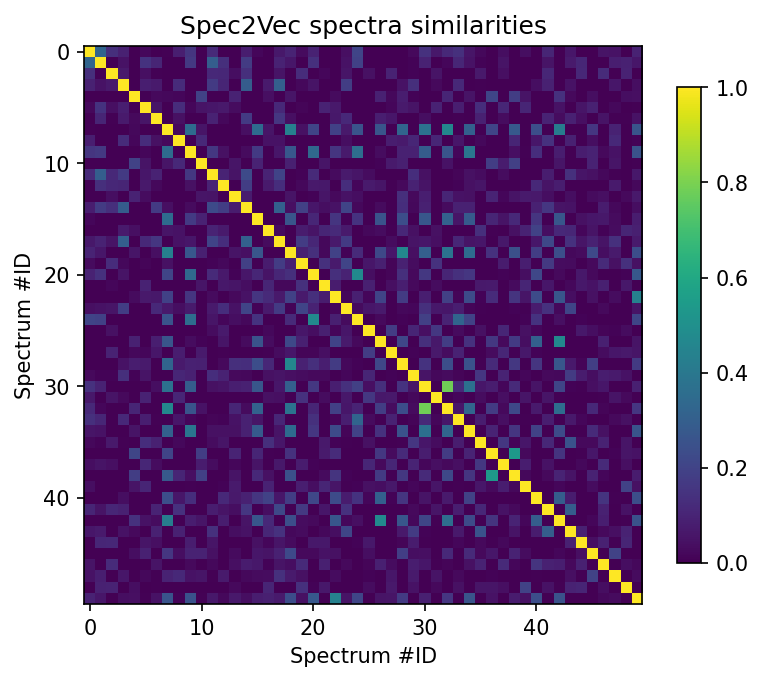

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores.scores[:50, :50], cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Spec2Vec spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
plt.clim(0, 1)  # Spec2Vec scores can be between -1 and 1
#plt.savefig("spec2vec_scores.png")